# Configuration

## Packages to import

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

from insight import *

import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import csv
from datetime import datetime
import re
from tqdm import tqdm
import multiprocessing as mp
from collections import OrderedDict
import time
import pandas as pd

['LICENSE', 'LoughranMcDonald_MasterDictionary_2018.csv', 'stage_2.py', 'requirements.txt', 'sec-scrapper.py', 'README.md', 'Load_MasterDictionary.py', 'Monthly_study.ipynb', 'Filing metrics.py', 'Yearly_study.ipynb']
/home/alex/Desktop/Insight project/sec-scrapper
 ...Loading Master Dictionary 85000
Master Dictionary loaded from file: 
  LoughranMcDonald_MasterDictionary_2018.csv
  86,486 words loaded in master_dictionary.



## Settings dictionary

In [21]:
_s = {
    'path_stage_1_data': os.path.join(home, 'Desktop/filtered_text_data/nd_data/'),
    'path_stock_database': os.path.join(home, 'Desktop/Insight project/Database/Ticker_stock_price.csv'),
    'path_stock_indexes': os.path.join(home, 'Desktop/Insight project/Database/Indexes/'),
    'path_cik_ticker_lookup': os.path.join(home, 'Desktop/Insight project/Database/cik_ticker.csv'),
    'path_master_dictionary': os.path.join(home, 'Desktop/Insight project/Database/LoughranMcDonald_MasterDictionary_2018.csv'),
    'path_dump_crsp': os.path.join(home, 'Desktop/Insight project/Database/dump_crsp_merged.txt'),
    'metrics': ['diff_jaccard', 'diff_cosine_tf', 'diff_cosine_tf_idf', 'diff_minEdit', 'diff_simple', 'sing_LoughranMcDonald'],
    'differentiation_mode': 'yearly',
    'time_range': [(2010, 1), (2012, 4)],
    'bin_count': 5,
    'report_type': ['10-K', '10-Q'],
    'sections_to_parse_10k': [],
    'sections_to_parse_10q': [],
    'type_daily_price': 'closing'
}

In [22]:
_s['pf_init_value'] = 1000000
_s['epsilon'] = 0.0001  # Rounding error
# Calculated settings
_s['list_qtr'] = qtrs.create_qtr_list(_s['time_range'])

if _s['bin_count'] == 5:
    _s['bin_labels'] = ['Q'+str(n) for n in range(1, _s['bin_count']+1)]
elif _s['bin_count'] == 10:
    _s['bin_labels'] = ['D'+str(n) for n in range(1, _s['bin_count']+1)]
else:
    raise ValueError('[ERROR] This type of bin has not been implemented yet.')

# Reports considered to calculate the differences
if _s['differentiation_mode'] == 'intersection':
    _s['lag'] = 1
    _s['sections_to_parse_10k'] = ['1a', '3', '7', '7a', '9a']
    _s['sections_to_parse_10q'] = ['_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a']
elif _s['differentiation_mode'] == 'yearly':
    _s['lag'] = 4
    _s['sections_to_parse_10k'] = ['1a', '3', '7', '7a', '9a']
    _s['sections_to_parse_10q'] = ['_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a']

_s['intersection_table'] = {
        '10-K': ['1a', '3', '7', '7a', '9a'],
        '10-Q': ['ii_1a', 'ii_1', '_i_2', '_i_3', '_i_4']
}  # Exhibits are not taken into account
_s['straight_table'] = {
    '10-K': ['1', '1a', '1b', '2', '3', '4', '5', '6', '7', '7a', '8', '9', '9a', '9b', '10', '11', '12', '13', '14', '15'],
    '10-Q': ['_i_1', '_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a', 'ii_2', 'ii_3', 'ii_4', 'ii_5', 'ii_6']
}

In [23]:
# Transfer s to a read only dict
read_only_dict = pre_processing.ReadOnlyDict()
for key in _s:  # Brute force copy
    read_only_dict[key] = _s[key]
s = read_only_dict  # Copy back
s.set_read_state(read_only=True)  # Set as read only

# Load external tables

## Extract the list of CIK for which we have complete data

The main problem in our case is that we have 3 different database to play with:
1. The SEC provides information based on the CIK of the entity
2. Given that the CIK is used by no one else, we use a lookup table to transform that into tickers. But we do not have all the correspondances, so the list of useful CIK is shrunk.
3. Finally, we only have stock prices for so many tickers. So that shrinks the CIK list even further.

We end up with a reduced list of CIK that we can play with.

### Find all the unique CIK from the SEC filings

In [5]:
cik_path = pre_processing.load_cik_path(s)

[INFO] Loaded 306,198 10-X
[INFO] Shrunk to 276,841 ['10-K', '10-Q']


 32%|███▏      | 89417/276841 [00:00<00:00, 894164.46it/s]

[INFO] Found 14,549 unique CIK in master index


100%|██████████| 276841/276841 [00:00<00:00, 907675.92it/s]

[INFO] cik_path contains data on 14,549 CIK numbers


### Get the largest {CIK: ticker} possible given our lookup table

In [6]:
lookup = pre_processing.load_lookup(s)
print("[INFO] Loaded {:,} CIK/Tickers correspondances.".format(len(lookup)))

[INFO] Loaded 13,738 CIK/Tickers correspondances.


In [7]:
cik_path, lookup = pre_processing.intersection_sec_lookup(cik_path, lookup)
print("[INFO] Intersected SEC & lookup.")
print("cik_path: {:,} CIK | lookup: {:,} CIK"
      .format(len(cik_path), len(lookup)))

[INFO] Intersected SEC & lookup.
cik_path: 8,207 CIK | lookup: 8,207 CIK


### Load stock data and drop all CIKs for which we don't have data

In [8]:
# Load all stock prices
stock_data = pre_processing.load_stock_data(s)

100%|██████████| 30563446/30563446 [01:31<00:00, 335366.54it/s]


In [9]:
lookup, stock_data = pre_processing.intersection_lookup_stock(lookup, stock_data)
print("[INFO] Intersected lookup & stock data.")
print("lookup: {:,} tickers | stock_data: {:,} tickers"
      .format(len(lookup.values()), len(stock_data)))

4668
[INFO] Intersected lookup & stock data.
lookup: 4,791 tickers | stock_data: 4,668 tickers


### Load stock indexes - will serve as benchmark later on

In [10]:
index_data = pre_processing.load_index_data(s)
print("[INFO] Loaded the following index data:", list(index_data.keys()))

[INFO] Loaded the following index data: ['IXIC', 'SPX', 'DJI', 'RUT']


## Back propagate these intersection all the way to cik_path

Technically, we have just done it for lookup. So we only need to re-run an intersection for lookup and sec.

In [11]:
cik_path, lookup = pre_processing.intersection_sec_lookup(cik_path, lookup)
print("[INFO] Intersected SEC & lookup.")
print("cik_path: {:,} CIK | lookup: {:,} CIK"
      .format(len(cik_path), len(lookup)))

[INFO] Intersected SEC & lookup.
cik_path: 4,791 CIK | lookup: 4,791 CIK


## Sanity check

At this point, cik_path and lookup should have the same number of keys as the CIK is unique in the path database.

However, multiple CIK can redirect to the same ticker if the company changed its ticker over time. That should be a very limited amount of cases though.

In [12]:
assert cik_path.keys() == lookup.keys()
assert len(set(lookup.values())) == len(set(stock_data.keys()))

At that point, we have a {CIK: ticker} for which the stock is known, which will enable comparison and all down the road.

## Review all CIKs: make sure there is only one submission per quarter

In this section, the goal is to build a list of CIK that will successfully be parsed for the time_range considered.
It should be trivial for a vast majority of the CIK, but ideally there should be only one document per quarter for each CIK from the moment they are listed to the moment they are delisted.

In [13]:
# Create the list of quarters to consider
cik_path = pre_processing.review_cik_publications(cik_path, s)
print("[INFO] Removed all the CIK that did not have one report per quarter.")
print("[INFO] Also, removed the one that did not publish 10-K/10-Q at the right time")
print("cik_dict: {:,} CIK".format(len(cik_path)))

100%|██████████| 4791/4791 [00:00<00:00, 8029.33it/s]



[INFO] 1555 CIKs caused trouble
[INFO] Removed all the CIK that did not have one report per quarter.
[INFO] Also, removed the one that did not publish 10-K/10-Q at the right time
cik_dict: 3,236 CIK


In [14]:
print("[INFO] We are left with {:,} CIKs that meet our requirements:".format(len(cik_path)))
print("- The ticker can be looked up in the CIK/ticker tabke")
print("- The stock data is available for that ticker")
print("- There is one and only one report per quarter")

[INFO] We are left with 3,236 CIKs that meet our requirements:
- The ticker can be looked up in the CIK/ticker tabke
- The stock data is available for that ticker
- There is one and only one report per quarter


In [15]:
"""
# [USER SETTINGS]
example = 'apple'  # Debug
# Examples of companies
example_companies = {
    'apple': ['AAPL', 320193],
    'baxter': ['BAX', 10456],
    'facebook': ['FB', 1326801],
    'google': ['GOOGL', 1652044],
    'microsoft': ['MSFT', 789019],
    'amazon': ['AMZN', 1018724],
    'johnson': ['JNJ', 200406],
    'jpmorgan': ['JPM', 19617]
}

# [DEBUG]: isolate a subset of companies
company = 'apple'
cik_path = {
    example_companies['apple'][1]: cik_path[example_companies['apple'][1]],
    example_companies['microsoft'][1]: cik_path[example_companies['microsoft'][1]],
    example_companies['jpmorgan'][1]: cik_path[example_companies['jpmorgan'][1]],
    example_companies['amazon'][1]: cik_path[example_companies['amazon'][1]],
    example_companies['johnson'][1]: cik_path[example_companies['johnson'][1]],
    
}
cik_path.keys()
"""

"\n# [USER SETTINGS]\nexample = 'apple'  # Debug\n# Examples of companies\nexample_companies = {\n    'apple': ['AAPL', 320193],\n    'baxter': ['BAX', 10456],\n    'facebook': ['FB', 1326801],\n    'google': ['GOOGL', 1652044],\n    'microsoft': ['MSFT', 789019],\n    'amazon': ['AMZN', 1018724],\n    'johnson': ['JNJ', 200406],\n    'jpmorgan': ['JPM', 19617]\n}\n\n# [DEBUG]: isolate a subset of companies\ncompany = 'apple'\ncik_path = {\n    example_companies['apple'][1]: cik_path[example_companies['apple'][1]],\n    example_companies['microsoft'][1]: cik_path[example_companies['microsoft'][1]],\n    example_companies['jpmorgan'][1]: cik_path[example_companies['jpmorgan'][1]],\n    example_companies['amazon'][1]: cik_path[example_companies['amazon'][1]],\n    example_companies['johnson'][1]: cik_path[example_companies['johnson'][1]],\n    \n}\ncik_path.keys()\n"

# Parse files

Now we have a list of CIK that should make it until the end. It is time to open the relevant reports and start parsing. This step takes a lot of time and can get arbitrarily long as the metrics get fancier.

You do not want to keep in RAM all the parsed data. However, there are only ~100 quarters for which we have data and the stage 2 files are no more than 1 Mb in size (Apple seems to top out at ~ 325 kb). So 100 Mb per core + others, that's definitely doable. More cores will use more RAM, but the usage remains reasonable.

We use multiprocessing to go through N CIK at once but a single core is dedicated to going through a given CIK for the specified time_range. Such a core can be running for a while if the company has been in business for the whole time_range and publish a lot of text data in its 10-K.

In [38]:
# Processing the reports will be done in parrallel in a random order
cik_scores = {k: 0 for k in cik_path.keys()}  # Organized by ticker
#debug = [[k, v, {**s}] for k, v in cik_path.items() if k==98338]  # settings are cast to dict for pickling
debug = [[k, v, {**s}] for k, v in cik_path.items()]  # settings are cast to dict for pickling

data_to_process = debug[   \ [[[[[[]]]:1000]  # Debug
#print(data_to_process)
#result = process_cik(data_to_process[0])
#cik_perf[result[0]] = result[1]
#print(cik_perf)
#assert 0
processing_stats = [0, 0, 0, 0, 0, 0]
nb_processes = min(mp.cpu_count(), 1)
nb_processes = min(mp.cpu_count(), len(data_to_process))
#qtr_metric_result = {key: [] for key in s['list_qtr']}
#with mp.Pool(processes=min(mp.cpu_count(), len(data_to_process))) as p:
with mp.Pool(processes=nb_processes) as p:
    print("[INFO] Starting a pool of {} workers".format(nb_processes))

    with tqdm(total=len(data_to_process)) as pbar:
        for i, value in tqdm(enumerate(p.imap_unordered(processing.process_cik, data_to_process))):
            pbar.update()
            #qtr = list_qtr[i]
            # Each quarter gets a few metrics
            if value[1] == {}:
                # The parsing failed
                del cik_scores[value[0]]
            else:
                cik_scores[value[0]] = value[1]
            processing_stats[value[2]] += 1
           
        #qtr_metric_result[value['0']['qtr']] = value
print("[INFO] {} CIK failed to be processed.".format(sum(processing_stats[1:])))
print("Detailed stats:", processing_stats)




















  0%|          | 0/1000 [00:00<?, ?it/s]



















0it [00:00, ?it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Starting a pool of 8 workers
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
idx_first_qtr: 9 | idx_last_qtr: 11 | lag: 4
[WARNING] Not enough valid reports for CIK 1523733 in this time_range. Skipping.





















  0%|          | 1/1000 [00:00<06:43,  2.48it/s]



















1it [00:00,  2.54it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WA




















  0%|          | 2/1000 [00:01<07:57,  2.09it/s]



















2it [00:01,  2.11it/s]

[INFO] No ToC found


[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (201

[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 5 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.8311744488178027, 'diff_cosine_tf': 0.9920342305984559, 'diff_cosine_tf_idf': 0.99052822333471, 'diff_minEdit': 0.9902290766603031, 'diff_simple': 0.9937466090625938, 'sing_LoughranMcDonald': -0.0008531630934380462, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 14), 'qtr': (2011, 1)}}
[WARNING] Previous section 6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found


[WARNING] Current section ii_2 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.7055373067682562, 'diff_cosine_tf': 0.9763191668065788, 'diff_cosine_tf_idf': 0.9712219315284949, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00016335271918954057, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 1 not found
{'diff_jaccard': 0.022986536260785707, 'diff_cosine_tf': 0.4047959823579907, 'diff_cosine_tf_idf': 0.31766083180493127, 'diff_minEdit': 0.9519431493471302, 'diff_simple': 0.7438466647739893, 'sing_LoughranMcDonald': -0.00231




















  0%|          | 3/1000 [00:03<18:30,  1.11s/it]



















3it [00:03,  1.11s/it]

[WARNING] Current section 14 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.7406451872726415, 'diff_cosine_tf': 0.9916958136423706, 'diff_cosine_tf_idf': 0.9899583485226722, 'diff_minEdit': 0.9858699080068052, 'diff_simple': 0.9672714389191569, 'sing_LoughranMcDonald': -0.0008358721879255041, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[WARNING] Previous section ii_5 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.013187465766495854, 'diff_cosine_tf': 0.24624271987158092, 'diff_cosine_tf_idf': 0.1918712176548




















  0%|          | 4/1000 [00:03<14:18,  1.16it/s]



















4it [00:03,  1.17it/s]

[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
{'diff_jaccard': 0.01245574944149359, 'diff_cosine_tf': 0.2544726092125025, 'diff_cosine_tf_idf': 0.19924252267966922, 'diff_minEdit': 0.9539174404967051, 'diff_simple': 0.5535674789899142, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[WARNING] Current section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 9 not found
[WARNING] Previous section 1b not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 9b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Previous section 9b not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 1 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] 




















  0%|          | 5/1000 [00:04<11:09,  1.49it/s]



















5it [00:04,  1.49it/s]

[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 1b not found
{'diff_jaccard': 0.11982122488884754, 'diff_cosine_tf': 0.12868835467596132, 'diff_cosine_tf_idf': 0.12282242097529292, 'diff_minEdit': 0.7090652327412957, 'diff_simple': 0.27111053340580904, 'sing_LoughranMcDonald': 0.0002349522527917647, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[WARNING] Current section ii_4 not found
[WARNING] Previous section 1b not found
[INFO] Comparing current qtr (2011, 2) to

[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.5297925691241653, 'diff_cosine_tf': 0.9576500881438436, 'diff_cosine_tf_idf': 0.9548753594691541, 'diff_minEdit': 0.9978093289258607, 'diff_simple': 0.9985419734904272, 'sing_LoughranMcDonald': -8.194382040983681e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 27), 'qtr': (2011, 3)}}
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Cur




















  1%|          | 6/1000 [00:04<11:14,  1.47it/s]



















6it [00:04,  1.48it/s]

[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.6039723102908852, 'diff_cosine_tf': 0.9588147445207433, 'diff_cosine_tf_idf': 0.9512132317492153, 'diff_minEdit': 0.9145241617757839, 'diff_simple': 0.9467143828886707, 'sing_LoughranMcDonald': -0.0020023992753121023, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous sectio

[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.4820592658016345, 'diff_cosine_tf': 0.9598983809905764, 'diff_cosine_tf_idf': 0.9496111839312331, 'diff_minEdit': 0.9941939393939396, 'diff_simple': 0.9893168484848488, 'sing_LoughranMcDonald': -0.00027209358773907724, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.6358967892796369, 'diff_cosine_tf': 0.9660191887242516, 'diff_cosine_tf_idf': 0.9630689252029789, 'diff_minEdit': 0.9994527515602482, 'diff_simple': 0.9988154654954412, 'sing_LoughranMcDonald': -8.429833794752768e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
[INFO] Compar




















  1%|          | 7/1000 [00:06<14:38,  1.13it/s]



















7it [00:06,  1.13it/s]

[WARNING] Current section 11 not found
[WARNING] Current section 1b not found
[INFO] No ToC found
[WARNING] Previous section 1b not found
[WARNING] Current section 12 not found
[WARNING] Current section 2 not found
[INFO] No ToC found
[WARNING] Current section 13 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section 2 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.7600706583243089, 'diff_cosine_tf': 0.9916568973635592, 'diff_cosine_tf_idf': 0.9905479692263053, 'diff_minEdit': 0.8574757732932335, 'diff_simple': 0.794948350259338, 'sing_LoughranMcDonald': -0.0014362299367777463, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr




















  1%|          | 8/1000 [00:06<11:05,  1.49it/s]



















8it [00:06,  1.49it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6536175886346085, 'diff_cosine_tf': 0.9717433600926182, 'diff_cosine_tf_idf': 0.9653132083528031, 'diff_minEdit': 0.9443212973225227, 'diff_simple': 0.9922049816251535, 'sing_LoughranMcDonald': -0.0018782165888682107, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING]




















  1%|          | 9/1000 [00:06<09:23,  1.76it/s]



















9it [00:06,  1.75it/s]

[WARNING] Current section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.06562109006700696, 'diff_cosine_tf': 0.6377089074327493, 'diff_cosine_tf_idf': 0.5798317425339715, 'diff_minEdit': 0.7140372471767054, 'diff_simple': 0.5069353054443265, 'sing_LoughranMcDonald': -0.0017990595643328662, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
{'diff_jaccard': 0.10697649894425978, 'diff_cosine_tf': 0.5185753154504417, 'diff_cosine_tf_idf': 0.4957086434187386, 'diff_minEdit': 0.8683759304207693, 'diff_simple': 0.6911368259697468, 'sing_LoughranMcDonald': -0.001008735709593231, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 15), 'qtr': (2011, 1)}}
[INFO] No ToC found
[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 q




















  1%|          | 10/1000 [00:06<07:55,  2.08it/s]



















10it [00:06,  2.09it/s]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20120504_10-Q_edgar_data_1171486_0001193125-12-210830_1.txt failed parsing
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 1 not found
{'diff_jaccard': 0.4418682248221098, 'diff_cosine_tf': 0.8819318689451316, 'diff_cosine_tf_idf': 0.8678930730277347, 'diff_minEdit': 0.9662959867095788, 'diff_simple': 0.9376231145049795, 'sing_LoughranMcDonald': -0.0014777215740400364, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current secti




















  1%|          | 12/1000 [00:08<08:19,  1.98it/s]

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.


[WARNING] Current section _i_1 not found
[WARNING] Current section 11 not found






















12it [00:08,  1.97it/s]

[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.6459351239914702, 'diff_cosine_tf': 0.9748053708492738, 'diff_cosine_tf_idf': 0.9692427992556403, 'diff_minEdit': 0.9372291157437354, 'diff_simple': 0.9564063664070438, 'sing_LoughranMcDonald': -0.0008934737714307475, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 13), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Curr




















  1%|▏         | 13/1000 [00:08<09:32,  1.72it/s]

[WARNING] Current section 10 not found






















13it [00:08,  1.71it/s]

[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 9 not found
[WARNING] Current section 12 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 12 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 13 not found
{'diff_jaccard': 0.7619722613222685, 'diff_cosine_tf': 0.9948149493370809, 'diff_cosine_tf_idf': 0.994048552912909, 'diff_minEdit': 0.9999240193750588, 'diff_simple': 0.9999518171646714, 'sing_LoughranMcDonald': -0.00015408919976155392, '0': {'type': '10-K', 'published': datetime.date(2011, 2,




















  1%|▏         | 14/1000 [00:09<11:38,  1.41it/s]

[INFO] Found a ToC!






















14it [00:09,  1.41it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
This is the res {'_i_1': [(180315, 180349)], '_i_2': [], '_i_3': [(268887, 268924)], '_i_4': [(269201, 269234)], 'ii_1': [(271279, 271309)], 'ii_1a': [(271529, 271559)], 'ii_6': [(271776, 271809)]}
[WARNING] Section 9a was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_49196_0000950123-10-046488_1.txt failed parsing
[INFO] Found a ToC!





















  2%|▏         | 16/1000 [00:10<09:15,  1.77it/s]



















16it [00:10,  1.78it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section 1 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 1b not f

[WARNING] Previous section ii_3 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.05753380566446094, 'diff_cosine_tf': 0.11508875475157174, 'diff_cosine_tf_idf': 0.08839751945186974, 'diff_minEdit': 0.6170849694184214, 'diff_simple': 0.24362951853548098, 'sing_LoughranMcDonald': -0.000586508394603815, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.5223562190366606, 'diff_cosine_tf': 0.9730721377096805, 'diff_cosine_tf_idf': 0.968404197513537, 'diff_minEdit': 0.9945420624011957, 'diff_simple': 0

[WARNING] Previous section ii_3 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 1b not found
{'diff_jaccard': 0.872512187266286, 'diff_cosine_tf': 0.8500358847777372, 'diff_cosine_tf_idf': 0.7679537817699257, 'diff_minEdit': 0.9502993149569816, 'diff_simple': 0.978265655263261, 'sing_LoughranMcDonald': -0.01973148716455505, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[WARNING] Previous section ii_4 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section 2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous s




















  2%|▏         | 17/1000 [00:13<20:30,  1.25s/it]



















17it [00:13,  1.25s/it]

[WARNING] Current section ii_6 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 12 not found
{'diff_jaccard': 0.9036458333333333, 'diff_cosine_tf': 0.9375, 'diff_cosine_tf_idf': 0.9043260058898602, 'diff_minEdit': 0.96875, 'diff_simple': 0.9898206066583609, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[WARNING] Current section 13 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section 14 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 15 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.07066841696512903, 'diff_cosine_tf': 0.45850144740097876, 'diff_cosine_tf_idf': 0.3641857340443488, 'diff_minEdit': 0.9157973211684148, 'diff_simple':

[WARNING] Current section 1b not found


  2%|▏         | 18/1000 [00:13<16:56,  1.03s/it]

[WARNING] Current section 15 not found






















18it [00:13,  1.04s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.6485488978673907, 'diff_cosine_tf': 0.9898287773821429, 'diff_cosine_tf_idf': 0.9882195216143113, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0004931168914498928, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 23), 'qtr': (2012, 1)}}
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 2 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section 8 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 9 not found
[WARNING] Current section 1 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 1 n




















  2%|▏         | 19/1000 [00:14<13:19,  1.23it/s]



















19it [00:14,  1.23it/s]

[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 1b not found
{'diff_jaccard': 0.5201385349265436, 'diff_cosine_tf': 0.9708303099956929, 'diff_cosine_tf_idf': 0.9647123413884451, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.0017010097275857855, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[WARNING] Previous section 1b not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNI

[WARNING] Previous section 10 not found


  2%|▏         | 20/1000 [00:14<11:30,  1.42it/s]

[INFO] No ToC found






















20it [00:14,  1.42it/s]

[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 13 not found
{'diff_jaccard': 0.00880255126464677, 'diff_cosine_tf': 0.01201096666397784, 'diff_cosine_tf_idf': 0.010650271652462795, 'diff_minEdit': 0.9498799836075172, 'diff_simple': 0.21785604453939839, 'sing_LoughranMcDonald': -0.0003583966652039957, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}





















  2%|▏         | 21/1000 [00:14<08:43,  1.87it/s]



















21it [00:14,  1.87it/s]

[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[INFO] Found a ToC!
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.6449337161754869, 'diff_cosine_tf': 0.9818639580779994, 'diff_cosine_tf_idf': 0.9805247505021055, 'diff_minEdit': 0.6394265819321832, 'diff_simple': 0.6801537198882042, 'sing_LoughranMcDonald': -0.0005946517215377916, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 3), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Foun




















  2%|▏         | 22/1000 [00:15<09:55,  1.64it/s]



















22it [00:15,  1.64it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.6547034053977103, 'diff_cosine_tf': 0.9896186710266096, 'diff_cosine_tf_idf': 0.989197704577652, 'diff_minEdit': 0.7282018613756778, 'diff_simple': 0.6115089253766997, 'sing_LoughranMcDonald': -5.4625600988181224e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 




















  2%|▏         | 23/1000 [00:16<11:26,  1.42it/s]





















[WARNING] Current section 6 not found


23it [00:16,  1.42it/s]

[WARNING] Current section 8 not found


[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Previous section 6 not found
[WARNING] Section 7a was found to be empty.
[WARNING] Current section 9b not found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Section 1a was found to be empty.
[WARNING] Previous section 8 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 12 not found
[INFO] No ToC found
[WARNING] Previous section 9 not found
[WARNING] Current section 13 not found
[WARNING] Current section 9 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 14 not found
[WARNING] Current section 9 not found
[WARNING] Current section 15 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9 not found
[

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.015121221907157202, 'diff_cosine_tf': 0.48245852595041916, 'diff_cosine_tf_idf': 0.4013940758253739, 'diff_minEdit': 0.7160454915028023, 'diff_simple': 0.389560139591108, 'sing_LoughranMcDonald': -0.0023757356449421187, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[ERROR] Here is full_sect: |[]|
[WARNING] Current section _i_1 not found
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_712770_0001144204-10-025286_1.txt failed parsing





















  2%|▏         | 24/1000 [00:17<12:01,  1.35it/s]



















24it [00:17,  1.35it/s]

[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.6576485013314542, 'diff_cosi




















  2%|▎         | 25/1000 [00:17<09:18,  1.74it/s]

{'diff_jaccard': 0.6553547226983386, 'diff_cosine_tf': 0.973395471120446, 'diff_cosine_tf_idf': 0.9706805563367586, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0015951366044796252, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.5269678853414124, 'diff_cosine_tf': 0.9385192955790173, 'diff_cosine_tf_idf': 0.9372935411003044, 'diff_minEdit': 0.9822376506890512, 'diff_simple': 0.9754088224321007, 'sing_LoughranMcDonald': -0.00034331246908069407, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 26), 'qtr': (2011, 3)}}






















25it [00:17,  1.74it/s]

[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6035740109626813, 'diff_cosine_tf': 0.9533787531331754, 'diff_cosine_tf_idf': 0.9304366907004069, 'diff_minEdit': 0.99740781




















  3%|▎         | 26/1000 [00:17<08:07,  2.00it/s]



















26it [00:17,  2.00it/s]

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 2 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section 5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5033898778786102, 'diff_cosine_tf': 0.9458876446435182, 'diff_cosine_tf_idf': 0.9445598749995122, 'diff_minEdit': 0.9832559916680534, 'diff_simple': 0.9768186699359934, 'sing_LoughranMcDonald': -0.0003004185679038929, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.




















  3%|▎         | 27/1000 [00:18<10:31,  1.54it/s]



















27it [00:18,  1.54it/s]

[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5828574299553786, 'diff_cosine_tf': 0.9765571362512925, 'diff_cosine_tf_idf': 0.9678755523535741, 'diff_minEdit': 0.9320052729099645, 'diff_simple': 0.9904807382073954, 'sing_LoughranMcDonald': -0.0003492372246680391, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [],




















  3%|▎         | 28/1000 [00:18<08:41,  1.86it/s]



















28it [00:18,  1.87it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6058352803868555, 'diff_cosine_tf': 0.9786609450904717, 'diff_cosine_tf_idf': 0.969600725056093, 'diff_minEdit': 0.9308074168782599, 'diff_simple': 0.990313038362956, 'sing_LoughranMcDonald': -0.0




















  3%|▎         | 29/1000 [00:19<08:57,  1.81it/s]



















29it [00:19,  1.81it/s]

[WARNING] Current section 1b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 1b not found
[WARNING] Previous section 10 not found
[WARNING] Current section 2 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 2 not found
[INFO] No ToC found
[WARNING] Previous section 11 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 4 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current secti

[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.08159421572649653, 'diff_cosine_tf': 0.1349243232485455, 'diff_cosine_tf_idf': 0.11234552770933637, 'diff_minEdit': 0.6615757971741592, 'diff_simple': 0.2805303913588666, 'sing_LoughranMcDonald': -0.0004015624202198759, 

[WARNING] Previous section 2 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
{'diff_jaccard': 0.6067395136894188, 'diff_cosine_tf': 0.9717848728167128, 'diff_cosine_tf_idf': 0.9582243179095193, 'diff_minEdit': 0.9417840273394135, 'diff_simple': 0.9918497638275178, 'sing_LoughranMcDonald': -0.00010396842882665869, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[WARNING] Previous section 5 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section 6 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_2 not found
[INFO] Found 




















  3%|▎         | 30/1000 [00:22<19:03,  1.18s/it]



















30it [00:22,  1.18s/it]

[WARNING] Current section 6 not found
{'diff_jaccard': 0.6091714376420818, 'diff_cosine_tf': 0.6887019791034621, 'diff_cosine_tf_idf': 0.6769173613298479, 'diff_minEdit': 0.8725114722423496, 'diff_simple': 0.7377087542499915, 'sing_LoughranMcDonald': -0.00028439153637337177, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 9), 'qtr': (2011, 1)}}
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section 6 not found
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Cur




















  3%|▎         | 32/1000 [00:22<13:39,  1.18it/s]



















32it [00:22,  1.18it/s]

{'diff_jaccard': 0.007629617093179197, 'diff_cosine_tf': 0.21949041530089833, 'diff_cosine_tf_idf': 0.17030750553793372, 'diff_minEdit': 0.9466246844408699, 'diff_simple': 0.47454505716605994, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 




















  3%|▎         | 33/1000 [00:22<11:21,  1.42it/s]



















33it [00:22,  1.41it/s]

[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.8606600734641379, 'diff_cosine_tf': 0.9935793940414129, 'diff_cosine_tf_idf': 0.9923227579144754, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006250613453094972, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6540972936787363, 'diff_cosine_tf': 0.9

[WARNING] Current section 2 not found


  3%|▎         | 34/1000 [00:23<10:25,  1.55it/s]



















34it [00:23,  1.54it/s]

[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.8320258081744102, 'diff_cosine_tf': 0.9827104978878118, 'diff_cosine_tf_idf': 0.9768775773051726, 'diff_minEdit': 0.9985150734058054, 'diff_simple': 0.9956848287006307, 'sing_LoughranMcDonald': -0.0006962900294796827, '0': {'type': '10-Q',




















  4%|▎         | 35/1000 [00:24<12:56,  1.24it/s]



















35it [00:24,  1.24it/s]

[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.8048142912022238, 'diff_cosine_tf': 0.9925621904038934, 'diff_cosine_tf_idf': 0.9918443651350723, 'diff_minEdit': 0.8237734691373172, 'diff_simple': 0.8310914222603998, 'sing_LoughranMcDonald': -0.0003187329280459699, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 17), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3




















  4%|▎         | 36/1000 [00:25<14:01,  1.15it/s]



















36it [00:25,  1.15it/s]

[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 10 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous




















  4%|▎         | 37/1000 [00:26<13:39,  1.17it/s]



















37it [00:26,  1.18it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.021326774465430805, 'diff_cosine_tf': 0.43853359397679254, 'diff_cosine_tf_idf': 0.3321642167330567, 'diff_minEdit': 0.958537756644205, 'diff_simple': 0.8231289337725762, 'sing_LoughranMcDonald': -0.0021407276324746, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}





















  4%|▍         | 38/1000 [00:26<10:42,  1.50it/s]



















38it [00:26,  1.50it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.7685372942853932, 'diff_cosine_tf': 0.9887864786081698, 'diff_cosine_tf_idf': 0.9860554419087848, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0008273392747821021, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous




















  4%|▍         | 39/1000 [00:26<09:34,  1.67it/s]



















39it [00:26,  1.67it/s]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.7434484302464064, 'diff_cosine_tf': 0.9748335147794297, 'diff_cosine_tf_idf': 0.9726930813086196, 'diff_minEdit': 0.9506396589725564, 'diff_simple': 0.7848702851308867, 'sing_LoughranMcDonald': -0.000523938381752783, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[ERROR] Here is full_sect: |[]|




















  4%|▍         | 40/1000 [00:27<09:31,  1.68it/s]



















40it [00:27,  1.68it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7834797948920731, 'diff_cosine_tf': 0.9890865056820617, 'diff_cosine_tf_idf': 0.9860790608893935, 'diff_minEdit': 0.9562423082182416, 'diff_simple': 0.7965267332148229, 'sing_LoughranMcDonald': -0.0006959978947487299, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}





















  4%|▍         | 41/1000 [00:28<09:17,  1.72it/s]



















41it [00:27,  1.72it/s]

[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[INFO] No ToC found
This is the res {'1a': [(145018, 145034)], '5': [], '6': [(143905, 143922), (145243, 145261)], '7': [(88086, 88106), (144263, 144284)], '8': [(144364, 144384), (145277, 145297)], '9': [(197804, 1




















  4%|▍         | 42/1000 [00:28<10:05,  1.58it/s]



















42it [00:28,  1.57it/s]

[WARNING] Previous section 11 not found


[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.7478157825932253, 'diff_cosine_tf': 0.9937213642948589, 'diff_cosine_tf_idf': 0.9931939780047718, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.0003764988854899503, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
This is the res {'1': [(231317, 231336)], '1a': [], '1b': [(1




















  4%|▍         | 43/1000 [00:29<09:16,  1.72it/s]



















43it [00:29,  1.71it/s]

[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6744726025120708, 'diff_cosine_tf': 0.9814722647386576, 'diff_cosine_tf_idf': 0.976653268031984, 'diff_minEdit': 0.9981060888127684, 'diff_simple': 0.9997159133219152, 'sing_LoughranMcDonald': -0.0006357396575056043, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[I

[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.6995392692676736, 'diff_cosine_tf': 0.9866937441780661, 'diff_cosine_tf_idf': 0.9847944547703261, 'diff_minEdit': 0.9964246724890831, 'diff_simple': 0.9941900927947599, 'sing_LoughranMcDonald': -0.0005255995670373677, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[WARNING] Current section ii_5 not 




















  4%|▍         | 44/1000 [00:33<24:35,  1.54s/it]



















44it [00:32,  1.54s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section 15 not found
{'diff_jaccard': 0.747262377234937, 'diff_cosine_tf': 0.9934523287153979, 'diff_cosine_tf_idf': 0.992620204250641, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0005028486864067736, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[WARNING] Cur




















  4%|▍         | 45/1000 [00:33<21:50,  1.37s/it]



















45it [00:33,  1.37s/it]

[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[INFO] No ToC found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not f




















  5%|▍         | 46/1000 [00:34<17:51,  1.12s/it]



















46it [00:34,  1.12s/it]

[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.7744119661640179, 'diff_cosine_tf': 0.9890632582541902, 'diff_cosine_tf_idf': 0.9849957977795262, 'diff_minEdit': 0.9894468257352889, 'diff_simple': 0.9867663194720523, 'sing_LoughranMcDonald': -0.0004054256220131569, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section i

[WARNING] Current section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.688727026895154, 'diff_cosine_tf': 0.9910439451767714, 'diff_cosine_tf_idf': 0.9883815244226986, 'diff_minEdit': 0.9397743365320577, 'diff_simple': 0.9840507908823, 'sing_LoughranMcDonald': -0.00029103685322112916, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current s




















  5%|▍         | 47/1000 [00:35<18:43,  1.18s/it]



















47it [00:35,  1.18s/it]

[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.013657598370536234, 'diff_cosine_tf': 0.36635224628152324, 'diff_cosine_tf_idf': 0.27884287844777544, 'diff_minEdit': 0.9592519078746333, 'diff_simple': 0.7982355541739912, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[WARNING] Current section ii_4 not




















  5%|▍         | 48/1000 [00:36<15:55,  1.00s/it]



















48it [00:36,  1.00s/it]

[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[INFO] No ToC found
[WARNING] Current section 4 not found
[WARNING] Current section 1b not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 2 not found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 8 not found
[WARNING] Current

[WARNING] Current section ii_3 not found


  5%|▍         | 49/1000 [00:36<13:31,  1.17it/s]



















49it [00:36,  1.17it/s]

[WARNING] Current section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.48422820252432, 'diff_cosine_tf': 0.7779510348971924, 'diff_cosine_tf_idf': 0.7354539810929696, 'diff_minEdit': 0.9704434836431576, 'diff_simple': 0.9461578231052462, 'sing_LoughranMcDonald': -0.0005711637844623811, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 21), 'qtr': (2012, 1)}}
[WARNING] Current section ii_6 not found
[WARNING] Current section 8 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9583333333333336, 'diff_simple': 0.9808635921571969, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 9 no




















  5%|▌         | 50/1000 [00:37<11:14,  1.41it/s]





















[WARNING] Current section ii_4 not found


50it [00:37,  1.41it/s]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.07666747451710677, 'diff_cosine_tf': 0.42270432071883185, 'diff_cosine_tf_idf': 0.32645860833367385, 'diff_minEdit': 0.9202899806421735, 'diff_simple': 0.7201850418446836, 'sing_LoughranMcDonald': -0.009889537696443702, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.07499150325041101, 'diff_cosine_tf': 0.42834947003254537, 'diff_cosine_tf_idf': 0.33




















  5%|▌         | 51/1000 [00:37<09:41,  1.63it/s]

[WARNING] Current section 2 not found






















51it [00:37,  1.63it/s]

[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Section 1a was found to be empty.
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
{'diff_jaccard': 0.7801767268223305, 'diff_cosine_tf': 0.9957329974185226, 'diff_cosine_tf_idf': 0.9946736112327701, 'diff_minEdit': 0.9976853964868135, 'diff_simple': 0.9996530681259221, 'sing_LoughranMcDonald': -0.0003023327802146877, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[WARNING] Current section 5 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section 5 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] No ToC f




















  5%|▌         | 52/1000 [00:38<11:45,  1.34it/s]



















52it [00:38,  1.34it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section ii_5 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.015826772601625672, 'diff_cosine_tf': 0.35425637755914496, 'diff_cosine_tf_idf': 0.2673335980188853, 'diff_minEdit': 0.9553523371669218, 'diff_simple': 0.8219050963283318, 'sing_LoughranMcDonald': -0.0007354098841130358, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Compar




















  5%|▌         | 53/1000 [00:39<10:40,  1.48it/s]





















{'diff_jaccard': 0.015267114314102732, 'diff_cosine_tf': 0.3535093278317522, 'diff_cosine_tf_idf': 0.2665786503522975, 'diff_minEdit': 0.9559440696985771, 'diff_simple': 0.8229033785168833, 'sing_LoughranMcDonald': -0.0007093434368222546, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}


53it [00:39,  1.47it/s]

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Current secti




















  5%|▌         | 54/1000 [00:40<13:54,  1.13it/s]

[WARNING] Current section ii_2 not found


[WARNING] Current section ii_5 not found






















54it [00:40,  1.13it/s]

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
{'diff_jaccard': 0.5717431652916699, 'diff_cosine_tf': 0.9226249152061792, 'diff_cosine_tf_idf': 0.9135136396492919, 'diff_minEdit': 0.9704947893595006, 'diff_simple': 0.9390434357937648, 'sing_LoughranMcDonald': -0.0013724443822005288, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6792348984634868, 'diff_cosine_tf': 0.98589121045806, 'diff_cosine_tf_idf': 0.9833873756161243, 'diff_minEdit': 0.9605096876674902, 'diff_simple': 0.9743389335281222, 'sing_LoughranMcDonald': -0.0017040437677699907, '0': {'typ




















  6%|▌         | 56/1000 [00:41<10:44,  1.47it/s]



















56it [00:41,  1.47it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5841509577083487, 'diff_cosine_tf': 0.9807925470588544, 'diff_cosine_tf_idf': 0.9779556946598946, 'diff_minEdit': 0.932952782601429, 'diff_simple': 0.9676411551626733, 'sing_LoughranMcDonald': -0.001426803842336227, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[WA

[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 5 not found
{'diff_jaccard': 0.7363668334660477, 'diff_cosine_tf': 0.993595134285392, 'diff_cosine_tf_idf': 0.9928132513094253, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.00011334685529667155, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 7), 'qtr': (2011, 1)}}
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section 5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 6 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 6 not found
[WARNING




















  6%|▌         | 57/1000 [00:43<21:21,  1.36s/it]



















57it [00:43,  1.36s/it]

[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.30868301760688815, 'diff_cosine_tf': 0.4690284853456698, 'diff_cosine_tf_idf': 0.45068488209196844, 'diff_minEdit': 0.6782193339097566, 'diff_simple': 0.2977560923814693, 'sing_LoughranMcDonald': -0.0002897923136205788, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 17), 'qtr': (2011, 1)}}
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_2 not found
[INFO] Comparin

[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.5666532514397136, 'diff_cosine_tf': 0.9517454197739404, 'diff_cosine_tf_idf': 0.9432068106167107, 'diff_minEdit': 0.9593440238637839, 'diff_simple': 0.9451303429492525, 'sing_LoughranMcDonald': -0.001691373995966018, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (201

[WARNING] Current section 11 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 12 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section 15 not found
{'diff_jaccard': 0.9272175033509906, 'diff_cosine_tf': 0.9955776985170919, 'diff_cosine_tf_idf': 0.9933265402826755, 'diff_minEdit': 0.9995866548568055, 'diff_simple': 0.9999379982285209, 'sing_LoughranMcDonald': -0.0008855528519051525, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.62643154




















  6%|▌         | 58/1000 [00:46<27:38,  1.76s/it]



















58it [00:46,  1.76s/it]

[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5443257940100983, 'diff_cosine_tf': 0.92249530391941, 'diff_cosine_tf_idf': 0.8966481766130969, 'diff_minEdit': 0.9283318730529594, 'diff_simple': 0.9297167056074764, 'sing_LoughranMcDonald': -0.002039562108497648, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.570883874873788, 'diff_cosine_tf': 0.




















  6%|▌         | 60/1000 [00:47<20:19,  1.30s/it]



















60it [00:47,  1.30s/it]

{'diff_jaccard': 0.5449617939254456, 'diff_cosine_tf': 0.9716126705162663, 'diff_cosine_tf_idf': 0.9650341079383613, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0012819162334342014, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 23), 'qtr': (2012, 4)}}


[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Previous section 2 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO




















  6%|▌         | 62/1000 [00:48<17:01,  1.09s/it]



















62it [00:48,  1.09s/it]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.6415378830845562, 'diff_cosine_tf': 0.9798976651810102, 'diff_cosine_tf_idf': 0.9747722652673931, 'diff_minEdit': 0.9739577413281016, 'diff_simple': 0.9718943508492757, 'sing_LoughranMcDonald': -0.0009257730406703715, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not foun

[WARNING] Current section 5 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 8 not found
[INFO] No ToC found
[WARNING] Previous section 8 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section 1 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.91

[WARNING] Current section ii_2 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 15 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 11 not found
{'diff_jaccard': 0.7627341586464156, 'diff_cosine_tf': 0.9205261302608726, 'diff_cosine_tf_idf': 0.9190761792918274, 'diff_minEdit': 0.968675741733995, 'diff_simple': 0.9387914608921805, 'sing_LoughranMcDonald': -0.001454535532527381, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1

[WARNING] Previous section ii_2 not found


  6%|▋         | 63/1000 [00:50<24:11,  1.55s/it]

[WARNING] Previous section ii_5 not found


[WARNING] Current section ii_2 not found






















63it [00:50,  1.55s/it]

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.05413336340139798, 'diff_cosine_tf': 0.15196932193309912, 'diff_cosine_tf_idf': 0.10913960316921564, 'diff_minEdit': 0.7528966961377384, 'diff_simple': 0.20449063828729147, 'sing_LoughranMcDonald': -0.0014461579312649083, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 12), 'qtr': (2011, 2)}}
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous sec




















  6%|▋         | 64/1000 [00:51<19:10,  1.23s/it]



















64it [00:51,  1.23s/it]

[WARNING] Current section 1b not found
[WARNING] Current section ii_2 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section ii_2 not found
[WARNING] Current section 2 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 8 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Current section ii_5 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Previous section ii_5 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 9 not found
[WARNING] Section ii_1 was found to

[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.18731098845293392, 'diff_cosine_tf': 0.3687130452974526, 'diff_cosine_tf_idf': 0.29425924906375434, 'diff_minEdit': 0.9220116046956959, 'diff_simple': 0.39443001833225955, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}





















  6%|▋         | 65/1000 [00:52<16:54,  1.08s/it]



















65it [00:52,  1.08s/it]

[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 9b not found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.36547233445022026, 'diff_cosine_tf': 0.8237161380571707, 'diff_cosine_tf_idf': 0.792562600153315, 'diff_minEdit': 0.8926744721394672, 'diff_simple': 0.856681099848604, 'sing_LoughranMcDonald': -0.0007759384




















  7%|▋         | 66/1000 [00:52<12:27,  1.25it/s]

[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.5769223895335472, 'diff_cosine_tf': 0.9757681144321885, 'diff_cosine_tf_idf': 0.971509087808387, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0014744722274661428, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}






















66it [00:52,  1.25it/s]

[WARNING] Current section 10 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[INFO] No ToC found
[WARNING] Current section 14 not found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 15 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8238630514269368, 'diff_cosine_tf': 0.9927760685651059, 'diff_cosine_tf_idf': 0.9923449763665637, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004696233883602584, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current 




















  7%|▋         | 67/1000 [00:52<10:02,  1.55it/s]



















67it [00:52,  1.55it/s]

[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6834054523600112, 'diff_cosine_tf': 0.9741636161487908, 'diff_cosine_tf_idf': 0.9653865813080491, 'diff_minEdit': 0.998411490220737, 'diff_simple': 0.9978880499754073, 'sing_LoughranMcDonald': -0.0007597431770127621, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[

[WARNING] Previous section 6 not found


  7%|▋         | 68/1000 [00:53<11:03,  1.40it/s]



















68it [00:53,  1.41it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 9b not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 1b not found
[WARNING] Current section 11 not found
[WARNING] Previous section 1b not found
[WARNING] Previous section 11 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not f




















  7%|▋         | 69/1000 [00:54<10:27,  1.48it/s]





















[WARNING] Previous section 11 not found


69it [00:54,  1.48it/s]

[INFO] No ToC found


[WARNING] Current section ii_6 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
{'diff_jaccard': 0.1301644106769414, 'diff_cosine_tf': 0.8476718847880828, 'diff_cosine_tf_idf': 0.8130732489630241, 'diff_minEdit': 0.8395993503646482, 'diff_simple': 0.26414551375577344, 'sing_LoughranMcDonald': -0.0010083188754101858, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[WARNING] Previous section 13 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[INFO] No ToC found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.8930469017840051, 'diff_cosine_tf': 0.99476




















  7%|▋         | 70/1000 [00:54<08:27,  1.83it/s]



















70it [00:54,  1.83it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.9532814238042272, 'diff_cosine_tf': 0.99717187804212, 'diff_cosine_tf_idf': 0.995940350335376, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-




















  7%|▋         | 71/1000 [00:55<10:12,  1.52it/s]



















71it [00:55,  1.52it/s]

[WARNING] Current section 10 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 12 not found
{'diff_jaccard': 0.9324382724941657, 'diff_cosine_tf': 0.9968454587536805, 'diff_cosine_tf_idf': 0.9946781671858822, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[WARNING] Current section 13 not found
[INFO] Found a ToC!
[WARNING] Current section 14 not found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.9022734221425714, 'diff_cosine_tf': 0.9933013224461038, 'diff_cosine_tf_idf': 0.9913829941415935, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.002190226789920259, '0': {'type': '10-K', 'published': datetime.date(20




















  7%|▋         | 73/1000 [00:56<08:56,  1.73it/s]



















73it [00:56,  1.73it/s]

{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9333333333333336, 'diff_simple': 0.9841636254572304, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 8 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_5 not found
[WARNING] Previous

[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
{'diff_jaccard': 0.5628309242284804, 'diff_cosine_tf': 0.9623382786144842, 'diff_cosine_tf_idf': 0.9543832030215297, 'diff_minEdit': 0.7327283807503442, 'diff_simple': 0.8461622035195104, 'sing_LoughranMcDonald': -0.0015204181531951444, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 31), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 1 not found
[WARNIN




















  7%|▋         | 74/1000 [00:57<14:45,  1.05it/s]

[WARNING] Current section 8 not found






















74it [00:57,  1.04it/s]

[WARNING] Previous section 14 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 15 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section 15 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.020285207007307106, 'diff_cosine_tf': 0.26398903292779247, 'diff_cosine_tf_idf': 0.20675371583556965, 'diff_minEdit': 0.9547045740043227, 'diff_simple': 0.5551282916097506, 'sing_LoughranMcDonald': -0.0012252669020308676, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 2), 'qtr': (2011, 1)}}
[INFO] No ToC found
[WARNING] Current section 9b not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNIN

[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.8496118206862007, 'diff_cosine_tf': 0.9194805194805191, 'diff_cosine_tf_idf': 0.8722188019492956, 'diff_minEdit': 0.9492325855962218, 'diff_simple': 0.9837116740009302, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 26), 'qtr': (2011, 4)}}
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6369030191366802, 'diff_cosine_tf': 0.9581381999302028, 'diff_cosine_tf_idf': 0.9528448468975496, 'diff_minEdit': 0.8022338056769933, 'diff_simple': 0.8259943916674715, 'sing_LoughranMcDonald': -0.0011470532421246147, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 27), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section




















  8%|▊         | 75/1000 [00:59<16:42,  1.08s/it]



















75it [00:59,  1.08s/it]

[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7110102687646608, 'diff_cosine_tf': 0.981066375588928, 'diff_cosine_tf_idf': 0.976914926981318, 'diff_minEdit': 0.9745030721261868, 'diff_simple': 0.964449997707369, 'sing_LoughranMcDonald': -0.0008435654842739265, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 14 not found
[WARNING] Current secti




















  8%|▊         | 76/1000 [01:00<15:16,  1.01it/s]



















76it [00:59,  1.01it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5711870826691781, 'diff_cosine_tf': 0.9426568349275047, 'diff_cosine_tf_idf': 0.9289745546146297, 'diff_minEdit': 0.987924299883314, 'diff_simple': 0.9889276546091015, 'sing_LoughranMcDonald': -0.001526010784903224, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}





















  8%|▊         | 77/1000 [01:00<11:30,  1.34it/s]



















77it [01:00,  1.34it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.06621929540834706, 'diff_cosine_tf': 0.23460987992913587, 'diff_cosine_tf_idf': 0.18097408329321452, 'diff_minEdit': 0.8416604463725584, 'diff_simple': 0.5403042187254544, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[WARNING] Current section 9 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 9 not found
[INFO] Comparing current qtr (2011, 4) to qtr 

[WARNING] Previous section ii_6 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.01633119156115727, 'diff_cosine_tf': 0.41631627418874007, 'diff_cosine_tf_idf': 0.32197944905008735, 'diff_minEdit': 0.9103041101469084, 'diff_simple': 0.7923777774330443, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 2), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Current section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 




















  8%|▊         | 78/1000 [01:04<25:56,  1.69s/it]



















78it [01:04,  1.69s/it]

[WARNING] Current section 9b not found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.013183925067104583, 'diff_cosine_tf': 0.2654503415343964, 'diff_cosine_tf_idf': 0.20996030629387388, 'diff_minEdit': 0.9517261380689979, 'diff_simple': 0.48826000416313076, 'sing_LoughranMcDonald': -0.00080071340521183, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 13), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0




















  8%|▊         | 79/1000 [01:04<22:17,  1.45s/it]



















79it [01:04,  1.45s/it]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5698933287240383, 'diff_cosine_tf': 0.9538999781268326, 'diff_cosine_tf_idf': 0.9433871234243801, 'diff_minEdit': 0.9751345583810649, 'diff_simple': 0.9502469410951883, 'sing_LoughranMcDonald': -0.0005199377676350359, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current




















  8%|▊         | 80/1000 [01:05<17:58,  1.17s/it]



















80it [01:05,  1.17s/it]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6167587699052315, 'diff_cosine_tf': 0.9794381178634761, 'diff_cosine_tf_idf': 0.9748240279628811, 'diff_minEdit': 0.9753998041775457, 'diff_simple': 0.9499050557797294, 'sing_LoughranMcDonald': -0.0005302302203168568, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}





















  8%|▊         | 81/1000 [01:05<13:16,  1.15it/s]



















81it [01:05,  1.16it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
This is the res {'_i_1': [(5090, 5108)], '_i_2': [], '_i_3': [(4535, 4556), (158699, 158723)], '_i_4': [(4614, 4631), (161030, 161049)], 'ii_1': [(165805, 165864)], 'ii_1a': [(166214, 166262)], 'ii_2': [(4767, 4788), (167839, 167905)], 'ii_3': [(4847, 4864), (169512, 169574)], 'ii_5': [(169694, 169753)], 'ii_6': [(4976, 4995), (169810, 169872)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100805_10-Q_edgar_data_1130713_0001104659-10-042456_1.txt failed parsing





















  8%|▊         | 82/1000 [01:06<13:28,  1.14it/s]



















82it [01:06,  1.14it/s]

[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
This is the res {'_i_1': [(4003, 4038)], '_i_2': [(38269, 38305)], '_i_3': [(84063, 84099)], '_i_4': [], 'ii_1': [(84640, 84670)], 'ii_1a': [(85400, 85430)], 'ii_2': [(86366, 86403)], 'ii_3': [(86557, 86590)], 'ii_5': [(86680, 86710)], 'ii_6': [(86767, 86800)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR2/20110516_10-Q_edgar_data_16614_0000950123-11-050561_1.txt failed 




















  8%|▊         | 83/1000 [01:07<13:58,  1.09it/s]



















83it [01:07,  1.09it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[INFO] No ToC found
[WARNING] Curren

[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.7019808979354133, 'diff_cosine_tf': 0.9862022457608475, 'diff_cosine_tf_idf': 0.9839375879750818, 'diff_minEdit': 0.9996209009919755, 'diff_simple': 0.9996019460415743, 'sing_LoughranMcDonald': -0.0008480039953540196, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_3 not found
[W

[WARNING] Current section 2 not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 9b not found
[WARNING] Current section 5 not found
{'diff_jaccard': 0.09264821749823342, 'diff_cosine_tf': 0.42893934750317664, 'diff_cosine_tf_idf': 0.37918836625322927, 'diff_minEdit': 0.5091369124254255, 'diff_simple': 0.3836559508133261, 'sing_LoughranMcDonald': -0.005889858158206066, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[WARNING] 

[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.7072023641220202, 'diff_cosine_tf': 0.9895499485750983, 'diff_cosine_tf_idf': 0.987973434336185, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003252056266822567, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 qua




















  8%|▊         | 84/1000 [01:12<30:25,  1.99s/it]



















84it [01:12,  1.99s/it]

[WARNING] Current section 1b not found
[INFO] No ToC found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 5 not found
{'diff_jaccard': 0.47105030167221623, 'diff_cosine_tf': 0.8966032560340829, 'diff_cosine_tf_idf': 0.8792539955786675, 'diff_minEdit': 0.9598729431120595, 'diff_simple': 0.9522502384358605, 'sing_LoughranMcDonald': -0.0014608546642813172, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Previous section 5 not




















  8%|▊         | 85/1000 [01:12<23:47,  1.56s/it]



















85it [01:12,  1.56s/it]

[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section _i_1 not found
[WARNING] Current section 11 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 11 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 13 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section 13 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Previous section 2 not found

[WARNING] Current section ii_6 not found


  9%|▊         | 86/1000 [01:13<18:48,  1.23s/it]



















86it [01:13,  1.24s/it]

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.09755336229679093, 'diff_cosine_tf': 0.6340110226542892, 'diff_cosine_tf_idf': 0.5861310067013177, 'diff_minEdit': 0.7207501144746273, 'diff_simple': 0.5390339120576924, 'sing_LoughranMcDonald': -0.0006915366766006057, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[WARNING] Previous section _i_1 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 8 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9b not f

[INFO] No ToC found


  9%|▊         | 87/1000 [01:13<14:01,  1.08it/s]



















87it [01:13,  1.08it/s]

[WARNING] Previous section 12 not found
[WARNING] Current section 4 not found
[WARNING] Current section 13 not found
[INFO] No ToC found
[WARNING] Previous section 13 not found
[WARNING] Previous section 4 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 14 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 5 not found
[WARNING] Previous section 14 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 15 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.70321976207654, 'diff_cosine_tf': 0.9893580450595966, 'diff_cosine_tf_idf': 0.9874778956361321, 'diff_minEdit': 0.8932028825424554, 'diff_simple': 0.9229559990588037, 'sing_LoughranMcDonald': -0.00039864273034085517, '0': {'type'

[WARNING] Previous section ii_2 not found


  9%|▉         | 88/1000 [01:14<13:13,  1.15it/s]

{'diff_jaccard': 0.7621483185481133, 'diff_cosine_tf': 0.9924294397739525, 'diff_cosine_tf_idf': 0.9905751967655183, 'diff_minEdit': 0.9335813776954401, 'diff_simple': 0.9306589583140396, 'sing_LoughranMcDonald': -0.000138584487418999, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}






















88it [01:14,  1.15it/s]

[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.8886483886483885, 'diff_cosine_tf': 0.9396825396825391, 'diff_cosine_tf_idf': 0.9003314886092916, 'diff_minEdit': 0.9682539682539679, 'diff_simple': 0.9863687238687235, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Section 9a was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 

[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 14 not found
{'diff_jaccard': 0.48403640079859706, 'diff_cosine_tf': 0.9342270766955626, 'diff_cosine_tf_idf': 0.9153571097953838, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003532922957399581, '0': {'type': '10-Q', 'published'

[WARNING] Current section 15 not found


  9%|▉         | 89/1000 [01:15<14:04,  1.08it/s]



















89it [01:15,  1.08it/s]

[WARNING] Current section _i_1 not found


{'diff_jaccard': 0.7882927806326675, 'diff_cosine_tf': 0.9880056083167301, 'diff_cosine_tf_idf': 0.9852594771936628, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.00010905106173869071, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 8 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[INFO] No ToC found
[WARNING] Current section 11 not found





















  9%|▉         | 90/1000 [01:15<10:55,  1.39it/s]



















90it [01:15,  1.39it/s]

[WARNING] Current section 14 not found


[WARNING] Previous section 14 not found
{'diff_jaccard': 0.691781762639292, 'diff_cosine_tf': 0.9829845908731004, 'diff_cosine_tf_idf': 0.9799918773820896, 'diff_minEdit': 0.9797914055433733, 'diff_simple': 0.980695578774467, 'sing_LoughranMcDonald': -0.00026336108009763495, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section 15 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Previous section 15 not found
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.4217924792255306, 'diff_cosine_tf': 0.7512278001837506, 'diff_cosine_tf_idf': 0.6888708764717161, 'diff_minEdit': 0.9017048765286811, 'diff_simple': 0.8868518035636682, 'sing_LoughranMcDonald': -0.0008636854020870725, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}
[WARNING] Current section ii_5 not found
[WARNING] Current section




















  9%|▉         | 91/1000 [01:15<09:03,  1.67it/s]



















91it [01:15,  1.67it/s]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.22694615076843902, 'diff_cosine_tf': 0.32581383211282683, 'diff_cosine_tf_idf': 0.3017247424788152, 'diff_minEdit': 0.7481363340703654, 'diff_simple': 0.4530370716113572, 'sing_LoughranMcDonald': -0.0005932236120358436, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.1740458478709628, 'diff_cosine_tf': 0.651127894712034, 'diff_cosine_tf_idf': 0.5866955129763141, 'diff_minEdit': 0.7694500078527667, 'diff_simple': 0.7505827637372627, 'sing_LoughranMcDonald': -0.0013351317797454265, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 3), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section




















  9%|▉         | 92/1000 [01:16<09:31,  1.59it/s]



















92it [01:16,  1.59it/s]

[WARNING] Current section 1 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[INFO] No ToC found
[WARNING] Current section 6 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[INFO] Found a ToC!
[WARNING] Current section 14 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 15 not found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.




















  9%|▉         | 93/1000 [01:17<12:20,  1.22it/s]



















93it [01:17,  1.23it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section 1b not found
[INFO] No ToC found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[INFO] No ToC found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] No ToC found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING




















  9%|▉         | 94/1000 [01:19<19:03,  1.26s/it]

[WARNING] Section 7 was found to be empty.






















94it [01:19,  1.26s/it]

[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 4 not found
{'diff_jaccard': 0.8154491529451356, 'diff_cosine_tf': 0.9656359787234565, 'diff_cosine_tf_idf': 0.9580596552360799, 'diff_minEdit': 0.9959683185494183, 'diff_simple': 0.998443672672021, 'sing_LoughranMcDonald': -0.0005242358395947055, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 8), '

[WARNING] Current section 2 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.8405589866813105, 'diff_cos




















 10%|▉         | 95/1000 [01:21<22:22,  1.48s/it]



















95it [01:21,  1.48s/it]

[WARNING] Current section ii_6 not found


[WARNING] Previous section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.010368601987382032, 'diff_cosine_tf': 0.06962600755387775, 'diff_cosine_tf_idf': 0.04506822148256777, 'diff_minEdit': 0.6741145094971951, 'diff_simple': 0.19950595440744567, 'sing_LoughranMcDonald': -0.000522591084756972, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.8067976045853956, 'diff_cosine_tf': 0.9721733984172994, 'diff_cosine_tf_idf': 0.9639335754332246, 'diff_minEdit': 0.9969107026400329, 'diff_simple': 0.9988260670032125, 'sing_Loug

[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.7337696629091195, 'diff_cosine_tf': 0.9854603567611809, 'diff_cosine_tf_idf': 0.9833058255465602, 'diff_minEdit': 0.9974481449977097, 'diff_simple': 0.9992344434993129, 'sing_LoughranMcDonald': -0.0006669445163333591, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 11), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_5 not 




















 10%|▉         | 97/1000 [01:23<19:20,  1.29s/it]



















97it [01:23,  1.28s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 8 not found
{'diff_jaccard': 0.6966489482690039, 'diff_cosine_tf': 0.9704976544892523, 'diff_cosine_tf_idf': 0.9600163031358214, 'diff_minEdit': 0.9717613336029487, 'diff_simple': 0.9568151325195206, 'sing_LoughranMcDonald': -0.003658340645085788, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[WARNING] Current section 9 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section 10 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 11 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Curre




















 10%|▉         | 98/1000 [01:23<14:38,  1.03it/s]

[WARNING] Previous section ii_4 not found






















98it [01:23,  1.03it/s]

{'diff_jaccard': 0.8165262253551625, 'diff_cosine_tf': 0.996902015784253, 'diff_cosine_tf_idf': 0.9966829117572389, 'diff_minEdit': 0.9600771085532226, 'diff_simple': 0.994011566282983, 'sing_LoughranMcDonald': -0.0003972694206247579, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.5461314423167236, 'diff_cosine_tf': 0.9471848272315104, 'diff_cosine_tf_idf': 0.9376287877658762, 'diff_minEdit': 0.9829104458689495, 'diff_simple': 0.9850625845737483, 'sing_LoughranMcDonal




















 10%|█         | 100/1000 [01:24<11:06,  1.35it/s]



















100it [01:24,  1.35it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5911063829571847, 'diff_cosine_tf': 0.9793653740432161, 'diff_cosine_tf_idf': 0.9766507444337398, 'diff_minEdit': 0.9980509143504737, 'diff_simple': 0.9868436718656981, 'sing_LoughranMcDonald': -0.0009133166624487022, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 7 was found 




















 10%|█         | 101/1000 [01:24<09:27,  1.58it/s]



















101it [01:24,  1.58it/s]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.611192533997634, 'diff_cosine_tf': 0.979358830262794, 'diff_cosine_tf_idf': 0.9767087404555377, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.0009322517835534231, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}


[INFO] No ToC found


 10%|█         | 102/1000 [01:24<07:16,  2.06it/s]



















102it [01:24,  2.06it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
idx_first_qtr: 9 | idx_last_qtr: 11 | lag: 4
[WARNING] Current section ii_2 not found
[WARNING] Not enough valid reports for CIK 1524025 in this time_range. Skipping.
[WARNING] Previous section ii_2 not found





















 10%|█         | 103/1000 [01:24<05:45,  2.60it/s]

[WARNING] Current section ii_3 not found


[WARNING] Previous section ii_3 not found


103it [01:24,  2.56it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.5668821712326816, 'diff_cosine_tf': 0.9699204248762741, 'diff_cosine_tf_idf': 0.963894460024217, 'diff_minEdit': 0.9990833373222917, 'diff_simple': 0.9998808338518977, 'sing_LoughranMcDonald': -0.0005843097564522426, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 4
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Not enough valid reports for CIK 1270073 in this time_range. Skipping.





















 10%|█         | 104/1000 [01:25<04:47,  3.12it/s]



















104it [01:25,  3.12it/s]

[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.8919051627384958, 'diff_cosine_tf': 0.9149827419901216, 'diff_cosine_tf_idf': 0.8819703807044653, 'diff_minEdit': 0.9629629629629628, 'diff_simple': 0.9678576438993104, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Current secti




















 10%|█         | 105/1000 [01:26<07:44,  1.93it/s]



















105it [01:25,  1.94it/s]

[WARNING] Current section _i_1 not found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.0677056008126659, 'diff_cosine_tf': 0.17380141264047577, 'diff_cosine_tf_idf': 0.14187954739749423, 'diff_minEdit': 0.7675843438922431, 'diff_simple': 0.21575328553047135, 'sing_LoughranMcDonald': -0.008317333989998277, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 26), 'qtr': (2012, 4)}}





















 11%|█         | 106/1000 [01:26<06:22,  2.34it/s]



















106it [01:26,  2.35it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current




















 11%|█         | 107/1000 [01:27<09:55,  1.50it/s]



















107it [01:27,  1.50it/s]

[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 9 not found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section 9 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 

[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 1 not found
[WARNING] Current section 13 not found
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Previous section 13 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 14 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 14 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 1b not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 4 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 4 not found
{'diff_jaccard': 0.9118521665250636, 'diff_cosine_tf': 0.9461637972597168, 'diff_cosine_tf_idf': 0.9160195485032837, 'diff_minEdit': 0.9672897196261682, 'diff_simple': 0.9881580860718755, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
[INFO] Comparing

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[WARNING] Current section 1 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Current section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 4 not found
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Current section 5 not found
[WARNING] Section 9a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 6 not found
[WARNING] Current




















 11%|█         | 108/1000 [01:29<17:30,  1.18s/it]



















108it [01:29,  1.18s/it]

[WARNING] Current section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 11 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section 1 not found
[WARNING] Current section 12 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 14 not found
{'diff_jaccard': 0.8972925981122701, 'diff_cosine_tf': 0.9402527463606446, 'diff_cosine_tf_idf': 0.905083640273508, 'diff_minEdit': 0.9672131147540983, 'diff_simple': 0.988924745366299, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current 




















 11%|█         | 109/1000 [01:30<14:06,  1.05it/s]

[WARNING] Current section ii_4 not found






















109it [01:30,  1.05it/s]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5574169645078023, 'diff_cosine_tf': 0.9524682733454581, 'diff_cosine_tf_idf': 0.9412105578550466, 'diff_minEdit': 0.9595533815397702, 'diff_simple': 0.9561820501914079, 'sing_LoughranMcDonald': -0.0017279771550711158, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 17), 'qtr': (2012, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 5 not found
[INFO]

[WARNING] Current section ii_5 not found


 11%|█         | 110/1000 [01:30<11:18,  1.31it/s]



















110it [01:30,  1.31it/s]

[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
{'diff_jaccard': 0.5689404785801384, 'diff_cosine_tf': 0.9515410270429702, 'diff_cosine_tf_idf': 0.9327773019154029, 'diff_minEdit': 0.9628482737734705, 'diff_simple': 0.9536235614778921, 'sing_LoughranMcDonald': -0.001625344615272441, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 10 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 8 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section 11 not found
{'diff_jaccard': 0.01978745589105846, 'diff_cosine_tf': 0.0951040




















 11%|█         | 111/1000 [01:30<09:20,  1.59it/s]



















111it [01:30,  1.59it/s]

[WARNING] Previous section _i_1 not found
[WARNING] Current section 13 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.8757885703637076, 'diff_cosine_tf': 0.9536178610765617, 'diff_cosine_tf_idf': 0.921656377307362, 'diff_minEdit': 0.976703084832905, 'diff_simple': 0.9871315338474723, 'sing_LoughranMcDonald': -0.0052117693346519075, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 2 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.

[WARNING] Previous section ii_4 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5859453367232809, 'diff_cosine_tf': 0.9704873180529543, 'diff_cosine_tf_idf': 0.9650738306672654, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0015243607727606985, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}





















 11%|█         | 112/1000 [01:31<09:46,  1.51it/s]

{'diff_jaccard': 0.5066798190789079, 'diff_cosine_tf': 0.9771104556940616, 'diff_cosine_tf_idf': 0.9753772683971688, 'diff_minEdit': 0.9923068378998163, 'diff_simple': 0.9874903630997394, 'sing_LoughranMcDonald': -0.0005138516018174276, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Found a ToC!






















112it [01:31,  1.51it/s]

[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Pre




















 11%|█▏        | 113/1000 [01:32<09:17,  1.59it/s]



















113it [01:32,  1.59it/s]

{'diff_jaccard': 0.5882433483155921, 'diff_cosine_tf': 0.9813154962215568, 'diff_cosine_tf_idf': 0.9770690209687045, 'diff_minEdit': 0.9997973230749668, 'diff_simple': 0.9996757169199468, 'sing_LoughranMcDonald': -0.0011831199559562673, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 27), 'qtr': (2011, 3)}}


[WARNING] Current section 6 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Current section 12 not found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section 13 not found
idx_first_qtr: 8 | idx_last_qtr: 11 | lag: 4
[WARNING] Not enough valid reports for CIK 1352010 in this time_range. Skipping.





















 11%|█▏        | 114/1000 [01:32<07:14,  2.04it/s]

[INFO] Found a ToC!






















114it [01:32,  2.04it/s]

[WARNING] Current section 14 not found
[INFO] Found a ToC!
[WARNING] Current section 15 not found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.6410052758837739, 'diff_cosine_tf': 0.7449804697514355, 'diff_cosine_tf_idf': 0.7399411164602167, 'diff_minEdit': 0.8990661534317761, 'diff_simple': 0.7885179209067941, 'sing_LoughranMcDonald': -0.0007692942875561776, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 13), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Current s




















 12%|█▏        | 115/1000 [01:33<08:44,  1.69it/s]



















115it [01:33,  1.69it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section 9b not found
{'diff_jaccard': 0.6679930177105428, 'diff_cosine_tf': 0.9767117494248891, 'diff_cosine_tf_idf': 0.9753124456542936, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -7.666398635494284e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 24), 'qtr': (2012, 3)}}
[WARNING] Current section 10 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 11 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 12 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to 




















 12%|█▏        | 116/1000 [01:33<08:19,  1.77it/s]



















116it [01:33,  1.76it/s]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6379093508092357, 'diff_cosine_tf': 0.9799015447146867, 'diff_cosine_tf_idf': 0.9786884381232331, 'diff_minEdit': 0.9973146193653821, 'diff_simple': 0.9962578994586944, 'sing_LoughranMcDonald': -0.001299116189665257, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.6060676771191092, 'diff_cosine_tf': 0.9739968496202688, 'diff_cosine_tf_idf': 0




















 12%|█▏        | 117/1000 [01:34<08:47,  1.67it/s]



















117it [01:34,  1.68it/s]

[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[INFO] No ToC found
[WARNING] Previous section 4 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section 5 not found
[INFO] Found a ToC!
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section 4 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 9 not found
[INFO] Comparing current 




















 12%|█▏        | 118/1000 [01:35<10:06,  1.46it/s]





















{'diff_jaccard': 0.5283749953799808, 'diff_cosine_tf': 0.9782065218928675, 'diff_cosine_tf_idf': 0.9748763695499963, 'diff_minEdit': 0.9841360241982472, 'diff_simple': 0.9937216300300916, 'sing_LoughranMcDonald': -0.0005782273296775934, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 10), 'qtr': (2011, 1)}}


118it [01:35,  1.45it/s]

[WARNING] Current section 14 not found


[WARNING] Previous section 14 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section 15 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.8358905493598884, 'diff_cosine_tf': 0.9878569876606411, 'diff_cosine_tf_idf': 0.9849648935968387, 'diff_minEdit': 1.0000000000000004, 'diff_simple': 1.0000000000000004, 'sing_LoughranMcDonald': -0.0011173634279605994, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[WARNING] Previous section _i_1 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not f

[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section 1b not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section 2 not found
[WARNING] Current section 1b not found
[INFO] No ToC found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
{'diff_jaccard': 0.4199238179179176, 'diff_cosine_tf': 0.9618189219916214, 'diff_cosine_tf_idf': 0.9528813834179581, 'diff_minEdit': 0.9852810255801531, 'diff_simple': 0.9772346528973035, 'sing_LoughranMcDonald': -0.001298393170035848, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[WARNING] Current section 5 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section 6 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Section _i_2 

[WARNING] Current section ii_5 not found


 12%|█▏        | 119/1000 [01:37<16:29,  1.12s/it]



















119it [01:37,  1.12s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.2991287170689255, 'diff_cosine_tf': 0.8977840324008772, 'diff_cosine_tf_idf': 0.8700945855625997, 'diff_minEdit': 0.8169823273016673, 'diff_simple': 0.5426696783323354, 'sing_LoughranMcDonald': -0.0018772373500827626, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6229899584196816, 'diff_cosine_tf': 0.9702691353958628, 'diff_cosine_tf_idf': 0.9652841296226534, 'diff_minEdit': 0.9976607179080006, 'diff_simple': 0.9965083397147428, 'sing_LoughranMcDonald': -0.0012622565183909211, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[




















 12%|█▏        | 120/1000 [01:37<12:36,  1.16it/s]



















120it [01:37,  1.16it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5910828277688956, 'diff_cosine_tf': 0.970097541326807, 'diff_cosine_tf_idf': 0.9650221700951251, 'diff_minEdit': 0.9996917623487712, 'diff_simple': 0.9999075287046315, 'sing_LoughranMcDonald': -0.0011609351667567322, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 30), 'qtr': (2012, 4)}}





















 12%|█▏        | 121/1000 [01:37<09:32,  1.54it/s]



















121it [01:37,  1.54it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100511_10-Q_edgar_data_860519_0000860519-10-000029_1.txt failed parsing





















 12%|█▏        | 122/1000 [01:38<08:29,  1.72it/s]



















122it [01:38,  1.70it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100324_10-K_edgar_data_1016169_0001016169-10-000002_1.txt failed parsing





















 12%|█▏        | 123/1000 [01:38<07:13,  2.02it/s]



















123it [01:38,  2.03it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Section 9a was found to be empty.
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff

[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 14 not found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Current section ii_5 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 15 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section 5 not found
{'diff_jaccard': 0.7143173308707897, 'diff_cosine_tf': 0.9548797893627892, 'diff_cosine_tf_idf': 0.9535373017372815, 'diff_minEdit': 0.9904733302925073, 'diff_simple': 0.9663737719064769, 'sing_LoughranMcDonald': -0.000459081013604166, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 




















 12%|█▏        | 124/1000 [01:40<15:57,  1.09s/it]



















124it [01:40,  1.09s/it]

[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
{'diff_jaccard': 0.05995696894055509, 'diff_cosine_tf': 0.6193975863228673, 'diff_cosine_tf_idf': 0.5569572960000795, 'diff_minEdit': 0.7740594327302259, 'diff_simple': 0.5307746947656561, 'sing_LoughranMcDonald': -0.00041322468263976195, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 27), 'qtr': (2011, 2)}}
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 9 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_5 not found
[WARNING] P

[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.5727291129378949, 'diff_cosine_tf': 0.9735076627612406, 'diff_cosine_tf_idf': 0.9688879297527173, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.0003699632344606752, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 

[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 13 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.12220259234437839, 'diff_cosine_tf': 0.4999976765351029, 'diff_cosine_tf_idf': 0.403916867880783, 'diff_minEdit': 0.5739117618525235, 'diff_simple': 0.4708744710860366, 'sing_LoughranMcDonald': -0.02618584403034194, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[WARNING] Current section 14 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 15 not found
[WARNING] Current section 1 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.5509532090823483, 'diff_cosine_tf': 0.9735696964721627, 'diff_cosin

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.6901707176568791, 'diff_cosine_tf': 0.9412715938195315, 'diff_cosine_tf_idf': 0.9343468062209547, 'diff_minEdit': 0.9840822443750562, 'diff_simple': 0.9641154728343235, 'sing_LoughranMcDonald': -0.0008242316394778003, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 11), 'qtr': (2011, 4)}}
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 1 not found
{'diff_jaccard': 0.2997332651271557, 'diff_cosine_tf': 0.7250414984442162, 'diff_cosine_tf_idf': 0.649493754823386, 'diff_minEdit': 0.8420992191088656, 'diff_simple': 0.37196006479958754, 'sing_LoughranMcDonald': -0.0032407959291509687, 




















 13%|█▎        | 126/1000 [01:44<18:05,  1.24s/it]



















126it [01:44,  1.24s/it]

[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.6606231043220785, 'diff_cosine_tf': 0.982382465010991, 'diff_cosine_tf_idf': 0.9809374373880079, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0010033105302382724, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[WARNING] Current section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 2 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section 1 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 6 not found
{'diff




















 13%|█▎        | 127/1000 [01:44<14:05,  1.03it/s]





















[WARNING] Current section 8 not found


127it [01:44,  1.03it/s]

[WARNING] Current section 4 not found
[WARNING] Current section 9 not found
[WARNING] Current section 5 not found
[WARNING] Current section 9b not found
[WARNING] Current section 6 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.7734091443371632, 'diff_cosine_tf': 0.988883802206523, 'diff_cosine_tf_idf': 0.986841597958292, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004988012544498751, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING




















 13%|█▎        | 128/1000 [01:44<10:54,  1.33it/s]



















128it [01:44,  1.34it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7278462967925554, 'diff_cosine_tf': 0.9501010145610709, 'diff_cosine_tf_idf': 0.9433990931629487, 'diff_minEdit': 0.9929939452937747, 'diff_simple': 0.9746177590566837, 'sing_LoughranMcDonald': -0.0010083846771306497, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 12), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[INFO




















 13%|█▎        | 129/1000 [01:45<10:38,  1.36it/s]



















129it [01:45,  1.37it/s]

[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
{'diff_jaccard': 0.7723177045542187, 'diff_cosine_tf': 0.9691512831363909, 'diff_cosine_tf_idf': 0.9661162106712261, 'diff_minEdit': 0.9247665281848799, 'diff_simple': 0.9798637012237826, 'sing_LoughranMcDonald': -0.0006767960903693755, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 15), 'qtr': (2012, 4)}}
[WARNING] Previous section 4 not found





















 13%|█▎        | 130/1000 [01:45<07:56,  1.83it/s]



















130it [01:45,  1.83it/s]

[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Previous section 4 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6531105760208329, 'diff_cosine_tf': 0.978644106678138, 'diff_cosine_tf_idf': 0.9770031363268179, 'diff_minEdit': 1.0, 'diff_simple'




















 13%|█▎        | 131/1000 [01:46<08:29,  1.70it/s]



















131it [01:46,  1.71it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.06408219537718404, 'diff_cosine_tf': 0.33016993761217506, 'diff_cosine_tf_idf': 0.2928531012827217, 'diff_minEdit': 0.5834497593537541, 'diff_simple': 0.3412256667135603, 'sing_LoughranMcDonald': -0.0005131714340549502, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from




















 13%|█▎        | 132/1000 [01:47<09:36,  1.51it/s]



















132it [01:47,  1.50it/s]

[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.5669489446738765, 'diff_cosine_tf': 0.9695036620271226, 'diff_cosine_tf_idf': 0.9630080614294093, 'diff_minEdit': 0.9973529980034778, 'diff_simple': 0.9947059960069555, 'sing_LoughranMcDonald': -0.0013462225500354358, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (201




















 13%|█▎        | 133/1000 [01:47<09:05,  1.59it/s]



















133it [01:47,  1.59it/s]

[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 9b not found
[WARNING] Current section 13 not found
[WARNING] Current section 10 not found
[WARNING] Current section 14 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 15 not found
[WARNING] Current section 13 not found
{'diff_jaccard': 0.6939241129840578, 'diff_cosine_tf': 0.9878526763224151, 'diff_cosine_tf_idf': 0.9862962155909519, 'diff_minEdit': 0.9835651134929945, 'diff_simple': 0.9972060692938094, 'sing_LoughranMcDonald': -0.00040675704541289566, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[WARNING] Current section 14 not found
[




















 13%|█▎        | 134/1000 [01:48<11:15,  1.28it/s]



















134it [01:48,  1.29it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Current section 6 not found
{'diff_jaccard': 0.8345095039755347, 'diff_cosine_tf': 0.9952337150497963, 'diff_cosine_tf_idf': 0.99446876833019, 'diff_minEdit': 0.9539401285845011, 'diff_simple': 0.9240012121644265, 'sing_LoughranMcDonald': -0.0004030474822598163, '0': {'type': 




















 14%|█▎        | 135/1000 [01:48<08:54,  1.62it/s]



















135it [01:48,  1.62it/s]

[WARNING] Previous section 6 not found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [],




















 14%|█▎        | 136/1000 [01:49<08:19,  1.73it/s]





















[INFO] No ToC found


136it [01:49,  1.73it/s]

[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section 14 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section 14 not found
[WARNING] Section ii_1a




















 14%|█▎        | 137/1000 [01:50<10:20,  1.39it/s]



















137it [01:50,  1.40it/s]

[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[INFO] Found a ToC!
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section 6 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous sectio

[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 1 not found
{'diff_jaccard': 0.6767739117296651, 'diff_cosine_tf': 0.9485023622759936, 'diff_cosine_tf_idf': 0.9443593408449873, 'diff_minEdit': 0.9282774432674862, 'diff_simple': 0.8443693717811289, 'sing_LoughranMcDonald': -4.43163801510799e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Previ




















 14%|█▍        | 138/1000 [01:52<13:43,  1.05it/s]



















138it [01:52,  1.05it/s]

[WARNING] Previous section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 10 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.7174105762173153, 'diff_cosine_tf': 0.990419812665663, 'diff_cosine_tf_idf': 0.9894453802522525, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00027498253939811467, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[WARNING] Current section 12 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section 13 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr 

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
{'diff_jaccard': 0.8173652923225005, 'diff_cosine_tf': 0.9823984409512806, 'diff_cosine_tf_idf': 0.9714412284451932, 'diff_minEdit': 0.9969542375098487, 'diff_simple': 0.995851492206616, 'sing_LoughranMcDonald': -0.0034871701538277304, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}
[WARNING] Previous section 1b not found





















 14%|█▍        | 139/1000 [01:52<13:25,  1.07it/s]



















139it [01:52,  1.07it/s]

[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_

[WARNING] Current section 1 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Previous section 1 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Previous section ii_4 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] 




















 14%|█▍        | 140/1000 [01:54<15:04,  1.05s/it]



















140it [01:54,  1.05s/it]

[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section 1b not found
[WARNING] Current section 11 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 12 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[INFO] No ToC found
[WARNING] Previous section 2 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.007131742738371479, 'diff_cosine_tf': 0.2808761095314252, 'diff_cosine_tf_idf': 0.20764022017659567, 'diff_minEdit': 0.933245876564515, 'diff_simple': 0.6386509746286039, 'sing_LoughranMcDonald': -0.00041306853169256893, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 7), 'qtr': (2012, 1)}}
[WARNING] Current section 4 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not 




















 14%|█▍        | 141/1000 [01:54<11:18,  1.27it/s]

[WARNING] Current section ii_2 not found


[WARNING] Previous section ii_5 not found


141it [01:54,  1.26it/s]

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.4223667330351852, 'diff_cosine_tf': 0.9596929724483239, 'diff_cosine_tf_idf': 0.9549430490509023, 'diff_minEdit': 0.826905469721475, 'diff_simple': 0.7652513267247418, 'sing_LoughranMcDonald': -0.0004019518447642882, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Previous section ii_4 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.5682606047




















 14%|█▍        | 142/1000 [01:55<10:33,  1.35it/s]



















142it [01:55,  1.36it/s]

[WARNING] Current section 6 not found
{'diff_jaccard': 0.575710433030399, 'diff_cosine_tf': 0.9837187682960379, 'diff_cosine_tf_idf': 0.9827541090170717, 'diff_minEdit': 0.9994359117999471, 'diff_simple': 0.9998834217719891, 'sing_LoughranMcDonald': -0.0005279428167409275, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Current section 11 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 12 




















 14%|█▍        | 143/1000 [01:55<09:14,  1.55it/s]

[WARNING] Current section ii_6 not found






















143it [01:55,  1.55it/s]

{'diff_jaccard': 0.4852144347717366, 'diff_cosine_tf': 0.9437116071564148, 'diff_cosine_tf_idf': 0.9412404483929521, 'diff_minEdit': 0.8901076068846243, 'diff_simple': 0.8416133501187534, 'sing_LoughranMcDonald': -0.00012023124049950067, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.6109249451203933, 'diff_cosine_tf': 0.9567897584670904, 'diff




















 14%|█▍        | 144/1000 [01:55<07:34,  1.88it/s]





















[WARNING] Current section ii_2 not found


144it [01:55,  1.87it/s]

[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Section 7 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.6047068779628956, 'diff_cosine_tf': 0.9790640636379613, 'diff_cosine_tf_idf': 0.974889717314332, 'diff_minEdit': 0.9151139942928797, 'diff_simple': 0.9457033679907578, 'sing_LoughranMcDonald': -0.0025176629172695537, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 27), 'qtr': (2012, 3)}}
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Cur




















 14%|█▍        | 145/1000 [01:56<07:04,  2.02it/s]



















145it [01:56,  2.02it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_5 not found





















 15%|█▍        | 146/1000 [01:56<05:36,  2.54it/s]



















146it [01:56,  2.55it/s]

{'diff_jaccard': 0.4945066264265619, 'diff_cosine_tf': 0.9121140872591109, 'diff_cosine_tf_idf': 0.8973835191206921, 'diff_minEdit': 0.7878104253153921, 'diff_simple': 0.7942246703388413, 'sing_LoughranMcDonald': -0.0001355665015173746, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.635980361696331, 'diff_cosine_tf': 0.9838631841022814, 'diff_cosine_tf_idf': 0.9731418004818215, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.001761107114779866, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[




















 15%|█▍        | 147/1000 [01:56<05:00,  2.84it/s]

[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] Current section ii_2 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100301_10-K_edgar_data_106926_0000950123-10-019298_1.txt failed parsing






















147it [01:56,  2.84it/s]

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[INFO] No ToC found
This is the res {'_i_2': [(3360, 3379)], '_i_3': [(3461, 3482)], '_i_4': [(3535, 3552)], 'ii_1': [(3635, 3649)], 'ii_1a': [(3668, 3682)], 'ii_5': [], 'ii_6': [(3697, 3714)]}
[WARNING] Previous section ii_6 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR4/20111110_10-Q_edgar_data_1098146_0000950123-11-097650_1.txt failed parsing
{'diff_jaccard': 0.08952872370178895, 'diff_cosine_tf': 0.1807308226395065, 'diff_cosine_tf_idf': 0.14523135434506904, 'diff_minEdit': 0.6368443022123279, 'diff_simple': 0.286163418470797, 'sing_LoughranMcDonald': -0.024779241804360686, '0': {'type': 




















 15%|█▍        | 149/1000 [01:56<03:51,  3.67it/s]





















[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.


149it [01:56,  3.66it/s]

[WARNING] Current section 1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Current section 5 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 12 not found
[WARNING




















 15%|█▌        | 150/1000 [01:57<06:51,  2.07it/s]



















150it [01:57,  2.08it/s]

[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] No ToC found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] 

[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
{'diff_jaccard': 0.520114587109505, 'diff_cosine_tf': 0.9307978360639054, 'diff_cosine_tf

[WARNING] Previous section 4 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 5 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section 12 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.7750011250787638, 'diff_cosine_tf': 0.9828931477037002, 'diff_cosine_tf_idf': 0.9772530829315801, 'diff_minEdit': 0.9959509790548936, 'diff_simple': 0.999335879482283, 'sing_LoughranMcDonald': -0.0017689600197629664, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}





















 15%|█▌        | 151/1000 [02:00<16:51,  1.19s/it]



















151it [02:00,  1.19s/it]

[WARNING] Current section 14 not found


[WARNING] Current section 15 not found
{'diff_jaccard': 0.4609723215782362, 'diff_cosine_tf': 0.6282770863554018, 'diff_cosine_tf_idf': 0.6158387682795102, 'diff_minEdit': 0.8571985664832291, 'diff_simple': 0.6943598288983843, 'sing_LoughranMcDonald': -0.00013585316014695076, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 9 not fo




















 15%|█▌        | 152/1000 [02:01<15:58,  1.13s/it]



















152it [02:01,  1.13s/it]

[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.8528015344786966, 'diff_cosine_tf': 0.9943056711246653, 'diff_cosine_tf_idf': 0.9930578823819048, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006019990828110189, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Compa




















 15%|█▌        | 153/1000 [02:02<13:10,  1.07it/s]



















153it [02:01,  1.07it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.8354559581841036, 'diff_cosine_tf': 0.9927416374426016, 'diff_cosine_tf_idf': 0.9913094364868692, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005506219888057106, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 

[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.015393346522089768, 'diff_cosine_tf': 0.30910925215098334, 'diff_cosine_tf_idf': 0.23163328557855012, 'diff_minEdit': 0.9556349478449114, 'diff_simple': 0.7812000840172945, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}


[WARNING] Current section ii_4 not found


 15%|█▌        | 154/1000 [02:03<16:16,  1.15s/it]



















154it [02:03,  1.16s/it]

[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.7754050819530921, 'diff_cosine_tf': 0.9680982219184338, 'diff_cosine_tf_idf': 0.9643077383794243, 'diff_minEdit': 0.6489585981417432, 'diff_simple': 0.5186263050831181, 'sing_LoughranMcDonald': -0.001157665243700431, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_6 not found
[INFO] Comparing current qtr (2011, 1) to qtr (20




















 16%|█▌        | 155/1000 [02:04<13:27,  1.05it/s]



















155it [02:04,  1.05it/s]

[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.49177241802118593, 'diff_cosine_tf': 0.9556383395243139, 'diff_cosine_tf_idf': 0.9496084014633465, 'diff_minEdit': 0.9935368948720777, 'diff_simple': 0.9876781688919715, 'sing_LoughranMcDonald': -0.000556421356733056, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 10), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 4 not found
{'diff_jaccard': 0.5485447777379966, 'diff_cosine_tf': 0.9720459925098047, 'diff_cosine_tf_idf': 0.9700007174947078, 'diff_minEdit': 0.9993492548968569, 'diff_simple': 0.9975738632948467, 'sing_LoughranMcDonald': -0.001598527109831277, '




















 16%|█▌        | 156/1000 [02:04<11:32,  1.22it/s]

[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found


[WARNING] Current section 9b not found


[WARNING] Current section 1b not found


156it [02:04,  1.21it/s]

[WARNING] Previous section _i_1 not found


[WARNING] Previous section _i_1 not found
[WARNING] Current section 10 not found
[WARNING] Current section 2 not found
[INFO] No ToC found
[WARNING] Current section 11 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section 12 not found
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[WARNING] Current section 13 not found
This is the res {'_i_1': [(4989, 5007)], '_i_2': [(65303, 65322)], '_i_3': [(99793, 99814)], '_i_4': [(101543, 101560)], 'ii_1': [(105399, 105413)], 'ii_1a': [(105787, 105801), (105980, 105995)], 'ii_2': [(106689, 106710)], 'ii_5': [], 'ii_6': [(109311, 109328)]}
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR4/20111114_10-Q_edgar_data_49615_0001144204-11

{'diff_jaccard': 0.6197057600255308, 'diff_cosine_tf': 0.9757253758946625, 'diff_cosine_tf_idf': 0.9680435202258401, 'diff_minEdit': 0.9994397759103641, 'diff_simple': 0.9998095238095238, 'sing_LoughranMcDonald': -0.0004932569687596453, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 11), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.6670323103601457, 'diff_cosine_tf': 0.9740790572017103, 'diff_cosine_tf_idf': 0.9696907341138533, 'diff_minEdit': 0.9999321230959359, 'diff_simple': 0.9999769218526182, 'sing_LoughranMcDonald': -0.0005899346458801405, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section




















 16%|█▌        | 158/1000 [02:05<10:08,  1.38it/s]



















158it [02:05,  1.38it/s]

[WARNING] Current section 12 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7885258929580787, 'diff_cosine_tf': 0.9884518586561015, 'diff_cosine_tf_idf': 0.9872121013109052, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.0011479896042432488, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.5944508288359229, 'diff_cosine_tf': 0.9776968171687415, 'diff_cosine_tf_idf': 0.9739082970068976, 'diff




















 16%|█▌        | 159/1000 [02:06<08:59,  1.56it/s]





















[WARNING] Current section 1b not found


159it [02:06,  1.55it/s]

[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.8886483886483885, 'diff_cosine_tf': 0.9396825396825391, 'diff_cosine_tf_idf': 0.9003314886092916, 'diff_minEdit': 0.96031746031746, 'diff_simple': 0.9838117570260425, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 22), 'qtr': (2012, 4)}}





















 16%|█▌        | 160/1000 [02:06<06:52,  2.04it/s]



















160it [02:06,  2.04it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] No ToC found
[WARNING] Current section 12 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 13 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7896381744008093, 'diff_cosine_tf': 0.9926569095179126, 'diff_cosine_tf_idf': 0.9917563882104368, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000353348269779, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current sectio




















 16%|█▌        | 161/1000 [02:07<11:46,  1.19it/s]



















161it [02:07,  1.19it/s]

[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.01679461901444992, 'diff_cosine_tf': 0.05893110249095456, 'diff_cosine_tf_idf': 0.03911736743044118, 'diff_minEdit': 0.658222973019945, 'diff_simple': 0.21131326079761265, 'sing_LoughranMcDonald': -0.0008413731663959699, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current sectio

[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
{'diff_jaccard': 0.40408987871001606, 'diff_cosine_tf': 0.9330058073481087, 'diff_cosine_tf_idf': 0.9161124066021654, 'diff_minEdit': 0.9102754384030622, 'diff_simple': 0.8604142177441925, 'sing_LoughranMcDonald': -0.0008146389558829753, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}





















 16%|█▌        | 162/1000 [02:09<15:41,  1.12s/it]



















162it [02:09,  1.12s/it]

[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Section 1a was found to be empty.
[WARNING] Previous section 14 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Section 9a was found to be empty.
[WARNING] Previous section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.00572516989433683, 'diff_cosine_tf': 0.12215493609807915, 'diff_cosine_tf_idf': 0.092




















 16%|█▋        | 163/1000 [02:10<12:24,  1.12it/s]



















163it [02:10,  1.13it/s]

[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 1b not found
{'diff_jaccard': 0.012565749570804963, 'diff_cosine_tf': 0.24516886647600475, 'diff_cosine_tf_idf': 0.18509627399346934, 'diff_minEdit': 0.955655313033033, 'diff_simple': 0.5899467898744435, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_2 not foun

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section 8 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 8 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.013148267411680247, 'diff_cosine_tf': 0.3682801525190744, 'diff_cosine_tf_idf': 0.27874774758065457, 'diff_minEdit': 0.9560951120045054, 'diff_simple': 0.8260525840432688, 'sing_Loug




















 16%|█▋        | 164/1000 [02:11<13:41,  1.02it/s]

[WARNING] Current section ii_4 not found






















164it [02:11,  1.02it/s]

[WARNING] Previous section 11 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.530038722650292, 'diff_cosine_tf': 0.9622222966363425, 'diff_cosine_tf_idf': 0.9500954206899207, 'diff_minEdit': 0.9895579785113556, 'diff_simple': 0.9890985295658553, 'sing_LoughranMcDonald': -0.0007555689074727531, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 18), 'qtr': (2011, 4)}}
[WARNING] Current section 15 not

[WARNING] Current section 9 not found
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 9b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 10 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 11 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 13 not found
[INFO] No ToC found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.6474519859596337, 'diff_cosine_tf': 0.9885670010390243, 'diff_cosine_tf_idf': 0.9866489867026714, 'diff_minEdit': 0.9534761405804442, 'diff_simple': 0.9900280400037383, 'sing_LoughranMcDonald': -0.00039




















 17%|█▋        | 166/1000 [02:13<13:43,  1.01it/s]





















[WARNING] Previous section 15 not found


166it [02:13,  1.01it/s]

[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.7607987401037605, 'diff_cosine_tf': 0.9871920876660558, 'diff_cosine_tf_idf': 0.9850708609719129, 'diff_minEdit': 0.9914720876589685, 'diff_simple': 0.9840814329497922, 'sing_LoughranMcDonald': -0.000450328535529511, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5243736176090471, 'diff_cosine_tf': 0.9700359727881412, 'diff_cosine_tf_idf': 0.9609535546348436, 'diff_minEdit': 0.9990605496193188, 'diff_simple': 0.999661797862955, 'sing_LoughranMcDonald': -0.0005087034108029353, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 




















 17%|█▋        | 167/1000 [02:13<11:06,  1.25it/s]



















167it [02:13,  1.25it/s]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8263756593581794, 'diff_cosine_tf': 0.9902973479174679, 'diff_cosine_tf_idf': 0.9878336239438419, 'diff_minEdit': 0.974366619799866, 'diff_simple': 0.9876515248727487, 'sing_LoughranMcDonald': -0.0004012032000874774, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[IN




















 17%|█▋        | 168/1000 [02:15<15:44,  1.14s/it]



















168it [02:15,  1.13s/it]

[WARNING] Previous section 5 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5214009801334017, 'diff_cosine_tf': 0.9567605636306279, 'diff_cosine_tf_idf': 0.9403329146506979, 'diff_minEdit': 0.9936064633568563, 'diff_simple': 0.9891275964391694, 'sing_LoughranMcDonald': -0.001117731789334433, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[WARNING] Current section 4 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 6 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous




















 17%|█▋        | 169/1000 [02:15<12:32,  1.10it/s]



















169it [02:15,  1.10it/s]

[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9 not found
[WARNING] Current section 10 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 12 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 1b not found
[WARNING] Current section 13 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 2 not found
[WARNING] Current section 14 not found
[WARNING] Current section 13 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 13 not found
[WARNING] Previous section 2 not found
{'diff_jaccard': 0.7834906063457322, 'di

[WARNING] Current section _i_1 not found


 17%|█▋        | 170/1000 [02:16<11:19,  1.22it/s]





















[WARNING] Previous section _i_1 not found


170it [02:16,  1.22it/s]

[WARNING] Previous section 10 not found


[INFO] No ToC found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section 15 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
{'diff_jaccard': 0.803778290974258, 'diff_cosine_tf': 0.9915044798529671, 'diff_cosine_tf_idf': 0.9886630686172347, 'diff_minEdit': 0.9932188373202483, 'diff_simple': 0.9949367318657855, 'sing_LoughranMcDonald': -0.000977256038468224, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[WARNING

[WARNING] Current section 8 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section 9 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 9b not found
[WARNING] Current section 6 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 12 not found
[WARNING] Current section 8 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Cur




















 17%|█▋        | 171/1000 [02:18<14:15,  1.03s/it]



















171it [02:18,  1.03s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.18539698605488075, 'diff_cosine_tf': 0.1866256590829716, 'diff_cosine_tf_idf': 0.18429130392365772, 'diff_minEdit': 0.48689833558254636, 'diff_simple': 0.42066288249494377, 'sing_LoughranMcDonald': -0.0012233329339643168, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.48463365719446405, 'diff_cosine_tf': 0.9569468028988517, 'diff_cosine_tf_idf': 0.9455735399393305, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00031800051182819683, '0': {'type': '10-Q', 'published'




















 17%|█▋        | 172/1000 [02:18<12:11,  1.13it/s]

[WARNING] Current section ii_6 not found
[WARNING] Current section 5 not found


[WARNING] Current section _i_1 not found






















172it [02:18,  1.13it/s]

[WARNING] Previous section ii_6 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.4910453729451312, 'diff_cosine_tf': 0.9575644040488738, 'diff_cosine_tf_idf': 0.9466620111198047, 'diff_minEdit': 0.9583139522917651, 'diff_simple': 0.9203155164961819, 'sing_LoughranMcDonald': -0.0016527827937465834, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[WARNING] Current section 13 not found
[WARNING] Current section 6 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[WARNING] Previous section 6 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.00984223042498358, 'diff_cosine_tf': 0.17844220770345384, 'diff_cosine_tf_idf': 0.1389064




















 17%|█▋        | 173/1000 [02:19<11:43,  1.18it/s]

[WARNING] Current section _i_1 not found






















173it [02:19,  1.17it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.7907137907137909, 'diff_cosine_tf': 0.9536037400180292, 'diff_cosine_tf_idf': 0.929742487092395, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0088, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 9 not found
{'diff_jaccard': 0.8119278226798676, 'diff_cosine_tf': 0




















 17%|█▋        | 174/1000 [02:19<09:53,  1.39it/s]



















174it [02:19,  1.39it/s]

[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.623148954691454, 'diff_cosine_tf': 0.9722499527451364, 'diff_cosine_tf_idf': 0.9679008073355994, 'diff_minEdit': 0.9965579398438333, 'diff_simple': 0.9994587419806801, 'sing_LoughranMcDonald': -0.0016405982376314625, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] 




















 18%|█▊        | 175/1000 [02:19<07:50,  1.75it/s]

{'diff_jaccard': 0.6943817052512704, 'diff_cosine_tf': 0.9565621879691267, 'diff_cosine_tf_idf': 0.9263755689651713, 'diff_minEdit': 0.9372966577935521, 'diff_simple': 0.9920317885683482, 'sing_LoughranMcDonald': -0.048038695997879674, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}






















175it [02:19,  1.74it/s]

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.


[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5601391739974939, 'diff_cosine_tf': 0.9538052987224743, 'diff_cosine_tf_idf': 0.9381461940415168, 'diff_minEdit': 0.983529144345367, 'diff_simple': 0.9813095162418154, 'sing_LoughranMcDonald': -0.0019162421001926696, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2)

{'diff_jaccard': 0.7256172839506174, 'diff_cosine_tf': 0.8120868602901073, 'diff_cosine_tf_idf': 0.7551023844270736, 'diff_minEdit': 0.9308216262239255, 'diff_simple': 0.8739229038292975, 'sing_LoughranMcDonald': -0.053146258503401364, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}


 18%|█▊        | 176/1000 [02:20<06:21,  2.16it/s]



















176it [02:20,  2.17it/s]

[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6613458560072067, 'diff_cosine_tf': 0.9804102998708035, 'diff_cosine_tf_idf': 0.9783441333235923, 'diff_minEdit': 0.9135051346548209, 'diff_simple': 0.9156301273974519, 'sing_LoughranMcDonald': -0.0006430707192033695, '0': {'typ




















 18%|█▊        | 177/1000 [02:20<06:09,  2.22it/s]



















177it [02:20,  2.23it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not f




















 18%|█▊        | 178/1000 [02:20<05:53,  2.32it/s]



















178it [02:20,  2.33it/s]

[WARNING] Current section 13 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 14 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 15 not found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.5497644465012282, 'diff_cosine_tf': 0.6834224112214307, 'diff_cosine_tf_idf': 0.6739490067049375, 'diff_minEdit': 0.8254088712020228, 'diff_simple': 0.7529011496677432, 'sing_LoughranMcDonald': -0.00046621514848047636, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not




















 18%|█▊        | 179/1000 [02:21<06:32,  2.09it/s]



















179it [02:21,  2.10it/s]

[WARNING] Current section 11 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.02510961063482464, 'diff_cosine_tf': 0.3484458150085103, 'diff_cosine_tf_idf': 0.26727253286962027, 'diff_minEdit': 0.808228825385928, 'diff_simple': 0.7722555376086516, 'sing_LoughranMcDonald': -0.002449127542514901, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Current section 15 not found
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7498292376937841, 'diff_cosine_tf': 0.9919754284211234, 'diff_cosine_tf_idf': 0.9915767720262854, 'diff_minEdit': 0.7908984144619697, 'diff_simple': 0.8311402364138776, 'sing_Loughra




















 18%|█▊        | 180/1000 [02:21<05:44,  2.38it/s]



















180it [02:21,  2.38it/s]

[INFO] Found a ToC!
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100505_10-Q_edgar_data_836106_0001193125-10-108851_1.txt failed parsing
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7719290693326939, 'diff_cosine_tf': 0.9926305875860686, 'diff_cosine_tf_idf': 0.9921769382609936, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006624242629573573, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
idx_first_qtr: 8 | idx_last_qtr: 11 | lag: 4
[WARNING] Not enough valid reports for CIK 15




















 18%|█▊        | 182/1000 [02:22<04:57,  2.75it/s]



















182it [02:22,  2.74it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
idx_first_qtr: 8 | idx_last_qtr: 11 | lag: 4
[WARNING] Not enough valid reports for CIK 1311241 in this time_range. Skipping.





















 18%|█▊        | 183/1000 [02:22<04:54,  2.77it/s]



















183it [02:22,  2.80it/s]

[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] Current section ii_3 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100301_10-K_edgar_data_74260_0000074260-10-000018_1.txt failed parsing





















 18%|█▊        | 184/1000 [02:22<03:52,  3.50it/s]



















184it [02:22,  3.52it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7454908214035578, 'diff_cosine_tf': 0.9898922298325272, 'diff_cosine_tf_idf': 0.9893697848230799, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006019139255412547, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found




















 18%|█▊        | 185/1000 [02:23<05:16,  2.57it/s]



















185it [02:23,  2.58it/s]

[INFO] Found a ToC!
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Curr

[INFO] Found a ToC!
[WARNING] Current section 10 not found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Current section 11 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Previous section _i_1 not found
[WARNING] Current section 12 not found
[WARNING] Section 9a was found to be empty.
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.4460727644646533, 'diff_cosine_tf': 0.7087105586707045, 'diff_cosine_tf_idf': 0.7034249446775414, 'diff_minEdit': 0.8266871434839846, 'diff_simple': 0.7905251734221188, 'sing_LoughranMcDonald': -0.00033262718694840847, '0': {'type': '10-

[WARNING] Current section ii_5 not found


 19%|█▊        | 186/1000 [02:25<13:06,  1.04it/s]

[WARNING] Previous section ii_5 not found






















186it [02:25,  1.04it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.5216920176996351, 'diff_cosine_tf': 0.949837926689788, 'diff_cosine_tf_idf': 0.938204742705082, 'diff_minEdit': 0.9548051282754959, 'diff_simple': 0.9388377677456534, 'sing_LoughranMcDonald': -0.0018865377539300687, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.4589535285614863, 'diff_cosine_tf': 0.




















 19%|█▊        | 187/1000 [02:25<09:40,  1.40it/s]



















187it [02:25,  1.39it/s]

[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 1 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section ii_5 not fo

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.6867365389876395, 'diff_cosine_tf': 0.980020626124768, 'diff_cosine_tf_idf': 0.9676592178765236, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0022204890292966918, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Previous section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNIN




















 19%|█▉        | 188/1000 [02:27<14:51,  1.10s/it]



















188it [02:27,  1.10s/it]

[WARNING] Current section 1 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 14 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.01567000657857174, 'diff_cosine_tf': 0.09863573018301466, 'diff_cosine_tf_idf': 0.06837946049280569, 'diff_minEdit': 0.5777943096269635, 'diff_simple': 0.23751353562173338, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current 




















 19%|█▉        | 189/1000 [02:28<13:48,  1.02s/it]



















189it [02:28,  1.02s/it]

[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5906538952704105, 'diff_cosine_tf': 0.9562177765963029, 'diff_cosine_tf_idf': 0.9494536433392288, 'diff_minEdit': 0.9985143711379453, 'diff_simple': 0.9975470112758593, 'sing_LoughranMcDonald': -0.0007553709807104758, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 1), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current sectio




















 19%|█▉        | 190/1000 [02:29<12:34,  1.07it/s]



















190it [02:29,  1.07it/s]

[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.35661004686666103, 'diff_cosine_tf': 0.702339537361596, 'diff_cosine_tf_idf': 0.6882314655278202, 'diff_minEdit': 0.9036620655750103, 'diff_simple': 0.8360872645266368, 'sing_Loug

[WARNING] Current section _i_1 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section 15 not found
[INFO] No ToC found
{'diff_jaccard': 0.7081319977454182, 'diff_cosine_tf': 0.9905822094517557, 'diff_cosine_tf_idf': 0.9894306334761399, 'diff_minEdit': 0.9854074462127642, 'diff_simple': 0.9606001047744639, 'sing_LoughranMcDonald': -0.0003680414462339231, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
This is the res {'1': [(8365, 8383)], '1a': [(22650, 22666)], '1b': [(36447, 36469)], '2': [(36523, 36543)], '3': [(39144, 39160)], '5': [(47387, 47404)], '6': [(52547, 52566)], '7': [(53814, 53835)], '7a': [(110605, 110629)], '8': [(112363, 112383)], '9': [(196097, 196115)], '9a': [(196204, 196224)], '9b': [(199052, 199069)], '10': [(199132, 199153)], '11': [(200489, 200510)], '12': [(201277,




















 19%|█▉        | 191/1000 [02:31<15:56,  1.18s/it]



















191it [02:31,  1.18s/it]

[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section _i_1 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 11 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section 12 not found
[WARNING] Current section 1b not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current s




















 19%|█▉        | 192/1000 [02:32<15:06,  1.12s/it]



















192it [02:32,  1.12s/it]

[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.9473684210526319, 'diff_cosine_tf': 0.9473684210526313, 'diff_cosine_tf_idf': 0.9473684210526313, 'diff_minEdit': 0.9649122807017547, 'diff_simple': 0.9598997493734338, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
{'di




















 19%|█▉        | 193/1000 [02:32<12:56,  1.04it/s]



















193it [02:32,  1.04it/s]

[WARNING] Previous section 4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_4 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 8 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 1b not found
[WARNING] Current section 9 not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
{'diff_jaccard': 0.559706860499104, 'diff_cosine_tf': 0.8707855264223845, 'diff_cosine_tf_idf': 0.845490248489017, 'diff_minEdit': 0.8739345462192013, 'diff_simple': 0.8416766212811




















 19%|█▉        | 194/1000 [02:33<11:50,  1.14it/s]



















194it [02:33,  1.14it/s]

[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.9473684210526319, 'diff_cosine_tf': 0.9473684210526313, 'diff_cosine_tf_idf': 0.9473684210526313, 'diff_minEdit': 0.9649122807017547, 'diff_simple': 0.9598997493734338, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.9473684210526319, 'diff_cosine_tf': 0.9473684210526313, 'diff_cosine_t




















 20%|█▉        | 195/1000 [02:33<09:37,  1.39it/s]



















195it [02:33,  1.39it/s]

[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7064704970800224, 'diff_cosine_tf': 0.9651788018765957, 'diff_cosine_tf_idf': 0.9592079816349832, 'diff_minEdit': 0.9845061678408507, 'diff_simple': 0.9800793586525224, 'sing_LoughranMcDonald': -0.0012953213765939482, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010,




















 20%|█▉        | 196/1000 [02:34<08:52,  1.51it/s]



















196it [02:34,  1.51it/s]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7250412812328674, 'diff_cosine_tf': 0.964151034054136, 'diff_cosine_tf_idf': 0.9583884015745715, 'diff_minEdit': 0.9853126614987079, 'diff_simple': 0.9811162790697673, 'sing_LoughranMcDonald': -0.0012671437546119821, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARN




















 20%|█▉        | 197/1000 [02:34<08:35,  1.56it/s]



















197it [02:34,  1.56it/s]

[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.838212161289827, 'diff_cosine_tf': 0.9842243285965364, 'diff_cosine_tf_idf': 0.982015536950078, 'diff_minEdit': 0.9888958039896493, 'diff_simple': 0.9894510137901668, 'sing_LoughranMcDonald': -0.00044499675263657917, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING




















 20%|█▉        | 198/1000 [02:35<08:23,  1.59it/s]



















198it [02:35,  1.59it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.781415722004959, 'diff_cosine_tf': 0.9875176595494994, 'diff_cosine_tf_idf': 0.9852966632991261, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0012302739481841259, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter a




















 20%|█▉        | 199/1000 [02:36<08:01,  1.66it/s]



















199it [02:36,  1.66it/s]

[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 5 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 5 not found
[INFO] No ToC found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[INFO] Found a ToC!
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current sectio

[WARNING] Current section 13 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.814690073105875, 'diff_cosine_tf': 0.9881753910720356, 'diff_cosine_tf_idf': 0.9858276935734755, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0005944157468392908, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 8), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
{'diff_jaccard': 0.015025287837954914, 'diff_cosine_tf': 0.5040722167129669, 'diff_cosine_tf_idf': 0.4020193643614613, 'diff_minEdit': 0.9604797137642379, 'diff_simple': 0.8455627




















 20%|██        | 200/1000 [02:38<15:10,  1.14s/it]



















200it [02:38,  1.14s/it]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section 13 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7881084940012724, 'diff_cosine_tf': 0.9872437583302213, 'diff_cosine_tf_idf': 0.9859146149831434, 'diff_minEdit': 0.9999999999999994, 'diff_simple': 0.9999999999999994, 'sing_LoughranMcDonald': -0.0004851419121128763, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (201




















 20%|██        | 201/1000 [02:39<13:14,  1.01it/s]



















201it [02:39,  1.00it/s]

[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section 10 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 11 not found
{'diff_jaccard': 0.6511132984194536, 'diff_cosine_tf': 0.9754561510105941, 'diff_cosine_tf_idf': 0.9739034976718816, 'diff_minEdit': 1.0, 'diff_simple': 1




















 20%|██        | 202/1000 [02:40<13:05,  1.02it/s]



















202it [02:40,  1.02it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
This is the res {'_i_1': [(131388, 131408)], '_i_2': [], '_i_3': [(4850, 4876)], '_i_4': [(4935, 4957), (129954, 129974)], 'ii_1': [(5020, 5039), (131344, 131363)], 'ii_1a': [(5064, 5083), (131467, 131483)], 'ii_2': [(5102, 5128), (131670, 131696)], 'ii_3': [(5188, 5210), (132683, 132705)], 'ii_5': [(5291, 5310), (132783, 132802)], 'ii_6': [(5333, 5355), (132828, 132850)]}
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_1172052_0001104659-10-026911_1.txt failed parsing
[WARNING] Previous section ii_3 not found


[WARNING] Previous section ii_2 not found


 20%|██        | 203/1000 [02:40<09:46,  1.36it/s]



















203it [02:40,  1.36it/s]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.7267249617379348, 'diff_cosine_tf': 0.9751114227968055, 'diff_cosine_tf_idf': 0.9628952928848983, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.00017682421017630945, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 2), 'qtr': (2011, 3)}}
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section 

[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6632734702459153, 'diff_cosine_tf': 0.9759269746861435, 'diff_cosine_tf_idf': 0.9745260197896546, 'diff_minEdit': 0.931789204657257, 'diff_simple': 0.9900288843422793, 'sing_LoughranMcDonald': -0.0002820410945654653, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 24), 'qtr': (2012, 3)}}
This is the res {'_i_1': [(130836, 130855)], '_i_2': [], '_i_3': [(177434, 177458)], '_i_4': [(177819, 177839)], 'ii_1': [(180333, 180404)], 'ii_1a': [(180734, 180796), (180886, 180900)], 'ii_2': [(180990, 181068)], 'ii_3': [(181630, 181704)], 'ii_4': [(181754, 181824)], 'ii_5': [(181880, 181951)], 'ii_6': [(182027, 182101)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20120510_10-Q_edgar_data_1040971_0001104659-12-035934_1.txt failed parsing





















 20%|██        | 204/1000 [02:41<13:38,  1.03s/it]



















204it [02:41,  1.03s/it]

[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6779093504074234, 'diff_cosine_tf': 0.9723701699073227, 'diff_cosine_tf_idf': 0.9542998705044509, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00020739949257753316, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}





















 20%|██        | 205/1000 [02:42<10:09,  1.30it/s]



















205it [02:42,  1.30it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6696635704608807, 'diff_cosine_tf': 0.9780782868469884, 'diff_cosine_tf_idf': 0.9763422389539269, 'diff_minEdit': 0.9317375304870414, 'diff_simple': 0.9900272706613137, 'sing_LoughranMcDonald': -0.00024904365341120986, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 29), 'qtr': (2012, 4)}}
[WARNING] Current section ii_4 not found





















 21%|██        | 206/1000 [02:42<07:46,  1.70it/s]

[WARNING] Current section 1b not found
[WARNING] Previous section ii_4 not found






















206it [02:42,  1.69it/s]

[WARNING] Previous section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 4 not found
{'diff_jaccard': 0.011900902054873326, 'diff_cosine_tf': 0.38576211695127904, 'diff_cosine_tf_idf': 0.30049969335809246, 'diff_minEdit': 0.9486759822114683, 'diff_simple': 0.7401184904439, 'sing_LoughranMcDonald': -0.000506754630931973, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 6 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 6 not found
[INFO] F




















 21%|██        | 207/1000 [02:43<10:14,  1.29it/s]



















207it [02:43,  1.29it/s]

[WARNING] Previous section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 14 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.012793548423379472, 'diff_cosine_tf': 0.3140718976098202, 'diff_cosine_tf_idf': 0.24503364184943002, 'diff_minEdit': 0.9514489874649488, 'diff_simple': 0.6113199650175468, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[WARNING] Previous section ii_4 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) f




















 21%|██        | 208/1000 [02:44<12:59,  1.02it/s]



















208it [02:44,  1.02it/s]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6757875457875457, 'diff_cosine_tf': 0.8566578499232804, 'diff_cosine_tf_idf': 0.7938081613244483, 'diff_minEdit': 0.8983589743589742, 'diff_simple': 0.8844048338613721, 'sing_LoughranMcDonald': -0.1525746980292435, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.01301384432375905, 'diff_cosine_tf': 0.3257809150514997, 'diff_cosine_tf_idf': 0.24386371847473287, 'diff_minEdit': 0.937




















 21%|██        | 209/1000 [02:45<11:54,  1.11it/s]



















209it [02:45,  1.11it/s]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100224_10-K_edgar_data_893538_0000893538-10-000011_1.txt failed parsing





















 21%|██        | 210/1000 [02:45<08:45,  1.50it/s]



















210it [02:45,  1.50it/s]

[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Previous section 6 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not




















 21%|██        | 211/1000 [02:47<12:05,  1.09it/s]

[WARNING] Current section ii_4 not found






















211it [02:47,  1.09it/s]

[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6280668468101737, 'diff_cosine_tf': 0.9802612516670499, 'diff_cosine_tf_idf': 0.9790373816246419, 'diff_minEdit': 0.9984022178170604, 'diff_simple': 0.9997922883162182, 'sing_LoughranMcDonald': 7.824674657885537e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 2), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] 

[WARNING] Current section ii_6 not found


 21%|██        | 212/1000 [02:48<12:16,  1.07it/s]



















212it [02:48,  1.07it/s]

[WARNING] Previous section ii_6 not found


{'diff_jaccard': 0.7911764421923386, 'diff_cosine_tf': 0.9853709674104147, 'diff_cosine_tf_idf': 0.9807330152689933, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002470026574253581, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[INFO] Found a ToC!
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7686423963830508, 'diff_cosine_tf': 0.9922072460182071, 'diff_cosine_tf_idf': 0.9913214862033253, 'diff_minEdit': 0.9099500305700742, 'diff_simpl




















 21%|██▏       | 213/1000 [02:49<14:48,  1.13s/it]



















213it [02:49,  1.13s/it]

[WARNING] Previous section 11 not found
[WARNING] Current section 8 not found
[WARNING] Current section 12 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Previous section 12 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section 13 not found
[WARNING] Current section 9b not found
[WARNING] Current section 1 not found
[WARNING] Current section 14 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 12 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 13 not found
{'diff_jaccard': 0.7860226876990247, 'diff_cosine_tf': 0.9886709258336112, 'diff_cosine_tf_idf': 0.9872101573062969, 'diff_minEdit': 0.9520237517773809, 'diff_simple': 0.9342405631




















 21%|██▏       | 214/1000 [02:50<11:43,  1.12it/s]



















214it [02:50,  1.12it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5602864711053754, 'diff_cosine_tf': 0.9191998459016328, 'diff_cosine_tf_idf': 0.9039678479528337, 'diff_minEdit': 0.9699546823290897, 'diff_simple': 0.9344956918398377, 'sing_LoughranMcDonald': -0.0023634850333534795, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr

[WARNING] Current section ii_2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 10 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 14 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 12 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.8136914027812505, 'diff_cosine_tf': 0.9804250787488269, 'diff_cosine_tf_idf': 0.9721886217122013, 'dif




















 22%|██▏       | 215/1000 [02:51<13:54,  1.06s/it]

[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Previous section 15 not found






















215it [02:51,  1.06s/it]

[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.6738961755463627, 'diff_cosine_tf': 0.9672438314324733, 'diff_cosine_tf_idf': 0.9623199357158934, 'diff_minEdit': 1.0000000000000004, 'diff_simple': 1.0000000000000004, 'sing_LoughranMcDonald': -0.0010308230106136503, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section 8 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 9 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_4 not found
[W

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 8 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.6267718953347294, 'diff_cosine_tf': 0.8947




















 22%|██▏       | 216/1000 [02:52<14:20,  1.10s/it]

[WARNING] Current section 1 not found






















216it [02:52,  1.10s/it]

[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Current section 12 not found
[WARNING] Current section 14 not found
[WARNING] Current section 13 not found
[WARNING] Current section 15 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section 1b not found
{'diff_jaccard': 0.8332181090149241, 'diff_cosine_tf': 0.9766671468411291, 'diff_cosine_tf_idf': 0.9680501865329509, 'diff_minEdit': 0.9878808168731168, 'diff_simple': 0.9904184800803482, 'sing_LoughranMcDonald': -0.0008553501549097716, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.7187685662900217, 'diff_cosine_tf': 0.9916648123178772, 'diff_cosine_tf_idf': 0.9907296207721773




















 22%|██▏       | 217/1000 [02:53<13:18,  1.02s/it]



















217it [02:53,  1.02s/it]

[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6091288747879798, 'diff_cosine_tf': 0.9700015888811228, 'diff_cosine_tf_idf': 0.9583419254784378, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017046654632196885, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 20), 'qtr': (2012, 3)}}
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5312692876596895, 'diff_cosine_tf': 0.9752549528535437, 'diff_cosine_tf_idf': 0.9701512484056543, 'diff_minEdit': 0.8533669275245455, 'diff_simple': 0.8682621918685309, 'sing_LoughranMcDonald': -0.0007847821038004054, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 30), 'qtr': (2012, 4)




















 22%|██▏       | 219/1000 [02:53<09:44,  1.34it/s]



















219it [02:53,  1.34it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Previous section 5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Previou




















 22%|██▏       | 220/1000 [02:55<13:27,  1.04s/it]

[WARNING] Previous section 15 not found






















220it [02:55,  1.04s/it]

[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.4422783314503956, 'diff_cosine_tf': 0.9236120263473242, 'diff_cosine_tf_idf': 0.9177522992043278, 'diff_minEdit': 0.8897693890471666, 'diff_simple': 0.8654902184235514, 'sing_LoughranMcDonald': -0.0005935664909121495, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6002116396320684, 'diff_cosine_tf': 0.9820563867161062, 'diff_cosine_tf_idf': 0.9794789315892654, 'diff_minEdit': 0.9362529641999044, 'diff_simple': 0.8408332321883726, 'sing_LoughranMcDonald': -8.431989865172556e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WA




















 22%|██▏       | 221/1000 [02:57<15:22,  1.18s/it]



















221it [02:57,  1.19s/it]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5857766894844071, 'diff_cosine_tf': 0.9805013643587529, 'diff_cosine_tf_idf': 0.9774505245166009, 'diff_minEdit': 0.999872245289045, 'diff_simple': 0.9998042200533417, 'sing_LoughranMcDonald': -7.918966135891817e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 13), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to 




















 22%|██▏       | 222/1000 [02:57<11:45,  1.10it/s]



















222it [02:57,  1.10it/s]

[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.665708005920451, 'diff_cosine_tf': 0.9781165105347674, 'diff_cosine_tf_idf': 0.9767811794362062, 'diff_minEdit': 0.9992600987614346, 'diff_simple': 0.9990466512136931, 'sing_LoughranMcDonald': -0.0004847585869416336, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5928943303265644, 'diff_cosine_tf': 0.9823075554461225, 'diff_cosine_tf_idf': 0.9793795088554037, 'diff_minEdit': 0.9998730158730161, 'diff_simple': 0.9998054009482583, 'sing_LoughranMcDonald': -6.08757669536492e-05, '0': {'type': '10-Q', 'published': datetime.




















 22%|██▏       | 223/1000 [02:57<08:58,  1.44it/s]



















223it [02:57,  1.44it/s]

[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7642658832910294, 'diff_cosine_tf': 0.9929449247890494, 'diff_cosine_tf_idf': 0.9925526560840812, 'diff_minEdit': 0.9998260703617856, 'diff_simple': 0.9998486812147535, 'sing_LoughranMcDonald': -0.00019539576438478112, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 1), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011,




















 22%|██▏       | 224/1000 [02:59<15:44,  1.22s/it]



















224it [02:59,  1.22s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7740221445480783, 'diff_cosine_tf': 0.9901740413372456, 'diff_cosine_tf_idf': 0.986092978313772, 'diff_minEdit': 0.9596102668331604, 'diff_simple': 0.9779496822870705, 'sing_LoughranMcDonald': -0.00021491434336345545, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 30), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Previous section 5 not found
[WARNING] Section 1a was foun




















 22%|██▎       | 225/1000 [03:01<15:17,  1.18s/it]



















225it [03:01,  1.18s/it]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.007028857110721512, 'diff_cosine_tf': 0.16109964527827406, 'diff_cosine_tf_idf': 0.12360472128729148, 'diff_minEdit': 0.8887150073249329, 'diff_simple': 0.39818562918899475, 'sing_LoughranMcDonald': -0.0004317480428453805, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.




















 23%|██▎       | 226/1000 [03:02<15:30,  1.20s/it]



















226it [03:02,  1.21s/it]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 8 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 8 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
{'diff_jaccard': 0.6993905819331048, 'diff_cosine_tf': 0.9870630211822989, 'diff_cosine_tf_idf': 0.9825442987015575, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003677472540794321, '0': {'type': '10-Q', 'published': datetime.d

[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7051706167444335, 'diff_cosine_tf': 0.9779615965323234, 'diff_cosine_tf_idf': 0.9727684312352975, 'diff_minEdit': 0.9857896550809936, 'diff_simple': 0.9748476894933586, 'sing_LoughranMcDonald': -0.000495251473317048, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.4647572279106913, 'diff_cosine_tf': 0.9656906280049479, 'diff_cosine_tf_idf': 0.957854141533218, 'diff_minEdit': 0.9216236879939176, 'diff_simple': 0.9805216768183448, 'sing_LoughranMcDonald': -0.0018352886453671309, '0': {'type': '10-Q', 'published': datetime.d




















 23%|██▎       | 227/1000 [03:04<20:08,  1.56s/it]



















227it [03:04,  1.56s/it]

[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section 11 not found
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 13 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.7746884598760045, 'diff_cosine_tf': 0.9921428298593583, 'diff_cosine_tf_idf': 0.991524771293529, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.0002875210522865741, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing




















 23%|██▎       | 228/1000 [03:05<16:25,  1.28s/it]



















228it [03:05,  1.28s/it]

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section 5 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 6 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Section 3 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Section 7 was found to be empty.
[WARNING] Previous section 11 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 12 not found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Pr

[WARNING] Previous section ii_5 not found


 23%|██▎       | 229/1000 [03:06<14:20,  1.12s/it]

[WARNING] Previous section _i_1 not found






















229it [03:06,  1.12s/it]

[WARNING] Current section 14 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 14 not found
{'diff_jaccard': 0.10566958452390032, 'diff_cosine_tf': 0.19196945747378308, 'diff_cosine_tf_idf': 0.16242164757785763, 'diff_minEdit': 0.7161217489470715, 'diff_simple': 0.3563981636433603, 'sing_LoughranMcDonald': -0.0016283092172165523, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.8462377410061362, 'diff_cosine_tf': 0.9881067761778952, 'diff_cosine_tf_idf': 0.9853717070244292, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.0003303558853127816, '0': {'type': '10-K', 'published': datetim

[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.009499998311545287, 'diff_cosine_tf': 0.0717136123590281, 'diff_cosine_tf_idf': 0.04644983010502383, 'diff_minEdit': 0.5689426532764381, 'diff_simple': 0.27763615019277665, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.6332017788434106, 'diff_cosine_tf': 0.9799662845752631, 'diff_cosine_tf_idf': 0.9723904397435813, 'diff_minEdit': 0.9296383357851153, 'diff_simple': 0.9872625990427542, 'sing_LoughranMcDonald': -0.0007516219775048459, '0': {'type': '10-Q', 'published': datetime.date(

[INFO] Found a ToC!
[WARNING] Current section 10 not found
{'diff_jaccard': 0.6825955631116505, 'diff_cosine_tf': 0.9859603147643493, 'diff_cosine_tf_idf': 0.9793818005140729, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0016540547634306072, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 11 not found


[WARNING] Current section 12 not found


 23%|██▎       | 230/1000 [03:07<16:38,  1.30s/it]



















230it [03:07,  1.31s/it]

[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.8336937815896854, 'diff_cosine_tf': 0.9898065691483996, 'diff_cosine_tf_idf': 0.9871151504864109, 'diff_minEdit': 0.9954027255578239, 'diff_simple': 0.9910123284655461, 'sing_LoughranMcDonald': -0.00044359349563916767, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current secti




















 23%|██▎       | 231/1000 [03:08<13:34,  1.06s/it]

[WARNING] Current section ii_3 not found






















231it [03:08,  1.06s/it]

[WARNING] Current section ii_4 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 13 not found
{'diff_jaccard': 0.007634185909441555, 'diff_cosine_tf': 0.06611697002193491, 'diff_cosine_tf_idf': 0.04479687765924805, 'diff_minEdit': 0.5862453890938757, 'diff_simple': 0.21366874301878197, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section 15 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.9112935993669935, 'diff_cosine_tf': 0.9342785654712256, 'd




















 23%|██▎       | 232/1000 [03:08<10:04,  1.27it/s]



















232it [03:08,  1.27it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.5872059801412862, 'diff_cosine_tf': 0.9089366814682784, 'diff_cosine_tf_idf': 0.8990513075425824, 'diff_minEdit': 0.9285850270400318, 'diff_simple': 0.9015812403895438, 'sing_LoughranMcDonald': -0.001030206595650172, '0': {'type': '10-Q', 'publish




















 23%|██▎       | 233/1000 [03:09<10:06,  1.26it/s]



















233it [03:09,  1.27it/s]

[WARNING] Current section 13 not found
[INFO] Found a ToC!
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.33748629782278244, 'diff_cosine_tf': 0.6875575104438298, 'diff_cosine_tf_idf': 0.67772203645163, 'diff_minEdit': 0.8864442962733111, 'diff_simple': 0.7529010575623707, 'sing_LoughranMcDonald': -0.0004942595615646055, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7635862587848026, 'diff_cosine_tf': 0.9789




















 23%|██▎       | 234/1000 [03:09<07:35,  1.68it/s]



















234it [03:09,  1.69it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.024364914385065856, 'diff_cosine_tf': 0.45574575662401995, 'diff_cosine_tf_idf': 0.35776866326921103, 'diff_minEdit': 0.9224504140689114, 'diff_simple': 0.8174544203617391, 'sing_LoughranMcDonald': -0.00015348750828169595, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous se




















 24%|██▎       | 235/1000 [03:10<08:49,  1.44it/s]



















235it [03:10,  1.45it/s]

[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.57437619217812, 'diff_cosine_tf': 0.950723347167211, 'diff_cosine_tf_idf': 0.9456584600259093, 'diff_minEdit': 0.9933802456288146, 'diff_simple': 0.9860963501429629, 'sing_LoughranMcDonald': -0.00017950519147856732, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Current section 6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNI




















 24%|██▎       | 236/1000 [03:11<10:34,  1.20it/s]



















236it [03:11,  1.20it/s]

{'diff_jaccard': 0.6320133693225953, 'diff_cosine_tf': 0.9709890387312843, 'diff_cosine_tf_idf': 0.9650247001967016, 'diff_minEdit': 0.9332611330803012, 'diff_simple': 0.9906826401446654, 'sing_LoughranMcDonald': -0.00017179140049355105, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 30), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not foun




















 24%|██▎       | 237/1000 [03:11<08:35,  1.48it/s]



















237it [03:11,  1.48it/s]

[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 2 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 no




















 24%|██▍       | 238/1000 [03:12<08:04,  1.57it/s]



















238it [03:12,  1.57it/s]

[WARNING] Current section 8 not found
[INFO] No ToC found
[WARNING] Previous section 8 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section 9 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Previous section 9 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[INFO] No ToC found
[WARNING] Previous section 12 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 13 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 13 not found
[INFO] No ToC found
[

[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 8 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 9 not found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_2 not foun




















 24%|██▍       | 239/1000 [03:14<14:40,  1.16s/it]



















239it [03:14,  1.16s/it]

[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Previous section ii_5 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Sectio

[WARNING] Previous section ii_4 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 13 not found
{'diff_jaccard': 0.5949824085374451, 'diff_cosine_tf': 0.9410686513442702, 'diff_cosine_tf_idf': 0.929507865452114, 'diff_minEdit': 0.9926851795154412, 'diff_simple': 0.9625669738534078, 'sing_LoughranMcDonald': -0.0005966337314117069, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[WARNING] Current section 14 not found


[WARNING] Previous section ii_5 not found


 24%|██▍       | 240/1000 [03:16<16:02,  1.27s/it]



















240it [03:16,  1.27s/it]

[WARNING] Current section 15 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7481422096555022, 'diff_cosine_tf': 0.9835175235531245, 'diff_cosine_tf_idf': 0.9819746081021608, 'diff_minEdit': 0.9997694334650855, 'diff_simple': 0.9998478260869564, 'sing_LoughranMcDonald': -0.0006128951232492821, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
{'diff_jaccard': 0.9328470285346494, 'diff_cosine_tf': 0.9874898419193558, 'diff_cosine_tf_idf': 0.9756803407329883, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': 0.003976483687240381, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1




















 24%|██▍       | 242/1000 [03:17<12:43,  1.01s/it]



















242it [03:17,  1.01s/it]

[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[ERROR] Here is full_sect: |[]|
[WARNING] Current section 13 not found
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] Previous section 13 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100318_10-K_edgar_data_352955_0001144204-10-014364_1.txt failed parsing





















 24%|██▍       | 243/1000 [03:17<09:39,  1.31it/s]





















[WARNING] Current section 14 not found


243it [03:17,  1.30it/s]

[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 9 not found
{'diff_jaccard': 0.7704530011930852, 'diff_cosine_tf': 0.9879143782384661, 'diff_cosine_tf_idf': 0.9868748447840437, 'diff_minEdit': 0.9610379842045883, 'diff_simple': 0.9936184591926278, 'sing_LoughranMcDonald': -0.0002910174837129774, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 11 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 12 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.719034395811750




















 24%|██▍       | 244/1000 [03:17<09:27,  1.33it/s]



















244it [03:17,  1.33it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6976277656909656, 'diff_cosine_tf': 0.9818076341868718, 'diff_cosine_tf_idf': 0.9810950076346623, 'diff_minEdit': 0.9997440375813056, 'diff_simple': 0.9999590460130088, 'sing_LoughranMcDonald': 1.038377539570649e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] Found a ToC!
idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 4
[WARNING] Not enough valid reports for CIK 132




















 24%|██▍       | 245/1000 [03:18<08:06,  1.55it/s]



















245it [03:18,  1.55it/s]

[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Current section 2 not found
This is the res {'1': [(149584, 149602)], '1a': [], '3': [(103928, 103944), (142995, 143019)], '7': [(166100, 166123)]}
[WARNING] Current section 4 not found
[INFO] No ToC found
[WARNING] Current section 5 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100331_10-K_edgar_data_778946_0001171200-10-000331_1.txt failed parsing





















 25%|██▍       | 246/1000 [03:18<06:05,  2.06it/s]



















246it [03:18,  2.06it/s]

[WARNING] Current section 6 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[INFO] No ToC found
{'diff_jaccard': 0.7580466443006048, 'diff_cosine_tf': 0.9881280354880966, 'diff_cosine_tf_idf': 0.9871119838802321, 'diff_minEdit': 0.9998584615872682, 'diff_simple': 0.9999586000142763, 'sing_LoughranMcDonald': -0.0003042941917335395, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[WARNING




















 25%|██▍       | 247/1000 [03:19<09:37,  1.30it/s]



















247it [03:19,  1.30it/s]

[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5779927902041948, 'diff_cosine_tf': 0.9593079422324291, 'diff_cosine_tf_idf': 0.95041101997647, 'diff_minEdit': 0.9976310198841493, 'diff_simple': 0.9996683427837809, 'sing_LoughranMcDonald': 3.290832364111879e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not f




















 25%|██▍       | 248/1000 [03:20<10:12,  1.23it/s]



















248it [03:20,  1.23it/s]

[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.6477440304426073, 'diff_cosine_tf': 0.9790227202048484, 'diff_cosine_tf_idf': 0.9755641652913836, 'diff_minEdit': 0.8553636187307878, 'diff_simple': 0.8031137259972848, 'sing_LoughranMcDonald': -0.0003990684281378958, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 17), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2)




















 25%|██▍       | 249/1000 [03:21<11:21,  1.10it/s]



















249it [03:21,  1.10it/s]

[INFO] Found a ToC!
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR1/20120328_10-K_edgar_data_1532619_0001532619-12-000013_1.txt failed parsing





















 25%|██▌       | 250/1000 [03:22<08:38,  1.45it/s]



















250it [03:22,  1.45it/s]

[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[INFO] Found a ToC!
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 4 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
This is the res {'1': [(6618, 6636)], '1a': [(14479, 14494)], '1b': [(48666, 48687)], '2': [(48718, 48738)], '3': [(51157, 51172)], '5': [(51634, 51650)], '6': [(54203, 54221)], '7': [], '7a': [(5794, 5819), (84884, 84907)], '8': [(5879, 5900), (88827, 88846)], '9': [(5946, 5965), (88987, 89004)], '9b': [(6103, 6121), (95027, 95043)




















 25%|██▌       | 251/1000 [03:22<08:12,  1.52it/s]



















251it [03:22,  1.52it/s]

[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 9b not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[INFO] No ToC found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.7624270217346093, 'diff_cosine_tf': 0.99347123761

[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Previous section 2 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Previous section 6 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 5 not found
[WARNING] Current sect

[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 2 not found
{'diff_jaccard': 0.40744166578311336, 'diff_cosine_tf': 0.943509050996523, 'diff_cosine_tf_idf': 0.9380803888460214, 'diff_minEdit': 0.7461392526259839, 'diff_simple': 0.8086942930120848, 'sing_LoughranMcDonald': -0.00041889980847671887, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 1b not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 4 not found
[WARN




















 25%|██▌       | 252/1000 [03:26<20:03,  1.61s/it]



















252it [03:26,  1.61s/it]

[WARNING] Current section 12 not found
[WARNING] Current section 9b not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section 15 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section 9b not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 14 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
{'diff_jaccard': 0.0337211684169367, 'diff_cosine_tf': 0.19208562960464717, 'diff_cosine_tf_idf': 0.14617120969524167, 'diff_minEdit': 0.9032623114718843, 'diff_simple': 0.32745311947923117, 'sing_LoughranMcDonald': -0.0028727626729308617, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[WARNING] Current section 15 not found
[WARNING] Current section 11 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
{'diff_jacc

[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.7126604576065437, 'diff_cosine_tf': 0.941340949888148, 'diff_cosine_tf_idf': 0.9329686685854063, 'diff_minEdit': 0.9791261348897535, 'diff_simple': 0.9651996019841387, 'sing_LoughranMcDonald': -0.0008718750362155165, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[WARNING] Current section 4 not found
{'diff_jaccard': 0.5441416965350797, 'diff_cosine_tf': 0.9705249651815814, 'diff_cosine_tf_idf': 0.9651765315531248, 'diff_minEdit': 0.999049179988345, 'diff_simple': 0.9904870457833953, 'sing_LoughranMcDonald': -0.00010438650363951192, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[INFO] Comparing current qtr (2012, 1) to

[INFO] Found a ToC!


 25%|██▌       | 253/1000 [03:28<20:15,  1.63s/it]



















253it [03:28,  1.63s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.6261535311133061, 'diff_cosine_tf': 0.9125132840106939, 'diff_cosine_tf_idf': 0.9037303790718229, 'diff_minEdit': 0.9731103329088591, 'diff_simple': 0.9583686000830429, 'sing_LoughranMcDonald': -0.008083239896947137, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Curr




















 25%|██▌       | 254/1000 [03:28<15:20,  1.23s/it]



















254it [03:28,  1.23s/it]

[WARNING] Current section 12 not found


[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 13 not found
[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section 14 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
This is the res {'_i_1': [(72787, 72806), (138679, 138698), (159149, 159168)], '_i_2': [], '_i_3': [(157904, 157931)], '_i_4': [(162493, 162515)], 'ii_1': [(164114, 164134)], 'ii_1a': [(164401, 164421)], 'ii_2': [(164743, 164765)], 'ii_3': [(164829, 164850)], 'ii_4': [(165329, 165349)], 'ii_5': [(165432, 165451)], 'ii_6': [(165480, 165501)]}
{'diff_jaccard': 0.5418140363180362, 'diff_cosine_tf': 0.9630820368186012, 'diff_cosine_tf_idf': 0.9500443794080884, 'diff_minEdit': 0.9932221442402718, 'diff_simple': 0.9932523473287274, 'sing_LoughranMcDonald': -0.00023048746916469787, '0': {'type': '10-




















 26%|██▌       | 256/1000 [03:28<11:31,  1.08it/s]



















256it [03:28,  1.08it/s]

[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.6400031828856894, 'diff_cosine_tf': 0.973284750938696, 'diff_cosine_tf_idf': 0.9687936664518734, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00023816123622891476, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.48438025238945426, 'diff_cosine_tf': 0.956166399311529, 'diff_cosine_tf_idf': 0.9486766421699478,




















 26%|██▌       | 257/1000 [03:29<11:09,  1.11it/s]



















257it [03:29,  1.11it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5057357845483123, 'diff_cosine_tf': 0.9720764241999634, 'diff_cosine_tf_idf': 0.9675583156803068, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00027844089236283285, 




















 26%|██▌       | 258/1000 [03:30<09:06,  1.36it/s]



















258it [03:30,  1.36it/s]

{'diff_jaccard': 0.5390642301525447, 'diff_cosine_tf': 0.9664199020169998, 'diff_cosine_tf_idf': 0.9608831449931273, 'diff_minEdit': 0.9799535061934554, 'diff_simple': 0.993229632510208, 'sing_LoughranMcDonald': -0.000491953745347245, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found





















 26%|██▌       | 259/1000 [03:32<14:22,  1.16s/it]



















259it [03:32,  1.16s/it]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Section 3 was found to be empty.
[WARNING] Current section 1 not found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Previous secti

[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 13 not found
[WARNING] Previous section 14 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 6 not found
{'diff_jaccard': 0.6388535960170936, 'diff_cosine_tf': 0.9782513545700112, 'diff_cosine_tf_idf': 0.974465652101291, 'diff_minEdit': 0.9136489986562051, 'diff_simple': 0.6998714867534539, 'sing_LoughranMcDonald': -0.000544580612323426, '0': {'type': '10-Q', 'published': datetime.date(

[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Previous section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.5746636121186842, 'diff_cosine_tf': 0.977683124469968, 'diff_cosine_tf_idf': 0.9739977258805155, 'diff_minEdit': 0.9129003310950891, 'diff_simple': 0.6831885541763424, 'sing_LoughranMcDonald': -0.0003231344730302812, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_4 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_4 




















 26%|██▌       | 260/1000 [03:34<19:50,  1.61s/it]



















260it [03:34,  1.61s/it]

[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section 12 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 13 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 15 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 2 not found
{'diff_jaccard': 0.9810828083319328, 'diff_cosine_tf': 0.9981884307733243, 'diff_cosine_tf_idf': 0.9969584772934346, 'diff_minEdit': 0.9332856301035434, 'diff_simple': 0.9




















 26%|██▌       | 261/1000 [03:35<17:15,  1.40s/it]



















261it [03:35,  1.40s/it]

[WARNING] Current section 15 not found
{'diff_jaccard': 0.2875243931604173, 'diff_cosine_tf': 0.5526332178078668, 'diff_cosine_tf_idf': 0.5505465610848045, 'diff_minEdit': 0.8749066627940046, 'diff_simple': 0.5360857028098648, 'sing_LoughranMcDonald': -0.0003311884707123551, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.7169312402854747, 'diff_cosine_tf': 0.9893403376983783, 'diff_cosine_tf_idf': 0.9875866595579279, 'diff_minEdit': 0.9951415562282201, 'diff_simple': 0.9906717879581822, 'sing_LoughranMcDonald': -0.0002798007760189185, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 1b not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 2 not found
[WARNING] Current section _i_1 not found
[WARNING] Pr




















 26%|██▌       | 262/1000 [03:36<13:04,  1.06s/it]



















262it [03:36,  1.06s/it]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.5664646715378342, 'diff_cosine_tf': 0.9791282035870712, 'diff_cosine_tf_idf': 0.9702131549320508, 'diff_minEdit': 0.9999361797179144, 'diff_simple': 0.9999922642082321, 'sing_LoughranMcDonald': -0.0007068676075256686, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section 8 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_6 not f




















 26%|██▋       | 263/1000 [03:36<11:41,  1.05it/s]



















263it [03:36,  1.05it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.4674984018619087, 'diff_cosine_tf': 0.9511880376623133, 'diff_cosine_tf_idf': 0.9442960686910195, 'diff_minEdit': 0.9957621842068397, 'diff_simple': 0.9941055834876952, 'sing_LoughranMcDonald': -0.00036161674268778095, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
{'diff_jaccard': 0.7685617850460748, 'diff_cosine_tf': 0.9856420238350863, 'diff_cosine_tf_idf': 0.9852598442780426, 'diff_minEdi




















 26%|██▋       | 264/1000 [03:37<09:39,  1.27it/s]



















264it [03:37,  1.27it/s]

[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 4 not found
{'diff_jaccard': 0.7657025959688618, 'diff_cosine_tf': 0.986117895842922, 'diff_cosine_tf_idf': 0.9858226555433068, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003585785997448654, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}





















 26%|██▋       | 265/1000 [03:37<07:13,  1.70it/s]



















265it [03:37,  1.70it/s]

[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Previous section 6 not found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[INFO] Found a ToC!
[WARNING] Current section 9 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[INFO] Found a ToC!
[WARNING] Current section 10 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 10 not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 4 not found
[WARNING] Current secti




















 27%|██▋       | 266/1000 [03:38<07:56,  1.54it/s]



















266it [03:38,  1.54it/s]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100512_10-Q_edgar_data_1000180_0001000180-10-000040_1.txt failed parsing
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5322391335246953, 'diff_cosine_tf': 0.9711022985561683, 'diff_cosine_tf_idf': 0.9669611994496922, 'diff_minEdit': 0.9988206977638848, 'diff_simple': 0.9984726318611867, 'sing_LoughranMcDonald': -0.00021200805915062154, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING




















 27%|██▋       | 267/1000 [03:39<09:32,  1.28it/s]



















267it [03:39,  1.28it/s]

[WARNING] Current section 8 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 10 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 10 not found
{'diff_jaccard': 0.6194247184272887, 'diff_cosine_tf': 0.9702092082224015, 'diff_cosine_tf_idf': 0.9681657910611405, 'diff_minEdit': 0.7962920776646785, 'diff_simple': 0.8768588940809391, 'sing_LoughranMcDonald': -0.0009399996334658868, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[WARNING] Current section 11 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 

[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 2 not found
{'diff_jaccard': 0.19533926345891506, 'diff_cosine_tf': 0.6696737259823818, 'diff_cosine_tf_idf': 0.6387178099934799, 'diff_minEdit': 0.8459856508314659, 'diff_simple': 0.7522876246432759, 'sing_LoughranMcDonald': -0.0011684311973945828, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 4 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Previous section ii_2 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_3 no




















 27%|██▋       | 268/1000 [03:41<13:28,  1.10s/it]



















268it [03:41,  1.10s/it]

[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.8401070213160926, 'diff_cosine_tf': 0.9894108024748463, 'diff_cosine_tf_idf': 0.9874222222102658, 'diff_minEdit': 0.9850888742593815, 'diff_simple': 0.9970177748518765, 'sing_LoughranMcDonald': -0.003827127646034096, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}





















 27%|██▋       | 269/1000 [03:41<11:41,  1.04it/s]



















269it [03:41,  1.04it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6742456975876978, 'diff_cosine_tf': 0.9671382887316011, 'diff_cosine_tf_idf': 0.9607504312399306, 'diff_minEdit': 0.9995159001383774, 'diff_simple': 0.999786996060886, 'sing_LoughranMcDonald': -0.000811295068193869




















 27%|██▋       | 270/1000 [03:42<09:55,  1.23it/s]



















270it [03:42,  1.23it/s]

[WARNING] Previous section ii_2 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.7514514235787025, 'diff_cosine_tf': 0.9892175979746672, 'diff_cosine_tf_idf': 0.986932851293011, 'diff_minEdit': 0.9618369963146886, 'diff_simple': 0.9946425178436578, 'sing_LoughranMcDonald': -0.00029743189383339523, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 23), 'qtr': (2012, 1)}}
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.647300350784995, 'diff_cosine_tf': 0.964090641667250




















 27%|██▋       | 271/1000 [03:43<10:00,  1.21it/s]



















271it [03:43,  1.21it/s]

{'diff_jaccard': 0.5618618598909043, 'diff_cosine_tf': 0.9601362299206067, 'diff_cosine_tf_idf': 0.9485180313895981, 'diff_minEdit': 0.9967077173634012, 'diff_simple': 0.9965448909997564, 'sing_LoughranMcDonald': -0.0003900296468844898, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[WARNING] Section _i_2 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.534105711790865, 'diff_cosine_tf': 0.96207076650819, 'diff_cosine_tf_idf': 0.9503257785095283, 'diff_minEdit': 0.9980577626066807, 'diff_simple': 0.9970801697853766, 'sing_LoughranMcDonal




















 27%|██▋       | 272/1000 [03:43<09:49,  1.24it/s]



















272it [03:43,  1.23it/s]

[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 6 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[INFO] Found a ToC!
[WARNING] Current section 10 not found
[INFO] No ToC found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7713540597401989, 'diff_cosine_tf': 0.9909942485786118, 'diff_cosine_tf_idf': 0.9893008908195772, 'diff_minEdit': 0.9294606595966302, 'diff_simple': 0.9408198019529825,




















 27%|██▋       | 273/1000 [03:44<10:30,  1.15it/s]

[INFO] No ToC found






















273it [03:44,  1.15it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5169313834040883, 'diff_cosine_tf': 0.973553495095532, 'diff_cosine_tf_idf': 0.9681553693049318, 'diff_minEdit': 0.9806142528944622, 'diff_simple': 0.9844510694602459, 'sing_LoughranMcDonald': -0.0009931262739866732, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 29), 'qtr': (2012, 4)}}





















 27%|██▋       | 274/1000 [03:45<08:16,  1.46it/s]



















274it [03:45,  1.47it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
This is the res {'_i_1': [(80649, 80668)], '_i_2': [], '_i_3': [(85803, 85832)], '_i_4': [(87802, 87827)], 'ii_6': [(88506, 88531)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR3/20120801_10-Q_edgar_data_41719_0001193125-12-329199_1.txt failed parsing





















 28%|██▊       | 275/1000 [03:46<10:25,  1.16it/s]



















275it [03:46,  1.16it/s]

[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[WARNING] Previous section 1 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[INFO] No ToC found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING

[WARNING] Current section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.7888257575757576, 'diff_cosine_tf': 0.8464878682705458, 'diff_cosine_tf_idf': 0.7966791357786319, 'diff_minEdit': 0.921875, 'diff_simple': 0.9045815886241418, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Previous sect

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.600039290561189, 'diff_cosine_tf': 0.9235631795779673, 'diff_cosine_tf_idf': 0.9181621946368311, 'diff_minEdit': 0.9770126785538276, 'diff_simple': 0.974470202410023, 'sing_LoughranMcDonald': -0.0006081357021617645, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[WA




















 28%|██▊       | 276/1000 [03:49<19:33,  1.62s/it]



















276it [03:49,  1.62s/it]

[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9583333333333336, 'diff_simple': 0.9865545270332506, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 13 not found
[WARNING] Previous section




















 28%|██▊       | 277/1000 [03:50<14:49,  1.23s/it]



















277it [03:50,  1.23s/it]

[INFO] Found a ToC!


[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.4905743895060091, 'diff_cosine_tf': 0.9540602271727893, 'diff_cosine_tf_idf': 0.9386697459014983, 'diff_minEdit': 0.9922535903993706, 'diff_simple': 0.9874508164469803, 'sing_LoughranMcDonald': -0.00025079511356724735, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 1), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Current sectio




















 28%|██▊       | 278/1000 [03:50<13:20,  1.11s/it]



















278it [03:50,  1.11s/it]

[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 11 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 12 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 12 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 8 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 10 not found
[WARNING] Current section 14 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 10 not found
[WARNING] Previous section 14 not found
[INFO] Found a ToC!
[WARNING] Current section 10 not found
[WARNING] Current section 15 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.006948588916200236, 'diff_cosine_tf': 0

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_6 not found
[WARNING] Section 7 was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.02290501460597998, 'diff_cosine_tf': 0.4649180005007476, 'diff_cosine_tf_idf': 0.366078546349343, 'diff_minEdit': 0.924902365414295, 'diff_simple': 0.8393229855953622, 'sing_LoughranMcDonald': 3.7553419495035074e-05, '0': 




















 28%|██▊       | 279/1000 [03:52<13:33,  1.13s/it]



















279it [03:52,  1.13s/it]

[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.018933043310058184, 'diff_cosine_tf': 0.3342998034756381, 'diff_cosine_tf_idf': 0.2603876792726235, 'diff_minEdit': 0.9458356205765116, 'diff_simple': 0.6546379509930943, 'sing_LoughranMcDonald': -0.0005655507549730565, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 30), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (201




















 28%|██▊       | 280/1000 [03:52<11:20,  1.06it/s]



















280it [03:52,  1.06it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section 14 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 15 not found
{'diff_jaccard': 0.024520915356233998, 'diff_cosine_tf': 0.46543360286359486, 'diff_cosine_tf_idf': 0.36323712218453824, 'diff_minEdit': 0.9248166597481661, 'diff_simple': 0.8432821540820559, 'sing_LoughranMcDonald': 7.990884894817591e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
{'diff_jaccard': 0




















 28%|██▊       | 281/1000 [03:53<10:14,  1.17it/s]



















281it [03:53,  1.17it/s]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9583333333333336, 'diff_simple': 0.9758098845598847, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
This is the res {'_i_1': [(5486, 5507)], '_i_2': [(41354, 41377)], '_i_3': [(82096, 82121)], '_i_4': [(84804, 84825)], 'ii_1': [], 'ii_1a': [(5157, 5184), (87754, 87772), (89879, 89894)], 'ii_2': [(5205, 5239), (90122, 90147)], 'ii_6': [(5301, 5331), (90848, 90868)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR2/20110513_10-Q_edgar_data_795403_0001104659-11-028935_1.txt failed parsing





















 28%|██▊       | 283/1000 [03:53<08:16,  1.45it/s]



















283it [03:53,  1.45it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100316_10-K_edgar_data_721693_0001144204-10-013721_1.txt failed parsing





















 28%|██▊       | 284/1000 [03:54<07:35,  1.57it/s]



















284it [03:54,  1.57it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
This is the res {'_i_1': [(5392, 5413)], '_i_2': [], '_i_3': [(4694, 4730)], '_i_4': [(4787, 4819)], 'ii_1': [(4879, 4908)], 'ii_1a': [(4931, 4960), (77504, 77525)], 'ii_2': [(4979, 5015), (77558, 77585)], 'ii_3': [(5073, 5105), (77655, 77678)], 'ii_5': [(5182, 5211), (77789, 77809)], 'ii_6': [(5234, 5266), (77836, 77859)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR2/20110510_10-Q_edgar_data_1303313_0001193125-11-134390_1.txt failed parsing





















 28%|██▊       | 285/1000 [03:55<07:34,  1.57it/s]



















285it [03:55,  1.57it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.




















 29%|██▊       | 286/1000 [03:56<09:37,  1.24it/s]



















286it [03:56,  1.24it/s]

[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section 2 not found
[INFO] No ToC found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 4 not found
[INFO] Found a ToC!
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not




















 29%|██▊       | 287/1000 [03:56<08:39,  1.37it/s]

[WARNING] Current section 12 not found






















287it [03:56,  1.37it/s]

[WARNING] Previous section 12 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section 13 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 8 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Previous section 8 not found
[WARNING] Previous section 14 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 9 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section 9 not found
{'diff_jaccard': 0.7452614680120874, 'diff_cosine_tf': 0.989721522516397, 'diff_cosine_tf_idf': 0.9885901972219469, 'diff_minEdit': 0.9999999999999996, 'diff_simple': 0.9999999999999996, 'sing_LoughranMcDonald': -0.00028945127453875846, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 qu




















 29%|██▉       | 288/1000 [03:57<07:32,  1.57it/s]





















[WARNING] Previous section _i_1 not found


288it [03:57,  1.57it/s]

[WARNING] Current section ii_4 not found


[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 4 not found
{'diff_jaccard': 0.9999999999999998, 'diff_cosine_tf': 0.9999999999999996, 'diff_cosine_tf_idf': 0.9999999999999997, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous

[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 12 not found
[WARNING] Current section 8 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 12 not found
[WARNING] Current section 9 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 13 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 13 not found
[WARNING] Current section 4 not found
[WARNING] Current section 14 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 14 not found
[INFO] No ToC found
This is the res {'_i_2': [(46839, 46859)], '_i_3': [(87724, 87746)], '_i_4': [(87967, 87985




















 29%|██▉       | 289/1000 [03:58<08:21,  1.42it/s]



















289it [03:58,  1.41it/s]

[WARNING] Current section 11 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.72919920821985, 'diff_cosine_tf': 0.9853257860260608, 'diff_cosine_tf_idf': 0.9811419144088892, 'diff_minEdit': 0.9993089149965442, 'diff_simple': 0.9993549873301079, 'sing_LoughranMcDonald': -0.0014586691760227386, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[WARNING] Current section 12 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.6352632212730114, 'diff_cosine_tf': 0.9837030219168514, 'diff




















 29%|██▉       | 290/1000 [03:58<07:59,  1.48it/s]



















290it [03:58,  1.48it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7683632461114821, 'diff_cosine_tf': 0.993822554140207, 'diff_cosine_tf_idf': 0.9909416716145739, 'diff_minEdit': 0.8982914116704811, 'diff_simple': 0.9454587695082957, 'sing_LoughranMcDonald': -0.0004124934189949132, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Com




















 29%|██▉       | 291/1000 [03:59<06:59,  1.69it/s]



















291it [03:59,  1.69it/s]

[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 13 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.6484915447664232, 'diff_cosine_tf': 0.9864700185070969, 'diff_cosine_tf_idf': 0.984521421095524




















 29%|██▉       | 292/1000 [03:59<05:35,  2.11it/s]



















292it [03:59,  2.11it/s]

[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 4 not found
{'diff_jaccard': 0.7907835563302935, 'diff_cosine_tf': 0.994389840440765, 'diff_cosine_tf_idf': 0.9916448712666597, 'diff_minEdit': 0.896942940056256, 'diff_simple': 0.9447356516051675, 'sing_LoughranMcDonald': -0.0004303278392020832, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section 5 not found
[INFO] No ToC found
[WARNING] Current section 6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_2 no




















 29%|██▉       | 293/1000 [04:00<06:44,  1.75it/s]



















293it [04:00,  1.75it/s]

[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section 12 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section 14 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7978716356706326, 'diff_cosine_tf': 0.9891526699311837, 'diff_cosine_tf_idf': 0.9873395268131578, 'diff_minEdit': 0.9970063874580651, 'diff_simple': 0.9972758125868394, 'sing_LoughranMcDonald': -0.0005043638091286177, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 28), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.04552351606986409, 'diff_cosine_tf': 0.6627969887462332, 'diff_cosine_tf_idf': 0.6050310244661793




















 29%|██▉       | 294/1000 [04:00<05:42,  2.06it/s]



















294it [04:00,  2.05it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.017136551020710676, 'diff_cosine_tf': 0.39017759958003057, 'diff_cosine_tf_idf': 0.298796121325198, 'diff_minEdit': 0.9136441254952006, 'diff_simple': 0.7966322674851629, 'sing_LoughranMcDonald': -0.0003822910763453573, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}





















 30%|██▉       | 295/1000 [04:00<04:38,  2.53it/s]



















295it [04:00,  2.53it/s]

[WARNING] Current section ii_2 not found


[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.47901470487894604, 'diff_cosine_tf': 0.6866325897267734, 'diff_cosine_tf_idf': 0.6782571202116787, 'diff_minEdit': 0.8382076166814403, 'diff_simple': 0.7481624448921069, 'sing_LoughranMcDonald': -0.000423347290109028, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current sect




















 30%|██▉       | 296/1000 [04:01<07:07,  1.65it/s]



















296it [04:01,  1.65it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
This is the res {'1': [(12559, 12577)], '1a': [(88862, 88877)], '2': [(139179, 139199)], '5': [(141396, 141412)], '7': [(248145, 248165)], '7a': [], '9': [(428049, 428067)], '9a': [(428159, 428178)], '9b': [(430774, 430790)], '10': [(430863, 430883)], '11': [(431788, 431813)], '12': [(432143, 432167)], '13': [(432565, 432583)], '14': [(432880, 432900)], '15': [(434107, 434126)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100212_10-K_edgar_data_787250_0001104659-10-006541_1.txt failed parsing
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was fou




















 30%|██▉       | 298/1000 [04:02<07:13,  1.62it/s]



















298it [04:02,  1.62it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.6174327496473526, 'diff_cosine_tf': 0.9711463273861396, 'diff_cosine_tf_idf': 0.964070537278264, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00023102519381088237, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 29), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Curren

{'diff_jaccard': 0.6193621224717261, 'diff_cosine_tf': 0.9771306573982765, 'diff_cosine_tf_idf': 0.9676110755398668, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00021870534312178004, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 23), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7834340336226344, 'diff_cosine_tf': 0.9877033207152207, 'diff_cosine_tf_idf': 0.9846903223621288, 'diff_minEdit': 0.9957189297324329, 'diff_simple': 0.9936487264673309, 'sing_LoughranMcDonald': -0.0008692346295090181, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 12), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WA




















 30%|██▉       | 299/1000 [04:04<10:37,  1.10it/s]



















299it [04:04,  1.10it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[ERROR] Here is full_sect: |[]|
[WARNING] Previous section ii_2 not found
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100804_10-Q_edgar_data_820027_0001104659-10-041892_1.txt failed parsing
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.6195594188992467, 'diff_cosine_tf': 0.9665278149469364, 'diff_cosine_tf_idf': 0.9585104344107095, 'diff_minEdit': 0.9959838260914785, 'diff_simple': 0.9993084483969106, 'sing_Loug




















 30%|███       | 301/1000 [04:04<08:00,  1.45it/s]





















[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found


301it [04:04,  1.45it/s]

[WARNING] Current section 5 not found
[INFO] No ToC found
{'diff_jaccard': 0.5953623435921183, 'diff_cosine_tf': 0.9694838393629903, 'diff_cosine_tf_idf': 0.9614811925288277, 'diff_minEdit': 0.9970891263548967, 'diff_simple': 0.9994760427438812, 'sing_LoughranMcDonald': -0.0012328447812270172, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[INFO] No ToC found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[INFO] Found a ToC!
[WARNING] Current section 15 not found
{'diff_jaccard': 0.8104766787144462, 'diff_cosine_tf': 0.993914




















 30%|███       | 303/1000 [04:05<06:20,  1.83it/s]



















303it [04:05,  1.83it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.7408925787174003, 'diff_cosine_tf': 0.9573629362436441, 'diff_cosine_tf_idf': 0.952845894903839, 'diff_minEdit': 0.9855672281062707, 'diff_simple': 0.9732585379846691, 'sing_LoughranMcDonald': -0.0002514063264825029, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_3 not found
[




















 30%|███       | 304/1000 [04:05<06:15,  1.86it/s]



















304it [04:05,  1.84it/s]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6938869853650838, 'diff_cosine_tf': 0.9634451661684325, 'diff_cosine_tf_idf': 0.9616957760917955, 'diff_minEdit': 0.9909186734776614, 'diff_simple': 0.9833104628988321, 'sing_LoughranMcDonald': -0.00016933110315541902, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}





















 30%|███       | 305/1000 [04:06<05:16,  2.20it/s]



















305it [04:06,  2.21it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
This is the res {'1': [(106408, 106426)], '1a': [], '3': [(106519, 106534), (163630, 163646)], '5': [(169013, 169030)], '6': [(177174, 177193)], '7': [(178168, 178189)], '9': [(258628, 258646)], '9b': [(263749, 263766)], '10': [(263841, 263862)], '11': [(267285, 267306)], '12': [(267494, 267514)], '13': [(270283, 270302)], '14': [(270543, 270564)], '15': [(270805, 270825)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100308_10-K_edgar_data_1033032_0001140361-10-010625_1.txt failed parsing
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4




















 31%|███       | 307/1000 [04:07<06:57,  1.66it/s]



















307it [04:07,  1.66it/s]

[WARNING] Previous section 6 not found
{'diff_jaccard': 0.6788729668335687, 'diff_cosine_tf': 0.981572532996365, 'diff_cosine_tf_idf': 0.9726823196912163, 'diff_minEdit': 0.9974369177151795, 'diff_simple': 0.9916571671629094, 'sing_LoughranMcDonald': -0.0008290577236294431, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[W




















 31%|███       | 308/1000 [04:08<08:15,  1.40it/s]



















308it [04:08,  1.40it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.3150271036030878, 'diff_cosine_tf': 0.6456648974998758, 'diff_cosine_tf_idf': 0.626182232823751, 'diff_minEdit': 0.9032812258164374, 'diff_simple': 0.776045586496076, 'sing_LoughranMcDonald': -0.00013513708181902377, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2




















 31%|███       | 309/1000 [04:10<09:54,  1.16it/s]



















309it [04:10,  1.16it/s]

[WARNING] Current section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Prev




















 31%|███       | 310/1000 [04:10<08:20,  1.38it/s]



















310it [04:10,  1.38it/s]

[INFO] Found a ToC!
[WARNING] Previous section 12 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Previous section 14 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Section 3 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Section 7 was found to be empty.
[WARNING] Previous section 15 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7181214487062249, 'diff_cosine_tf': 0.9891182115104677, 'diff_cosine_tf_idf': 0.9884634675723091, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.999999999

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.684481122380401, 'diff_cosine_tf': 0.9871806648224473, 'diff_cosine_tf_idf': 0.9853664598664316, 'diff_minEdit': 0.9330006811505773, 'diff_simple': 0.9547506705075995, 'sing_LoughranMcDonald': -0.0002488144421792025, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_5 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING

[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 11 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 9b not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 2 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 11 not found
[WARNING] Current sect

[WARNING] Current section 12 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.


 31%|███       | 311/1000 [04:12<13:37,  1.19s/it]

[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.






















311it [04:12,  1.19s/it]

[INFO] No ToC found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 12 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 6 not found
[WARNING] Current section _i_1 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 13 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section 13 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 1b not found
[WARNING] Current section 15 not found
[WARNING] Previous section 1b not found
[WARNING] Previous section 15 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.7779640601977228, 'diff_cosine_tf': 0.9841883474067691, 'diff_cosine_tf_idf': 0




















 31%|███       | 312/1000 [04:13<10:22,  1.11it/s]



















312it [04:13,  1.11it/s]

[WARNING] Current section ii_5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 6 not found
{'diff_jaccard': 0.6914839550468196, 'diff_cosine_tf': 0.9665021698233393, 'diff_cosine_tf_idf': 0.9582334496410287, 'diff_minEdit': 0.9981684609655359, 'diff_simple': 0.9924174283973187, 'sing_LoughranMcDonald': -0.001895246511736047, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 1), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 9 not found
[WARNING] Prev




















 31%|███▏      | 313/1000 [04:13<10:11,  1.12it/s]



















313it [04:13,  1.12it/s]

[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.7894582177394036, 'diff_cosine_tf': 0.9920716329382628, 'diff_cosine_tf_idf': 0.99086258546314, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.00048147335635458164, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}





















 31%|███▏      | 314/1000 [04:14<07:32,  1.52it/s]



















314it [04:14,  1.52it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.6575971145017541, 'diff_cosine_tf': 0.9195359055780297, 'diff_cosine_tf_idf': 0.9107965377824805, 'diff_minEdit': 0.971148297749567, 'diff_simple': 0.9443888945172954, 'sing_LoughranMcDonald': -0.0017233386611707857, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[WARNING] Section ii_1 was found to




















 32%|███▏      | 315/1000 [04:15<08:54,  1.28it/s]



















315it [04:15,  1.28it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Section 7 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.7217494268104364, 'diff_cosine_tf': 0.9829832725900072, 'diff_cosine_tf_idf': 0.9748436393884878, 'diff_minEdit': 0.9425885250266237, 'diff_simple': 0.9827765575079869, 'sing_LoughranMcDonald': -0.0010517999097161698, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7266073429060972, 'diff_cosine_tf': 0.978543048067681, 'diff_cosine_tf_idf': 0.9671051375774459, 'diff_minEdit': 0.9739828834759711, 'diff_simple': 0.9635760368663595, 's




















 32%|███▏      | 316/1000 [04:15<08:09,  1.40it/s]



















316it [04:15,  1.40it/s]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6730393152411901, 'diff_cosine_tf': 0.9736673048556098, 'diff_cosine_tf_idf': 0.9677848392314969, 'diff_minEdit': 0.96665432791145, 'diff_simple': 0.9674555308504725, 'sing_LoughranMcDonald': -0.0008249428702805544, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}





















 32%|███▏      | 317/1000 [04:15<06:27,  1.76it/s]



















317it [04:15,  1.76it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100211_10-K_edgar_data_820081_0001140361-10-005572_1.txt failed parsing
[INFO] Found a ToC!





















 32%|███▏      | 318/1000 [04:16<06:38,  1.71it/s]



















318it [04:16,  1.71it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section 4 not found
[WARNING] Current section 1 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section 5 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found

[WARNING] Previous section ii_5 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.5639322696644545, 'diff_cosine_tf': 0.9572375701195516, 'diff_cosine_tf_idf': 0.9461869875940858, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0009818121616375183, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_

[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.5540883090361486, 'diff_cosine_tf': 0.960957395395213, 'diff_cosine_tf_idf': 0.9410493016180168, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002237803130096721, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_




















 32%|███▏      | 319/1000 [04:19<15:51,  1.40s/it]



















319it [04:19,  1.40s/it]

[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.537029227427067, 'diff_cosine_tf': 0.9634625077989721, 'diff_cosine_tf_idf': 0.9438121983716136, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.00023286276077234686, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_




















 32%|███▏      | 320/1000 [04:20<12:53,  1.14s/it]



















320it [04:20,  1.14s/it]

[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.6112042189786785, 'diff_cosine_tf': 0.9706194591534469, 'diff_cosine_tf_idf': 0.9595946120664275, 'diff_minEdit': 0.9958443938819365, 'diff_simple': 0.987366957401087, 'sing_LoughranMcDonald': -0.0009020057608144352, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[WARNING] Current section 12 not found
[INFO

[WARNING] Current section ii_2 not found


 32%|███▏      | 321/1000 [04:20<10:21,  1.09it/s]



















321it [04:20,  1.09it/s]

[WARNING] Current section 1 not found


[WARNING] Current section 6 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6098362584695957, 'diff_cosine_tf': 0.9712569067772756, 'diff_cosine_tf_idf': 0.9608053090392371, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0005056684050092259, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section 1b not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[INFO] Found a




















 32%|███▏      | 322/1000 [04:21<09:11,  1.23it/s]



















322it [04:21,  1.23it/s]

[INFO] Found a ToC!
[WARNING] Current section 14 not found
[INFO] No ToC found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.7801653865642119, 'diff_cosine_tf': 0.9926688368524867, 'diff_cosine_tf_idf': 0.9918121420548017, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.0010032653334571494, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_6 not found
{'diff




















 32%|███▏      | 323/1000 [04:22<09:08,  1.23it/s]



















323it [04:22,  1.24it/s]

{'diff_jaccard': 0.6553996535831851, 'diff_cosine_tf': 0.9809715716006524, 'diff_cosine_tf_idf': 0.9731602583718084, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00013607605729166181, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_4 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section i




















 32%|███▏      | 324/1000 [04:22<09:08,  1.23it/s]





















[WARNING] Current section _i_1 not found


324it [04:22,  1.23it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7287021932754382, 'diff_cosine_tf': 0.978426382097965, 'diff_cosine_tf_idf': 0.9693815668523166, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -5.132654994657602e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6554028818629238, 'diff_cosine_tf': 0.9784325189309719, 'diff_cosine_tf_idf': 0.9770402




















 32%|███▎      | 325/1000 [04:23<08:52,  1.27it/s]



















325it [04:23,  1.27it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section 1 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Previous section 1 not found

[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 4 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 5 not found
[WARNING] Current section 1 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 8 not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section 8 not found
[WARNING] Cu

[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_6 not found
[WARNING] Current




















 33%|███▎      | 326/1000 [04:26<16:30,  1.47s/it]



















326it [04:26,  1.47s/it]

[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
{'diff_jaccard': 0.7101041530599946, 'diff_cosine_tf': 0.9912453959880622, 'diff_cosine_tf_idf': 0.9905915189627854, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004134691356653378, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[WARNING] Current section 10 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section 10 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 11 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 n




















 33%|███▎      | 327/1000 [04:27<13:24,  1.19s/it]



















327it [04:27,  1.19s/it]

[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 5 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 6 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7285404011569757, 'diff_cosine_tf': 0.9901486844406311, 'diff_cosine_tf_idf': 0.9893295581605538, 'diff_minEdit': 0.9731125494147743, 'diff_simple': 0.9671973102860247, 'sing_LoughranMcDonald': -0.0006621544838478727, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 21), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) fr




















 33%|███▎      | 328/1000 [04:27<11:27,  1.02s/it]

{'diff_jaccard': 0.8187791697371652, 'diff_cosine_tf': 0.9013596732105901, 'diff_cosine_tf_idf': 0.8336965256469797, 'diff_minEdit': 0.9703389830508473, 'diff_simple': 0.9932996734903514, 'sing_LoughranMcDonald': -0.018916464891041162, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 13), 'qtr': (2012, 4)}}
[WARNING] Current section ii_3 not found






















328it [04:27,  1.02s/it]

[WARNING] Current section ii_4 not found
[WARNING] Current section 1 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.2191653126239119, 'diff_cosine_tf': 0.35113655703692825, 'diff_cosine_tf_idf': 0.31717487741257033, 'diff_minEdit': 0.7696407383465306, 'diff_simple': 0.34818094576446496, 'sing_LoughranMcDonald': -0.003939711773688508, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Current section 1 not found
{'diff_jaccard': 0.5525149844325703, 'diff_cosine_tf': 0.962422387607085, 'diff_cosine_tf_idf': 0.9505038633581481, 'diff_minEdit': 0.998022461540997, 'diff_simple': 0.9966381846196948, 'sing_LoughranMcDonald': -0.0008988934308281867, '0': {'type': '10-Q', 'published': datetime.date(2012, 6, 1), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr 

{'diff_jaccard': 0.5716685937248022, 'diff_cosine_tf': 0.9744688232475538, 'diff_cosine_tf_idf': 0.9685370328664106, 'diff_minEdit': 0.998186090915767, 'diff_simple': 0.9993832709113608, 'sing_LoughranMcDonald': -0.000574348339580831, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 30), 'qtr': (2012, 4)}}


 33%|███▎      | 329/1000 [04:28<09:41,  1.15it/s]

[WARNING] Current section 14 not found


[WARNING] Current section 8 not found


[WARNING] Previous section 8 not found


329it [04:28,  1.16it/s]

[WARNING] Current section 15 not found
[WARNING] Current section 15 not found
[WARNING] Current section 9 not found
{'diff_jaccard': 0.011817166931910367, 'diff_cosine_tf': 0.3408493116169625, 'diff_cosine_tf_idf': 0.26530037647268834, 'diff_minEdit': 0.9575383631834306, 'diff_simple': 0.7188707471066255, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[WARNING] Previous section 9 not found
{'diff_jaccard': 0.9155217992573571, 'diff_cosine_tf': 0.9955390027421216, 'diff_cosine_tf_idf': 0.9946921711377855, 'diff_minEdit': 0.9717796577728447, 'diff_simple': 0.9943559315545697, 'sing_LoughranMcDonald': -0.001080483793488167, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 




















 33%|███▎      | 330/1000 [04:29<09:36,  1.16it/s]



















330it [04:29,  1.16it/s]

[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.


[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
This is the res {'1': [(7882, 7901), (93591, 93609), (96562, 96580), (124491, 124509), (126434, 126452), (128631, 128649), (365565, 365584)], '1a': [(70178, 70194), (220390, 220405)], '2': [(118501, 118523)], '3': [(122434, 122451)], '5': [(122682, 122700)], '7': [(124517, 124537), (128659, 128679), (238803, 238823)], '7a': [(155782, 155806), (264304, 264329)], '10': [(272583, 272605)], '11': [], '12': [(124907, 124926), (273197, 273218)], '13': [(273566, 273586)], '14': [(273910, 273932)], '15': [(274232, 274253)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100305_10-K_edgar_data_705432_0000705432-10-000016_1.txt failed parsing





















 33%|███▎      | 331/1000 [04:29<07:14,  1.54it/s]



















331it [04:29,  1.54it/s]

[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.049255593853040076, 'diff_cosine_tf': 0.1428937127451357, 'diff_cosine_tf_idf': 0.10828923900756375, 'diff_minEdit': 0.641985993424293, 'diff_simple': 0.24596906091277942, 'sing_LoughranMcDonald': -0.0006676120940789358, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}





















 33%|███▎      | 332/1000 [04:29<05:39,  1.97it/s]



















332it [04:29,  1.98it/s]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.547243231900004, 'diff_cosine_tf': 0.8888836814616732, 'diff_cosine_tf_idf': 0.8709181225876563, 'diff_minEdit': 0.9231636888648259, 'diff_simple': 0.9001127955242736, 'sing_LoughranMcDonald': -0.001414993213975541, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found




















 33%|███▎      | 333/1000 [04:29<04:40,  2.38it/s]



















333it [04:29,  2.35it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5219383324193367, 'diff_cosine_tf': 0.8799393063565211, 'diff_cosine_tf_idf': 0.8595657009011801, 'diff_minEdit': 0.9166967183555716, 'diff_simple': 0.891705733862243, 'sing_LoughranMcDonald': -0.0012956609580890097, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current 




















 33%|███▎      | 334/1000 [04:31<09:50,  1.13it/s]

[WARNING] Current section 13 not found






















334it [04:31,  1.13it/s]

[INFO] Found a ToC!


[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.8556638979174191, 'diff_cosine_tf': 0.9143504838752579, 'diff_cosine_tf_idf': 0.8799039498156035, 'diff_minEdit': 0.9530516431924885, 'diff_simple': 0.9623911994131765, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 25), 'qtr': (2011, 1)}}
[WARNING] Current section ii_5 not found
[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5598179132820612, 'diff_cosine_tf': 0.9441996874679923, 'diff_cosine_tf_idf': 0.9394933627598455, '

[INFO] Found a ToC!


 34%|███▎      | 335/1000 [04:31<07:25,  1.49it/s]



















335it [04:31,  1.50it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.008545140053402364, 'diff_cosine_tf': 0.10229830193003463, 'diff_cosine_tf_idf': 0.07823067930940307, 'diff_minEdit': 0.8929403222280548, 'diff_simple': 0.28909491868538334, 'sing_LoughranMcDonald': -0.00022780337326992414, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr'

{'diff_jaccard': 0.007256606569230838, 'diff_cosine_tf': 0.10061996448723642, 'diff_cosine_tf_idf': 0.07790641975439562, 'diff_minEdit': 0.8935896323842987, 'diff_simple': 0.3497531740742713, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section 4 not found
[WARNING] Current section 13 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[INFO] No ToC found
[WARNING] Current section 14 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 14 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Pr




















 34%|███▎      | 336/1000 [04:34<13:00,  1.18s/it]



















336it [04:34,  1.17s/it]

[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.6041540551449162, 'diff_cosine_tf': 0.9375395481237565, 'diff_cosine_tf_idf': 0.9345087108054293, 'diff_minEdit': 0.9861710789815366, 'diff_simple': 0.9656948671467457, 'sing_LoughranMcDonald': -0.003007405674386222, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 27), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1

[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section 12 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 12 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 13 not found
{'diff_jaccard': 0.6525293494947555, 'diff_cosine_tf': 0.9736442987221613, 'diff_cosine_tf_idf': 0.9637851433551685, 'diff_minEdit': 0.9359501431640277, 'diff_simple': 0.8454692468429182, 'sing_LoughranMcDonald': -0.0014573422752841216, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1

[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 8 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 2 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 4 not found
[WARNING] Current section 9 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 11 not found
[WARNING] Previo




















 34%|███▎      | 337/1000 [04:36<15:10,  1.37s/it]



















337it [04:36,  1.37s/it]

[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.008265153234042472, 'diff_cosine_tf': 0.06401277129150085, 'diff_cosine_tf_idf': 0.039798414308572616, 'diff_minEdit': 0.5837238332844659, 'diff_simple': 0.2235594445310165, 'sing_LoughranMcDonald': -0.000673369295493983, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 8 not found
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.00722713525180917, 'diff_cosine_tf': 0.04376930784554763, 'diff_cosine_tf_idf': 0.028102322634391757, 'diff_minEdit': 0.6269106418382215, 'diff_simple': 0.2049880113114845, 'sing_LoughranMcDonald': -0.0003085464081267




















 34%|███▍      | 338/1000 [04:36<11:18,  1.03s/it]



















338it [04:36,  1.02s/it]

[WARNING] Current section 15 not found
{'diff_jaccard': 0.7374599840977952, 'diff_cosine_tf': 0.988338246801849, 'diff_cosine_tf_idf': 0.9861097676825888, 'diff_minEdit': 0.9528046853951849, 'diff_simple': 0.9924487496632297, 'sing_LoughranMcDonald': -0.00040375298012547623, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not 




















 34%|███▍      | 339/1000 [04:36<08:35,  1.28it/s]



















339it [04:36,  1.28it/s]

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Previous section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 6 not found
{'diff_jaccard': 0.007153986691517096, 'diff_cosine_tf': 0.042210440981104665, 'diff_cosine_tf_idf': 0.0271311673103167, 'diff_minEdit': 0.6270905227071646, 'diff_simple': 0.20484657837061904, 'sing_LoughranMcDonald': -0.00030610186410661523, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.743122115766021, 'diff_cosine_tf': 0.97778




















 34%|███▍      | 340/1000 [04:37<07:40,  1.43it/s]





















[WARNING] Previous section 8 not found


340it [04:37,  1.43it/s]

[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 9b not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not fou

{'diff_jaccard': 0.6503343220955643, 'diff_cosine_tf': 0.9749886751521795, 'diff_cosine_tf_idf': 0.9706589918282377, 'diff_minEdit': 0.9862402744326819, 'diff_simple': 0.9853884186709123, 'sing_LoughranMcDonald': -0.0011153714270057315, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}


 34%|███▍      | 341/1000 [04:37<06:01,  1.82it/s]



















341it [04:37,  1.82it/s]

[WARNING] Current section 13 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 14 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 1 not found
[WARNING] Current section 15 not found
[WARNING] Current section 14 not found
{'diff_jaccard': 0.18189032698700192, 'diff_cosine_tf': 0.5910814412861246, 'diff_cosine_tf_idf': 0.5821834608138285, 'diff_minEdit': 0.5072143618451934, 'diff_simple': 0.33131051035604575, 'sing_LoughranMcDonald': -0.0002687039156686617, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[WARNING] Previous section 14 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.31753090342890256, 'diff_cosine_tf': 0.8626202569549247, 'diff_cosine_tf_idf': 0.8443427759559878, 'diff_minEdit':




















 34%|███▍      | 342/1000 [04:38<08:01,  1.37it/s]



















342it [04:38,  1.37it/s]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6476645304851915, 'diff_cosine_tf': 0.9740296496710036, 'diff_cosine_tf_idf': 0.9689280732641126, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008654378362090705, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 13), 'qtr': (2012, 3)}}
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Section _i_2 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Previous section ii_2 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section _i_1 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Cu




















 34%|███▍      | 343/1000 [04:38<06:51,  1.60it/s]



















343it [04:38,  1.60it/s]

[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Sect




















 34%|███▍      | 344/1000 [04:40<10:44,  1.02it/s]



















344it [04:40,  1.02it/s]

[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
This is the res {'_i_2': [(29021, 29043)], '_i_4': [], 'ii_1a': [(57026, 57041)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR4/20121105_10-Q_edgar_data_943034_0000897101-12-001874_1.txt failed parsing





















 34%|███▍      | 345/1000 [04:40<08:00,  1.36it/s]



















345it [04:40,  1.36it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Previous section 1b not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[W




















 35%|███▍      | 346/1000 [04:42<11:18,  1.04s/it]

[WARNING] Previous section ii_2 not found


[WARNING] Previous section 6 not found






















346it [04:42,  1.04s/it]

[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.2521070471961186, 'diff_cosine_tf': 0.3890811334100814, 'diff_cosine_tf_idf': 0.36823295558544195, 'diff_minEdit': 0.7778734424852856, 'diff_simple': 0.45958969164772756, 'sing_LoughranMcDonald': -0.00042143686857190247, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 23), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.05688788377221661, 'diff_cosine_tf': 0.1296950441787425, 'diff_cosine_tf_idf': 0.097582317

[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_4 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 4 not found
{'diff_jaccard': 0.6449270306972683, 'diff_cosine_tf': 0.9800277049775641, 'diff_cosine_tf_idf': 0.9779549257404521, 'diff_minEdit': 0.9940412853798682, 'diff_simple': 0.9910108533730583, 'sing_LoughranMcDonald': -0.00019264122054887068, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 29), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WAR

[WARNING] Previous section ii_6 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.8080045811471187, 'diff_cosine_tf': 0.9935755304782153, 'diff_cosine_tf_idf': 0.9914002368721745, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0008761484758080825, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}





















 35%|███▍      | 347/1000 [04:44<14:32,  1.34s/it]



















347it [04:44,  1.34s/it]

[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.6792314394392891, 'diff_cosine_tf': 0.9862862033611057, 'diff_cosine_tf_idf': 0.9842724031061617, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.001212759108038245, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[WARNING] Previous section ii_5 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
{'diff_jaccard': 0.5847862376272565, 'diff_cosine_tf': 0.9821310435099347, 'diff_cosine_tf_idf': 0.9764679779059101, 'diff_minEdit': 0.9997961718678808, 'diff_simple': 0.9999571960922548, 'sing_LoughranMcDonald': -0.0005500069110766845, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011,

[WARNING] Current section 14 not found





















 35%|███▍      | 349/1000 [04:45<12:16,  1.13s/it]

[WARNING] Current section 1b not found






















349it [04:45,  1.13s/it]

[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
{'diff_jaccard': 0.21851837325488344, 'diff_cosine_tf': 0.8604351045244331, 'diff_cosine_tf_idf': 0.8364244402324108, 'diff_minEdit': 0.8659251609464401, 'diff_simple': 0.8508112699985843, 'sing_LoughranMcDonald': -0.0002758334769827056, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 22), 'qtr': (2011, 1)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARN




















 35%|███▌      | 350/1000 [04:46<10:05,  1.07it/s]



















350it [04:46,  1.07it/s]

[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 1.0000000000000002, 'diff_cosine_tf': 1.0, 'diff_cosine_tf_idf': 1.0, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.5791149370724684, 'diff_cosine_tf': 0.9540794477785959, '




















 35%|███▌      | 351/1000 [04:46<07:34,  1.43it/s]



















351it [04:46,  1.43it/s]

[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.6460992907801418, 'diff_cosine_tf': 0.6584410481363032, 'diff_cosine_tf_idf': 0.6490950619804412, 'diff_minEdit': 0.8308004052684904, 'diff_simple': 0.7171333556800367, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 4
[WARNING] Current section ii_5 not found
[WARNING] Not enough valid reports for CIK 1549276 in this time_range. Skipping.





















 35%|███▌      | 352/1000 [04:46<05:39,  1.91it/s]



















352it [04:46,  1.91it/s]

[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6099434365039662, 'diff_cosine_tf': 0.9848604825497089, 'diff_cosine_tf_idf': 0.9836096119446075, 'diff_minEdit': 0.942087129641039, 'diff_simple': 0.9918631082246688, 'sing_LoughranMcDonald': -0.0006298121652910834, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 14 




















 35%|███▌      | 353/1000 [04:47<06:09,  1.75it/s]



















353it [04:47,  1.75it/s]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.31442969124940007, 'diff_cosine_tf': 0.33842964034111095, 'diff_cosine_tf_idf': 0.32209454069389853, 'diff_minEdit': 0.74812030075188, 'diff_simple': 0.4438848318044138, 'sing_LoughranMcDonald': 0.003847277900239157, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.8411214953271028, 'diff_cosine_tf': 0.8411214953271028, 'diff_cosine_tf_idf': 0.8411214953271028, 'diff_minEdit': 0.8998664886515354, 'diff_simple': 0.8836067137135228, 'sing_Lou




















 35%|███▌      | 354/1000 [04:47<04:50,  2.23it/s]



















354it [04:47,  2.20it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] 

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.42289652391179894, 'diff_cosine_tf': 0.9488300931646569, 'diff_cosine_tf_idf': 0.9406770313271913, 'diff_minEdit': 0.784972218935319, 'diff_simple': 0.8365824567993989, 'sing_LoughranMcDonald': -0.0007748362521501977, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 26), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNIN




















 36%|███▌      | 355/1000 [04:50<12:56,  1.20s/it]



















355it [04:50,  1.20s/it]

[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7005206506144602, 'diff_cosine_tf': 0.9709059825931532, 'diff_cosine_tf_idf': 0.9654859502887607, 'diff_minEdit': 0.8296777986548218, 'diff_simple': 0.8571554553208713, 'sing_LoughranMcDonald': -0.0002784186824926992, '0': {'type': '10-K', 'published': datetime.date(2




















 36%|███▌      | 356/1000 [04:51<14:14,  1.33s/it]



















356it [04:51,  1.33s/it]

[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[INFO] Found a ToC!
[WARNING] Current section 12 not found
[WARNING] Section 7a was found to be empty.
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[INFO] Found a ToC!
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.7505459256473824, 'diff_cosine_tf': 0.9917195620686122, 'diff_cosine_tf_idf': 0.99102948231416, 'diff_minEdit': 0.9817709308421015, 'diff_simple': 0.9




















 36%|███▌      | 357/1000 [04:52<12:27,  1.16s/it]



















357it [04:52,  1.16s/it]

[ERROR] Here is full_sect: |[]|
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100316_10-K_edgar_data_844789_0001193125-10-058173_1.txt failed parsing
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 

[WARNING] Previous section ii_4 not found
[WARNING] Current section 13 not found
[WARNING] Current section 9b not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 15 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 11 not found
{'diff_jaccard': 0.6085804178976237, 'diff_cosine_tf': 0.9739285699747434, 'diff_cosine_tf_idf': 0.9721880562901718, 'diff_minEdit': 0.8460069067116713, 'diff_simple': 0.8355742237627162, 'sing_LoughranMcDonald': -0.0003716015135650729, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}





















 36%|███▌      | 359/1000 [04:54<11:42,  1.10s/it]



















359it [04:54,  1.10s/it]

{'diff_jaccard': 0.5702561416621496, 'diff_cosine_tf': 0.9492888600080054, 'diff_cosine_tf_idf': 0.9409529929742189, 'diff_minEdit': 0.9744530533198641, 'diff_simple': 0.953741898859927, 'sing_LoughranMcDonald': -0.0009577733144612193, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}


[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 1 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
{'diff_jaccard': 0.605501619676434, 'diff_cosine_tf': 0.9817692179986887, 'diff_cosine_tf_idf': 0.9795697887858882, 'diff_minEdit': 0.9958863229276619, 'diff_simple': 0.9859617735107081, 'sing_LoughranMcDonald': -0.0003688033877261016, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[INFO] Comparing cu

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.03760110676626784, 'diff_cosine_tf': 0.12094741667996965, 'diff_cosine_tf_idf': 0.08969108943542252, 'diff_minEdit': 0.6441824272968864, 'diff_simple': 0.22149233601052443, 'sing_LoughranMcDonald': -0.000406862410906279, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[WARNING] Current section 1b not found
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Curre




















 36%|███▌      | 360/1000 [04:56<13:49,  1.30s/it]



















360it [04:56,  1.30s/it]

[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] No ToC found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 1b not found
[WARNING] Current section 15 not found
[WARNING] Current section 2 not found
{'diff_jaccard': 0.6542073148912764, 'diff_cosine_tf': 0.980646783726544, 'diff_cosine_tf_idf': 0.9770320418505812, 'diff_minEdit': 0.8757961342081139, 'diff_simple': 0.7567204400385852, 'sing_LoughranMcDonald': -0.00023945771906334017, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 4 not found
[INFO] No ToC found
idx_first_qtr: 10 | idx_last_qtr: 11 | l




















 36%|███▌      | 361/1000 [04:56<10:34,  1.01it/s]



















361it [04:56,  1.01it/s]

[WARNING] Not enough valid reports for CIK 1541119 in this time_range. Skipping.
[WARNING] Current section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5961770065356876, 'diff_cosine_tf': 0.971876454054515, 'diff_cosine_tf_idf': 0.9639034761922317, 'diff_minEdit': 0.9985275487417332, 'diff_simple': 0.999431203298119, 'sing_LoughranMcDonald': -0.0005834886578668858, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[INFO] No ToC found
[WARNING] Current section 10 not found
[WARNING]




















 36%|███▌      | 362/1000 [04:57<10:01,  1.06it/s]



















362it [04:57,  1.06it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Previous section 5 not found
{'diff_jaccard': 0.4766682572921908, 'diff_cosine_tf': 0.9194012946146389, 'diff_cosine_tf_idf': 0.9042036559702056, 'diff_minEdit': 0.9126135053293858, 'diff_simple': 0.9014872041345513, 'sing_LoughranMcDonald': 




















 36%|███▋      | 363/1000 [04:57<08:32,  1.24it/s]

[WARNING] Current section 10 not found






















363it [04:57,  1.24it/s]

[WARNING] Previous section 10 not found
[INFO] Found a ToC!
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.8413263518052353, 'diff_cosine_tf': 0.9943291074367979, 'diff_cosine_tf_idf': 0.993798554333672, 'diff_minEdit': 1.0000000000000007, 'diff_simple': 1.0000000000000007, 'sing_LoughranMcDonald': -0.0005127465161323505, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 14), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 13 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 14 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING

[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.7563647733840008, 'diff_cosine_tf': 0.9904640018601536, 'diff_cosine_tf_idf': 0.9890172564428159, 'diff_minEdit': 0.9960977554973229, 'diff_simple': 0.9910092286658315, 'sing_LoughranMcDonald': -0.00044945615873815266, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), 'qtr': (2012, 1)}}
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.43000780561793367, 'diff_cosine_tf': 0.9092752242710488, 'diff_cosine_tf_idf': 0.8996711784664942, 'diff_minEdit




















 36%|███▋      | 364/1000 [05:00<13:58,  1.32s/it]



















364it [05:00,  1.32s/it]

[WARNING] Current section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.9522916666666665, 'diff_cosine_tf': 0.9715197701585989, 'diff_cosine_tf_idf': 0.9647366292349692, 'diff_minEdit': 0.9506773399014777, 'diff_simple': 0.9158048780487804, 'sing_LoughranMcDonald': -0.04194583319162443, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section 5 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii

[WARNING] Current section ii_4 not found


 36%|███▋      | 365/1000 [05:00<11:09,  1.05s/it]



















365it [05:00,  1.05s/it]

[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.4798550999003259, 'diff_cosine_tf': 0.8463767217501031, 'diff_cosine_tf_idf': 0.8231792804540439, 'diff_minEdit': 0.893782383419689, 'diff_simple': 0.8891259095190589, 'sing_LoughranMcDonald': -0.0015645127474713783, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] No ToC found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.6812948885731365, 'diff_cosine_tf': 0.9796297541993881, 'diff_cosine_tf_idf': 0.9790544755741566, 'diff_minEdit': 0.994552395659074, 'diff_simple': 0.9888307852490178, 'sin




















 37%|███▋      | 367/1000 [05:02<09:36,  1.10it/s]



















367it [05:02,  1.10it/s]

[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] No ToC found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 5 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found
{'diff_jaccard': 0.6382053790932801, 'diff_cosine_tf': 0.9804938939503215, 'diff_cosine_tf_idf': 0.9




















 37%|███▋      | 368/1000 [05:02<09:09,  1.15it/s]

[WARNING] Section ii_1 was found to be empty.






















368it [05:02,  1.15it/s]

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section _i_1 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_2 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING

[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.85636




















 37%|███▋      | 369/1000 [05:04<10:11,  1.03it/s]



















369it [05:04,  1.04it/s]

{'diff_jaccard': 0.8290219265829022, 'diff_cosine_tf': 0.8813008130081299, 'diff_cosine_tf_idf': 0.8409899802013883, 'diff_minEdit': 0.934959349593496, 'diff_simple': 0.9474709284257805, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
idx_first_qtr: 8 | idx_last_qtr: 11 | lag: 4
[WARNING] Current section ii_2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Not enough valid reports for CIK 1524741 in this time_range. Skipping.


[WARNING] Current section ii_2 not found


 37%|███▋      | 370/1000 [05:04<07:28,  1.40it/s]



















370it [05:04,  1.41it/s]

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.8644986449864498, 'diff_cosine_tf': 0.8943089430894308, 'diff_cosine_tf_idf': 0.8651165938601386, 'diff_minEdit': 0.943089430894309, 'diff_simple': 0.9500049797403197, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6987048034658618, 'diff_cosine_

[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.709598336974951, 'diff_cosine_tf': 0.9895330921255985, 'diff_cosine_tf_idf': 




















 37%|███▋      | 372/1000 [05:06<09:05,  1.15it/s]



















372it [05:06,  1.15it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 8 not found
[INFO] Found a ToC!
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.6963146175306048, 'diff_cosine_tf': 0.9864914004156108, 'diff_cosine_tf_idf': 0.9821422924183548, 'diff_minEdit': 0.9499731492230401, 'diff_simple': 0.947409273120721, 'sing_LoughranMcDonald': -0.0009111720289633081, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to 




















 37%|███▋      | 373/1000 [05:07<07:45,  1.35it/s]



















373it [05:07,  1.35it/s]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
{'diff_jaccard': 0.6409868466125558, 'diff_cosine_tf': 0.9808945365294499, 'diff_cosine_tf_idf': 0.9735584729692527, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0007470720763915454, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 25), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current secti




















 37%|███▋      | 374/1000 [05:07<07:38,  1.37it/s]



















374it [05:07,  1.37it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 9b not found
[INFO] Found a ToC!
[WARNING] Previous section 9b not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section 10 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section 10 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 11 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[

[WARNING] Previous section ii_2 not found


 38%|███▊      | 375/1000 [05:09<11:28,  1.10s/it]





















[WARNING] Section ii_1a was found to be empty.


375it [05:09,  1.10s/it]

[WARNING] Current section ii_3 not found


[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section ii_3 not found
[WARNING] Current section 4 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 6 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.01893380161931484, 'diff_cosine_tf': 0.09134742886036042, 'diff_cosine_tf_idf': 0.05891745235536628, 'diff_minEdit': 0.5639230557362408, 'diff_simple': 0.24419133635783125, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10

[WARNING] Previous section ii_3 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 6 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9500000000000003, 'diff_simple': 0.9841636254572304, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found


[WARNING] Previous section 14 not found
[WARNING] Current section 8 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 15 not found
[WARNING] Current section 15 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 15 not found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7139602208096003, 'diff_cosine_tf': 0.9839362621023392, 'diff_cosine_tf_idf': 0.9822798279263056, 'diff_minEdit': 0.9973145549125545, 'diff_simple': 0.9939413833182795, 'sing_LoughranMcDonald': -0.00019778667042395694, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[WARNING] Previous section 15 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
{'diff_jaccard': 0.7729398278712293, 'diff_cosine_tf': 0.9930740896296159, 'diff_cosine_tf_idf': 0.9914430826085758, 'diff_minEdit': 0.9986288339704592, 'diff_simple': 0.9997943250955692, 'sing_LoughranMcDonald': -0.0010997575600823128, '




















 38%|███▊      | 376/1000 [05:12<15:28,  1.49s/it]



















376it [05:12,  1.49s/it]

[WARNING] Previous section ii_5 not found
[WARNING] Current section 5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Current section 6 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section ii_6 not found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
{'diff_jaccard': 0.6126304453058659, 'diff_cosine_tf': 0.9486333162101628, 'diff_cosine_tf_idf': 0.9417662345328366, 'diff_minEdit': 0.9906238425091738, 'diff_simple': 0.9784439685938614, 'sing_LoughranMcDonald': -0.00018240957358086962, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[WARNING] Current section 1 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not




















 38%|███▊      | 377/1000 [05:12<11:27,  1.10s/it]



















377it [05:12,  1.10s/it]

[WARNING] Current section 4 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
{'diff_jaccard': 0.016062851958407072, 'diff_cosine_tf': 0.3607027643092961, 'diff_cosine_tf_idf': 0.26497208929229016, 'diff_minEdit': 0.9130576445708887, 'diff_simple': 0.8206471904734319, 'sing_LoughranMcDonald': -0.001683539626282972, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 11), 'qtr': (2011, 3)}}
[WARNING] Current section 9 not found
[INFO] 




















 38%|███▊      | 378/1000 [05:12<09:36,  1.08it/s]



















378it [05:12,  1.08it/s]

[WARNING] Previous section 11 not found
{'diff_jaccard': 0.07386239624155432, 'diff_cosine_tf': 0.18856045662872878, 'diff_cosine_tf_idf': 0.15437247959269262, 'diff_minEdit': 0.657732845411081, 'diff_simple': 0.2855780407758367, 'sing_LoughranMcDonald': -0.0009642277010533057, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.03903597139215958, 'diff_cosine_tf': 0.09885715387424182, 'diff_cosine_tf_idf': 0.08150225091591348, 'diff_minEdit': 0.5761764668798884, 'diff_simple': 0.2701953596222646, 'sing_LoughranMcDonald': -0.001639618613402808, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 12 not found
[WARNING] Current section 9b not found
[WARNING] Current section 1 not found
[WARNING] Previous section 12 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNIN




















 38%|███▊      | 380/1000 [05:13<07:19,  1.41it/s]

[WARNING] Current section ii_6 not found






















380it [05:13,  1.41it/s]

[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9b not found
{'diff_jaccard': 0.7937846743297384, 'diff_cosine_tf': 0.9905307659518391, 'diff_cosine_tf_idf': 0.989598949748266, 'diff_minEdit': 0.9958865450248717, 'diff_simple': 0.9882766533208842, 'sing_LoughranMcDonald': -0.00035141755551402825, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.5540825775822317, 'diff_cosine_tf': 0.9324479315851668, 'diff_cosine_tf_idf': 0.9248809811805495, 'diff_minEdit': 0.9669738527836015, 'diff_simple': 0.9463452131376662, 'sing_LoughranMcDonald': -0.00036548430446716487, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found


[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.783590234209779, 'diff_cosine_tf': 0.9827931296468462, 'diff_cosine_tf_idf': 0.9780584493618225, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.0017511686591752478, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Previous section ii_4 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNIN




















 38%|███▊      | 382/1000 [05:14<06:38,  1.55it/s]



















382it [05:14,  1.55it/s]

[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 1b not found
{'diff_jaccard': 0.5565098747067018, 'diff_cosine_tf': 0.9842935455181379, 'diff_cosine_tf_idf': 0.9747311056006442, 'diff_minEdit': 0.8966006232465309, 'diff_simple': 0.91618313280235, 'sing_LoughranMcDonald': 3.826635924814435e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section 2 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Current section 2 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 5 not found
[WARNING] Current section ii_3 not found




















 38%|███▊      | 383/1000 [05:15<07:28,  1.37it/s]



















383it [05:15,  1.38it/s]

{'diff_jaccard': 0.5935049753860128, 'diff_cosine_tf': 0.9778939087546212, 'diff_cosine_tf_idf': 0.9727054855780642, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 1.6663949514185688e-06, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.6713204497491305, 'diff_cosine_tf': 0.9844252129487191, 'diff_cosine_tf_idf': 0.9831838959746864, 'diff_minEdit': 0.99999999999999




















 38%|███▊      | 384/1000 [05:15<05:48,  1.77it/s]



















384it [05:15,  1.77it/s]

[WARNING] Previous section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.781420039967884, 'diff_cosine_tf': 0.9753837227281417, 'diff_cosine_tf_idf': 0.9646373095634796, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0028288476625381274, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Current section 9b not found
This is the res {'1': [(8321, 8344)], '1a': [(38905, 38925)], '1b': [(64423, 64449)], '2': [], '3': [(6927, 6945), (67398, 67418)], '4': [(6969, 6992), (67652, 67677)], '5': [(7064, 7083), (67863, 67884)], '6': [(7199, 7220), (70135, 70158)], '7': [(7247, 7271), (77176, 77201)], '8': [(7443, 7465), (141753, 141777)], '9': [(7511, 75




















 39%|███▊      | 387/1000 [05:15<04:15,  2.40it/s]



















387it [05:15,  2.40it/s]

[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.6903591376200394, 'diff_cosine_tf': 0.981097121760612, 'diff_cosine_tf_idf': 0.9772200510529545, 'diff_minEdit': 0.9924143746731583, 'diff_simple': 0.9914284556469589, 'sing_LoughranMcDonald': -0.0009136485421880325, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 29), 'qtr': (2011, 1)}}
[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section _i_1 not found
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.7712743838564282, 'diff_cosine_tf': 0.9740344519499285, 'diff_cosine_tf_idf': 0.9619948046141741, 'diff_minEdit': 1.0, 'd

[WARNING] Current section ii_2 not found


 39%|███▉      | 388/1000 [05:15<03:22,  3.02it/s]



















388it [05:15,  3.01it/s]

[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.619538513234522, 'diff_cosine_tf': 0.9851401733116859, 'diff_cosine_tf_idf': 0.9789052347677446, 'diff_minEdit': 0.9537768170537838, 'diff_simple': 0.9135626478905756, 'sing_LoughranMcDonald': -2.283876577972666e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[WARNING] Current section ii_3 not found





















 39%|███▉      | 389/1000 [05:15<02:42,  3.75it/s]



















389it [05:15,  3.75it/s]

[INFO] No ToC found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section ii_6 not found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.4296790783316358, 'diff_cosine_tf': 0.9164358071695761, 'diff_cosine_tf_idf': 0.8984063303531684, 'diff_minEdit': 0.9548103276934863, 'diff_simple': 0.9218450086401704, 'sing_LoughranMcDonald': -0.003739493542661163, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[ERROR] Here is full




















 39%|███▉      | 390/1000 [05:16<03:07,  3.25it/s]



















390it [05:16,  3.25it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.41602229825197073, 'diff_cosine_tf': 0.9368917851994883, 'diff_cosine_tf_idf': 0.9237142829379803, 'diff_minEdit': 0.8381223100147748, 'diff_simple': 0.7543062247061089, 'sing_LoughranMcDonald': -0.0029640712867939735, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 26), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[WARNING] Section ii_1 was




















 39%|███▉      | 391/1000 [05:16<03:42,  2.74it/s]



















391it [05:16,  2.72it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
This is the res {'1': [(146425, 146444)], '1a': [(167020, 167036)], '5': [], '6': [(146769, 146787)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR1/20110328_10-K_edgar_data_1500213_0001140361-11-018985_1.txt failed parsing
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] F




















 39%|███▉      | 393/1000 [05:18<05:50,  1.73it/s]



















393it [05:18,  1.73it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.3125566858784927, 'diff_cosine_tf': 0.6786319353127704, 'diff_cosine_tf_idf': 0.6651243876242536, 'diff_minEdit': 0.8984053609059007, 'diff_simple': 0.7866180208339859, 'sing_LoughranMcDonald': -0.00028853329537030953, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] 

[WARNING] Current section ii_2 not found


 39%|███▉      | 394/1000 [05:19<07:01,  1.44it/s]

[WARNING] Current section 10 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 10 not found






















394it [05:19,  1.43it/s]

[WARNING] Previous section 11 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 11 not found
[WARNING] Previous section 12 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 13 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 14 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 13 not found
[INFO] No ToC found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section 13 not found
{'diff_jaccard

[WARNING] Current section 9b not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 9b not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section 10 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 11 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 4 not found
[WARNING] Current section 12 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_6 not found
[W




















 40%|███▉      | 395/1000 [05:21<09:01,  1.12it/s]

[WARNING] Previous section 10 not found






















395it [05:21,  1.12it/s]

[WARNING] Current section 5 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 6 not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Previous section 11 not found
[WARNING] Current section 9b not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 15 not found
[INFO] No ToC found
[WARNING] Previous section 15 not found
[WARNING] Current section 11 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_4 not found
[WARNING] Previ




















 40%|███▉      | 396/1000 [05:21<07:39,  1.31it/s]

{'diff_jaccard': 0.019551895997108187, 'diff_cosine_tf': 0.4039590509207302, 'diff_cosine_tf_idf': 0.3114458470293921, 'diff_minEdit': 0.9322823268391661, 'diff_simple': 0.7775867257097822, 'sing_LoughranMcDonald': -0.002000573994407838, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}






















396it [05:21,  1.31it/s]

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9583333333333336, 'diff_simple': 0.9815782828282831, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section _i_1 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 1 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section




















 40%|███▉      | 397/1000 [05:22<06:52,  1.46it/s]



















397it [05:22,  1.46it/s]

[WARNING] Current section 5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5313618943519467, 'diff_cosine_tf': 0.9706351510233473, 'diff_cosine_tf_idf': 0.9676109784027371, 'diff_minEdit': 0.9999483664433515, 'diff_simple': 0.9999809180334125, 'sing_LoughranMcDonald': -0.0021169765937547906, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}





















 40%|███▉      | 398/1000 [05:22<05:12,  1.92it/s]



















398it [05:22,  1.92it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.670502734084253, 'diff_cosine_tf': 0.9654069898648947, 'diff_cosine_tf_idf': 0.9560499882803549, 'diff_minEdit': 0.9941070650412867, 'diff_simple': 0.9494582611707658, 'sing_LoughranMcDonald': -0.00252816342964325, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}





















 40%|███▉      | 399/1000 [05:22<03:58,  2.52it/s]

[WARNING] Current section ii_3 not found






















399it [05:22,  2.51it/s]

[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.17828245509609159, 'diff_cosine_tf': 0.6932740025036976, 'diff_cosine_tf_idf': 0.6498125361280089, 'diff_minEdit': 0.7688241099493369, 'diff_simple': 0.5193381683074616, 'sing_LoughranMcDonald': -0.0008852898112910845, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 1), 'qtr': (2011, 4)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 8 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 5 not found
[WARN




















 40%|████      | 400/1000 [05:24<08:27,  1.18it/s]



















400it [05:24,  1.18it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6565926694007296, 'diff_cosine_tf': 0.9661077387277371, 'diff_cosine_tf_idf': 0.9633469592337152, 'diff_minEdit': 0.9953850461043827, 'diff_simple': 0.9914132913579805, 'sing_LoughranMcDonald': -0.0005024831820678861, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current




















 40%|████      | 401/1000 [05:25<10:45,  1.08s/it]



















401it [05:25,  1.08s/it]

[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7205622989196385, 'diff_cosine_tf': 0.9798907391369719, 'diff_cosine_tf_idf': 0.9776741894324052, 'diff_minEdit': 0.9959918258178717, 'diff_simple': 0.9925545118781143, 'sing_LoughranMcDonald': -0.0013823620397594878, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[INFO] No ToC found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not fou




















 40%|████      | 402/1000 [05:26<08:40,  1.15it/s]



















402it [05:26,  1.15it/s]

[WARNING] Previous section 10 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 11 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 11 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[INFO] No ToC found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 15 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7763560282012096, 'diff_cosine_tf': 0.992810482558805, 'diff_cosine_tf_idf': 0.9920204592589591, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.0006092303703308868, '0

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.5969211726404926, 'diff_cosine_tf': 0.978605240641263, 'diff_cosine_tf_idf': 0.977764127171541, 'diff_minEdit': 0.9668884229766419, 'diff_simple': 0.9801327832450325, 'sing_LoughranMcDonald': -0.0010046513437827745, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_4 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 

[WARNING] Current section 13 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.8887485970819302, 'diff_cosine_tf': 0.9185185185185183, 'diff_cosine_tf_idf': 0.8847984939079744, 'diff_minEdit': 0.9629629629629628, 'diff_simple': 0.9676760897961877, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 2), 'qtr': (2012, 1)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current se

[WARNING] Current section 4 not found


 40%|████      | 403/1000 [05:29<15:18,  1.54s/it]

[WARNING] Current section ii_6 not found


[WARNING] Current section ii_4 not found






















403it [05:29,  1.54s/it]

{'diff_jaccard': 0.49780259398620297, 'diff_cosine_tf': 0.9386218453842301, 'diff_cosine_tf_idf': 0.927225599387934, 'diff_minEdit': 0.9970567550691778, 'diff_simple': 0.9915079365079369, 'sing_LoughranMcDonald': -0.0018484842718387163, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
[WARNING] Current section ii_5 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5551525679736171, 'diff_cosine_tf': 0.9734266844937075, 'diff_cosine_tf_idf': 0.9702851667281011, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.0006072434942230254, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] 




















 41%|████      | 406/1000 [05:29<11:10,  1.13s/it]



















406it [05:29,  1.13s/it]

[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section _i_1 not found
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Section 1a was found to be empty.
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Section 7a was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Section 9a was found to be empty.
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.042743046132266135, 'diff_cosine_tf': 0.3888838630682402, 'diff_cosine_tf_idf': 0.2996728599644941, 'diff_minEdit': 0.94766706528




















 41%|████      | 407/1000 [05:30<08:46,  1.13it/s]



















407it [05:30,  1.13it/s]

[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Previous section ii_5 not found
[WARNING] Section _i_3 was found to be empty.
idx_first_qtr: 9 | idx_last_qtr: 11 | lag: 4
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Not enough valid reports for CIK 1533040 in this time_range. Skipping.





















 41%|████      | 408/1000 [05:30<06:53,  1.43it/s]



















408it [05:30,  1.43it/s]

{'diff_jaccard': 0.0380369061582831, 'diff_cosine_tf': 0.08729066803399664, 'diff_cosine_tf_idf': 0.06310471952037534, 'diff_minEdit': 0.5904676991579001, 'diff_simple': 0.24401567532399313, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.817438708996712, 'diff_cosine_tf': 0.9907469775429419, 'diff_cosine_tf_idf': 0.9889848514529239, 'diff_minEdit': 0.682321894588158, 'diff_simple': 0.6099844992861511, 'sing_LoughranMcDonald': -6.723040510331815e-0




















 41%|████      | 409/1000 [05:31<07:13,  1.36it/s]



















409it [05:31,  1.36it/s]

[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.510997089430783, 'diff_cosine_tf': 0.9550425552614209, 'diff_cosine_tf_idf': 0.9439180617985842, 'diff_minEdit': 0.98582624328978, 'diff_simple': 0.9705895604262629, 'sing_LoughranMcDonald': 5.614854091462826e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0

[WARNING] Current section ii_3 not found


 41%|████      | 410/1000 [05:31<06:25,  1.53it/s]



















410it [05:31,  1.52it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5444697918242656, 'diff_cosine_tf': 0.955812540388481, 'diff_cosine_tf_idf': 0.9460866784840691, 'diff_minEdit': 0.9854108309990662, 'diff_simple': 0.9693199226593292, 'sing_LoughranMcDonald': -8.33980585415873e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 

[WARNING] Current section 9b not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.011113548088507385, 'diff_cosine_tf': 0.08208552709029686, 'diff_cosine_tf_idf': 0.05331230769063283, 'diff_minEdit': 0.7783504502263335, 'diff_simple': 0.13921027385569756, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[WARNING] Current section 14 not found
[INFO] Found a ToC!
[WARNING] Current section 15 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter a

{'diff_jaccard': 0.569222223147086, 'diff_cosine_tf': 0.9564272069219273, 'diff_cosine_tf_idf': 0.9452276385127879, 'diff_minEdit': 0.9955525906159661, 'diff_simple': 0.9944229486324215, 'sing_LoughranMcDonald': -0.0015620891483156475, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 31), 'qtr': (2012, 4)}}


 41%|████      | 412/1000 [05:35<10:27,  1.07s/it]



















412it [05:35,  1.07s/it]

{'diff_jaccard': 0.6970372076501117, 'diff_cosine_tf': 0.979344928091912, 'diff_cosine_tf_idf': 0.9701110715269691, 'diff_minEdit': 0.9367662778590103, 'diff_simple': 0.9903761797155392, 'sing_LoughranMcDonald': -0.001353209689660845, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Previous section 14 not found
[WARNING] Current section 1b not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 2 not found
{'diff_jaccard': 0.7516756660383965, 'diff_cosine_tf': 0.9924490091280143, 'diff_cosine_tf_idf': 0.991520975681935, 'diff_minEdit': 0.9746773000082218, 'diff_simple': 0.9751837540080573, 'sing_LoughranMcDonald': -0.0008983731397432134, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[WARNING] Previ

[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Section 7a was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 1b not found
{'diff_jaccard': 0.7118538304840996, 'diff_cosine_tf': 0.9846554601226093, 'diff_cosine_tf_idf': 0.9828159715311747, 'diff_minEdit': 0.9994700292397658, 'diff_simple': 0.999604288499025, 'sing_LoughranMcDonald': -0.0014111225667940354, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}





















 41%|████▏     | 413/1000 [05:37<11:38,  1.19s/it]



















413it [05:37,  1.19s/it]

[WARNING] Current section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 5 not found
[WARNING] Current section 2 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 4 not found
{'diff_jaccard': 0.42189393547576315, 'diff_cosine_tf': 0.9514179818848795, 'diff_cosine_tf_idf': 0.9498309950110774, 'diff_minEdit': 0.8237761416447368, 'diff_simple': 0.7913628009241709, 'sing_LoughranMcDonald': 6.901459651821807e-06, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] No ToC found
[WARNING] Section 7a was fou

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.31436426019997904, 'diff_cosine_tf': 0.7465227284472801, 'diff_cosine_tf_idf': 0.7073515483236702, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.0007110193181314925, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[WARNING] Current section 1b not found





















 41%|████▏     | 414/1000 [05:38<12:09,  1.24s/it]



















414it [05:38,  1.24s/it]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 5 not found
[WARNING] Section 7a was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section 6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 1b not found
{'diff_jaccard': 0.010973957269512157, 'diff_cosine_tf': 0.3903628634996902, 'diff_cosine_tf_idf': 0.29894834177024376, 'diff_minEdit': 0.9559933034396454, 'diff_simple': 0.825326

[WARNING] Previous section _i_1 not found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[WARNING] Previous section 10 not found
[WARNING] Current section 12 not found
[WARNING] Current section 11 not found
[WARNING] Section 9a was found to be empty.
[WARNING] Current section 13 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.6223762174998808, 'diff_cosine_tf': 0.8108608825758362, 'diff_cosine_tf_idf': 0.8074646664409871, 'diff_minEdit': 0.9094401387591073, 'diff_simple': 0.8597924702092774, 'sing_LoughranMcDonald': -0.000482045250566137, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[WARNING] Previous section ii_3 not found
[WARNING] Current




















 42%|████▏     | 415/1000 [05:40<13:12,  1.35s/it]



















415it [05:40,  1.35s/it]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.536592265678148, 'diff_cosine_tf': 0.9855369922480065, 'diff_cosine_tf_idf': 0.9840831312849104, 'diff_minEdit': 0.9998204627572433, 'diff_simple': 0.9998707331852152, 'sing_LoughranMcDonald': 2.563767657579448e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[WARNING] Current section 1b not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 2 not f




















 42%|████▏     | 416/1000 [05:40<10:56,  1.12s/it]



















416it [05:40,  1.12s/it]

[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 14 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 5 not found
[WARNING] Current section 15 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.6613652200884967, 'diff_cosine_tf': 0.9797645171784395, 'diff_cosine_tf_idf': 0.9769208474629161, 'diff_minEdit': 0.9678380879795124, 'diff_simple': 0.9587312463736082, 'sing_LoughranMcDonald': -0.000867295041307226, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 5), 'qtr': (2012, 1)}}
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNIN




















 42%|████▏     | 417/1000 [05:41<09:23,  1.03it/s]



















417it [05:41,  1.04it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.561066266469053, 'diff_cosine_tf': 0.9633452588981, 'diff_cosine_tf_idf': 0.9542934545696651, 'diff_minEdit': 0.9993031022300728, 'diff_simple': 0.9997769927136233, 'sing_LoughranMcDonald': -0.002112151115311901, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.8027757036268836, 'diff_cosine_tf': 0.9860304028154758, 'diff_cosine_tf_idf




















 42%|████▏     | 418/1000 [05:41<07:51,  1.23it/s]

[WARNING] Current section 14 not found






















418it [05:41,  1.23it/s]

[WARNING] Current section 15 not found
{'diff_jaccard': 0.7689185328236696, 'diff_cosine_tf': 0.9942994800106869, 'diff_cosine_tf_idf': 0.9931593361743032, 'diff_minEdit': 0.9353427809262956, 'diff_simple': 0.96326257827991, 'sing_LoughranMcDonald': -0.0005183522615323882, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6956424041400394, 'diff_cosine_tf': 0.9798099288948666, 'diff_cosine_tf_idf': 0.9665162164740929, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.0002578431672083593, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}





















 42%|████▏     | 419/1000 [05:42<06:00,  1.61it/s]



















419it [05:42,  1.61it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Section 7a was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Section 9a was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.57949867349539, 'diff_cosine_tf': 0.9515537765529114, 'diff_cosine_tf_idf': 0.9388913231567971, 'diff_minEdit': 0.9162851849638438, 'diff_simple': 0.9672455626606107, 'sing_LoughranMcDonald': -0.00109859574320243, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.

[WARNING] Current section 2 not found


 42%|████▏     | 420/1000 [05:43<07:06,  1.36it/s]

[WARNING] Current section 1b not found






















420it [05:43,  1.36it/s]

[WARNING] Previous section 2 not found
[WARNING] Previous section 1b not found
[INFO] No ToC found
[WARNING] Current section 2 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 4 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section 2 not found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 5 not found
[INFO] No ToC found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 1b no




















 42%|████▏     | 421/1000 [05:43<06:38,  1.45it/s]



















421it [05:43,  1.46it/s]

[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.6351218409273524, 'diff_cosine_tf': 0.9544915252796098, 'diff_cosine_tf_idf': 0.950162074032015, 'diff_minEdit': 0.8604074016477848, 'diff_simple': 0.9312033229697014, 'sing_LoughranMcDonald': -0.000350509634747267, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[WARNING] Current section 9b not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section 9b not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 10 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 10 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Curre

[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii

[WARNING] Previous section 6 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Current section 8 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section 9 not found
{'diff_jaccard': 0.13870996537195943, 'diff_cosine_tf': 0.26879056234696314, 'diff_cosine_tf_idf': 0.2415323678163367, 'diff_minEdit': 0.735907877944077, 'diff_simple': 0.38792333890419634, 'sing_LoughranMcDonald': -0.0005919060957634173, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}





















 42%|████▏     | 422/1000 [05:46<11:54,  1.24s/it]



















422it [05:46,  1.24s/it]

[INFO] No ToC found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 5 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 5 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 11 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
{'diff_jaccard': 0.549961911331402, 'di




















 42%|████▏     | 423/1000 [05:46<08:44,  1.10it/s]



















423it [05:46,  1.10it/s]

[WARNING] Previous section _i_1 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5936293157936036, 'diff_cosine_tf': 0.9328980324118216, 'diff_cosine_tf_idf': 0.9241778250314973, 'diff_minEdit': 0.9735948201758039, 'diff_simple': 0.9583204392313456, 'sing_LoughranMcDonald': -7.668788159158917e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section 14 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 14 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 15 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section 8 not found
{'diff_jaccard': 0.722327859769995, 'diff_cosine_tf': 0.9580221553638549, 'diff_cosine_tf_idf': 0.9489766453965895, 'diff_




















 42%|████▏     | 424/1000 [05:47<08:15,  1.16it/s]



















424it [05:47,  1.16it/s]

[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.4347911895845898, 'diff_cosine_tf': 0.893461156316889, 'diff_cosine_tf_idf': 0.8786172672409173, 'diff_minEdit': 0.9904154432857479, 'diff_simple': 0.9538226018063614, 'sing_LoughranMcDonald': -0.0005802452271272708, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 no




















 43%|████▎     | 426/1000 [05:48<07:14,  1.32it/s]



















426it [05:48,  1.32it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.5893676433960161, 'diff_cosine_tf': 0.9621840264337717, 'diff_cosine_tf_idf': 0.9414308526454293, 'diff_minEdit': 0.9990712919967222, 'diff_simple': 0.9962039947715807, 'sing_LoughranMcDonald': -0.001721330761642167, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 11), 'qtr': (2012, 2)}}
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] C




















 43%|████▎     | 427/1000 [05:48<06:42,  1.42it/s]



















427it [05:48,  1.43it/s]

[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.5728608193731066, 'diff_cosine_tf': 0.9280666157980898, 'diff_cosine_tf_idf': 0.9021177790088356, 'diff_minEdit': 0.9942752305251185, 'diff_simple': 0.9808676127178017, 'sing_LoughranMcDonald': -0.002539863888168104, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[INFO] Found a ToC!
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[INFO] Found a ToC!
[WARNING] Previous section 12 not found
[WARNING] Current secti




















 43%|████▎     | 429/1000 [05:49<05:18,  1.79it/s]



















429it [05:49,  1.80it/s]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100225_10-K_edgar_data_9389_0000009389-10-000007_1.txt failed parsing
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.00895588700377756, 'diff_cosine_tf': 0.07638387890536287, 'diff_cosine_tf_idf': 0.051724449887833014, 'diff_minEdit': 0.5807634823383422, 'diff_simple': 0.22236321898380407, 'sing_LoughranMcDonald': -8.588561931937517e-05, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 22), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING




















 43%|████▎     | 430/1000 [05:49<05:45,  1.65it/s]



















430it [05:49,  1.65it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.4939757871380828, 'diff_cosine_tf': 0.9564151293532337, 'diff_cosine_tf_idf': 0.9519946709484989, 'diff_m

[WARNING] Current section ii_3 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7978610144617326, 'diff_cosine_tf': 0.9908788522985674, 'diff_cosine_tf_idf': 0.9894854928048332, 'diff_minEdit': 0.9958511665782899, 'diff_simple': 0.9986648738731917, 'sing_LoughranMcDonald': -0.0006773152130227724, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 18), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.625584421521812, 'diff_cosine_tf': 0.977303951582382, 'diff_cosine_tf_idf': 0.9741704456566523, 'diff_minEdit': 0.7120624271624039, 'diff_simple': 0.603425783161452, 'sing_LoughranMcDonald': -0.0005756455369427888, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2011, 2) to qt




















 43%|████▎     | 431/1000 [05:52<10:46,  1.14s/it]



















431it [05:52,  1.14s/it]

[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.6898836551794082, 'diff_cosine_tf': 0.9780965748536133, 'diff_cosine_tf_idf': 0.9690825244113921, 'diff_minEdit': 0.9942749622499057, 'diff_simple': 0.996910154775387, 'sing_LoughranMcDonald': -0.001539178641819842, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 20), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 8 not found
[




















 43%|████▎     | 432/1000 [05:53<10:29,  1.11s/it]



















432it [05:53,  1.11s/it]

[WARNING] Current section _i_1 not found


[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
{'diff_jaccard': 0.6941145479235592, 'diff_cosine_tf': 0.9817968451391936, 'diff_cosine_tf_idf': 0.9728650169754725, 'diff_minEdit': 0.9956905604896786, 'diff_simple': 0.9986209793566974, 'sing_LoughranMcDonald': -0.002212028625821363, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 25), 'qtr': (2012, 2)}}
[WARNING] Current section 12 not found
[INFO] 




















 43%|████▎     | 433/1000 [05:54<09:28,  1.00s/it]



















433it [05:54,  1.00s/it]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.02764668532690255, 'diff_cosine_tf': 0.4487109531623047, 'diff_cosine_tf_idf': 0.35333507206117537, 'diff_minEdit': 0.9378356015200047, 'diff_simple': 0.8239093778894181, 'sing_LoughranMcDonald': -0.00022121539040136762, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 qu




















 43%|████▎     | 434/1000 [05:55<10:20,  1.10s/it]



















434it [05:55,  1.10s/it]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.030148596684140796, 'diff_cosine_tf': 0.48040752590820435, 'diff_cosine_tf_idf': 0.38429609054412184, 'diff_minEdit': 0.928183653744786, 'diff_simple': 0.8312498776424115, 'sing_LoughranMcDonald': -0.00022609865302220732, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current se




















 44%|████▎     | 435/1000 [05:55<08:29,  1.11it/s]



















435it [05:55,  1.11it/s]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6770951396697233, 'diff_cosine_tf': 0.9674132834190099, 'diff_cosine_tf_idf': 0.9633065526859206, 'diff_minEdit': 0.8879902717843008, 'diff_simple': 0.8508710636281396, 'sing_LoughranMcDonald': -0.0008124090260684623, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING

[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section 12 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[WARNING] Current section 14 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7760691062383112, 'diff_cosine_tf': 0.9772997924836024, 'diff_cosine_tf_idf': 0.9664442564510466, 'diff_minEdit': 0.7608686353305136, 'diff_simple': 0.7242861013275534, 'sing_LoughranMcDonald': -0.0008725066343931118, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[WARNING] Previous section 14 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_




















 44%|████▎     | 436/1000 [05:58<12:57,  1.38s/it]





















[WARNING] Previous section 6 not found


436it [05:58,  1.38s/it]

[WARNING] Current section ii_6 not found


[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.6891406823968703, 'diff_cosine_tf': 0.9872988130388979, 'diff_cosine_tf_idf': 0.985245214742037, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.0004212611270420286, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section

[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.5305505095538579, 'diff_cosine_tf': 0.9747481631252675, 'diff_cosine_tf_idf': 0.9716360020595358, 'diff_minEdit': 0.8760304902279539, 'diff_simple': 0.8047480221090275, 'sing_LoughranMcDonald': -0.00038919867501861435, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Previous section ii_4 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 5 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
[WARNING] Current section 1 not found
[WARNING]

[WARNING] Current section 11 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 12 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 11 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 12 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.8087190374085061, 'diff_cosine_tf': 0.9890569213519955, 'diff_cosine_tf_idf': 0.9870122984431392, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.0015131568944475862, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2

[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.6460208733885077, 'diff_cosine_tf': 0.9718401548345607, 'diff_cosine_tf_idf': 0.9615003958629141, 'diff_minEdit': 0.9914497741449775, 'diff_simple': 0.9785803398580342, 'sing_LoughranMcDonald': -0.0017513826507449695, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[WARNING] Current section ii_5 not found





















 44%|████▎     | 437/1000 [06:00<15:32,  1.66s/it]





















[WARNING] Current section ii_6 not found


437it [06:00,  1.66s/it]

{'diff_jaccard': 0.2418697949718922, 'diff_cosine_tf': 0.8813886066078016, 'diff_cosine_tf_idf': 0.8655371353412364, 'diff_minEdit': 0.9545985501429971, 'diff_simple': 0.9407288262209355, 'sing_LoughranMcDonald': -0.0004705202248796253, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.004906973818875969, 'diff_cosine_tf': 0.010013656669948585, 'diff_cosine_tf_idf': 0.00777517183433476, 'diff_minEdit': 0.9483055191060954, 'diff_simple': 0.2293915759975851, 'sing_LoughranMcDonald': -0.03493505256137453, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2




















 44%|████▍     | 439/1000 [06:00<11:10,  1.19s/it]



















439it [06:00,  1.19s/it]

[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.008385971430243656, 'diff_cosine_tf': 0.010430916570899899, 'diff_cosine_tf_idf': 0.009448938911858218, 'diff_minEdit': 0.95031117567829, 'diff_simple': 0.2511534401577145, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
{'diff_jaccard': 0.5768732008194585, 'diff_cosine_tf': 0.9797384634533196, 'diff_cosine_tf_idf': 0.9776145008662505, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.00030546138623610596, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] C




















 44%|████▍     | 441/1000 [06:01<08:14,  1.13it/s]



















441it [06:01,  1.13it/s]

[WARNING] Current section 1 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_3 not fou




















 44%|████▍     | 442/1000 [06:02<09:11,  1.01it/s]



















442it [06:02,  1.01it/s]

[WARNING] Previous section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[INFO] No ToC found
[WARNING] Current section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7240561285414532, 'diff_cosine_tf': 0.9563050197448031, 'diff_cosine_tf_idf': 0.944694163493202, 'diff_minEdit': 0.9953991293501919, 'diff_simple': 0.9979624715693707, 'sing_LoughranMcDonald': -0.001405363919545823, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current

[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.03508339201459889, 'diff_cosine_tf': 0.33833336963290056, 'diff_cosine_tf_idf': 0.2494544748061566, 'diff_minEdit': 0.938947216966664, 'diff_simple': 0.7983562528261657, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr': (2011, 2)}}
[WARNING] Current section ii_3 not found





















 44%|████▍     | 443/1000 [06:04<11:54,  1.28s/it]



















443it [06:04,  1.28s/it]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5785608976253891, 'diff_cosine_tf': 0.9532720575785202, 'diff_cosine_tf_idf': 0.9430309148846264, 'diff_minEdit': 0.9883751123539395, 'diff_simple': 0.9835314091680811, 'sing_LoughranMcDonald': -0.0010054261641055358, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.6940052588764303, 'diff_cosine_tf': 0.9915645691106337, 'diff_cosine_tf_idf': 0.9912004014122511, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005131383217441194, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to qtr 




















 44%|████▍     | 444/1000 [06:04<09:40,  1.04s/it]



















444it [06:04,  1.04s/it]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.6941994337077005, 'diff_cosine_tf': 0.9920566764799982, 'diff_cosine_tf_idf': 0.9917619497593523, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005054691444952207, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}





















 44%|████▍     | 445/1000 [06:05<07:21,  1.26it/s]



















445it [06:05,  1.26it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Current section 1 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[INFO] Found a ToC!
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[INFO] No ToC found
[WARNING] Previous section 4 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not fou




















 45%|████▍     | 446/1000 [06:07<11:55,  1.29s/it]



















446it [06:07,  1.29s/it]

[WARNING] Current section 1b not found


[WARNING] Previous section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.245619961057623, 'diff_cosine_tf': 0.4964174149865124, 'diff_cosine_tf_idf': 0.48295444712858354, 'diff_minEdit': 0.81036879251791, 'diff_simple': 0.6008934808071958, 'sing_LoughranMcDonald': -0.00022573236106021872, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section 4 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 1b not found
[WARNING] Current section 6 not found
[WARNING]




















 45%|████▍     | 447/1000 [06:08<10:44,  1.17s/it]



















447it [06:08,  1.16s/it]

{'diff_jaccard': 0.5944828250054607, 'diff_cosine_tf': 0.9615587973065546, 'diff_cosine_tf_idf': 0.9571230400304381, 'diff_minEdit': 0.997400387793247, 'diff_simple': 0.9927038729607599, 'sing_LoughranMcDonald': -0.0007073127093804878, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[WARNING] Previous section 1 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[INFO] No ToC found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 6 not found
[WARNING] Current section 5 not found
[W

[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 9b not found
[INFO] Found a ToC!
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 10 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.6722030532434256, 'diff_cosine_tf': 0.889957518055671, 'diff_cosine_tf_idf': 0.8796690878307539, 'diff_minEdit': 0.9323150312756678, 'diff_simple': 0.9356217778392992, 'sing_LoughranMcDonald': -0




















 45%|████▍     | 448/1000 [06:10<12:09,  1.32s/it]



















448it [06:10,  1.32s/it]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section 12 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6244480114540956, 'diff_cosine_tf': 0.975356078409353, 'diff_cosine_tf_idf': 0.9720048290074299, 'diff_minEdit': 0.9




















 45%|████▍     | 449/1000 [06:10<09:59,  1.09s/it]



















449it [06:10,  1.09s/it]

{'diff_jaccard': 0.8095530557523452, 'diff_cosine_tf': 0.9764402330378891, 'diff_cosine_tf_idf': 0.9742657266153989, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0003701703437495737, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
{'diff_jaccard': 0.6175720458269531, 'diff_cosine_tf': 0.9780517342937192, 'diff_cosine_tf_idf': 0.9754636536461869, 'diff_minEdit': 0.9293862252741233, 'diff_simple': 0.9081861451704691, 'sing_LoughranMcDonald': -0.0010369713130276299, '0': {'type': '10-Q', 'published': datetime.d




















 45%|████▌     | 450/1000 [06:10<07:20,  1.25it/s]



















450it [06:10,  1.25it/s]

[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.


[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.7701281984935204, 'diff_cosine_tf': 0.9643198173521293, 'diff_cosine_tf_idf': 0.9621266408037851, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0002676248113622024, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] C

[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section 1b not found


 45%|████▌     | 451/1000 [06:11<06:06,  1.50it/s]



















451it [06:11,  1.50it/s]

[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] No ToC found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Section 1a was found to be empty.
[WARNING] Current section 5 not found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Previous section ii_3 not found
[WARNING] /home/alex




















 45%|████▌     | 452/1000 [06:11<04:57,  1.84it/s]



















452it [06:11,  1.84it/s]

[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6410317976817319, 'diff_cosine_tf': 0.9837467213634113, 'diff_cosine_tf_idf': 0.9799588313942053, 'diff_minEdit': 0.9997591359000416, 'diff_simple': 0.9998771593090213, 'sing_LoughranMcDonald': -0.001795535315313942, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to b




















 45%|████▌     | 453/1000 [06:11<05:09,  1.76it/s]



















453it [06:11,  1.77it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.016784151447178916, 'diff_cosine_tf': 0.4150097699121154, 'diff_cosine_tf_idf': 0.32540222944692565, 'diff_minEdit': 0.9531775996064015, 'diff_simple': 0.7804329710565402, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[W




















 45%|████▌     | 454/1000 [06:14<09:17,  1.02s/it]



















454it [06:14,  1.02s/it]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.014927241930766836, 'diff_cosine_tf': 0.3758495167623017, 'diff_cosine_tf_idf': 0.2832637091804334, 'diff_minEdit': 0.9530990614506125, 'diff_simple': 0.7357094964502784, 'sing_LoughranMcDonald': -0.002047972204793509, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[




















 46%|████▌     | 455/1000 [06:15<09:36,  1.06s/it]





















[WARNING] Current section 2 not found


455it [06:15,  1.06s/it]

[INFO] No ToC found


[WARNING] Previous section 2 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 9b not found
[WARNING] Current section 1 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 4 not found
[WARNING] Current section 11 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 4 not found
[WARNING] Previous section 11 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 12 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 5 not found
[WAR

[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section 15 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.628606598764251, 'diff_cosine_tf': 0.9858395134586536, 'diff_cosine_tf_idf': 0.9827458610381051, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0010397135741885433, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.7841688201086676, 'diff_cosine_tf': 0.9642476460624835, 'diff_cosine_tf_idf': 0.9597920553751463, 'di

[WARNING] Current section 4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.677697761527049, 'diff_cosine_tf': 0.9756207470423671, 'diff_cosine_tf_idf': 0.9658398944770745, 'diff_minEdit': 0.9973616637788179, 'diff_simple': 0.9946431688326755, 'sing_LoughranMcDonald': -9.818756470417067e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[WARNING] Current section 6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.5146674774682867, 'diff_cosine_tf': 0.9645312871923729, 'diff_cosine_tf_idf': 0.9523690812875044, 'diff_minEdit': 0.9814704147983396, 'diff_sim

[WARNING] Previous section ii_3 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section 14 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section 14 not found
[WARNING] Current section _i_1 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 15 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 15 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.6568502895903915, 'diff_cosine_tf': 0.9836991709724355, 'diff_cosine_tf_idf': 0.982071726691581, 'diff_minEdit': 0.8611117804390253, 'diff_simple': 0.8444451940917083, 'sing_LoughranMcDonald': -0.00018291665039081047, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 30), 'qtr': (2011, 1)}}
[WARNING] Section ii_1 was found to be empty.
[WARNING] Sect




















 46%|████▌     | 456/1000 [06:17<12:54,  1.42s/it]





















{'diff_jaccard': 0.7606610582814582, 'diff_cosine_tf': 0.9906442477820409, 'diff_cosine_tf_idf': 0.9876180590283062, 'diff_minEdit': 0.6140858760234719, 'diff_simple': 0.6036250101151778, 'sing_LoughranMcDonald': -0.00043891634102100947, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}


456it [06:17,  1.42s/it]

[WARNING] Current section ii_3 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 10 not found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.4951620879995612, 'diff_cosine_tf': 0.9432609985815967, 'diff_cosine_tf_idf': 0.932840341428218, 'diff_minEdit': 0.9493971644230593, 'diff_simple': 0.9176619575398065, 'sing_LoughranMcDonald': -0.0009140450336598334, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[WARNING] Current section 11 not found
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section 9b not found
[WARNING] Section _i_3 was 




















 46%|████▌     | 457/1000 [06:17<10:12,  1.13s/it]



















457it [06:17,  1.13s/it]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.44298506904877133, 'diff_cosine_tf': 0.9089039728030234, 'diff_cosine_tf_idf': 0.8950172446029391, 'diff_minEdit': 0.9587414399791238, 'diff_simple': 0.9148907675575175, 'sing_LoughranMcDonald': -0.0007702881106643778, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6347117057327054, 'diff_cosine_tf': 0.9692207462282623, 'diff_cosine_tf_idf': 0.9636308244716083, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.0015827390832802862, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not foun




















 46%|████▌     | 459/1000 [06:18<07:42,  1.17it/s]



















459it [06:18,  1.17it/s]

[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7095978484615587, 'diff_cosine_tf': 0.9794523791581565, 'diff_cosine_tf_idf': 0.9769922015026072, 'diff_minEdit': 0.9992100840336136, 'diff_simple': 0.9997257142857144, 'sing_LoughranMcDonald': -0.00015611004191498087, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}





















 46%|████▌     | 460/1000 [06:18<05:48,  1.55it/s]



















460it [06:18,  1.55it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.29615091801805893, 'diff_cosine_tf': 0.7743107983016599, 'diff_cosine_tf_idf': 0.7525535739539296, 'diff_minEdit': 0.7757482657260434, 'diff_simple': 0.8377539044387898, 'sing_LoughranMcDonald': -0.002118148820990628, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 13), 'qtr': (2012, 4)}}


{'diff_jaccard': 0.7097484758467086, 'diff_cosine_tf': 0.9861856369419418, 'diff_cosine_tf_idf': 0.9843027028013834, 'diff_minEdit': 0.9942086239793996, 'diff_simple': 0.9919731528354476, 'sing_LoughranMcDonald': -0.00042730119210599614, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}


 46%|████▌     | 461/1000 [06:18<04:26,  2.02it/s]



















461it [06:18,  2.01it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100226_10-K_edgar_data_1000697_0000950123-10-017583_1.txt failed parsing





















 46%|████▌     | 462/1000 [06:18<03:32,  2.53it/s]



















462it [06:18,  2.54it/s]

[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.43430240032350376, 'diff_cosine_tf': 0.9228832353445048, 'diff_cosine_tf_idf': 0.9057279272193897, 'diff_minEdit': 0.9879386486529345, 'diff_simple': 0.9554372199955624, 'sing_LoughranMcDonald': -0.0007514445154351403, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
{'diff_j




















 46%|████▋     | 463/1000 [06:19<03:11,  2.80it/s]



















463it [06:19,  2.81it/s]

[WARNING] Current section 1b not found
[INFO] No ToC found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Current section 8 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] No ToC found
[WARNING] Current section 12 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.6435141274955448, 'diff_cosine_tf': 0.9837733733102444, 'diff_cosine_tf_idf': 0.982644020629749, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_L




















 46%|████▋     | 464/1000 [06:20<07:02,  1.27it/s]



















464it [06:20,  1.27it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[W

[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Current section 4 not found


[WARNING] Current section ii_5 not found


 46%|████▋     | 465/1000 [06:23<10:55,  1.23s/it]



















465it [06:23,  1.23s/it]

[WARNING] Previous section ii_5 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 6 not found
{'diff_jaccard': 0.09988162958849996, 'diff_cosine_tf': 0.1907935872826459, 'diff_cosine_tf_idf': 0.15414855256691687, 'diff_minEdit': 0.6817047821095169, 'diff_simple': 0.32869539492227823, 'sing_LoughranMcDonald': -0.0005078981169886868, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Curre




















 47%|████▋     | 466/1000 [06:24<09:59,  1.12s/it]



















466it [06:23,  1.12s/it]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.738468510614157, 'diff_cosine_tf': 0.9823586516307298, 'diff_cosine_tf_idf': 0.9686674933078632, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.0007285050314322121, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.21156107000224564, 'diff_cosine_tf': 0.2853957451873335, 'diff_cosine_tf_idf': 0.25893739154079576, 'diff_minEdit': 0.6753027309872079, 'diff_simple': 0.3982128521257902, 'sing_LoughranMcDonald': 0.0021052662758696493, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago




















 47%|████▋     | 467/1000 [06:24<08:55,  1.00s/it]

[WARNING] Current section 2 not found






















467it [06:24,  1.00s/it]

[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 9 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 11 not found
[WARNING] Current section




















 47%|████▋     | 468/1000 [06:25<07:49,  1.13it/s]



















468it [06:25,  1.13it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6972360605320869, 'diff_cosine_tf': 0.9834299298155806, 'diff_cosine_tf_idf': 0.9712123915733271, 'diff_minEdit': 1.0000000000000004, 'diff_simple': 1.0000000000000004, 'sing_LoughranMcDonald': -0.0005965238837082148, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Curre




















 47%|████▋     | 469/1000 [06:25<06:39,  1.33it/s]



















469it [06:25,  1.33it/s]

[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Previous section 5 not found
[INFO] Found a ToC!
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.78679945635064, 'diff_cosine_tf': 0.9911957026638825,

[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6145781437178106, 'diff_cosine_tf': 0.9738687248739981, 'diff_cosine_tf_idf': 0.9689398398335954, 'diff_minEdit': 0.9963313080143328, 'diff_simple': 0.9826654303677232, 'sing_LoughranMcDonald': -0.0010564392058775881, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section _i_1 not found
[WARNING] Current section 1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Previous section 1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not

[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
{'diff_jaccard': 0.6362192420528359, 'diff_cosine_tf': 0.9889896513984979, 'diff_cosine_tf_idf': 0.9877594132749362, 'diff_minEdit': 0.916412956328181, 'diff_simple': 0.7835095568899882, 'sing_LoughranMcDonald': -0.0005786274427074793, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.7846959517034929, 'diff_cosine_tf': 0.9920125135715109, 'diff_cosine_tf_idf': 0.9907381050307197, 'd




















 47%|████▋     | 470/1000 [06:28<12:21,  1.40s/it]



















470it [06:28,  1.40s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.5681263801210777, 'diff_cosine_tf': 0.9714411123703484, 'diff_cosine_tf_idf': 0.9657874184128646, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0011381953122227674, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section ii_5 not found
[WARNING] Current section _i_




















 47%|████▋     | 471/1000 [06:29<09:45,  1.11s/it]



















471it [06:29,  1.11s/it]

[WARNING] Previous section 14 not found


[WARNING] Current section ii_2 not found
[WARNING] Current section 15 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.7499043505040058, 'diff_cosine_tf': 0.9921030071100816, 'diff_cosine_tf_idf': 0.9917675071913269, 'diff_minEdit': 1.0000000000000004, 'diff_simple': 1.0000000000000004, 'sing_LoughranMcDonald': -0.000287297661462821, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[WARNING] Current section 1 not found
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 1 not found
[WARNING] Current secti

[WARNING] Current section _i_1 not found
[INFO] No ToC found


 47%|████▋     | 472/1000 [06:29<07:19,  1.20it/s]



















472it [06:29,  1.20it/s]

[WARNING] Previous section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section 4 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 5 not found
[WARNING

[WARNING] Previous section _i_1 not found
[INFO] No ToC found
{'diff_jaccard': 0.3696787439769069, 'diff_cosine_tf': 0.9223920421793488, 'diff_cosine_tf_idf': 0.8946979354381852, 'diff_minEdit': 0.9847265800842531, 'diff_simple': 0.9909144903485019, 'sing_LoughranMcDonald': -0.001566644561985452, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 9 not found
{'diff_jaccard': 0.44528253813607904, 'diff_cosine_tf': 0.9

{'diff_jaccard': 0.46320419774846927, 'diff_cosine_tf': 0.9493134692172911, 'diff_cosine_tf_idf': 0.9306196076758473, 'diff_minEdit': 0.9957951560197349, 'diff_simple': 0.9983180624078941, 'sing_LoughranMcDonald': -0.0011255833817881335, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[WARNING] Current section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 2 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section 4 not found
[WARNING] Current section 1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Current section 6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current sectio




















 47%|████▋     | 473/1000 [06:31<10:54,  1.24s/it]



















473it [06:31,  1.24s/it]

[WARNING] Current section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 8 not found
{'diff_jaccard': 0.5561350473516228, 'diff_cosine_tf': 0.9581070634333605, 'diff_cosine_tf_idf': 0.9489160142741135, 'diff_minEdit': 0.9722899604761852, 'diff_simple': 0.9721556045718867, 'sing_LoughranMcDonald': -0.0007478664092996942, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Found a ToC!
[WARNING] Current section 9 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[INFO] No ToC found
[WARNING] Current section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WA




















 47%|████▋     | 474/1000 [06:32<09:40,  1.10s/it]



















474it [06:32,  1.10s/it]

[WARNING] Current section 10 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section 11 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.702517221824176, 'diff_cosine_tf': 0.9693367156988012, 'diff_cosine_tf_idf': 0.9634934257635098, 'diff_minEdit': 0.9959244453359324, 'diff_simple': 0.9946353982962985, 'sing_LoughranMcDonald': -0.0021994212974527838, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 29), 'qtr': (2012, 4)}}
[WARNING] Current section 13 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7822737331359643, 'diff_cosine_tf': 0.9936756868326515, 'diff_cosine_tf_idf': 0.9929036995716601, 'diff_minEdit': 0.9845716883056983, 'diff_simple': 0.9950646535155833, 'sing_Loughran




















 48%|████▊     | 476/1000 [06:32<07:02,  1.24it/s]



















476it [06:32,  1.24it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.6196578606883362, 'diff_cosine_tf': 0.9684213480246776, 'diff_cosine_tf_idf': 0.9569917659459323, 'diff_minEdit': 0.9836886368045964, 'diff_simple': 0.9862249544626595, 'sing_LoughranMcDonald': -0.0029942860813981674, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_4 not found
[WARNING] Previous sectio




















 48%|████▊     | 477/1000 [06:33<06:54,  1.26it/s]





















[WARNING] Current section 8 not found


477it [06:33,  1.26it/s]

[WARNING] Previous section 8 not found
[INFO] Found a ToC!
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 9b not found
[INFO] No ToC found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[INFO] Found a ToC!
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[INFO] Found a ToC!
[WARNING] Current section 12 not found
[INFO] No ToC found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[INFO] No ToC found
[WARNING] Previous section 14 not found
[WARNING] Section ii_1a was found to be




















 48%|████▊     | 478/1000 [06:34<07:28,  1.16it/s]



















478it [06:34,  1.16it/s]

[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Section ii_1a was f

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Previous section _i_1 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section 8 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not foun

[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_3 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section 11 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 12 not found
{'diff_jaccard': 0.01969898906031815, 'diff_cosine_tf': 0.35841936429066146, 'diff_cosine_tf_idf': 0.27977642814938547, 'diff_minEdit': 0.9448610049520125, 'diff_simple': 0.6933814584169803, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': dat




















 48%|████▊     | 479/1000 [06:36<09:50,  1.13s/it]



















479it [06:36,  1.13s/it]

[WARNING] Previous section 15 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
{'diff_jaccard': 0.01826180693626622, 'diff_cosine_tf': 0.4263597283775262, 'diff_cosine_tf_idf': 0.3289000438740872, 'diff_minEdit': 0.9276941157746107, 'diff_simple': 0.8283500585836387, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 14), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section 2 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
{'diff_jaccard': 0.039901965542676096, 'diff_cosine_tf': 0.3590480010155482, 'diff_c




















 48%|████▊     | 480/1000 [06:36<07:13,  1.20it/s]



















480it [06:36,  1.20it/s]

[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 5 not found
[INFO] No ToC found
[WARNING] Current section 6 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 8 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 9 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not foun

[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 4 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
{'diff_jaccard': 0.7003513622454401, 'diff_cosine_tf': 0.9822253062609081, 'diff_cosine_tf_idf': 0.9800086025042078, 'diff_minEdit': 0.933071605710398, 'diff_simple': 0.9902626772668677, 'sing_LoughranMcDonald': -0.0007942094952824627, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 17), 'qtr': (2011, 1)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 




















 48%|████▊     | 481/1000 [06:37<07:53,  1.10it/s]



















481it [06:37,  1.09it/s]

{'diff_jaccard': 0.7147514671064507, 'diff_cosine_tf': 0.9767205059224934, 'diff_cosine_tf_idf': 0.9719121351394052, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0016186024602400746, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 19), 'qtr': (2012, 4)}}
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Current section 14 not found
[WARNING] Curre




















 48%|████▊     | 483/1000 [06:37<06:05,  1.42it/s]



















483it [06:37,  1.42it/s]

[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.03559099951747877, 'diff_cosine_tf': 0.31618054594190387, 'diff_cosine_tf_idf': 0.23212972693301792, 'diff_minEdit': 0.9275525700089954, 'diff_simple': 0.6882979950829929, 'sing_LoughranMcDonald': -0.0007442725873629686, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 30), 'qtr': (2012, 2)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARN




















 48%|████▊     | 484/1000 [06:38<05:44,  1.50it/s]



















484it [06:38,  1.49it/s]

[WARNING] Previous section 6 not found


[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 1b not found
[WARNING] Current section 9 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 4 not found
[INFO] Found a ToC!
[WARNING] Previous section 9b not found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Current section 10 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 10 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 11 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Curren




















 48%|████▊     | 485/1000 [06:39<08:03,  1.07it/s]



















485it [06:39,  1.07it/s]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section 2 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
{'diff_jaccard': 0.5547974010008397, 'diff_cosine_tf': 0.9775770894886087, 'diff_cosine_tf_idf': 0.9615444425296721, 'diff_minEdit': 0.9985299602426966, 'diff_simple': 0.9995564407600798, 'sing_LoughranMcDonald': -0.0004948753547706203, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Current section 6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[INFO] Found a ToC!
[WARNING] Current section 10 not




















 49%|████▊     | 487/1000 [06:40<06:50,  1.25it/s]



















487it [06:40,  1.25it/s]

[WARNING] Current section 8 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 4 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 9b not found
[WARNING] Current section 6 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section 6 not found
[INFO] No ToC found
[WARNING] Current section 10 not found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous




















 49%|████▉     | 488/1000 [06:41<07:24,  1.15it/s]



















488it [06:41,  1.15it/s]

[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current s

[INFO] No ToC found
[WARNING] Previous section ii_3 not found


 49%|████▉     | 489/1000 [06:42<06:00,  1.42it/s]

[WARNING] Current section 14 not found






















489it [06:42,  1.42it/s]

[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section 15 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.49174511453102865, 'diff_cosine_tf': 0.9183387643101163, 'diff_cosine_tf_idf': 0.9126004737320204, 'diff_minEdit': 0.9580291045982409, 'diff_simple': 0.9317097238998533, 'sing_LoughranMcDonald': -0.0004531698701304769, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.5244486533511048, 'diff_cosine_tf': 0.9396748352378059, 'diff_cosine_tf_idf': 0.9309053065720108, 'diff_minEdit': 0.805301006780358, 'diff_simple': 0.7102027600849262, 'sing_LoughranMcDonald': -0.0018206235986934474, '0': {'type': '10-K', 'published': da




















 49%|████▉     | 490/1000 [06:42<04:28,  1.90it/s]



















490it [06:42,  1.90it/s]

[WARNING] Current section _i_1 not found


[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5636752602358727, 'diff_cosine_tf': 0.9002419535519239, 'diff_cosine_tf_idf': 0.8954897525058901, 'diff_minEdit': 0.951675023315512, 'diff_simple': 0.9256309477816412, 'sing_LoughranMcDonald': -0.0003421757338086291, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] Foun




















 49%|████▉     | 491/1000 [06:43<06:56,  1.22it/s]



















491it [06:43,  1.22it/s]

[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[INFO] Found a ToC!
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[INFO] No ToC found
{'diff_jaccard': 0.7867295040132954, 'diff_cosine_tf': 0.9938555351699226, 'diff_cosine_tf_idf': 0.9929992043996991, 'diff_minEdit': 0.9975903614457836, 'diff_simple': 0.9996385542168679, 'sing_LoughranMcDonald': -0.0004688046682785904, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_2 n

[WARNING] Previous section 4 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section 1b not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 1b not found
[WARNING] Previous section 6 not found
[WARNING] Current section 2 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 5 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section 6 




















 49%|████▉     | 492/1000 [06:46<11:53,  1.40s/it]



















492it [06:46,  1.40s/it]

[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.5751651677738671, 'diff_cosine_tf': 0.9693497178421742, 'diff_cosine_tf_idf': 0.9611964936064563, 'diff_minEdit': 0.9810337050445781, 'diff_simple': 0.9668662898563233, 'sing_LoughranMcDonald': -0.0008955519823279914, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[WARNING] Current section ii_2 not found
[WARNING] Current se




















 49%|████▉     | 493/1000 [06:47<09:35,  1.13s/it]



















493it [06:47,  1.13s/it]

[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNIN




















 49%|████▉     | 494/1000 [06:47<08:03,  1.05it/s]



















494it [06:47,  1.05it/s]

{'diff_jaccard': 0.5668232416771892, 'diff_cosine_tf': 0.9592892870654947, 'diff_cosine_tf_idf': 0.9542496519290903, 'diff_minEdit': 0.9862589421163273, 'diff_simple': 0.9774273118322936, 'sing_LoughranMcDonald': -0.0006618119435203046, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[WARNING] Current section 9 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 9b not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_5 not found
[




















 50%|████▉     | 495/1000 [06:48<07:45,  1.08it/s]



















495it [06:48,  1.08it/s]

[WARNING] Previous section 4 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 10 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 11 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 11 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 13 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_5 not fou




















 50%|████▉     | 496/1000 [06:48<05:58,  1.40it/s]



















496it [06:48,  1.41it/s]

[WARNING] Previous section 15 not found


[INFO] No ToC found
This is the res {'_i_1': [(5870, 5894)], '_i_2': [(58177, 58202)], '_i_3': [], '_i_4': [(5190, 5223), (111301, 111324)], 'ii_1': [(5293, 5320), (112951, 112971)], 'ii_1a': [(5353, 5383), (114687, 114707)], 'ii_2': [(5412, 5449), (114890, 114917)], 'ii_3': [(5517, 5550), (116784, 116807)], 'ii_5': [(5662, 5692), (116900, 116920)], 'ii_6': [(5725, 5758), (116947, 116970)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100806_10-Q_edgar_data_1336691_0001193125-10-180190_1.txt failed parsing
{'diff_jaccard': 0.7849659777115534, 'diff_cosine_tf': 0.9929098564484661, 'diff_cosine_tf_idf': 0.9917126463509256, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.000533496259960302, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_




















 50%|████▉     | 498/1000 [06:50<06:21,  1.31it/s]



















498it [06:50,  1.32it/s]

[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 13 not found
[WARNING] Current section 9 not found
[WARNING] Current section 14 not found
[INFO] Found a ToC!
[WARNING] Previous section 9 not found
[WARNING] Current section 15 not found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.771597829359119, 'diff_cosine_tf': 0.9942204176587051, 'diff_cosine_tf_idf': 0.9930782493605035, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00040745464521279825, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) 




















 50%|████▉     | 499/1000 [06:51<07:08,  1.17it/s]



















499it [06:51,  1.17it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Previous section ii_5 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.013589373145615457, 'diff_cosine_tf': 0.36435932639333884, 'diff_cosine_tf_idf': 0.26891975005152186, 'diff_minEdit': 0.9549096995893331, 'diff_simple': 0.8177151508187107, 'sing_LoughranMcDonald': -3.3031575365034584e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current

[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 9 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
{'diff_jaccard': 0.01411013221809804, 'diff_cosine_tf': 0.3645670745




















 50%|█████     | 500/1000 [06:53<10:14,  1.23s/it]



















500it [06:53,  1.23s/it]

[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 14 not found
[WARNING] Current section 2 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
{'diff_jaccard': 0.7861162953807248, 'diff_cosine_tf': 0.9945892325208511, 'diff_cosine_tf_idf': 0.9934579679772373, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0006477547207111014, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section 6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Pr




















 50%|█████     | 501/1000 [06:54<08:10,  1.02it/s]



















501it [06:54,  1.02it/s]

{'diff_jaccard': 0.00791507006771216, 'diff_cosine_tf': 0.11483653259655123, 'diff_cosine_tf_idf': 0.08623746466479719, 'diff_minEdit': 0.9403248048087259, 'diff_simple': 0.3862181643958416, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 2), 'qtr': (2012, 1)}}
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7181666724428647, 'diff_cosine_tf': 0.9881868717054677, 'diff_cosine_tf_idf': 0.9836505414239796, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008868516239875073, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}




















 50%|█████     | 502/1000 [06:55<08:16,  1.00it/s]



















502it [06:55,  1.00it/s]

[WARNING] Current section 11 not found
[WARNING] Current section 4 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 13 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section 14 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.56657215829134, 'diff_cosine_tf': 0.9646451971739698, 'diff_cosine_tf_idf': 0.9608805971136537, 'diff_minEdit': 0.9520613785246367, 'dif




















 50%|█████     | 503/1000 [06:56<08:42,  1.05s/it]



















503it [06:56,  1.05s/it]

[WARNING] Current section ii_4 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 5 not found
{'diff_jaccard': 0.2861488707523772, 'diff_cosine_tf': 0.7387840992590368, 'diff_cosine_tf_idf': 0.7165359999198704, 'diff_minEdit': 0.7945639040819535, 'diff_simple': 0.8148279729273536, 'sing_LoughranMcDonald': -6.841806128028925e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[WARNING] Previous section 5 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section _i_1 not found
[WARNING] Current section 6 not found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found




















 50%|█████     | 504/1000 [06:56<07:27,  1.11it/s]

[WARNING] Section ii_1a was found to be empty.






















504it [06:56,  1.11it/s]

[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[INFO] No ToC found
{'diff_jaccard': 0.8367366754923683, 'diff_cosine_tf': 0.9953084303967649, 'diff_cosine_tf_idf': 0.9946676336278706, 'diff_minEdit': 0.9052546182097242, 'diff_simple': 0.8281874691662555, 'sing_LoughranMcDonald': -0.0003135555067154719, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 8), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Section _i_3 was found t

[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_5 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.10044345388722765, 'diff_cosine_tf': 0.7232845280658039, 'diff_cosine_tf_idf': 0.6823714661464433, 'diff_minEdit': 0.736143666023699, 'diff_simple': 0.7507278782807478, 'sing_LoughranMcDonald': -0.0007291888409842498, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 

{'diff_jaccard': 0.6217224983475148, 'diff_cosine_tf': 0.9883666387937898, 'diff_cosine_tf_idf': 0.9871061440474782, 'diff_minEdit': 0.9344335463764676, 'diff_simple': 0.9724388866379365, 'sing_LoughranMcDonald': -0.0007182710154727258, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}


 50%|█████     | 505/1000 [06:59<12:38,  1.53s/it]



















505it [06:59,  1.53s/it]

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section 1 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 8 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 9 not found
{'diff_jaccard': 0.7066594665777088, 'diff_cosine_tf': 0.9838887162626141, 'diff_cosine_tf_idf': 0.9816895527731893, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0005864572591565577, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b no




















 51%|█████     | 506/1000 [07:00<10:07,  1.23s/it]



















506it [07:00,  1.23s/it]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.544787028826455, 'diff_cosine_tf': 0.906316222022278, 'diff_cosine_tf_idf': 0.8903945423868698, 'diff_minEdit': 0.9848778855804619, 'diff_simple': 0.9559611706026424, 'sing_LoughranMcDonald': -0.0029366451216932864, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Section ii_1a was found to be empty.
[WAR

[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.011411578314137047, 'diff_cosine_tf': 0.27159176774478666, 'diff_cosine_tf_idf': 0.20013119836219317, 'diff_minEdit': 0.9587963115099575, 'diff_simple': 0.8167688423996468, 'sing_LoughranMcDonald': -0.00039016079343536365, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WAR




















 51%|█████     | 507/1000 [07:01<11:03,  1.35s/it]



















507it [07:01,  1.34s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.702672987986198, 'diff_cosine_tf': 0.9708063542689567, 'diff_cosine_tf_idf': 0.9561935061113831, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.002954133837585813, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section 1b not found
[INFO] Comparing curren




















 51%|█████     | 508/1000 [07:02<08:42,  1.06s/it]



















508it [07:02,  1.06s/it]

[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 8 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 8 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 9b n

[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.300471542389388, 'diff_cosine_tf': 0.6026579391050747, 'diff_cosine_tf_idf': 0.5877030624197264, 'diff_minEdit': 0.7908551043314788, 'diff_simple': 0.6941824926682911, 'sing_LoughranMcDonald': -0.001624477435664129, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section _i_1 not found
[WARNING] Previous sectio

[WARNING] Current section ii_6 not found


 51%|█████     | 509/1000 [07:03<09:32,  1.17s/it]

[WARNING] Previous section ii_6 not found






















509it [07:03,  1.17s/it]

{'diff_jaccard': 0.8558604579357462, 'diff_cosine_tf': 0.981426377130252, 'diff_cosine_tf_idf': 0.9765858546442565, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.003159866711734046, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.8177960945047416, 'diff_cosine_tf': 0.993703877105211, 'diff_cosine_tf_idf': 0.9930306302964241, 'diff_minEdit': 0.9976326547214711, 'diff_simple': 0.9977488434467976, 'sing_LoughranMcDonald': -0.00010554326715345935, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 1b not




















 51%|█████     | 510/1000 [07:04<09:18,  1.14s/it]



















510it [07:04,  1.14s/it]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7922448102728862, 'diff_cosine_tf': 0.9912517701580738, 'diff_cosine_tf_idf': 0.9891035720087171, 'diff_minEdit': 0.9942468888203229, 'diff_simple': 0.993803985256469, 'sing_LoughranMcDonald': -0.00015774722873686215, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 




















 51%|█████     | 511/1000 [07:06<10:09,  1.25s/it]



















511it [07:06,  1.25s/it]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.611557275979107, 'diff_cosine_tf': 0.9418013215729922, 'diff_cosine_tf_idf': 0.924836478328485, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007197214642958892, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.4632253974816428, 'diff_cosine_tf': 0.9605742930743755, 'diff_cosine_tf_idf': 0.9542783795773366, 'diff_minEdit': 0.8685256020686611, 'diff_simple': 0.9104814687377112, 'sing_LoughranMcDonald': -0.0005177420878637116, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
[WARNING] Previous section 1b not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[INFO] No ToC




















 51%|█████▏    | 513/1000 [07:07<08:51,  1.09s/it]



















513it [07:07,  1.09s/it]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Previous section ii_5 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.6652929259945235, 'diff_cosine_tf': 0.9843561497870642, 'diff_cosine_tf_idf': 0.980849208619076, 'diff_minEdit': 0.994466622541735, 'diff_simple': 0.9892781827188453, 'sing_LoughranMcDonald': -0.00041573077274738833, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Secti




















 51%|█████▏    | 514/1000 [07:08<07:53,  1.03it/s]



















514it [07:08,  1.03it/s]

[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 8 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 9b not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[INFO] Found a ToC!
[WARNING] Previous section 9b not found
[WARNING] Current section 14 not found
[WARNING] Current section 10 not found
[INFO] No ToC found
[WARNING] Previous section 14 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.8174971628208589, 'diff_cosine_tf': 0




















 52%|█████▏    | 515/1000 [07:08<06:11,  1.31it/s]



















515it [07:08,  1.31it/s]

[WARNING] Current section 15 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.08273237171690208, 'diff_cosine_tf': 0.29821764521333594, 'diff_cosine_tf_idf': 0.24239265651889785, 'diff_minEdit': 0.9590617416048143, 'diff_simple': 0.641235917053798, 'sing_LoughranMcDonald': -0.0003463879770424364, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 




















 52%|█████▏    | 516/1000 [07:09<06:52,  1.17it/s]



















516it [07:09,  1.18it/s]

[WARNING] Previous section 14 not found
[WARNING] Current section 4 not found
[WARNING] Current section 15 not found
[WARNING] Current section 5 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 6 not found
{'diff_jaccard': 0.7824702757801031, 'diff_cosine_tf': 0.9948161712365509, 'diff_cosine_tf_idf': 0.9943112411413232, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005176841674463819, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.5774489873125247, 'diff_cosine_tf': 0.9750365170340062, 'diff_cosine_tf_idf': 0.9720852875872921, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004280859843832877, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[WARNING] Current section 9 not found
[WARNING] Current section _i_

[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6244025942101846, 'diff_cosine_tf': 0.7677878850328704, 'diff_cosine_tf_idf': 0.758488633066152, 'diff_minEdit': 0.8078941020638758, 'diff_simple': 0.8089433063249465, 'sing_LoughranMcDonald': -0.0007853757343236258, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
{'diff_jaccard': 0.7153060364267613, 'diff_cosine_tf': 0.9856664095206893, 'diff_cosine_tf_idf': 0.9838245514521746, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.001228223964789851, '0': {'type': '10-Q', 'published': datetim




















 52%|█████▏    | 517/1000 [07:10<07:33,  1.06it/s]



















517it [07:10,  1.06it/s]

[WARNING] Current section _i_1 not found


[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5422331889720019, 'diff_cosine_tf': 0.9481850890575151, 'diff_cosine_tf_idf': 0.934822284549366, 'diff_minEdit': 0.999611352935951, 'diff_simple': 0.9999378164697522, 'sing_LoughranMcDonald': -0.0007990432408665946, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}





















 52%|█████▏    | 518/1000 [07:11<05:33,  1.44it/s]



















518it [07:11,  1.44it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.7237106719336172, 'diff_cosine_tf': 0.9875287827774427, 'diff_cosine_tf_idf': 0.9861808525333662, 'diff_minEdit': 0.997485308357541, 'diff_simple': 0.9954936725767136, 'sing_LoughranMcDonald': -0.0001672451876380615, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 q




















 52%|█████▏    | 519/1000 [07:11<04:41,  1.71it/s]



















519it [07:11,  1.71it/s]

[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Current section 6 not found
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[INFO] Found a ToC!
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.8098390281683415, 'diff_cosine_tf': 0.9946429573151238, 'diff_cosine_tf_idf': 0.9943726518213236, 'diff_minEdit': 0.958075819297699, 'diff_simple': 0.994130614701678, 'sing_LoughranMcDonald': -0.0004609508685733656, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 2




















 52%|█████▏    | 520/1000 [07:13<07:54,  1.01it/s]



















520it [07:13,  1.01it/s]

[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 13 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 15 not found
[INFO] No ToC found
[WARNI

{'diff_jaccard': 0.5101247407929265, 'diff_cosine_tf': 0.961130627593296, 'diff_cosine_tf_idf': 0.954496593474458, 'diff_minEdit': 0.9995870210960234, 'diff_simple': 0.9996035402521825, 'sing_LoughranMcDonald': -0.0007084507481410512, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[WARNING] Previous section _i_1 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 14 not found
[INFO] No ToC found
[WARNING] Previous section ii_2 not found
[INFO] Found a To

[WARNING] Current section ii_4 not found


 52%|█████▏    | 521/1000 [07:15<10:29,  1.31s/it]



















521it [07:15,  1.32s/it]

[WARNING] Current section 5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5907001738295633, 'diff_cosine_tf': 0.9691530114933371, 'diff_cosine_tf_idf': 0.9669780486594843, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0004322296812673659, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 21), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section 9b not found
[WARNING] Current




















 52%|█████▏    | 522/1000 [07:16<10:24,  1.31s/it]

[WARNING] Current section 4 not found






















522it [07:16,  1.31s/it]

[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Current section 6 not found
[WARNING] Section 3 was found to be empty.
[WARNING] Current section 5 not found
[WARNING] Previous section 6 not found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Current section 6 not found
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.4144977094620885, 'diff_cosine_tf': 0.9360324665174221, 'diff_cosine_tf_idf': 0.9294467254506189, 'diff_minEdit': 0.827232671882705, 'diff_simple': 0.8266448186776383, 'sing_LoughranMcDonald': -0.001487963956053




















 52%|█████▏    | 523/1000 [07:16<07:42,  1.03it/s]



















523it [07:16,  1.03it/s]

[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 9 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 9b not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[INFO] No ToC found
[WARNING] Current section 10 not found
[WARNING] Current section 13 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 13 not found
[ERROR] Here is full_sect: |[]|
[WARNING] Current section 12 not f




















 52%|█████▏    | 524/1000 [07:17<06:18,  1.26it/s]



















524it [07:17,  1.26it/s]

[WARNING] Previous section 15 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.6990148875966419, 'diff_cosine_tf': 0.9911876252707453, 'diff_cosine_tf_idf': 0.9894073018023298, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001914632850277727, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.7743805497027001, 'diff_cosine_tf': 0.9887054113529657, 'diff_cosine_tf_idf': 0.9867414763332274, 'diff_minEdit': 0.9754299279339347, 'diff_simple': 0.984255488305293, 'sing_LoughranMcDonald': -0.000832422983288038, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] No ToC found




















 52%|█████▎    | 525/1000 [07:18<06:49,  1.16it/s]





















[INFO] Found a ToC!


525it [07:18,  1.16it/s]

[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.6101751586019484, 'diff_cosine_tf': 0.9522723683324666, 'diff_cosine_tf_idf': 0.9434028304187774, 'diff_minEdit': 0.9935828239780186

[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7390716554587807, 'diff_cosine_tf': 0.9820303565429989, 'diff_cosine_tf_idf': 0.9772797002446375, 'diff_minEdit': 0.9995153117426747, 'diff_simple': 0.9997528089887642, 'sing_LoughranMcDonald': -0.0008528983597870271, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 29), 'qtr': (2012, 4)}}





















 53%|█████▎    | 526/1000 [07:19<08:27,  1.07s/it]



















526it [07:19,  1.07s/it]

[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section 8 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 9 not found
{'diff_jaccard': 0.6482620954713065, 'diff_cosine_tf': 0.9672616558132046, 'diff_cosine_tf_idf': 0.9638937574511186, 'diff_minEdit': 0.9947674267462583, 'diff_simple': 0.9949468548527622, 'sing_LoughranMcDonald': -0.0004823294897244592, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current sectio




















 53%|█████▎    | 527/1000 [07:21<08:49,  1.12s/it]



















527it [07:21,  1.12s/it]

[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 8 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 14 not found
[WARNING] Current section 9 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.8937095015076664, 'diff_cosine_tf': 0.9159299416180146, 'diff_cosine_tf_idf': 0.885646844176436, 'diff_minEdit': 0.9541284403669721, 'diff_simple': 0.9631976039147396, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[WARNING] Previous section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section 9b not fou

[WARNING] Current section ii_6 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.501813078532817, 'diff_cosine_tf': 0.909586800204854, 'diff_cosine_tf_idf': 0.8917687078657972, 'diff_minEdit': 0.9762061223372213, 'diff_simple': 0.9653759849682331, 'sing_LoughranMcDonald': -0.0025446437385138235, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Curr




















 53%|█████▎    | 528/1000 [07:22<09:12,  1.17s/it]



















528it [07:22,  1.17s/it]

[WARNING] Previous section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 1b not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.19366790765013323, 'diff_cosine_tf': 0.2710027928635941, 'diff_cosine_tf_idf': 0.25457087513309107, 'diff_minEdit': 0.7153612888977783, 'diff_simple': 0.41333391256909474, 'sing_LoughranMcDonald': -0.011974687698279713, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 26), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 2 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 1b not found
[WARNING] Current section 6 not found
[WARNING] Cu




















 53%|█████▎    | 529/1000 [07:22<07:48,  1.00it/s]



















529it [07:22,  1.01it/s]

[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.7959950346827539, 'diff_cosine_tf': 0.9901995715727946, 'diff_cosine_tf_idf': 0.9885987648130792, 'diff_minEdit': 0.9985662597605861, 'diff_simple': 0.9924694670141554, 'sing_LoughranMcDonald': -0.0004991017613811592, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6635368298878365, 'diff_cosine_tf': 0.9636007822082477, 'diff_cosine_tf_idf': 0.9504583613735917, 'diff_minEdit': 0.9998685939553217, 'diff_simple': 0.99995667932593, 'sing_LoughranMcDonald': -0.0017021593083732074, '0': {




















 53%|█████▎    | 530/1000 [07:23<07:11,  1.09it/s]



















530it [07:23,  1.09it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7031873817332162, 'diff_cosine_tf': 0.960646986478353, 'diff_cosine_tf_idf': 0.9551886375253494, 'diff_minEdit': 0.9899428432032552, 'diff_simple': 0.9782811467035276, 'sing_LoughranMcDonald': -0.0017180644916274055, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}





















 53%|█████▎    | 531/1000 [07:23<05:36,  1.39it/s]

[INFO] Found a ToC!






















531it [07:23,  1.38it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[INFO] Found a ToC!
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous sec

[WARNING] Current section 2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 4 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.639043839669466, 'diff_cosine_tf': 0.9784637463346408, 'diff_cosine_tf_idf': 0.9772120101011041, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00031074055214403714, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section 5 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 6 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING]




















 53%|█████▎    | 532/1000 [07:26<10:47,  1.38s/it]



















532it [07:26,  1.38s/it]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
{'diff_jaccard': 0.6147923035657521, 'diff_cosine_tf': 0.96533191762696, 'diff_cosine_tf_idf': 0.9536823525438537, 'diff_minEdit': 0.9989870498215653, 'diff_simple': 0.9947274644558383, 'sing_LoughranMcDonald': -0.0010086181882257759, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section 9b not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 9b n

[WARNING] Current section 9 not found
[WARNING] Current section ii_3 not found


 53%|█████▎    | 533/1000 [07:27<09:14,  1.19s/it]



















533it [07:27,  1.19s/it]

[WARNING] Previous section 9 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.8494404866263839, 'diff_cosine_tf': 0.9947698241276529, 'diff_cosine_tf_idf': 0.993453700914319, 'diff_minEdit': 0.8579943986437075, 'diff_simple': 0.8258064623362812, 'sing_LoughranMcDonald': -5.765937534212338e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[WARNING] Current section 9b not found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Previous section 9b not found
[INFO] No ToC found
[WARNING] Current section 10 not found
[WARNING




















 53%|█████▎    | 534/1000 [07:28<07:41,  1.01it/s]



















534it [07:28,  1.01it/s]

[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 5 not found
[WARNING] Cur

[WARNING] Current section 1 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6255590223591437, 'diff_cosine_tf': 0.986809048140398, 'diff_cosine_tf_idf': 0.9816080518050222, 'diff_minEdit': 0.9975132180302896, 'diff_simple': 0.9996021148848464, 'sing_LoughranMcDonald': 8.06810132034795e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.6744836387939869, 'diff_cosine_tf': 0.9821347483379232, 'diff_cosine_tf_idf': 0.9758673973227039, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002935040303840705, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[INFO] Comparing current qtr (2011, 3) to qtr (201

[WARNING] Previous section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.5714594846673338, 'diff_cosine_tf': 0.9476380537457049, 'diff_cosine_tf_idf': 0.9422283418261262, 'diff_minEdit': 0.9900823781718231, 'diff_simple': 0.9777567175654398, 'sing_LoughranMcDonald': -0.0009036209864394224, '0': {'type': '10-Q', 'published': date




















 54%|█████▎    | 535/1000 [07:31<12:51,  1.66s/it]

[WARNING] Current section ii_4 not found


[WARNING] Previous section ii_4 not found


535it [07:31,  1.66s/it]

[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.031778053691917885, 'diff_cosine_tf': 0.09296772328064823, 'diff_cosine_tf_idf': 0.06734423375714588, 'diff_minEdit': 0.574821769251499, 'diff_simple': 0.24351792705739225, 'sing_LoughranMcDonald': -0.006591871950055808, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6389290448164519, 'diff_cosine_tf': 0.972787718859407, 'diff_cosine_tf_idf': 0.9680835493165253, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005041997874705796, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 26), 'qtr': (2011, 2)}}
[INFO] Comparing current 




















 54%|█████▎    | 537/1000 [07:31<09:35,  1.24s/it]



















537it [07:31,  1.24s/it]

[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.658625057321375, 'diff_cosine_tf': 0.9677803672598259, 'diff_cosine_tf_idf': 0.9626808027822592, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0004864479381183844, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 30), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] No ToC found
[WARNING] Current section 1b not fou




















 54%|█████▍    | 538/1000 [07:33<09:33,  1.24s/it]



















538it [07:33,  1.24s/it]

[WARNING] Current section 9b not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Previous section 9b not found
[WARNING] Current section ii_3 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 12 not found
{'diff_jaccard': 0.5165783853616596, 'diff_cosine_tf': 0.9185584471908776, 'diff_cosine_tf_idf': 0.9148210284175652, 'diff_minEdit': 0.984473255955238, 'diff_simple': 0.9732851872920102, 'sing_LoughranMcDonald': -0.00031904549550211374, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[WARNING] Previous section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 13 not found
[INFO] Comparin




















 54%|█████▍    | 539/1000 [07:33<07:36,  1.01it/s]



















539it [07:33,  1.01it/s]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.49199562341945585, 'diff_cosine_tf': 0.9421353844399932, 'diff_cosine_tf_idf': 0.9406215737830861, 'diff_minEdit': 0.9249391555721946, 'diff_simple': 0.9617280431651166, 'sing_LoughranMcDonald': -8.19521211912212e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5628099485064604, 'diff_cosine_tf': 0.6624955766115496, 'diff_cosine_tf_idf': 0.6472447624004346, 'diff_minEdit': 0.85075647




















 54%|█████▍    | 541/1000 [07:34<06:44,  1.13it/s]



















541it [07:34,  1.13it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[INFO] Found a ToC!
[WARNING] Current section 15 not found
[INFO] No ToC found
{'diff_jaccard': 0.6373592470331058, 'diff_cosine_tf': 0.969512597811372, 'diff_cosine_tf_idf': 0.966263153702465, 'diff_minEdit': 0.8369536807007185, 'diff_simple': 0.8107072055996225, 'sing_LoughranMcDonald': -0.0008768859844671992, '0': {'type': '10-K', 'published': datetime.date(2




















 54%|█████▍    | 542/1000 [07:36<07:43,  1.01s/it]



















542it [07:36,  1.02s/it]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.4879529023908753, 'diff_cosine_tf': 0.9613426376996403, 'diff_cosine_tf_idf': 0.9558889075492576, 'diff_minEdit': 0.991751849921874, 'diff_simple': 0.9914086346761993, 'sing_LoughranMcDonald': -0.000662217351341523, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Fo

[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.5907997667211018, 'diff_cosine_tf': 0.9874894848141392, 'diff_cosine_tf_idf': 0.9855210233540602, 'diff_minEdit': 0.8905602989092446, 'diff_simple': 0.930728439059159, 'sing_LoughranMcDonald': -0.0005098422308982175, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[WARNING] Current section 1b not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Previous section 1b not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
[WARNING] Section _i_2 was found to be 

[WARNING] Previous section ii_2 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 8 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Previous section 8 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 6 not found
[WARNING] C

{'diff_jaccard': 0.5352020856081722, 'diff_cosine_tf': 0.9462155376242202, 'diff_cosine_tf_idf': 0.9333237183450334, 'diff_minEdit': 0.9272722281287593, 'diff_simple': 0.9888485010706639, 'sing_LoughranMcDonald': -0.0021785314454554456, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}


 54%|█████▍    | 543/1000 [07:39<12:53,  1.69s/it]

[WARNING] Current section 8 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_5 not found


[WARNING] Previous section 8 not found






















543it [07:39,  1.69s/it]

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.4886889963548543, 'diff_cosine_tf': 0.9196356191965434, 'diff_cosine_tf_idf': 0.8868482341043334, 'diff_minEdit': 0.9972396504496128, 'diff_simple': 0.9965771665575199, 'sing_LoughranMcDonald': -0.0016399835995159731, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
[WARNING] Current section 9b not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARN

[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.3462159170410043, 'diff_cosine_tf': 0.6770098533730603, 'diff_cosine_tf_idf': 0.6616545174843738, 'diff_minEdit': 0.9108878397052047, 'diff_simple': 0.7998134676038409, 'sing_LoughranMcDonald': -0.00015985377295509482, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current se

[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.10156390356910155, 'diff_cosine_tf': 0.164885171142571, 'diff_cosine_tf_idf': 0.14208715747270526, 'diff_minEdit': 0.6730613765614786, 'diff_simple': 0.28872131542001045, 'sing_LoughranMcDonald': -0.0008848352500731059, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.8311172661950337, 'diff_cosine_tf': 0.9917007405878525, 'diff_cosine_tf_idf': 0.9901432082144219, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.0007131785920146171, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}





















 55%|█████▍    | 545/1000 [07:41<11:28,  1.51s/it]

[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.






















545it [07:41,  1.51s/it]

[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO] Found a ToC!
This is the res {'_i_1': [(4813, 4834)], '_i_2': [(26741, 26762)], '_i_3': [(58062, 58086)], 'ii_1a': [], 'ii_3': [(62915, 62937)], 'ii_6': [(63070, 63092)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR2/20110429_10-Q_edgar_data_820736_0000820736-11-000033_1.txt failed parsing





















 55%|█████▍    | 546/1000 [07:41<08:27,  1.12s/it]



















546it [07:41,  1.12s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.009840916190760525, 'diff_cosine_tf': 0.17252422330899503, 'diff_cosine_tf_idf': 0.13635479587410254, 'diff_minEdit': 0.9075970451738612, 'diff_simple': 0.38694992859270266, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}





















 55%|█████▍    | 547/1000 [07:41<06:09,  1.22it/s]



















547it [07:41,  1.23it/s]

[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.31658219549405486, 'diff_cosine_tf': 0.6254281672084782, 'diff_cosine_tf_idf': 0.6104641814837839, 'diff_minEdit': 0.8935725962252932, 'diff_simple': 0.756273121126626, 'sing_LoughranMcDonald': -0.00021368694174290278, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5569164676397227, 'diff_cosine_tf': 0.9319012389639687, 'diff_cosine_tf_idf': 0.9209450890164482, 'diff_minEdit': 0.9664676639386125, 'diff_simple': 0.9675032214834287, 'sing_LoughranMcDonald': -0.0017035603531596684, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNI




















 55%|█████▍    | 548/1000 [07:42<05:11,  1.45it/s]



















548it [07:42,  1.45it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.822451086507576, 'diff_cosine_tf': 0.9942919093814073, 'diff_cosine_tf_idf': 0.9925813522758842, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001815074148739753, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
idx_first_qtr: 10 | idx_last_qtr: 11 | lag: 4
[WARNING] Not enough valid reports for CIK 1533454 in this time_range. Skipping.





















 55%|█████▍    | 549/1000 [07:42<05:01,  1.50it/s]



















549it [07:42,  1.50it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] No ToC found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 2 not found
{'diff_jaccard': 0.34018359871511755, 'diff_cosine_tf': 0.6626497758019537, 'diff_cosine_tf_idf': 0.6484228974014696, 'diff_minEdit': 0.9052501080075886, 'diff_simple': 0.7830155145211954, 'sing_LoughranMcDonald': -0.00018472977112577834, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}





















 55%|█████▌    | 550/1000 [07:43<04:08,  1.81it/s]



















550it [07:43,  1.81it/s]

[WARNING] Previous section 2 not found
[INFO] No ToC found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[ERROR] Here is full_sect: |[]|
[WARNING] Previous section 9 not found
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100326_10-K_edgar_data_1189396_0000914317-10-000497_1.txt f




















 55%|█████▌    | 551/1000 [07:43<03:55,  1.91it/s]



















551it [07:43,  1.91it/s]

[WARNING] Current section 9b not found
[INFO] No ToC found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.7540682717643725, 'diff_cosine_tf': 0.9917412589506369, 'diff_cosine_tf_idf': 0.9907761426814398, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.0006486236286153726, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 15), 'qtr': (2011, 1)}}
[INFO] Comparing current 




















 55%|█████▌    | 552/1000 [07:44<05:16,  1.42it/s]

[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.






















552it [07:44,  1.41it/s]

[WARNING] Current section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 1b not found
[INFO] No ToC found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[INFO] Found a ToC!
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 11 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 11 not found
[WARNING] Curren




















 55%|█████▌    | 553/1000 [07:45<05:34,  1.33it/s]



















553it [07:45,  1.34it/s]

[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section 1 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6672167917522949, 'diff_cosine_tf': 0.9682390394926286, 'diff_cosine_tf_idf': 0.9566459706308639, 'diff_minEdit': 0.9936405285005567, 'diff_simple': 0.9857293459552495, 'sing_LoughranMcDonald': -0.0016187366948908044, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNI




















 55%|█████▌    | 554/1000 [07:46<06:13,  1.20it/s]

[WARNING] Previous section 15 not found






















554it [07:46,  1.19it/s]

[WARNING] Current section 6 not found


{'diff_jaccard': 0.7431678296575771, 'diff_cosine_tf': 0.991968392947556, 'diff_cosine_tf_idf': 0.9913070242238203, 'diff_minEdit': 0.9999999999999996, 'diff_simple': 0.9999999999999996, 'sing_LoughranMcDonald': -0.0004123051257429522, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 22), 'qtr': (2011, 1)}}
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_5 no

[INFO] No ToC found


 56%|█████▌    | 555/1000 [07:46<04:54,  1.51it/s]



















555it [07:46,  1.51it/s]

[WARNING] Section _i_4 was found to be empty.


[WARNING] Current section 12 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9583333333333336, 'diff_simple': 0.9840088383838386, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.7191993189717282, 'diff_cosine_tf': 0.9910990928182029, 'diff_cosine_tf_idf': 0.9894422193876196, 'diff_minEdit': 0.9362654752829693, 'diff_simple': 0.9123545468142383, 'sing_LoughranMcDonald': -0.0009373406016518779, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 7), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 




















 56%|█████▌    | 556/1000 [07:47<05:14,  1.41it/s]





















[WARNING] Current section 6 not found


556it [07:47,  1.41it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[INFO] No ToC found
[WARNING] Previous section 4 not found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section 5 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 6 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Previous section 6 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Curre




















 56%|█████▌    | 557/1000 [07:49<07:41,  1.04s/it]



















557it [07:49,  1.04s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section 1 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.21128796106824982, 'diff_cosine_tf': 0.31490796068683063, 'diff_cosine_tf_idf': 0.2629454896836512, 'diff_minEdit': 0.8869561091406029, 'diff_simple': 0.5070726608659615, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2012, 1) t




















 56%|█████▌    | 558/1000 [07:50<06:41,  1.10it/s]



















558it [07:50,  1.10it/s]

[WARNING] Current section 9b not found
[INFO] Found a ToC!
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[INFO] No ToC found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 9 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[INFO] Found a ToC!
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 9b not found
[WARNING] Current section 15 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.668936180976434, 'diff_cosine_tf': 0.9722265937188965, 'diff_cosine_tf_idf': 0.9667049878511403, 'diff_minEdit': 0.9912722872266334, 'diff_simple': 0.9722760224568036, 'sing_L




















 56%|█████▌    | 559/1000 [07:51<06:46,  1.08it/s]





















[WARNING] Current section 15 not found


559it [07:51,  1.08it/s]

[WARNING] Current section 1b not found
[WARNING] Previous section 15 not found
[WARNING] Previous section 1b not found
[WARNING] Previous section 15 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
{'diff_jaccard': 0.3587512722063978, 'diff_cosine_tf': 0.5201665367842261, 'diff_cosine_tf_idf': 0.5084706290690235, 'diff_minEdit': 0.8315244144612818, 'diff_simple': 0.6103077912329699, 'sing_LoughranMcDonald': -5.466388883865256e-05, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.799242579217372, 'diff_cosine_tf': 0.9857436056842795, 'diff_cosine_tf_idf': 0.9840176251513518, 'diff_minEdit': 0.9822651980033759, 'diff_simple': 0.9800040107488064, 'sing_LoughranMcDonald': -0.001044403291574033, '0': {'type': '10-K', 'published': datetime.date(20




















 56%|█████▌    | 560/1000 [07:51<05:21,  1.37it/s]



















560it [07:51,  1.37it/s]

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 8 not found
{'diff_jaccard': 0.76067185983621, 'diff_cosine_tf': 0.9814208231777823, 'diff_cosine_tf_idf': 0.9734169596125334, 'diff_minEdit': 0.9995731019694065, 'diff_simple': 0.9999213222034832, 'sing_LoughranMcDonald': -3.405329654488081e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[WARNING] Previous section 8 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not foun

[WARNING] Previous section ii_6 not found
[WARNING] Current section 13 not found
[INFO] No ToC found
{'diff_jaccard': 0.014485140418529293, 'diff_cosine_tf': 0.4068259134806601, 'diff_cosine_tf_idf': 0.3136170934642479, 'diff_minEdit': 0.9555143588979542, 'diff_simple': 0.8144038793335646, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[WARNING] Current section 14 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section 15 not found
{'diff_jaccard': 0.013231071741334305, 'diff_cosine_tf': 0.057415634482185826, 'diff_cosine_tf_idf': 0.03891050859315328, 'diff_minEdit': 0.567962339095605, 'diff_simple': 0.26442400905389496, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current sec

[INFO] No ToC found


 56%|█████▌    | 561/1000 [07:53<07:55,  1.08s/it]

[WARNING] Current section ii_2 not found


[WARNING] Current section 2 not found


561it [07:53,  1.08s/it]

[WARNING] Previous section 8 not found


[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 5 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 6 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 11 not found
[INFO] No ToC found
[WARNING] Current section 9 not found
[WARNING] Previous section 11 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 12 not found
[INFO]

{'diff_jaccard': 0.6450364579386475, 'diff_cosine_tf': 0.9867313514314928, 'diff_cosine_tf_idf': 0.9860079593652178, 'diff_minEdit': 0.7653122923369451, 'diff_simple': 0.822238346970156, 'sing_LoughranMcDonald': -0.0006102647936343559, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}





















 56%|█████▌    | 562/1000 [07:54<08:44,  1.20s/it]



















562it [07:54,  1.20s/it]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.6364743483000416, 'diff_cosine_tf': 0.9812561591404042, 'diff_cosine_tf_idf': 0.9781683338107011, 'diff_minEdit': 0.9759956830524996, 'diff_simple': 0.939509121292299, 'sing_LoughranMcDonald': -0.0008169946441324402, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2




















 56%|█████▋    | 563/1000 [07:55<07:37,  1.05s/it]



















563it [07:55,  1.05s/it]

[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9b not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 10 not found
[WARNING] Current section 12 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 14 not found
[WARNING] Current section 8 not found
[WARNING] Current section 15 not found
[WARNING] Current section 13 not found
{'diff_jaccard': 0.7067843473414928, 'diff_cosine_tf': 0.9716804236636027, 'diff_cos




















 56%|█████▋    | 564/1000 [07:56<06:51,  1.06it/s]



















564it [07:56,  1.06it/s]

{'diff_jaccard': 0.025940455509212503, 'diff_cosine_tf': 0.4150725624818547, 'diff_cosine_tf_idf': 0.32213498186948425, 'diff_minEdit': 0.9021512943990598, 'diff_simple': 0.7944498084401993, 'sing_LoughranMcDonald': -0.001821173715664376, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!




















 56%|█████▋    | 565/1000 [07:56<05:40,  1.28it/s]



















565it [07:56,  1.28it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.03505529095815925, 'diff_cosine_tf': 0.42064857408040707, 'diff_cosine_tf_idf': 0.32577163019971683, 'diff_minEdit': 0.9429940620102149, 'diff_simple': 0.7785792664157051, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARN




















 57%|█████▋    | 566/1000 [07:57<05:59,  1.21it/s]



















566it [07:57,  1.21it/s]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 8 not found
{'diff_jaccard': 0.02875068022407574, 'diff_cosine_tf': 0.4287350870986208, 'diff_cosine_tf_idf': 0.3325513905962194, 'diff_minEdit': 0.9227237564855042, 'diff_simple': 0.801073396255325, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[WARNING] Previous section 9 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 10 not found
[




















 57%|█████▋    | 567/1000 [07:57<05:08,  1.40it/s]



















567it [07:57,  1.40it/s]

[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.5515865038339222, 'diff_cosine_tf': 0.9853132393248, 'diff_cosine_tf_idf': 0.9823017381964576, 'diff_minEdit': 0.9708769811784907, 'diff_simple': 0.9722405420337897, 'sing_LoughranMcDonald': -0.00023131074488619684, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Section _i_3




















 57%|█████▋    | 568/1000 [07:59<06:06,  1.18it/s]



















568it [07:59,  1.18it/s]

[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section 14 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.36312196688205906, 'diff_cosine_tf': 0.8159706820401066, 'diff_cosine_tf_idf': 0.7818230255599492, 'diff_minEdit': 0.6845538306470248, 'diff_simple': 0.4777196020129471, 'sing_LoughranMcDonald': -0.0003596751105826709, '0': {'type': '10




















 57%|█████▋    | 569/1000 [07:59<06:04,  1.18it/s]



















569it [07:59,  1.18it/s]

[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 11 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 12 not found
[INFO] No ToC found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.015216769872690944, 'diff_cosine_tf': 0.39464395431141525, 'diff_cosine_tf_

[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.5868152097433111, 'diff_cosine_tf': 0.945175987356894, 'diff_cosine_tf_idf': 0.9404111949553197, 'diff_minEdit': 0.9947917507357728, 'diff_simple': 0.9882529763081912, 'sing_LoughranMcDonald': -0.0006306765633676479, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 31), 'qtr': (2012, 4)}}





















 57%|█████▋    | 570/1000 [08:01<08:22,  1.17s/it]



















570it [08:01,  1.17s/it]

[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section 8 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.4252941230362176, 'diff_cosine_tf': 0.763024695910373, 'diff_cosine_tf_idf': 0.727989377173376, 'diff_minEdit': 0.9033397064265449, 'diff_simple': 0.7566458201704869, 'sing_LoughranMcDonald': -0.0006443974827538064, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 9b not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] No ToC found





















 57%|█████▋    | 571/1000 [08:03<09:03,  1.27s/it]

[WARNING] Previous section 1 not found






















571it [08:03,  1.27s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6417254593395897, 'diff_cosine_tf': 0.9761514540213349, 'diff_cosine_tf_idf': 0.9695389898848105, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008082053392902634, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Previous section 2 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 4 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Previous section 4 not found
[INFO] Found a ToC!
[WAR




















 57%|█████▋    | 572/1000 [08:04<08:16,  1.16s/it]



















572it [08:04,  1.16s/it]

[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.008806817807671848, 'diff_cosine_tf': 0.18107763775352015, 'diff_cosine_tf_idf': 0.1383139073183725, 'diff_minEdit': 0.9527251643755278, 'diff_simple': 0.5543964858645288, 'sing_LoughranMcDonald': -0.00013325829647257062, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section ii_2 not found
[WARNING

[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 2 not found
{'diff_jaccard': 0.6281796809576268, 'diff_cosine_tf': 0.9761247618538278, 'diff_cosine_tf_idf': 0.9718207532741945, 'diff_minEdit': 0.9975795766345679, 'diff_simple': 0.9958476398366656, 'sing_LoughranMcDonald': -0.0004965736527332858, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not 




















 57%|█████▋    | 573/1000 [08:07<12:29,  1.75s/it]



















573it [08:07,  1.75s/it]

[WARNING] Previous section 15 not found
{'diff_jaccard': 0.7091900336107716, 'diff_cosine_tf': 0.980673253476863, 'diff_cosine_tf_idf': 0.9796483648820329, 'diff_minEdit': 0.9369427865908141, 'diff_simple': 0.85939352756428, 'sing_LoughranMcDonald': -0.00031179086647967625, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[INFO] No ToC found
{'diff_jaccard




















 57%|█████▋    | 574/1000 [08:08<11:05,  1.56s/it]



















574it [08:08,  1.56s/it]

[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.4515793857767408, 'diff_cosine_tf': 0.9565606703390266, 'diff_cosine_tf_idf': 0.9486727834424005, 'diff_minEdit': 0.9854237921837189, 'diff_simple': 0.9810600399687198, 'sing_LoughranMcDonald': -0.0006027623492325069, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 2), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 1b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 1

[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section _i_1 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
{'diff_jaccard': 0.5310616583056166, 'diff_cosine_tf': 0.9579853579397063, 'diff_cosine_tf_idf': 0.9474247943214243, 'diff_minEdit': 0.9420460534685494, 'diff_simple': 0.9337151736546534, 'sing_LoughranMcDonald': -0.00038584495797726835, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[WARNING] Current section 9b not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[




















 57%|█████▊    | 575/1000 [08:10<12:04,  1.71s/it]

[WARNING] Previous section ii_5 not found






















575it [08:10,  1.71s/it]

[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.4935459422402364, 'diff_cosine_tf': 0.9278265422258044, 'diff_cosine_tf_idf': 0.9194198128061738, 'diff_minEdit': 0.9298743407107026, 'diff_simple': 0.9411882233465272, 'sing_LoughranMcDonald': -9.271599904823452e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6121502721131438, 'diff_cosine_tf': 0.9542802917925434, 'diff_cosine_tf_idf': 0.94806440

[WARNING] Current section ii_3 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.0820101132376723, 'diff_cosine_tf': 0.13668527310657783, 'diff_cosine_tf_idf': 0.11400103088047275, 'diff_minEdit': 0.517710630351431, 'diff_simple': 0.30417793233908763, 'sing_LoughranMcDonald': -0.0002614079328576217, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.6167811036779054, 'diff_cosine_tf': 0.956990142082481, 'diff_cosine_tf_idf': 0.9457041023826218, 'diff_minEdit': 0.9971347994592435, 'diff_simple': 0.9880173619356709, 'sing_LoughranMcDonald': -0.0008784486308765242, '0': {'type': '10-Q




















 58%|█████▊    | 576/1000 [08:12<13:15,  1.88s/it]



















576it [08:12,  1.87s/it]

[WARNING] Current section ii_3 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Current section 12 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.02359394202269934, 'diff_cosine_tf': 0.06322045797483793, 'diff_cosine_tf_idf': 0.045011838584684216, 'diff_minEdit': 0.5339455492712198, 'diff_simple': 0.24541870992691395, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found





















 58%|█████▊    | 577/1000 [08:12<09:35,  1.36s/it]



















577it [08:12,  1.36s/it]

[WARNING] Current section 15 not found
{'diff_jaccard': 0.7927569155584516, 'diff_cosine_tf': 0.9922981472886562, 'diff_cosine_tf_idf': 0.990984129213188, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.00053700659561933, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5805604852139957, 'diff_cosine_tf': 0.9718678400721789, 'diff_cosine_tf_idf': 0.9713809675116759, 'diff_minEdit': 0.9373434253422691, 'diff_simple': 0.9790182526969243, 'sing_LoughranMcDonald': -0.0008802088402992033, '0': {'type': '10-Q', 'published': datetime.da




















 58%|█████▊    | 578/1000 [08:13<07:24,  1.05s/it]



















578it [08:13,  1.05s/it]

[INFO] No ToC found
idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 4
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Not enough valid reports for CIK 1549922 in this time_range. Skipping.





















 58%|█████▊    | 579/1000 [08:13<05:35,  1.25it/s]



















579it [08:13,  1.25it/s]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5127743909096395, 'diff_cosine_tf': 0.889841020343005, 'diff_cosine_tf_idf': 0.8735558994375177, 'diff_minEdit': 0.861654725066922, 'diff_simple': 0.8470451140745104, 'sing_LoughranMcDonald': -0.0003995532325285533, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff




















 58%|█████▊    | 580/1000 [08:14<05:59,  1.17it/s]



















580it [08:14,  1.17it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section 1 not found
[INFO] No ToC found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] No ToC found
[WARNING] Current section 4 not found
[INFO] Found a ToC!
[WARNING] Previous section 4 not found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section 6 not found
[WARNING] Section 7

[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 1b not found
{'diff_jaccard': 0.021405294711878867, 'diff_cosine_tf': 0.4058859884792356, 'diff_cosine_tf_idf': 0.3141709634739352, 'diff_minEdit': 0.9474960943395455, 'diff_simple': 0.8143493234468088, 'sing_LoughranMcDonald': -0.0001405203639457732, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Previous section 1b not found
[WARNING] Current section 9b not found
[WARNING] Current section _i_1 not found


[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
{'diff_jaccard': 0.8560023913819341, 'diff_cosine_tf': 0.9946387740997469, 'diff_cosine_tf_idf': 0.9923762139984665, 'diff_minEdit': 0.9990399114615757, 'diff_simple': 0.9997119




















 58%|█████▊    | 581/1000 [08:18<12:50,  1.84s/it]



















581it [08:18,  1.84s/it]

[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 14 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.5074570737239114, 'diff_cosine_tf': 0.836591616494763, 'diff_cosine_tf_idf': 0.8283991543405715, 'diff_minEdit': 0.8947918419865529,

[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.6617044750368387, 'diff_cosine_tf': 0.9741011679740068, 'diff_cosine_tf_idf': 0.9646925252639601, 'diff_minEdit': 0.9796623528335482, 'diff_simple': 0.9890176705301161, 'sing_LoughranMcDonald': -0.0006259584544590063, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 1), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 9 not found
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.07237902739274057, 'diff_cosine_tf': 0.15327015223600293, 'diff_cosine_tf_idf': 0.1262795240898004, 'diff_minEdit': 0.48187823670582297, '




















 58%|█████▊    | 582/1000 [08:19<10:59,  1.58s/it]



















582it [08:19,  1.58s/it]

[WARNING] Current section 15 not found
{'diff_jaccard': 0.741827312773679, 'diff_cosine_tf': 0.9901340509687683, 'diff_cosine_tf_idf': 0.9878421529623128, 'diff_minEdit': 0.938305365612443, 'diff_simple': 0.5712559221043453, 'sing_LoughranMcDonald': -0.00034977661095532983, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current sec

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section 1 not found


 58%|█████▊    | 583/1000 [08:20<09:11,  1.32s/it]

[WARNING] Current section 9b not found






















583it [08:20,  1.32s/it]

[WARNING] Current section _i_1 not found
[WARNING] Current section 10 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[INFO] Found a ToC!
[WARNING] Current section 15 not found
[INFO] No ToC found
{'diff_jaccard': 0.7607694333314833, 'diff_cosine_tf': 0.9891690180133058, 'diff_cosine_tf_idf': 0.987233541808699, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0007257582742462967, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current




















 58%|█████▊    | 584/1000 [08:20<07:10,  1.04s/it]



















584it [08:20,  1.03s/it]

[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.5815021307978991, 'diff_cosine_tf': 0.9570806529258834, 'diff_cosine_tf_idf': 0.9558187905248969, 'diff_minEdit': 0.9902837062007477, 'diff_simple': 0.9756685199186644, 'sing_LoughranMcDonald': -0.000749096803234838, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.6836595565412071, 'diff_cosine_tf': 0.9788856514579675, 'diff_cosine_tf_idf': 0.9673702572720727, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald':




















 58%|█████▊    | 585/1000 [08:21<06:33,  1.05it/s]



















585it [08:21,  1.06it/s]

[WARNING] Current section 5 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9583333333333336, 'diff_simple': 0.9866062409812412, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
[WARNING] Current section ii_3 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_5 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5055564662099975, 'diff_cosine_tf': 0.9065654008164769, 'diff_cosine_tf_idf': 0.88926




















 59%|█████▊    | 587/1000 [08:22<05:10,  1.33it/s]



















587it [08:22,  1.33it/s]

{'diff_jaccard': 0.01119306305867287, 'diff_cosine_tf': 0.46030166204720285, 'diff_cosine_tf_idf': 0.3634083715958196, 'diff_minEdit': 0.9276974577412967, 'diff_simple': 0.8188582213255176, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[WARNING] Current section 9b not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section 9b not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[INFO] Found a ToC!
[WARNING] Current section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WAR




















 59%|█████▉    | 588/1000 [08:22<04:03,  1.69it/s]



















588it [08:22,  1.69it/s]

[INFO] Found a ToC!


[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.8034217003866289, 'diff_cosine_tf': 0.9868111291194606, 'diff_cosine_tf_idf': 0.986197371440728, 'diff_minEdit': 0.9983209500016227, 'diff_simple': 0.9953430928798179, 'sing_LoughranMcDonald': -0.00028575056404601544, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 10), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.00950802815397999, 'diff_cosine_tf': 0.45488444538332856, 'diff_cosine_tf_idf': 0.35917144486085106, 'diff_minEdit': 0.9223503280930787, 'diff_simple': 0.8195646301972709, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 7




















 59%|█████▉    | 589/1000 [08:22<03:27,  1.98it/s]



















589it [08:22,  1.99it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
This is the res {'1': [(9947, 9964), (112488, 112506)], '1a': [(85491, 85511)], '1b': [(110610, 110630)], '2': [(110660, 110679)], '3': [(111540, 111554)], '6': [(114155, 114172), (148800, 148818), (160500, 160518)], '7': [(114291, 114311), (114507, 114546), (181762, 181782), (188693, 188713)], '7a': [(209888, 209910)], '8': [(216400, 216418)], '9b': [(302772, 302787)], '10': [(302824, 302843)], '11': [(303509, 303528)], '12': [], '14': [(306419, 306438)], '15': [(306677, 306695)]}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] /home/alex/Desktop/filt




















 59%|█████▉    | 590/1000 [08:22<03:13,  2.12it/s]



















590it [08:22,  2.12it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5792522071063524, 'diff_cosine_tf': 0.9685640553474083, 'diff_cosine_tf_idf': 0.9673720135594019, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00045861430792485704, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not 




















 59%|█████▉    | 591/1000 [08:23<04:07,  1.65it/s]



















591it [08:23,  1.65it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section 9 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section 15 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7219592268015516, 'diff_cosine_tf': 0.9900562313962777, 'diff_cosine_tf_idf': 0.9893684930850969, 'diff_mi




















 59%|█████▉    | 592/1000 [08:25<06:04,  1.12it/s]



















592it [08:25,  1.12it/s]

[WARNING] Current section 1b not found
[INFO] No ToC found
[WARNING] Previous section 1b not found
[INFO] Found a ToC!
[WARNING] Current section 2 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[INFO] No ToC found
[WARNING] Current section 12 not found
[WARNING] S




















 59%|█████▉    | 593/1000 [08:26<06:25,  1.05it/s]



















593it [08:26,  1.05it/s]

[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.01707664005782436, 'diff_cosine_tf': 0.4184272078839992, 'diff_cosine_tf_idf': 0

[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
{'diff_jaccard': 0.6041557846459269, 'diff_cosine_tf': 0.9844196323956, 'diff_cosine_tf_idf': 0.9802050761707466, 'diff_minEdit': 0.9990600013590338, 'diff_simple': 0.9994228917982285, 'sing_LoughranMcDonald': -0.0005156986701572966, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[WARNING] Previous section 13 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 14 not found
[WARNING] Previous section _i_1 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[INFO] No ToC found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.7393339572023191, 'diff_cosine_tf': 0.9944142882687307, 'diff_cosine_tf_idf': 0.9939116629075863, 'diff_minEdit': 1.00000000000




















 59%|█████▉    | 594/1000 [08:28<07:56,  1.17s/it]



















594it [08:28,  1.17s/it]

[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.6861476582163191, 'diff_cosine_tf': 0.9692263055402838, 'diff_cosine_tf_idf': 0.961765371052482, 'diff_minEdit': 1.0000000000000002, 'd

[WARNING] Previous section ii_4 not found


 60%|█████▉    | 595/1000 [08:28<06:30,  1.04it/s]



















595it [08:28,  1.04it/s]

[WARNING] Current section ii_5 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 14 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.6129587502547241, 'diff_cosine_tf': 0.9791274248029179, 'diff_cosine_tf_idf': 0.9742728363644362, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.000690945340801057, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 2), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.012086907612901062, 'diff_cosine_tf': 0.20922944634008117, 'diff_cosine_tf_idf': 0.15799026272370167, 'diff_minEdit': 0.9487006558702007, 'diff_simple': 0.46902290315902206, 'sing_LoughranMcDonald': 3.574279433952544e-05, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 3), 'qtr': (2011, 1




















 60%|█████▉    | 596/1000 [08:29<05:44,  1.17it/s]



















596it [08:29,  1.17it/s]

[WARNING] Current section 11 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.736433626688849, 'diff_cosine_tf': 0.9943675434819207, 'diff_cosine_tf_idf': 0.9934623695253859, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00022087073023141263, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 5 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARN

[WARNING] Previous section 1b not found


 60%|█████▉    | 597/1000 [08:30<06:09,  1.09it/s]

[WARNING] Section ii_1 was found to be empty.






















597it [08:30,  1.09it/s]

[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 4 not found
[INFO] No ToC found
[WARNING] Previous section 4 not found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 8 not found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 9 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 10 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Current sec

[WARNING] Current section 1 not found
{'diff_jaccard': 0.5590967421083245, 'diff_cosine_tf': 0.8395462892058446, 'diff_cosine_tf_idf': 0.8093088833812674, 'diff_minEdit': 0.9359145796529481, 'diff_simple': 0.7879044126920397, 'sing_LoughranMcDonald': 9.886290210528535e-06, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}





















 60%|█████▉    | 598/1000 [08:31<07:28,  1.12s/it]



















598it [08:31,  1.11s/it]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.8023232513796645, 'diff_cosine_tf': 0.9921624924750981, 'diff_cosine_tf_idf': 0.9910347285042391, 'diff_minEdit': 0.933716328392189, 'diff_simple': 0.8981511282140983, 'sing_LoughranMcDonald': -0.000114152133966426, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Section _i_3 was




















 60%|█████▉    | 599/1000 [08:33<07:42,  1.15s/it]



















599it [08:33,  1.15s/it]

[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
{'diff_jaccard': 0.5780658117470837, 'diff_cosine_tf': 0.9713372732328162, 'diff_cosine_tf_idf': 0.9631553937995225, 'diff_minEdit': 0.9285207545228871, 'diff_simple': 0.8601347290559059, 'sing_LoughranMcDonald': -0.0006425048861931699, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[WARNING] Current section 5 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter




















 60%|██████    | 600/1000 [08:34<07:32,  1.13s/it]





















[WARNING] Current section ii_3 not found


600it [08:34,  1.13s/it]

[WARNING] Current section 13 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.01818668920546931, 'diff_cosine_tf': 0.07229956249815474, 'diff_cosine_tf_idf': 0.04927625578736877, 'diff_minEdit': 0.6145444255800792, 'diff_simple': 0.2191518733257221, 'sing_LoughranMcDonald': -0.00023343434401478668, '0': {'type': '10-K', 'published': datetime.date(20




















 60%|██████    | 601/1000 [08:34<06:25,  1.03it/s]



















601it [08:34,  1.04it/s]

[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.32728931716000975, 'diff_cosine_tf': 0.875826792417304, 'diff_cosine_tf_idf': 0.8680724970530792, 'diff_minEdit': 0.9587133579325336, 'diff_simple': 0.9262906159965877, 'sing_LoughranMcDonald': -0.00022165574237524192, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'d




















 60%|██████    | 602/1000 [08:35<04:58,  1.33it/s]



















602it [08:35,  1.34it/s]

[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.016879420025178667, 'diff_cosine_tf': 0.07147915287890647, 'diff_cosine_tf_idf': 0.048666141022138204, 'diff_minEdit': 0.7390899727249484, 'diff_simple': 0.1650980308571115, 'sing_LoughranMcDonald': -0.00025560571920313254, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
{'diff_jaccard': 0.801490514905149, 'diff_cosine_tf': 0.8948492652466041, 'diff_cosine_tf_idf': 0.839775723739808, 'diff_minEdit': 0.934620596205962, 'diff_simple': 0.9624628584109309, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[WARNING] Previous section ii_3 not found
[WARNING] Current section 1 not found
[INFO] Compari

[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.8085134868599763, 'diff_cosine_tf': 0.9953933647903662, 'diff_cosine_tf_idf': 0.9949676153432777, 'diff_minEdit': 0.9573808822971762, 'diff_simple': 0.9685189107929895, 'sing_LoughranMcDonald': -0.00024




















 60%|██████    | 603/1000 [08:36<06:32,  1.01it/s]



















603it [08:36,  1.01it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Current section 9b not found
{'diff_jaccard': 0.012702933450056911, 'diff_cosine_tf': 0.3757285938860781, 'diff_cosine_tf_idf': 0.2871429434683327, 'diff_minEdit': 0.8835704526713167, 'diff_simple': 0.8222049086693873, 'sing_LoughranMcDonald': -0.0011541294189847788, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 10 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] P




















 60%|██████    | 604/1000 [08:37<05:44,  1.15it/s]



















604it [08:37,  1.14it/s]

[WARNING] Previous section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.09575962977204418, 'diff_cosine_tf': 0.18860363474184105, 'diff_cosine_tf_idf': 0.16165723243626542, 'diff_minEdit': 0.6440858498491269, 'diff_simple': 0.33152825464760627, 'sing_LoughranMcDonald': -0.011788074896988666, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 1 not found
[WARNING] Current section 




















 60%|██████    | 605/1000 [08:37<04:49,  1.36it/s]

[WARNING] Current section 13 not found






















605it [08:37,  1.37it/s]

[WARNING] Current section 14 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 15 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] No ToC found
{'diff_jaccard': 0.5928853754940712, 'diff_cosine_tf': 0.592885375494071, 'diff_cosine_tf_idf': 0.592885375494071, 'diff_minEdit': 0.8158102766798419, 'diff_simple': 0.684133551079287, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[INFO] Found a ToC!
[WARNING] Current section 10 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current secti




















 61%|██████    | 606/1000 [08:37<03:53,  1.69it/s]



















606it [08:37,  1.69it/s]

[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.6518835454618988, 'diff_cosine_tf': 0.9379952806186852, 'diff_cosine_tf_idf': 0.9337091508487366, 'diff_minEdit': 0.9094005107596088, 'diff_simple': 0.8094976306458559, 'sing_LoughranMcDonald': -0.0006170496415345624, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 14), 'qtr': (2011, 1)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.624995807013653, 'diff_cosine_tf': 0.9851868045867742, 'diff_cosine_tf_idf': 0.9812057499244009, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_Lough




















 61%|██████    | 607/1000 [08:38<04:15,  1.54it/s]



















607it [08:38,  1.54it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.04904950774748788, 'diff_cosine_tf': 0.14183544031023615, 'diff_cosine_tf_idf': 0.1190242806612831, 'diff_minEdit': 0.6655363166933455, 'diff_simple': 0.2936271169628923, 'sing_LoughranMcDonald': -0.0005597022241354487, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}





















 61%|██████    | 608/1000 [08:38<03:15,  2.01it/s]



















608it [08:38,  2.01it/s]

[WARNING] Current section 6 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[INFO] No ToC found
{'diff_jaccard': 0.7990868447816046, 'diff_cosine_tf': 0.9886847076758565, 'diff_cosine_tf_idf': 0.9877700354732114, 'diff_minEdit': 0.9790658244680849, 'diff_simple': 0.9937197473404253, 'sing_LoughranMcDonald': -0.0005443682556025117, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (201




















 61%|██████    | 609/1000 [08:39<04:04,  1.60it/s]

[WARNING] Current section 2 not found






















609it [08:39,  1.60it/s]

[WARNING] Current section 1b not found
[WARNING] Previous section 2 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section 4 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[INFO] No ToC found
[WARNING] Current section 5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section 8 not found
[WARNING




















 61%|██████    | 610/1000 [08:40<03:54,  1.67it/s]

[WARNING] Current section 13 not found


[WARNING] Previous section 13 not found






















610it [08:40,  1.67it/s]

[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.7605798872481007, 'diff_cosine_tf': 0.9845399054080658, 'diff_cosine_tf_idf': 0.979634612027192, 'diff_minEdit': 0.9884979451539839, 'diff_simple': 0.98573745199094, 'sing_LoughranMcDonald': -0.0006964631918683842, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR4/20101105_10-Q_edgar_data_1033905_0001033905-10-000010_1.txt failed parsing





















 61%|██████    | 611/1000 [08:40<02:57,  2.19it/s]



















611it [08:40,  2.18it/s]

[ERROR] Here is full_sect: |[]|
[WARNING] Current section ii_2 not found
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Previous section ii_2 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR4/20111114_10-Q_edgar_data_763563_0000763563-11-000158_1.txt failed parsing
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.015449506881225, 'diff_cosine_tf': 0.27629235401628166, 'diff_cosine_tf_idf': 0.20426

{'diff_jaccard': 0.7930939606043403, 'diff_cosine_tf': 0.9907855982846334, 'diff_cosine_tf_idf': 0.9885794933335341, 'diff_minEdit': 0.9155759171277156, 'diff_simple': 0.8670730754200858, 'sing_LoughranMcDonald': -0.0016851675645619467, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 25), 'qtr': (2012, 2)}}
[WARNING] Current section 15 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Previous section 15 not found
[WARNING] Current section 6 not found
{'diff_jaccard': 0.7665059275521526, 'diff_cosine_tf': 0.9922133509927694, 'diff_cosine_tf_idf': 0.9906864457567449, 'diff_minEdit': 0.9472294177075355, 'diff_simple': 0.8718428715754438, 'sing_LoughranMcDonald': -0.0006520840330849487, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[WARNING] Previous section 6 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not




















 61%|██████▏   | 613/1000 [08:43<04:40,  1.38it/s]



















613it [08:43,  1.38it/s]

[WARNING] Current section ii_3 not found
[WARNING] Previous section 1 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 1b not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section ii_6 not found
[WARNING] Current section 2 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 2 not found
{'diff_jaccard': 0.5217391304347826, 'diff_cosine_tf': 0.5217391304347825, 'diff_cosine_tf_idf': 0.5217391304347825, 'diff_minEdit': 

[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.8019131769131769, 'diff_cosine_tf': 0.8616473616473614, 'diff_cosine_tf_idf': 0.8219620933534879, 'diff_minEdit': 0.970439189189189, 'diff_simple': 0.9059401290644968, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[WARNING] Current section ii_5 not found
[I




















 61%|██████▏   | 614/1000 [08:44<05:48,  1.11it/s]



















614it [08:44,  1.11it/s]

{'diff_jaccard': 0.5558484203550353, 'diff_cosine_tf': 0.9507113592963298, 'diff_cosine_tf_idf': 0.929054004358318, 'diff_minEdit': 0.9463978383588049, 'diff_simple': 0.933750516315572, 'sing_LoughranMcDonald': -0.0005750223206308946, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[WARNING] Current section 9 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section ii_3 not found
[W




















 62%|██████▏   | 615/1000 [08:44<04:19,  1.49it/s]



















615it [08:44,  1.49it/s]

[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 13 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 14 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.18270488750677222, 'diff_cosine_tf': 0.2669348849796364, 'diff_cosine_tf_idf': 0.24250627736379873, 'diff_minEdit': 0.7100668441289563, 'diff_simple': 0.406382874211749, 'sing_LoughranMcDonald': -0.0005519058555430933, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.9101455733808678,

[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.667104716002077, 'diff_cosine_tf': 0.9864026172852814, 'diff_cosine_tf_idf': 0.9781003812867721, 'diff_minEdit': 0.9997655564218456, 'diff_simple': 0.9998140080946641, 'sing_LoughranMcDonald': -0.00044839253880023776, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (




















 62%|██████▏   | 616/1000 [08:45<05:18,  1.21it/s]

[INFO] Found a ToC!






















616it [08:45,  1.21it/s]

This is the res {'_i_1': [(5135, 5159)], '_i_2': [(37648, 37673)], '_i_3': [(83041, 83068)], '_i_4': [(83426, 83449)], 'ii_1a': [], 'ii_6': [(84810, 84833)]}
[WARNING] Current section 8 not found
{'diff_jaccard': 0.4064675421291535, 'diff_cosine_tf': 0.8754108093522032, 'diff_cosine_tf_idf': 0.8555184874668186, 'diff_minEdit': 0.9690172127250499, 'diff_simple': 0.932304992541897, 'sing_LoughranMcDonald': -0.0008267889709719495, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[WARNING] Previous section 8 not found
[WARNING] Current section 8 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR2/20110503_10-Q_edgar_data_1484478_0001193125-11-124084_1.txt failed parsing
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 9 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 8 not found
[INFO] No ToC found
[WARNING] Previous section 9 not found
[WARNING] Curren




















 62%|██████▏   | 618/1000 [08:46<03:59,  1.60it/s]



















618it [08:46,  1.60it/s]

[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section




















 62%|██████▏   | 619/1000 [08:46<04:02,  1.57it/s]



















619it [08:46,  1.57it/s]

[WARNING] Current section 14 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_5 not found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.013790241502163913, 'diff_cosine_tf': 0.32630766804837197, 'diff_cosine_tf_idf': 0.2545899021657426, 'diff_minEdit': 0.9574233433193694, 'diff_simple': 0.6269930163141425, 'sing_LoughranMcDonald': -0.0005237055042192145, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.04969219488513677, 'diff_cosine_tf': 0.5448802508707556, 'diff_cosine_tf_idf': 0.5053585904568582, 'diff_minEdit': 0.662854




















 62%|██████▏   | 620/1000 [08:47<04:22,  1.45it/s]



















620it [08:47,  1.45it/s]

[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.32014342729965517, 'diff_cosine_tf': 0.9307974265651869, 'diff_cosine_tf_idf': 0.9129776244828472, 'diff_minEdit': 0.8929217598517278, 'diff_simple': 0.858561278863233, 'sing_LoughranMcDonald': -0.000821867441246712, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 8 not found
[WARNING] Current section 10 not found
[WARNING] Current section 9 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 12 not 

[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.


 62%|██████▏   | 621/1000 [08:47<03:49,  1.65it/s]



















621it [08:47,  1.65it/s]

[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5947854646480119, 'diff_cosine_tf': 0.9454869320873305, 'diff_cosine_tf_idf': 0.9294476248985397, 'diff_minEdit': 0.995730850089639, 'diff_simple': 0.9893829305762977, 'sing_LoughranMcDonald': 7.381616434513631e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[ERROR] Here is full_sect: |[]|
[WARNING] Previo

[WARNING] Previous section ii_6 not found


 62%|██████▏   | 622/1000 [08:48<03:07,  2.01it/s]



















622it [08:48,  2.00it/s]

{'diff_jaccard': 0.6180570898136756, 'diff_cosine_tf': 0.951458280598123, 'diff_cosine_tf_idf': 0.947082571749059, 'diff_minEdit': 0.8783328927658823, 'diff_simple': 0.8357494052339413, 'sing_LoughranMcDonald': -0.0014484349562020296, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section _i_1 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.59238040054658, 'diff_cosine_tf': 0.8940141001381644, 'diff_cosine_tf_idf': 0.8752816428100727, 'diff_minEdit': 0.9790062164513186, 'diff_simple': 0.9471884860979406, 'sing_LoughranMcDonald': -0.0006304264550925198, '0': {'type': '10-Q




















 62%|██████▏   | 623/1000 [08:48<02:55,  2.15it/s]



















623it [08:48,  2.14it/s]

[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section ii_5 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5781209894087508




















 62%|██████▏   | 624/1000 [08:49<04:10,  1.50it/s]



















624it [08:49,  1.51it/s]

[WARNING] Previous section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
{'diff_jaccard': 0.6042639183583639, 'diff_cosine_tf': 0.9662412008924656, 'diff_cosine_tf_idf': 0.9589042177413795, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0014377016600347055, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Current section 2 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 4 not found
{'diff_jaccard': 0.7154812808895847, 'diff_cosine_tf': 0.981406607600057, 'diff_cosine_tf_idf': 0.9758385675410393, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.000830655545899171, '0': {'type




















 62%|██████▎   | 625/1000 [08:50<03:56,  1.59it/s]



















625it [08:50,  1.59it/s]

[WARNING] Current section ii_3 not found
[WARNING] Section 7a was found to be empty.
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Section 7a was found to be empty.
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.6390918916084292, 'diff_cosine_tf': 0.9804541682336743, 'diff_cosine_tf_idf': 0.9781328987204859, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0005623036692870391, '0': {'type': '10-Q', 'published': datetime.date(2011,




















 63%|██████▎   | 626/1000 [08:50<03:06,  2.01it/s]



















626it [08:50,  2.01it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.014759884987290282, 'diff_cosine_tf': 0.10305932454059437, 'diff_cosine_tf_idf': 0.06858112251829532, 'diff_minEdit': 0.7979830577722145, 'diff_simple': 0.17643179108391088, 'sing_LoughranMcDonald': -0.0001545829115171728, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] 




















 63%|██████▎   | 627/1000 [08:51<03:56,  1.58it/s]

[WARNING] Current section ii_3 not found






















627it [08:51,  1.57it/s]

[WARNING] Current section ii_4 not found
[WARNING] Current section 4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section 6 not found
{'diff_jaccard': 0.6699664177648167, 'diff_cosine_tf': 0.9677926667264353, 'diff_cosine_tf_idf': 0.9506710007312267, 'diff_minEdit': 0.9983717066223597, 'diff_simple': 0.9957419329121244, 'sing_LoughranMcDonald': -0.0001462828627325434, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 19), 'qtr': (2012, 3)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 8 not found
[WARNING]




















 63%|██████▎   | 628/1000 [08:51<03:26,  1.80it/s]



















628it [08:51,  1.81it/s]

[WARNING] Previous section 4 not found
[INFO] No ToC found
{'diff_jaccard': 0.019666575032102784, 'diff_cosine_tf': 0.2884234917489635, 'diff_cosine_tf_idf': 0.22788596296415062, 'diff_minEdit': 0.9363408512973032, 'diff_simple': 0.5488721573242791, 'sing_LoughranMcDonald': -0.00042838351068624433, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 6 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 6 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_5 not found
[WARNING] Current sect




















 63%|██████▎   | 629/1000 [08:52<04:04,  1.52it/s]



















629it [08:52,  1.52it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[INFO] No ToC found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 5 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be emp




















 63%|██████▎   | 630/1000 [08:53<04:13,  1.46it/s]



















630it [08:53,  1.46it/s]

[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 1b not found
{'diff_jaccard': 0.6512040946535127, 'diff_cosine_tf': 0.7489032620728844, 'diff_cosine_tf_idf': 0.7393418502024353, 'diff_minEdit': 0.7201452747842528, 'diff_simple': 0.5818841618959384, 'sing_LoughranMcDonald': -0.0005158877747850245, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 25), 'qtr': (2011, 1)}}
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9b not found
[INFO] Found a ToC!
[




















 63%|██████▎   | 631/1000 [08:54<04:57,  1.24it/s]

[WARNING] Previous section ii_5 not found






















631it [08:54,  1.24it/s]

[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5844079489344187, 'diff_cosine_tf': 0.9613713728997068, 'diff_cosine_tf_idf': 0.9517657706857187, 'diff_minEdit': 0.5082307528252354, 'diff_simple': 0.5176691249916459, 'sing_LoughranMcDonald': -0.0006123088212683699, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[WARNING] Previous section ii_6 not found
[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.6514443200773411, 'diff_cosine_tf': 0.9783559730895685, 'diff_cosine_tf_idf': 0.977620840676496, 'diff_minEdit': 0.997058980328044, 'diff_simple': 0.9920686628829498, 'sing_LoughranMcDonald': -0.00039795232634435456, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO]




















 63%|██████▎   | 632/1000 [08:54<03:47,  1.62it/s]



















632it [08:54,  1.62it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 5 not found
{'diff_jaccard': 0.5923821593624214, 'diff_cosine_tf': 0.9634013638574537, 'diff_cosine_tf_idf': 0.9542917360801972, 'diff_minEdit': 0.7215572600346232, 'diff_simple': 0.46783027935020965, 'sing_LoughranMcDonald': -0.0006401360240246633, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Curre

{'diff_jaccard': 0.6918180959362824, 'diff_cosine_tf': 0.9877941853719715, 'diff_cosine_tf_idf': 0.983718119039468, 'diff_minEdit': 0.999694469905286, 'diff_simple': 0.9997326611671252, 'sing_LoughranMcDonald': -0.0004142866656342148, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}


 63%|██████▎   | 633/1000 [08:56<05:08,  1.19it/s]



















633it [08:56,  1.19it/s]

[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.675551120767649, 'diff_cosine_tf': 0.9716810880403144, 'diff_cosine_tf_idf': 0.9653025506126737, 'diff_minEdit': 0.9989646331268427, 'diff_simple': 0.9968031941630084, 'sing_LoughranMcDonald': -0.0013775693982077675, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}





















 63%|██████▎   | 634/1000 [08:56<04:14,  1.44it/s]



















634it [08:56,  1.44it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[WARNING] Previous section 1 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Current sectio

[WARNING] Current section 15 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.7745579453593578, 'diff_cosine_tf': 0.9863602206657697, 'diff_cosine_tf_idf': 0.9846496008746507, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0004608365002811868, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_6 not f

{'diff_jaccard': 0.7429144292729829, 'diff_cosine_tf': 0.9880865024434894, 'diff_cosine_tf_idf': 0.9870654207037722, 'diff_minEdit': 0.9933401294355596, 'diff_simple': 0.9951160949194103, 'sing_LoughranMcDonald': -0.00010644454961756262, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 12 not found
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7359100241249861, 'diff_cosine_tf': 0.9864046693242453, 'diff_cosine_tf_idf': 0.9832819167746323, 'diff_minEdit': 1.0000000000000004, 'diff_simple': 1.0000000000000004, 'sing_LoughranMcDonald': -0.0005659168734343305, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 21), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[I

[WARNING] Previous section 12 not found


 64%|██████▎   | 635/1000 [09:00<10:24,  1.71s/it]



















635it [09:00,  1.71s/it]

[WARNING] Current section 13 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 9b not found
[WARNING] Current section 14 not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Previous section 14 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_6 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 15 not found
{'diff_jaccard': 0.5252137622417985, 'diff_cosine_tf': 0.9503412800772694, 'diff_cosine_tf_idf': 0.943639842501326, 'diff_minEdit': 0.9734139399304073, 'diff_simple': 0.9754380074476529, 'sing_LoughranMcDonald': 4.199510660807909e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[WARNING] Previous section 15 not found
[WARNING] Previous section 10 not found
{'diff_jaccard': 0.7924294099208774, 'diff_cosine_tf': 0.




















 64%|██████▎   | 637/1000 [09:01<08:00,  1.32s/it]



















637it [09:01,  1.32s/it]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5728475780840121, 'diff_cosine_tf': 0.9427106747223917, 'diff_cosine_tf_idf': 0.930246026199018, 'diff_minEdit': 0.9888053780951185, 'diff_simple': 0.9770141321300125, 'sing_LoughranMcDonald': -0.002407213241273208, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[WARNING] Previous section ii_6 not found




















 64%|██████▍   | 638/1000 [09:01<06:20,  1.05s/it]



















638it [09:01,  1.05s/it]

[WARNING] Previous section ii_5 not found


[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.018721579413139688, 'diff_cosine_tf': 0.36345739502669877, 'diff_cosine_tf_idf': 0.27648625826432144, 'diff_minEdit': 0.9025723466906104, 'diff_simple': 0.7997939023274071, 'sing_LoughranMcDonald': -0.0007945374777951785, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 2 not found
[WARNING] Current section 9b not found
[WARNING] Current section 4 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] No ToC found
[WARNING] Current s




















 64%|██████▍   | 639/1000 [09:02<06:30,  1.08s/it]



















639it [09:02,  1.08s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.46593233802479506, 'diff_cosine_tf': 0.8945578988571811, 'diff_cosine_tf_idf': 0.8723969964450243, 'diff_minEdit': 0.9924718297410512, 'diff_simple': 0.9592258516922499, 'sing_LoughranMcDonald': -0.00042694667046992696, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current sec




















 64%|██████▍   | 640/1000 [09:03<05:31,  1.09it/s]



















640it [09:03,  1.09it/s]

[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_4 

[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5434967221023905, 'diff_cosine_tf': 0.9691896087748193, 'diff_cosine_tf_idf': 0.9610073692524606, 'diff_minEdit': 0.9975987519573806, 'diff_simple': 0.9991585286458337, 'sing_LoughranMcDonald': 5.812183184429711e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to 

[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.7662425973729732, 'diff_cosine_tf': 0.9907566100728646, 'diff_cosine_tf_idf': 0.9890614792591312, 'diff_minEdit': 0.9999999999999996, 'diff_simple': 0.9999999999999996, 'sing_LoughranMcDonald': -0.0004330933181880364, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNI

[WARNING] Current section ii_3 not found


 64%|██████▍   | 641/1000 [09:06<10:03,  1.68s/it]



















641it [09:06,  1.68s/it]

[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 1b not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Previous section 1b not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
{'diff_jaccard': 0.5636542745020215, 'diff_cosine_tf': 0.9669385418588476, 'diff_cosine_tf_idf': 0.9578049976959758, 'diff_minEdit': 0.9974173130696244, 'diff_simple': 0.9991176160892915, 'sing_LoughranMcDonald': 0.00010990390947467879, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section 2 not found
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Previous 




















 64%|██████▍   | 642/1000 [09:07<07:58,  1.34s/it]



















642it [09:07,  1.34s/it]

{'diff_jaccard': 0.7370738968668243, 'diff_cosine_tf': 0.988288557293496, 'diff_cosine_tf_idf': 0.9873901123987695, 'diff_minEdit': 0.9989814838996105, 'diff_simple': 0.9991177104280375, 'sing_LoughranMcDonald': -0.0007532240202588679, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 25), 'qtr': (2012, 3)}}
[WARNING] Current section 10 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 10 not found
[WARNING] Previous section 9 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_4 not found
[ERROR] Here is full_sect: |[]|
[WARNING] Cu




















 64%|██████▍   | 644/1000 [09:07<05:58,  1.01s/it]



















644it [09:07,  1.01s/it]

[WARNING] Current section 10 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 10 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 8 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
{'diff_jaccard': 0.5627932742287615, 'diff_cosine_tf': 0.940049730202396, 'diff_cosine_tf_idf': 0.934055867899

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.7490762094607004, 'diff_cosine_tf': 0.9897835721423824, 'diff_cosine_tf_idf': 0.9888798426699147, 'diff_minEdit': 0.9999999999999996, 'diff_simple': 0.9999999999999996, 'sing_LoughranMcDonald': -0.0005428360081711212, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section ii_6 not found
[INFO] Comparing current qtr (201




















 64%|██████▍   | 645/1000 [09:09<06:27,  1.09s/it]



















645it [09:09,  1.09s/it]

[WARNING] Current section 8 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section ii_4 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Cur

[INFO] Found a ToC!


 65%|██████▍   | 646/1000 [09:09<05:30,  1.07it/s]



















646it [09:09,  1.07it/s]

[WARNING] Current section 9 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 4 not found
[INFO] No ToC found
[WARNING] Current section 5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 6 not found
{'diff_jaccard': 0.47800617355687414, 'diff_cosine_tf': 0.9659269025826676, '




















 65%|██████▍   | 647/1000 [09:10<04:45,  1.24it/s]



















647it [09:10,  1.24it/s]

[WARNING] Previous section 15 not found
{'diff_jaccard': 0.6413530016386075, 'diff_cosine_tf': 0.9613838927980846, 'diff_cosine_tf_idf': 0.9537445315876124, 'diff_minEdit': 0.941948174619692, 'diff_simple': 0.8571951610318858, 'sing_LoughranMcDonald': -0.0016060242109462058, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 30), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.709887468170249, 'diff_cosine_tf': 0.9861179815762579, 'diff_cosine_tf_idf': 0.9839707173946786, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': 0.00011943533063048565, '0




















 65%|██████▍   | 648/1000 [09:10<04:17,  1.37it/s]



















648it [09:10,  1.37it/s]

[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5327394655999275, 'diff_cosine_tf': 0.9133489633332389, 'diff_cosine_tf_idf': 0.9029455710503118, 'diff_minEdit': 0.9300895053495747, 'diff_simple': 0.7719275369106061, 'sing_LoughranMcDonald': -0.002812105604695269, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Co

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section 10 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.6316063616197607, 'diff_cosine_tf': 0.9800137169882244, 'diff_cosine_tf_idf': 0.9758012346355565, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.002899032830541215, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 13), 'qtr': (2012, 4)}




















 65%|██████▍   | 649/1000 [09:12<06:18,  1.08s/it]



















649it [09:12,  1.08s/it]

[WARNING] Current section 12 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 12 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
{'diff_jaccard': 0.7331918042603489, 'diff_cosine_tf': 0.9843311142039144, 'diff_cosine_tf_idf': 0.9805774271428642, 'diff_minEdit': 0.9952641487233795, 'diff_simple': 0.9961436639604662, 'sing_LoughranMcDonald': -0.00042677800742166013, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 14 not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.8199696483045832, 'diff_cosine_tf': 0.9949725390922917, 'diff_co




















 65%|██████▌   | 650/1000 [09:13<05:17,  1.10it/s]



















650it [09:13,  1.10it/s]

[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section 1b not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 2 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] P

[WARNING] Current section ii_3 not found


 65%|██████▌   | 651/1000 [09:14<05:28,  1.06it/s]



















651it [09:14,  1.06it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7880670929150259, 'diff_cosine_tf': 0.9892781835612064, 'diff_cosine_tf_idf': 0.9854446698311708, 'diff_minEdit': 0.9999002326716621, 'diff_simple': 0.999966079108365, 'sing_LoughranMcDonald': -0.00046044200048918696, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Current 

[WARNING] Current section ii_2 not found


 65%|██████▌   | 652/1000 [09:14<04:42,  1.23it/s]

[WARNING] Previous section 4 not found


[WARNING] Previous section ii_2 not found
[WARNING] Current section 10 not found


652it [09:14,  1.23it/s]

[WARNING] Current section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 6 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
{'diff_jaccard': 0.8242096680889273, 'diff_cosine_tf': 0.9960378925903907, 'diff_cosine_tf_idf': 0.9956352839753826, 'diff_minEdit': 0.9992924470938377, 'diff_simple': 0.9998018851862751, 'sing_LoughranMcDonald': -0.0001292221871464341, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 6), 'qtr': (2012, 1)}}
[INFO] Co




















 65%|██████▌   | 653/1000 [09:15<05:04,  1.14it/s]



















653it [09:15,  1.14it/s]

{'diff_jaccard': 0.8791716878214576, 'diff_cosine_tf': 0.9968612098236291, 'diff_cosine_tf_idf': 0.996145894380372, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0004634776759007705, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section 9 not found
[WARNING] Previous section ii_4 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_5 n




















 65%|██████▌   | 654/1000 [09:15<03:55,  1.47it/s]



















654it [09:15,  1.47it/s]

[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 12 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7725751218354567, 'diff_cosine_tf': 0.9890839512445155, 'diff_cosine_tf_idf': 0.987541539924185, 'diff_minEdit': 0.9862895840973931, 'diff_simple': 0.9845757821095673, 'sing_LoughranMcDonald': -0.0004176194433484261, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 12), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WAR




















 66%|██████▌   | 655/1000 [09:17<04:38,  1.24it/s]



















655it [09:17,  1.24it/s]

[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
{'diff_jaccard': 0.4615289775926009, 'diff_cosine_tf': 0.9233471495694794, 'diff_cosine_tf_idf':




















 66%|██████▌   | 656/1000 [09:18<05:37,  1.02it/s]



















656it [09:18,  1.02it/s]

[INFO] Found a ToC!
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.058557528751588574, 'diff_cosine_tf': 0.595972506625798, 'diff_cosine_tf_idf': 0.5564818748399578, 'diff_minEdit': 0.9330258071368553, 'diff_simple': 0.5196140011163447, 'sing_LoughranMcDonald': -5.4185993144356796e-05, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 9 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Section 

[WARNING] Previous section 1 not found


 66%|██████▌   | 657/1000 [09:19<05:56,  1.04s/it]





















[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.


657it [09:19,  1.04s/it]

[WARNING] Current section 1 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[W




















 66%|██████▌   | 658/1000 [09:20<05:40,  1.00it/s]



















658it [09:20,  1.00it/s]

[WARNING] Current section ii_3 not found


[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 8 not found
{'diff_jaccard': 0.5430627319788124, 'diff_cosine_tf': 0.9479604486668141, 'diff_cosine_tf_idf': 0.931806699048361, 'diff_minEdit': 0.9827861521875988, 'diff_simple': 0.9382100678448781, 'sing_LoughranMcDonald': -0.0019814440985626617, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[WARNING] Current section ii_2 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 9 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not found
[WARNIN




















 66%|██████▌   | 659/1000 [09:20<04:41,  1.21it/s]



















659it [09:20,  1.21it/s]

[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_5 

[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 1 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 12 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 12 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_6 not found
[WARN

[WARNING] Current section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.6902792687612076, 'diff_cosine_tf': 0.9615961054250743, 'diff_cosine_tf_idf': 0.9585247908073018, 'diff_minEdit': 0.9932692307692302, 'diff_simple': 0.9865127715795651, 'sing_LoughranMcDonald': -0.00041664893067089656, '0': {'type': '10-Q', 'published':




















 66%|██████▌   | 660/1000 [09:23<07:06,  1.25s/it]



















660it [09:23,  1.25s/it]

[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_4 not found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.736194434761659, 'diff_cosine_tf': 0.9892048842990616, 'diff_cosine_tf_idf': 0.9871197367313841, 'diff_minEdit': 0.9286673847605967, 'diff_simple': 0.9490675489651512, 'sing_LoughranMcDonald': -0.0009219409773971452, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
{'diff_jaccard': 0.104552618076573, 'diff_cosine_tf': 0.7317756535591823, 'diff_cosine_tf_

[WARNING] Current section _i_1 not found


 66%|██████▌   | 661/1000 [09:23<05:08,  1.10it/s]



















661it [09:23,  1.10it/s]

[WARNING] Previous section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 4 not found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 6 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 11 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 12 not found
[WARNING] Current sect




















 66%|██████▌   | 662/1000 [09:24<05:33,  1.01it/s]



















662it [09:24,  1.01it/s]

[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.026155346627587277, 'diff_cosine_tf': 0.3125346674748386, 'diff_cosine_tf_idf': 0.23466594472068816, 'diff_minEdit': 0.9534170727263108, 'diff_simple': 0.8276381173167089, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Curr




















 66%|██████▋   | 663/1000 [09:24<04:33,  1.23it/s]

[WARNING] Previous section ii_2 not found






















663it [09:24,  1.23it/s]

[WARNING] Current section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
{'diff_jaccard': 0.4508118455434064, 'diff_cosine_tf': 0.9324239168837882, 'diff_cosine_tf_idf': 0.9289494913094326, 'diff_minEdit': 0.9999999999999996, 'diff_simple': 0.9999999999999996, 'sing_LoughranMcDonald': 0.00018617536829072803, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[




















 66%|██████▋   | 664/1000 [09:25<03:41,  1.52it/s]



















664it [09:25,  1.52it/s]

{'diff_jaccard': 0.6621795603611415, 'diff_cosine_tf': 0.972417409542068, 'diff_cosine_tf_idf': 0.9698794843609102, 'diff_minEdit': 0.9997020945047894, 'diff_simple': 0.9999046702415326, 'sing_LoughranMcDonald': -0.0014242898091530527, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 31), 'qtr': (2012, 4)}}
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 8 not found
{'diff_jaccard': 0.44294873100399096, 'diff_cosine_tf': 0.9431551552109309, 'diff_cosine_tf_idf': 0.9278154256607603, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDon




















 66%|██████▋   | 665/1000 [09:26<04:01,  1.38it/s]



















665it [09:26,  1.38it/s]

[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.032586288865558644, 'diff_cosine_tf': 0.27060444566694686, 'diff_cosine_tf_idf': 0.20279251080352806, 'diff_minEdit': 0.9553470383617697, 'diff_simple': 0.8141118624048729, 'sing_LoughranMcDonald': -0.00048490357086839944, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WA




















 67%|██████▋   | 666/1000 [09:26<03:50,  1.45it/s]



















666it [09:26,  1.45it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_2 not found
[INFO] No ToC found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_5 not found
[WARNING] 




















 67%|██████▋   | 667/1000 [09:27<04:00,  1.38it/s]



















667it [09:27,  1.38it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Previous section 9 not found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
This is the res {'_i_1': [(5378, 5397)], '_i_2': [], '_i_3': [(4531, 4565)], '_i_4': [(4637, 4667), (48492, 48511)], 'ii_1': [(4756, 4783), (49817, 49833)], 'ii_1a': [(4819, 4846)], 'ii_2': [(4878, 4912), (50650, 50673)], 'ii_3': [(4985, 5015), (51189, 51208)], 'ii_5': [(5134, 5161), (51317, 51333)], 'ii_6': [(51421, 51441)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR2/20110509_10-Q_edgar_data_714562_0001104659-11-027228_1.txt failed parsing





















 67%|██████▋   | 668/1000 [09:27<03:02,  1.82it/s]



















668it [09:27,  1.83it/s]

[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.8278227207690765, 'diff_cosine_tf': 0.9931953260538766, 'diff_cosine_tf_idf': 0.9918238674668036, 'diff_minEdit': 0.9904521392446115, 'diff_simple': 0.9923855810475777, 'sing_LoughranMcDonald': -0.0009705897373385154, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 23), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Section _i_3 was found




















 67%|██████▋   | 669/1000 [09:28<02:46,  1.99it/s]



















669it [09:28,  1.99it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.7988411894312162, 'diff_cosine_tf': 0.9909902850402666, 'diff_cosine_tf_idf': 0.9872763259262675, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0010638218679878651, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WA




















 67%|██████▋   | 670/1000 [09:29<03:58,  1.39it/s]



















670it [09:29,  1.39it/s]

[WARNING] Current section 2 not found
[INFO] No ToC found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 8 not found
[INFO] Found a ToC!
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section 11 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7203746809711827, 'diff_cosine_tf': 0.9801563389755017, 'diff_cosine_tf_idf': 0.9741100803137188, 'diff_minEdit': 0.98688

[WARNING] Current section 6 not found


 67%|██████▋   | 671/1000 [09:30<05:14,  1.05it/s]

[INFO] No ToC found






















671it [09:30,  1.05it/s]

[WARNING] Previous section 6 not found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 9 not found
[INFO] No ToC found
[WARNING] Previous section 8 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 11 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Section 3 was found to b

[WARNING] Current section 1 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 1 not found
{'diff_jaccard': 0.38180924004861533, 'diff_cosine_tf': 0.8779889746635103, 'diff_cosine_tf_idf': 0.8577492627711736, 'diff_minEdit': 0.9689951607745518, 'diff_simple': 0.9513300763023552, 'sing_LoughranMcDonald': -0.0016616928327324236, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section 1 not found
[WARNING] Current section 8 not found
[WARNING] Current section 1b not found
[WARNING] Current section 9 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 1b not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section 2 no

[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.4541611246417177, 'diff_cosine_tf': 0.9139303954947947, 'diff_cosine_tf_idf': 0.9077549449623284, 'diff_minEdit': 0.9768586597293447, 'diff_simple': 0.9581471061745315, 'sing_LoughranMcDonald': -0.001178534984203082, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[WARNING] Previous section ii_6 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.014523046287143179, 'diff_cosine_tf': 0.1689158328380937,




















 67%|██████▋   | 672/1000 [09:33<08:36,  1.58s/it]



















672it [09:33,  1.58s/it]

[WARNING] Current section 9b not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section 4 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 6 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section 13 not found
[INFO] No ToC found
[WARNING] Current section 14 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section ii_2 not found
[WARNING] Previo




















 67%|██████▋   | 673/1000 [09:34<06:24,  1.18s/it]





















[WARNING] Previous section ii_6 not found


673it [09:34,  1.18s/it]

{'diff_jaccard': 0.01310458367356179, 'diff_cosine_tf': 0.15441701002827526, 'diff_cosine_tf_idf': 0.10894870186491515, 'diff_minEdit': 0.9426664052123218, 'diff_simple': 0.5666157492142133, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 18), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[INFO] No ToC found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 1b not found
[ERROR] Here is full_sect: |[]|
[WARNING] Current section ii_3 not found
[WARNING] Previ




















 67%|██████▋   | 674/1000 [09:34<04:57,  1.10it/s]



















674it [09:34,  1.10it/s]

[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
idx_first_qtr: 9 | idx_last_qtr: 11 | lag: 4
[WARNING] Current section 13 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Not enough valid reports for CIK 1443669 in this time_range. Skipping.
[WARNING] Previous section 13 not found
[WARNING] Current section 5 not found
{'diff_jaccard': 0.6333963981927895, 'diff_cosine_tf': 0.9638467380213482, 'diff_cosine_tf_idf': 0.9546120518828212, 'diff_minEdit': 0.9892235754675942, 'diff_simple': 0.9693949543279683, 'sing_LoughranMcDonald': -0.0012112435238447233, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[WARNING] Current section 14 not found
[WARNING] Current section 6 not found
[INFO] Comparing current qtr (2011, 3) 




















 68%|██████▊   | 676/1000 [09:35<04:10,  1.29it/s]



















676it [09:35,  1.29it/s]

[WARNING] Current section 8 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 8 not found
[WARNING] Section 1a was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Section 3 was found to be empty.
[WARNING] Current section 9 not found
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.5194111164315267, 'diff_cosine_tf': 0.929047632296942, 'diff_cosine_tf_idf': 0.9037484767553225, 'diff_minEdit': 0.9979419060464092, 'diff_simple': 0.9915418106100046, 'sing_LoughranMcDonald': -0.00026965880743301225, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[WARNING] Current section ii_4 not found
[WARNING] Previous section 9 not found
[WARNING] Section 7a was found to be empty.
[WARNING] Previous section ii_4 not found
[WARNING] Section 9a was found to be empty.
[WARNING] Current section ii_5 not found


[WARNING] Previous section 9b not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.6952909811683984, 'diff_cosine_tf': 0.9893635809800347, 'diff_cosine_tf_idf': 0.9880778842862726, 'diff_minEdit': 0.9999552729257398, 'diff_simple': 0.9999838982532666, 'sing_LoughranMcDonald': -0.0003680627979912246, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[WARNING] Current section 10 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section 11 not found
[WARNING] Previous section _i_1 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 9 not found
[WARNING] Previous section 11 not found
[WARNING] Previous section ii_4 not found
[WARNING] Curre

[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.603796364810907, 'diff_cosine_tf': 0.9795812289399871, 'diff_cosine_tf_idf': 0.9751146461140285, 'diff_minEdit': 0.9990346916403406, 'diff_simple': 0.9973272456997241, 'sing_LoughranMcDonald': -0.0011282839324757256, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section _i_1 not f

[WARNING] Current section ii_4 not found


 68%|██████▊   | 677/1000 [09:37<06:28,  1.20s/it]



















677it [09:37,  1.20s/it]

[WARNING] Current section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6462121639833186, 'diff_cosine_tf': 0.9514850119712243, 'diff_cosine_tf_idf': 0.9409032122958144, 'diff_minEdit': 0.9812899518781871, 'diff_simple': 0.9468634633340515, 'sing_LoughranMcDonald': -0.0013107278511092025, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.48010659759008256, 'diff_cosine_tf': 0.9555242300026099, 'diff_cosine_tf_idf': 0.9511151803624825, 'diff_minEdit': 0.9953419980490046, 'diff_simple': 0.9950580995007748, 'sing_LoughranMcDonald': -0.0005832219657749597, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Current




















 68%|██████▊   | 680/1000 [09:39<05:25,  1.02s/it]



















680it [09:39,  1.02s/it]

[WARNING] Current section _i_1 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.7151689518001304, 'diff_cosine_tf': 0.9831313842876548, 'diff_cosine_tf_idf': 0.9779997453523267, 'diff_minEdit': 0.9950602203077449, 'diff_simple': 0.9942204577600615, 'sing_LoughranMcDonald': -0.0009397789489786837, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current




















 68%|██████▊   | 681/1000 [09:40<05:27,  1.03s/it]



















681it [09:40,  1.03s/it]

[WARNING] Current section ii_4 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.02922269696026172, 'diff_cosine_tf': 0.13068527965881505, 'diff_cosine_tf_idf': 0.09828767346042956, 'diff_minEdit': 0.6054085388054217, 'diff_simple': 0.22847928807096515, 'sing_LoughranMcDonald': -3.3666589852046695e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Previous section ii_3 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii

{'diff_jaccard': 0.0886494661248772, 'diff_cosine_tf': 0.5316489673823505, 'diff_cosine_tf_idf': 0.468956922700943, 'diff_minEdit': 0.677294439212711, 'diff_simple': 0.44690743980748354, 'sing_LoughranMcDonald': -0.00029622934851218646, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 14), 'qtr': (2012, 2)}}
[WARNING] Current section 13 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7969750494923219, 'diff_cosine_tf': 0.9952163982558012, 'diff_cosine_tf_idf': 0.9941194249670608, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.00092001892101761, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 16), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNI




















 68%|██████▊   | 682/1000 [09:41<06:36,  1.25s/it]



















682it [09:41,  1.25s/it]

[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.6395241059805172, 'diff_cosine_tf': 0.9713386072329089, 'diff_cosine_tf_idf': 0.9667314931128163, 'diff_minEdit': 0.995198375944625, 'diff_simple': 0.9904748132754472, 'sing_LoughranMcDonald': -0.001494991293517566, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.5525967120717218, 'diff_cosine_tf': 0.9777925544313781, 'diff_cosine_tf_idf': 0.9725586358977039, 'diff_minEdit': 0.9998811564557253, 'diff_simple': 0.999966723807603, 'sing_LoughranMcDonald': -0.0006870968177565346, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 2), 'qtr': (2011, 4)}}
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
{'diff




















 68%|██████▊   | 684/1000 [09:42<04:41,  1.12it/s]



















684it [09:42,  1.12it/s]

[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[INFO] Found a ToC!
idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 4
[INFO] Found a ToC!
[WARNING] Not enough valid reports for CIK 1107843 in this time_range. Skipping.





















 68%|██████▊   | 685/1000 [09:42<03:51,  1.36it/s]



















685it [09:42,  1.36it/s]

[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.7457437634421253, 'diff_cosine_tf': 0.9920598913731772, 'diff_cosine_tf_idf': 0.9903439057313749, 'diff_minEdit': 0.9998720624335329, 'diff_simple': 0.9998272842852691, 'sing_LoughranMcDonald': -0.0004082453597687495, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 2), 'qtr': (2012, 1)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 q




















 69%|██████▊   | 686/1000 [09:43<03:59,  1.31it/s]



















686it [09:43,  1.31it/s]

[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.20970




















 69%|██████▊   | 687/1000 [09:43<03:09,  1.66it/s]





















[WARNING] Section ii_1 was found to be empty.


687it [09:43,  1.66it/s]

[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[INFO] No ToC found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[WARNING] Previous section 10 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 11 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 12 not found
[WARNING] Previous section 9b not found
[INFO] No ToC found
[WARNING] Current section 13 not found
[WARNING] Current section 10 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 10 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 

[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Previous section 9 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 9b not found
[WARNING] Current section 4 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 5 not found
[WARNING] Current section 10 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[INFO] No ToC found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Current section 1

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 9 not found
{'diff_jaccard': 0.7084340723476346, 'diff_cosine_tf': 0.9843753484361826, 'diff_cosine_tf_idf': 0.979917753235015, 'diff_minEdit': 0.9690783066964542, 'diff_simple': 0.9907123217047604, 'sing_LoughranMcDonald': -0.002921322161518601, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[WARNING] Current section ii_4 not 

{'diff_jaccard': 0.6645316099691287, 'diff_cosine_tf': 0.9816731549509685, 'diff_cosine_tf_idf': 0.9755846195419183, 'diff_minEdit': 0.9986978642288535, 'diff_simple': 0.9947523928422803, 'sing_LoughranMcDonald': -0.0007868122433997433, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}


 69%|██████▉   | 688/1000 [09:46<06:51,  1.32s/it]

[WARNING] Current section 9b not found
[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.






















688it [09:46,  1.32s/it]

[WARNING] Current section 1 not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.6728295143883509, 'diff_cosine_tf': 0.9484732125752854, 'diff_cosine_tf_idf': 0.9342380476438003, 'diff_minEdit': 0.9489222663459054, 'diff_simple': 0.9372999645731059, 'sing_LoughranMcDonald': -0.0009409880428333518, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[WARNING] Previous section 11 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 12 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[INFO] No ToC found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous sectio




















 69%|██████▉   | 689/1000 [09:46<05:22,  1.04s/it]



















689it [09:46,  1.04s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 5 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7962759014216918, 'diff_cosine_tf': 0.98

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_4 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.661986489470603, 'diff_cosine_tf': 0.9535254181379709, 'diff_cosine_tf_idf': 0.9421075626161183, 'diff_minEdit': 0.9932459384972439, 'diff_simple': 0.9792515230635334, 'sing_LoughranMcDonald': -0.0009983309902804579, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found
[WARNING] Previous secti

[WARNING] Current section ii_3 not found


 69%|██████▉   | 690/1000 [09:48<05:43,  1.11s/it]



















690it [09:48,  1.11s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.7810118214374622, 'diff_cosine_tf': 0.9933074854203289, 'diff_cosine_tf_idf': 0.9920106306299501, 'diff_minEdit': 0.9987354046813767, 'diff_simple': 0.9991403216860782, 'sing_LoughranMcDonald': -0.0003687952949361684, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_4 not found
[WARNIN




















 69%|██████▉   | 691/1000 [09:48<05:06,  1.01it/s]



















691it [09:48,  1.01it/s]

[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING




















 69%|██████▉   | 692/1000 [09:49<04:20,  1.18it/s]



















692it [09:49,  1.18it/s]

[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.8626842192415962, 'diff_cosine_tf': 0.9189695550351286, 'diff_cosine_tf_idf': 0.8712360229332279, 'diff_minEdit': 0.9578454332552693, 'diff_simple': 0.9865522228227145, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.8886483886483885, 'diff_cosine_tf': 0.9396825396825391, 'diff_cosine_tf_idf': 0.9003314886092916, 'diff_minEdit': 0.9682539682539679, 'diff_simple': 0.9894528859229854, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 24), 'qtr': (2

[WARNING] Current section 8 not found


 69%|██████▉   | 693/1000 [09:49<03:12,  1.60it/s]

[WARNING] Previous section 8 not found






















693it [09:49,  1.60it/s]

[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Previous section 13 not found
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Current section 14 not found
[INFO] No ToC found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.7685048025132258, 'diff_cosine_tf': 0.9880583527493717, 'diff_cosine_tf_idf': 0.9863982710327373, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.0001524272835095194, '0': {'ty

[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 4 not found
{'diff_jaccard': 0.7074339421519794, 'diff_cosine_tf': 0.8453205594154973, 'diff_cosine_tf_idf': 0.7567553440548951, 'diff_minEdit': 0.9494430693069311, 'diff_simple': 0.9368367912192059, 'sing_LoughranMcDonald': -0.036523009495982466, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 5 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section 6 not found
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section




















 70%|██████▉   | 695/1000 [09:52<04:24,  1.15it/s]



















695it [09:52,  1.15it/s]

[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
{'diff_jaccard': 0.7325687359593187, 'diff_cosine_tf': 0.9917950943141759, 'diff_cosine_tf_idf': 0.9911291857113568, 'diff_minEdit': 0.9921816566773565, 'diff_simple': 0.9587973306896701, 'sing_LoughranMcDonald': -0.00014019201775917534, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[WARNING] Previous section 1 not found
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section _i_1 not found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found


[WARNING] Current section _i_1 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 5 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Previous section 5 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 12 not found
{'diff_jaccard': 0.619108455583012, 'diff_cosine_tf': 0.9822534374184043, 'diff_cosine_tf_idf': 0.9785451158337474, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.99999999999




















 70%|██████▉   | 696/1000 [09:53<04:33,  1.11it/s]



















696it [09:53,  1.11it/s]

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.7389921122587445, 'diff_cosine_tf': 0.93474543934181, 'diff_cosine_tf_idf': 0.9318463639094369, 'diff_minEdit': 0.9649725166862976, 'diff_simple': 0.9404599169206701, 'sing_LoughranMcDonald': -0.001144279881800151, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_5 




















 70%|██████▉   | 697/1000 [09:53<03:52,  1.30it/s]



















697it [09:53,  1.30it/s]

[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.7608796716029316, 'diff_cosine_tf': 0.9767212975863138, 'diff_cosine_tf_idf': 0.9674915943204999, 'diff_minEdit': 0.9999999999999996, 'diff_simple': 0.9999999999999996, 'sing_LoughranMcDonald': -9.556703945218719e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 1), 'qtr': (2011, 3)}}
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_4 not found
[WARN

[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.


 70%|██████▉   | 698/1000 [09:54<03:00,  1.68it/s]



















698it [09:54,  1.67it/s]

[WARNING] Previous section ii_6 not found
[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.6303671346374172, 'diff_cosine_tf': 0.968141857480931, 'diff_cosine_tf_idf': 0.9526037124557032, 'diff_minEdit': 0.9922363441921682, 'diff_simple': 0.9867500274213006, 'sing_LoughranMcDonald': -0.0027142131959362586, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Previous section ii_3 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_4 n

[WARNING] Current section 1 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Previous section 1 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.7645502645502645, 'diff_cosine_tf': 0.8923597008877443, 'diff_cosine_tf_idf': 0.8260485392648226, 'diff_minEdit': 0.9431216931216931, 'diff_simple': 0.9640814388433434, 'sing_LoughranMcDonald': -0.06574621959237344, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 1b not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Current section _i_1 




















 70%|██████▉   | 699/1000 [09:55<03:43,  1.35it/s]



















699it [09:55,  1.35it/s]

[WARNING] Current section ii_6 not found


{'diff_jaccard': 0.5121193935272552, 'diff_cosine_tf': 0.891214975850953, 'diff_cosine_tf_idf': 0.8811085294545382, 'diff_minEdit': 0.9801767228630586, 'diff_simple': 0.9548633308745188, 'sing_LoughranMcDonald': -4.8511213230510475e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 27), 'qtr': (2012, 3)}}
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
{'diff_jaccard': 0.59




















 70%|███████   | 700/1000 [09:55<02:49,  1.77it/s]



















700it [09:55,  1.77it/s]

[WARNING] Current section 13 not found
[INFO] No ToC found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.7824261906126262, 'diff_cosine_tf': 0.9908546804517082, 'diff_cosine_tf_idf': 0.9894890072182341, 'diff_minEdit': 0.8266905101082046, 'diff_simple': 0.7608329039493225, 'sing_LoughranMcDonald': -0.0009417845773353485, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 29), 'qtr': (2012, 1)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 8 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Current section 1 not 




















 70%|███████   | 701/1000 [09:55<02:12,  2.25it/s]





















[WARNING] Current section 9b not found


701it [09:55,  2.25it/s]

[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Previous section 9b not found
[WARNING] Previous section 1b not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 10 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 5 not found
[WARNING] Current section 12 not found
{'diff_jaccard': 0.7329643053598376, 'diff_cosine_tf': 0.9675140276888269, 'diff_cosine_tf_idf': 0.9547327040072859, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.003177135584949646, '0': {'type': '




















 70%|███████   | 702/1000 [09:56<02:31,  1.97it/s]



















702it [09:56,  1.96it/s]

[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.5478877953612846, 'diff_cosine_tf': 0.9052107278974842, 'diff_cosine_tf_idf': 0.8562772537938045, 'diff_minEdit': 0.8602757447740552, 'diff_simple': 0.813938079891499, 'sing_LoughranMcDonald': -9.290857789215134e-06, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[WARNING] Previous section ii_3 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Prev

[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 13 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_6 not found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.6982260778185331, 'diff_cosine_tf': 0.980050857893785, 'diff_cosine_tf_idf': 0.9727883977799056, 'diff_minEdit': 0.9949371428571426, 'diff_simple': 0.9975779107611545, 'sing_LoughranMcDonald': -4.167017910955067e-05, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 6), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarte




















 70%|███████   | 703/1000 [09:57<03:54,  1.27it/s]



















703it [09:57,  1.27it/s]

[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[WARNING] Current section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.05986346342931157, 'diff_cosine_tf': 0.6407019955011257, 'diff_cosine_tf_idf': 0.5813841687354637, 'diff_minEdit': 0.815505507950451, 'diff_simple': 0.5365313146115398, 'sing_LoughranMcDonald': -0.00010125776941293615, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 14), 'qtr': (2012, 2)}}
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7750383054363075, 'diff_cosine_tf': 0.9892761527888394, 'diff_cosine_tf_idf': 0.9880147




















 70%|███████   | 704/1000 [09:58<03:53,  1.27it/s]



















704it [09:58,  1.27it/s]

[WARNING] Current section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6839128085913503, 'diff_cosine_tf': 0.9777180535543506, 'diff_cosine_tf_idf': 0.9665571604067683, 'diff_minEdit': 0.999704892231015, 'diff_simple': 0.9999055655139251, 'sing_LoughranMcDonald': 2.3161301377625117e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
[WARNING] Current section 5 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 6 not found
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 

[WARNING] Previous section _i_1 not found


 70%|███████   | 705/1000 [09:58<03:23,  1.45it/s]



















705it [09:58,  1.45it/s]

{'diff_jaccard': 0.8224394683643841, 'diff_cosine_tf': 0.9923349361340976, 'diff_cosine_tf_idf': 0.991643182847707, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008274503215894635, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 21), 'qtr': (2012, 1)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING

[WARNING] Current section ii_6 not found


 71%|███████   | 706/1000 [09:59<03:25,  1.43it/s]



















706it [09:59,  1.43it/s]

{'diff_jaccard': 0.6582162616202739, 'diff_cosine_tf': 0.9735300979564933, 'diff_cosine_tf_idf': 0.9639708020018847, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0029268704201449126, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 8 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 6 n




















 71%|███████   | 707/1000 [09:59<02:50,  1.72it/s]



















707it [09:59,  1.72it/s]

[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[INFO] No ToC found
[WARNING] Current section 13 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section 13 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 14 not found
[INFO] Found a ToC!
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.7041280068944632, 'diff_cosine_tf': 0.9867785637212803, 'diff_cosine_tf_idf': 0.9854826117511122, 'diff_minEdit': 0.9653909143591423, 'diff_simple': 0.9910773554462281, 'sing_LoughranMcDonald': -0.0006495802100061469, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section 8 not found
[WARNING] Current 




















 71%|███████   | 708/1000 [10:01<03:46,  1.29it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.6023459558684052, 'diff_cosine_tf': 0.9421733741552338, 'diff_cosine_tf_idf': 0.9371365551177414, 'diff_minEdit': 0.9869005152492246, 'diff_simple': 0.9591098536891141, 'sing_LoughranMcDonald': -0.0005385640099162015, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}


[WARNING] Section ii_1a was found to be empty.


708it [10:01,  1.29it/s]

[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5873582188637665, 'diff_cosine_tf': 0.9621523017732995, 'diff_cosine_tf_idf': 0.9588937520190439, 'diff_minEdit': 0.9985995957924222, 'diff_simple': 0.9974880249526571, 'sing_LoughranMcDonald': -0.0014029086167656824, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Previous section _i_1 not found
[WARNING] Current section 1 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Cur




















 71%|███████   | 709/1000 [10:02<04:35,  1.06it/s]



















709it [10:02,  1.06it/s]

[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5997051514093985, 'diff_cosine_tf': 0.9196096721500442, 'diff_cosine_tf_idf': 0




















 71%|███████   | 710/1000 [10:03<05:15,  1.09s/it]



















710it [10:03,  1.09s/it]

[WARNING] Previous section 9b not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 10 not found
{'diff_jaccard': 0.8919298358453109, 'diff_cosine_tf': 0.9946874588113828, 'diff_cosine_tf_idf': 0.992074321085374, 'diff_minEdit': 0.9998564123466853, 'diff_simple': 0.9999540519509391, 'sing_LoughranMcDonald': -0.001086412600766167, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[INFO] No ToC found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 12 not found
[INFO] Found a ToC!
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previ

[WARNING] Previous section ii_3 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
{'diff_jaccard': 0.011342738209704599, 'diff_cosine_tf': 0.40372559076848935, 'diff_cosine_tf_idf': 0.3109848125784286, 'diff_minEdit': 0.9563544498764245, 'diff_simple': 0.8312697648343701, 'sing_LoughranMcDonald': -4.0844748392344194e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current se

[WARNING] Previous section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
{'diff_jaccard': 0.627752743394307, 'diff_cosine_tf': 0.9760903010843887, 'diff_cosine_tf_idf': 0.9722079931390506, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -7.816832368468861e-06, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.01344449793407308, 'diff_cosine_tf': 0.40750760222681526, 'diff_cosine_tf_idf': 0.31312745633181616, 'diff_minEdit': 0.9192006502020705, 'diff_simple': 0.8233748950391189, 'sing_LoughranMcDonald': -3.0396840091161632e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)




















 71%|███████   | 711/1000 [10:06<08:04,  1.68s/it]



















711it [10:06,  1.68s/it]

[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.8704038963966988, 'diff_cosine_tf': 0.9919199767925705, 'diff_cosine_tf_idf': 0.9887840260944718, 'diff_minEdit': 0.9999999999999996, 'diff_simple': 0.9999999999999996, 'sing_LoughranMcDonald': -0.0003032971775250961, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section ii_2 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 8 not found
{'diff_jaccard': 0.577161402541627, '




















 71%|███████   | 712/1000 [10:06<05:49,  1.21s/it]



















712it [10:06,  1.21s/it]

[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section 9b not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.6215772698388398, 'diff_cosine_tf': 0.9734857637580571, 'diff_cosine_tf_idf': 0.9695813643031763, 'diff_minEdit': 0.9993821712268313, 'diff_simple': 0.9980459003433878, 'sing_LoughranMcDonald': -0.0006178361852592462, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[WARNING] Current section 11 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section 12 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] P




















 71%|███████▏  | 713/1000 [10:08<05:32,  1.16s/it]



















713it [10:08,  1.16s/it]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.7994036319773382, 'diff_cosine_tf': 0.9721373925277903, 'diff_cosine_tf_idf': 0.9689337043070385, 'diff_minEdit': 0.9913151364764269, 'diff_simple': 0.9917602712480822, 'sing_LoughranMcDonald': -0.0004416096000571325, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[INFO] No ToC found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[WARNING] Current section 9b not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 10 not found
[WARNING] Current section 1 not found
[WARNING] Current se




















 72%|███████▏  | 715/1000 [10:09<04:46,  1.00s/it]



















715it [10:09,  1.00s/it]

[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Previous section ii_3 not found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6614778776523822, 'diff_cosine_tf': 0.9896068119557021, 'diff_cosine_tf_idf': 0.9882813690381718, 'diff_minEdit': 0.9127638912854179, 'diff_simple': 0.9407774503732618, 'sing_LoughranMcDonald': -0.0016875667040579718, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _

[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
[INFO] No ToC found
[WARNING] Previous section ii_2 not found
{'diff_jaccard': 0.5210499345749905, 'diff_cosine_tf': 0.9790508376954083, 'diff_cosine_tf_idf': 0.9739673226099126, 'diff_minEdit': 0.9973132501579284, 'diff_simple': 0.995147745547878, 'sing_LoughranMcDonald': 8.165641278432632e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 26), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii




















 72%|███████▏  | 716/1000 [10:11<06:58,  1.47s/it]



















716it [10:11,  1.47s/it]

[WARNING] Previous section ii_2 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[INFO] No ToC found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.5335970488889176, 'diff_cosine_tf': 0.9825619586334005, 'diff_cosine_tf_idf': 0.9816522308279728, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': 6.968240958451978e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 25), 'qtr': (2011, 4)}

[WARNING] Previous section 9 not found
[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 10 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Previous section ii_6 not

[WARNING] Current section ii_3 not found


 72%|███████▏  | 717/1000 [10:13<07:30,  1.59s/it]



















717it [10:13,  1.59s/it]

[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.5525990619105974, 'diff_cosine_tf': 0.9489721708495347, 'diff_cosine_tf_idf': 0.9334474388361298, 'diff_minEdit': 0.9946721360133921, 'diff_simple': 0.9905965426763387, 'sing_LoughranMcDonald': -0.0017724319385164916, '0': {'type': '10-Q', '




















 72%|███████▏  | 718/1000 [10:14<05:49,  1.24s/it]



















718it [10:14,  1.24s/it]

[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.5821286968297236, 'diff_cosine_tf': 0.9562079749948075, 'diff_cosine_tf_idf': 0.9412371856581544, 'diff_minEdit': 0.9980160583861379, 'diff_simple': 0.9989683503607919, 'sing_LoughranMcDonald': -0.0016152378628671, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section i

[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.20723574078085896, 'diff_cosine_tf': 0.3434808087541475, 'diff_cosine_tf_idf': 0.3101636197699571, 'diff_minEdit': 0.6254702388909046, 'diff_simple': 0.47056410591309683, 'sing_LoughranMcDonald': -0.0016519508508733849, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.5666486464783205, 'diff_cosine_tf': 0.9594919697801918, 'diff_cosine_tf_idf': 0.9476238333322732, 'diff_minEdit': 0.997598581197674, 'diff_simple': 0.9961577299162782, 'sing_LoughranMcDonald': -

[WARNING] Previous section ii_6 not found


 72%|███████▏  | 719/1000 [10:15<06:35,  1.41s/it]



















719it [10:15,  1.41s/it]

{'diff_jaccard': 0.8075583102573622, 'diff_cosine_tf': 0.9851447658004392, 'diff_cosine_tf_idf': 0.9835515511072727, 'diff_minEdit': 0.998071974928663, 'diff_simple': 0.9933466656192111, 'sing_LoughranMcDonald': -0.0012124101529071708, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 1b not found
{'diff_jaccard': 0.5100974208383251, 'diff_cos




















 72%|███████▏  | 720/1000 [10:16<05:31,  1.18s/it]



















720it [10:16,  1.18s/it]

[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[INFO] No ToC found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[INFO] No ToC found
[WARNING] Current section 15 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.8040140316344794, 'diff_cosine_tf': 0.9833231681534452, 'diff_cosine_tf_idf': 0.9801772846890754, 'diff_minEdit': 1.0000000000000004, 'diff_simple': 1.0000000000000004, 'sing_LoughranMcDonald': -0.0013195816418518436, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 17), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to




















 72%|███████▏  | 721/1000 [10:17<04:34,  1.02it/s]



















721it [10:17,  1.02it/s]

[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6989402652112472, 'diff_cosine_tf': 0.9882338908035183, 'diff_cosine_tf_idf': 0.9855581320319317, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00025214467431567214, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.348808429




















 72%|███████▏  | 722/1000 [10:18<05:30,  1.19s/it]



















722it [10:18,  1.19s/it]

[WARNING] Current section 4 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 4 not found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 9b not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.5324318625604577, 'diff_cosine_tf': 0.9456973558654191, 'diff_cosine_tf_idf': 0.9336551227863314, 'diff_minEdit': 0.9876508625539612, 'diff_simple': 0.9551332223147383, 'sing_LoughranMcDonald': -0.




















 72%|███████▏  | 723/1000 [10:19<04:58,  1.08s/it]



















723it [10:19,  1.08s/it]

{'diff_jaccard': 0.5857298350250296, 'diff_cosine_tf': 0.9703943208492347, 'diff_cosine_tf_idf': 0.9653423048537941, 'diff_minEdit': 0.9937741398214276, 'diff_simple': 0.986810548791044, 'sing_LoughranMcDonald': -0.0002098065374291157, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.28016582284092323, 'diff_cosine_tf': 0.7690796525251038, 'diff_cosine_tf_idf': 0.7345420096203594, 'diff_minEdit': 0.733096555132287, 'diff_simple': 0.681116422319634, 'sing_LoughranMcDonald': -0.0019129041161741872, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current sec




















 72%|███████▏  | 724/1000 [10:19<03:55,  1.17it/s]



















724it [10:19,  1.17it/s]

[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] No ToC found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Section 1a was found to be empty.
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.4377323537849836, 'diff_cosine_tf': 0.9377944090528074, 'diff_cosine_tf_idf




















 72%|███████▎  | 725/1000 [10:20<04:01,  1.14it/s]



















725it [10:20,  1.14it/s]

[WARNING] Current section 5 not found


[WARNING] Current section 6 not found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
This is the res {'_i_1': [(92375, 92394)], '_i_2': [], '_i_3': [(68727, 68751), (85424, 85448), (91456, 91481)], '_i_4': [(95732, 95753)], 'ii_1': [(98457, 98473)], 'ii_1a': [(98687, 98703)], 'ii_2': [(101932, 101955)], 'ii_3': [(104175, 104194)], 'ii_4': [(104245, 104260)], 'ii_5': [(104307, 104323)], 'ii_6': [(104363, 104382)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20120601_10-Q_edgar_data_1533924_0001104659-12-041185_1.txt failed parsing





















 73%|███████▎  | 726/1000 [10:21<03:03,  1.50it/s]



















726it [10:21,  1.50it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section 9 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.6269452644210288, 'diff_cosine_tf': 0.9856288116228744, 'diff_cosine_tf_idf': 0.9836893157460096, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.000755276184124904, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': 




















 73%|███████▎  | 727/1000 [10:22<03:44,  1.22it/s]



















727it [10:22,  1.22it/s]

[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[INFO] No ToC found
{'diff_jaccard': 0.7560657117567803, 'diff_cosine_tf': 0.9908392389682631, 'diff_cosine_tf_idf': 0.9898085605704434, 'diff_minEdit': 0.935461748133683, 'diff_simple': 0.9811061512174282, 'sing_LoughranMcDonald': -0.0003733619814696051, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 8), 'qtr': (2011, 1)}}
This is the res {'_i_1': [(6077, 6112)], '_i_2': [(31176, 31212)], '_i_4': [(55200, 55234)], 'ii_1': [(56623, 56654)], 'ii_1a': [], 'ii_6': [(56910, 56944)]}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR3/20110812_10-Q_edgar_data_927720_0000950123-11-076898_1.txt failed parsing
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[INFO] No ToC found
[INFO] Comparing current qtr (




















 73%|███████▎  | 729/1000 [10:23<03:19,  1.36it/s]



















729it [10:23,  1.36it/s]

[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7158019799506791, 'diff_cosine_tf': 0.9870675372286293, 'diff_cosine_tf_idf': 0.985581025546332, 'diff_minEdit': 0.8913586180196774, 'diff_simple': 0.7856361888742037, 'sing_LoughranMcDonald': -0.0006735184390481296, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current




















 73%|███████▎  | 730/1000 [10:24<03:39,  1.23it/s]



















730it [10:24,  1.23it/s]

[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6500122002098895, 'diff_cosine_tf': 0.9652949935310982, 'diff_cosine_tf_idf': 0.9553272165885208, 'diff_minEdit': 0.9364879976144325, 'diff_simple': 0.9855830968829992, 'sing_LoughranMcDonald': -0.0017192427611906376, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[INFO] Found a ToC!
This is the res {'1': [(11385, 11402)], '1a': [(42116, 42130)], '1b': [(82155, 82175)], '2': [(82199, 82218)], '3': [(83074, 83088)], '5': [(85984, 86016)], '7': [(89376, 89412)], '8': [(171770, 171788)], '9': [], '12': [(170234, 170269)]}
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section _i_1 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100315_10-K_edgar_data_1173489




















 73%|███████▎  | 732/1000 [10:24<02:48,  1.59it/s]



















732it [10:24,  1.59it/s]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7219925602670917, 'diff_cosine_tf': 0.9782770466820874, 'diff_cosine_tf_idf': 0.9761506309250078, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.002283275543829127, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 27), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6898371562824517, 'dif




















 73%|███████▎  | 733/1000 [10:25<02:36,  1.71it/s]



















733it [10:25,  1.71it/s]

[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
idx_first_qtr: 9 | idx_last_qtr: 11 | lag: 4
[WARNING] Not enough valid reports for CIK 1533932 in this time_range. Skipping.





















 73%|███████▎  | 734/1000 [10:25<02:30,  1.77it/s]



















734it [10:25,  1.77it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was 

[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
{'diff_jaccard': 0.6358731330779301, 'diff_cosine_tf': 0.9763031485857604, 'diff_cosine_tf_idf': 0.9723481091129129, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002954495995883553, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[WARNING] Current section 13 not found
[WARNING] Current section 15 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Previous section 15 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 8 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 14 not foun

[WARNING] Current section 15 not found


 74%|███████▎  | 735/1000 [10:28<05:38,  1.28s/it]

[WARNING] Previous section 15 not found






















735it [10:28,  1.28s/it]

[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.8068571240062743, 'diff_cosine_tf': 0.9947516675939011, 'diff_cosine_tf_idf': 0.9936681424289282, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.00048734381198209284, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[WARNING] Current section ii_3 not found
[WARNING] Current section 9 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 9 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_6 not found
[WARNING] Pre




















 74%|███████▎  | 736/1000 [10:28<04:20,  1.01it/s]



















736it [10:28,  1.01it/s]

[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Previous section 5 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.6984541511693633, 'diff_cosine_tf': 0.984343908560176, 'diff_cosine_tf_idf': 0.9807617989182904, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.000998961713048211, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}

[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
{'diff_jaccard': 0.47992294208985214, 'diff_cosine_tf': 0.9499002674181877, 'diff_cosine_tf_idf': 0.9424845712688362, 'diff_minEdit': 0.9864010823738558, 'diff_simple': 0.9763641520136129, 'sing_LoughranMcDonald': -0.0006307843655104251, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Current section 12 not found
[WARNING] Current section 8 not found
[WARNING] Current s




















 74%|███████▎  | 737/1000 [10:30<05:34,  1.27s/it]



















737it [10:30,  1.27s/it]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 8 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.6393560424820989, 'diff_cosine_tf': 0.9744664226687001, 'diff_cosine_tf_idf': 0.9707055508655131, 'diff_minEdit': 0.9833670609314129, 'diff_simple': 0.978004461881683, 'sing_LoughranMcDonald': -0.0007678021996228977, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 4
[WARNING] Current section 9b not found
[WARNING] Not enough valid reports 




















 74%|███████▍  | 738/1000 [10:31<04:06,  1.06it/s]



















738it [10:31,  1.06it/s]

[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 12 not found
{'diff_jaccard': 0.650997644223651, 'diff_cosine_tf': 0.9832997097502207, 'diff_cosine_tf_idf': 0.9801896778221637, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0005581687221756585, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[WARNING] Current section 13 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section 13 not found
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section 14 not found
[WARNIN




















 74%|███████▍  | 739/1000 [10:31<03:35,  1.21it/s]



















739it [10:31,  1.21it/s]

[WARNING] Current section ii_6 not found


[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6153751138078195, 'diff_cosine_tf': 0.9726312049175592, 'diff_cosine_tf_idf': 0.96897373635697, 'diff_minEdit': 0.935667748381545, 'diff_simple': 0.9876913315538445, 'sing_LoughranMcDonald': -0.00038649740990052923, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.548897703648134, 'diff_cosine_tf': 0.9854450799008516, 'diff_cosine_tf_idf': 0.980682531941566, 'diff_minEdit': 0.9290149838500662, 'diff_simple': 0.9900288600288599, 'sing_LoughranMcDonald': -0.00034308500222389384, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i




















 74%|███████▍  | 740/1000 [10:32<03:02,  1.42it/s]



















740it [10:32,  1.43it/s]

[WARNING] Previous section ii_6 not found
[WARNING] Current section 5 not found
{'diff_jaccard': 0.015254898274830762, 'diff_cosine_tf': 0.11177967701955854, 'diff_cosine_tf_idf': 0.08223299571373699, 'diff_minEdit': 0.6532809209415567, 'diff_simple': 0.25975649009618357, 'sing_LoughranMcDonald': -0.00033520631875685555, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 11), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Previous section 5 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[WARNING] Previous section 6 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNIN

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.01373162170489107, 'diff_cosine_tf': 0.06796269236912354, 'diff_cosine_tf_idf': 0.0453808115902582, 'diff_minEdit': 0.5831685726562466, 'diff_simple': 0.2210967418720721, 'sing_LoughranMcDonald': -0.00045663615279163726, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 11), 'qtr': (2011, 3)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Previous section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section _i_1 not found
[W




















 74%|███████▍  | 741/1000 [10:34<04:49,  1.12s/it]



















741it [10:34,  1.12s/it]

[WARNING] Previous section 9b not found
{'diff_jaccard': 0.7674594397783936, 'diff_cosine_tf': 0.9844571471874477, 'diff_cosine_tf_idf': 0.981031624830579, 'diff_minEdit': 0.9843966386975891, 'diff_simple': 0.9796012056573148, 'sing_LoughranMcDonald': -0.0013095001335038851, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 11 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section 13 not found
[WARNING] Curren




















 74%|███████▍  | 742/1000 [10:34<04:05,  1.05it/s]



















742it [10:34,  1.05it/s]

[WARNING] Current section 15 not found
[INFO] No ToC found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.8127598507898353, 'diff_cosine_tf': 0.9900767217849089, 'diff_cosine_tf_idf': 0.9870667295426206, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0011254198895566188, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] 




















 74%|███████▍  | 743/1000 [10:34<03:08,  1.37it/s]



















743it [10:34,  1.37it/s]

[WARNING] Previous section ii_5 not found


[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.8860294117647061, 'diff_cosine_tf': 0.9645786313373316, 'diff_cosine_tf_idf': 0.9432564886017298, 'diff_minEdit': 0.9899806076276667, 'diff_simple': 0.9644766997708177, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Section 3 was fo




















 74%|███████▍  | 744/1000 [10:36<04:36,  1.08s/it]



















744it [10:36,  1.08s/it]

[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section 1 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section 1b not found
[INFO] No ToC found
[WARNING] Current section 9 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 9 not found


[WARNING] Previous section 13 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 14 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.22242416267914922, 'diff_cosine_tf': 0.7564439854298488, 'diff_cosine_tf_idf': 0.7412123578069101, 'diff_minEdit': 0.6210682211820924, 'diff_simple': 0.26182010821947355, 'sing_LoughranMcDonald': -0.0017473198164856942, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WAR

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Previous section ii_4 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 10 not found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7133049242424243, 'diff_cosine_tf': 0.7832531754730547, 'diff_cosine_tf_idf': 0.7353408268290461, 'diff_minEdit': 0.9375, 'diff_simple': 0.8536425688211402, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.6274804468230921, 'diff

[WARNING] Current section 12 not found


 74%|███████▍  | 745/1000 [10:39<06:29,  1.53s/it]



















745it [10:39,  1.53s/it]

[WARNING] Current section 13 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section 14 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 6 not found
{'diff_jaccard': 0.845624228648107, 'diff_cosine_tf': 0.9946129661875303, 'diff_cosine_tf_idf': 0.9934983514609825, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0003755840909151691, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 8 not found
[WARNING] Current section ii_3 not found
[WARNING] Cu




















 75%|███████▍  | 746/1000 [10:39<04:56,  1.17s/it]





















[WARNING] Current section ii_6 not found


746it [10:39,  1.17s/it]

[WARNING] Previous section 4 not found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.729887352118542, 'diff_cosine_tf': 0.9808842013260959, 'diff_cosine_tf_idf': 0.9775943717350709, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0029016818643619736, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Cur




















 75%|███████▍  | 747/1000 [10:40<04:19,  1.03s/it]



















747it [10:40,  1.03s/it]

[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6702501632013101, 'diff_cosine_tf': 0.9787422453441548, 'diff_cosine_tf_idf': 0.9697354684567313, 'diff_minEdit': 0.9994342875615103, 'diff_simple': 0.9995474300492083, 'sing_LoughranMcDonald': -0.0014084543095640397, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}





















 75%|███████▍  | 748/1000 [10:40<03:13,  1.30it/s]

[WARNING] Current section ii_2 not found






















748it [10:40,  1.30it/s]

[INFO] No ToC found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
This is the res {'1': [(10219, 10238)], '1a': [], '7': [(146038, 146057)]}
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100316_10-K_edgar_data_845877_0001144204-10-013869_1.txt failed parsing
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6106671040273576, 'diff_cosine_tf': 0.9580163204780073, 'diff_cosine_tf_idf': 0.9537912445905138, 'diff_minEdit': 0.9926298348854481, 'diff_simple': 0.9805900231716002, 'sing_LoughranMcDonald': -0.0025178316276574333, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 

[WARNING] Current section _i_1 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 8 not found
[INFO] Found a ToC!
[WARNING] Current section 9 not found
{'diff_jaccard': 0.5784469904251379, 'diff_cosine_tf': 0.9383136842626492, 'diff_cosine_tf_idf': 0.9273155813470388, 'diff_minEdit': 0.9726933987114412, 'diff_simple': 0.9277497056959162, 'sing_LoughranMcDonald': -0.00036377761148174525, '0': {'type': '10-Q', 'published': datetime.date(




















 75%|███████▌  | 750/1000 [10:42<03:42,  1.12it/s]



















750it [10:42,  1.12it/s]

[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 12 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section 13 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING]




















 75%|███████▌  | 751/1000 [10:43<03:39,  1.14it/s]



















751it [10:43,  1.14it/s]

[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.4235083000866512, 'diff_cosine_tf': 0.9122270920827421, 'diff_cosine_tf_idf': 0.9021158596828304, 'diff_minEdit': 0.9492526687132714, 'diff_simple': 0.9364128618525039, 'sing_LoughranMcDonald': -6.996437992432993e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[WARNING] Previous section ii_4 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[




















 75%|███████▌  | 752/1000 [10:44<02:57,  1.40it/s]

[WARNING] Current section 12 not found






















752it [10:44,  1.40it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 13 not found
{'diff_jaccard': 0.004516224350431518, 'diff_cosine_tf': 0.30991582402475987, 'diff_cosine_tf_idf': 0.23178778832684166, 'diff_minEdit': 0.9604382631605612, 'diff_simple': 0.7910605744506369, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Previous section 14 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 15 not found
[INFO] Found a ToC!
[WARNING] Previous section 15 not found
[WARNING] Current section ii_2 not found
[WARNING] Section ii_1 was found to b




















 75%|███████▌  | 753/1000 [10:44<02:33,  1.61it/s]



















753it [10:44,  1.60it/s]

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7629280574014009, 'diff_cosine_tf': 0.9895031772428232, 'diff_cosine_tf_idf': 0.9883687621613574, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.0003568296338476277, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found





















 75%|███████▌  | 754/1000 [10:45<03:20,  1.23it/s]



















754it [10:45,  1.23it/s]

[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 4 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 5 not found
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section 1 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 6 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Previous section 1b not found
[I

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.6527539128385369, 'diff_cosine_tf': 0.9589367760387894, 'diff_cosine_tf_idf': 0.9486935769806472, 'diff_minEdit': 0.8836299466016581, 'diff_simple': 0.7980928803024524, 'sing_LoughranMcDonald': 3.74819340580769e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[WARNING] Previous section ii_5 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 




















 76%|███████▌  | 755/1000 [10:47<04:42,  1.15s/it]



















755it [10:47,  1.15s/it]

[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 8 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section 10 not found
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.6747874468656186, 'diff_cosine_tf': 0.951196364645187, 'diff_cosine_tf_idf': 0.9494506164200708, 'diff_minEdit': 0.8968482262382865, 'diff_simple': 0.9




















 76%|███████▌  | 756/1000 [10:48<04:09,  1.02s/it]



















756it [10:48,  1.02s/it]

[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.7272661620011446, 'diff_cosine_tf': 0.9686508683624938, 'diff_cosine_tf_idf': 0.9621077722099548, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.0003090668195886017, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 9), 'qtr': (2011, 1)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5445277778683466, 'diff_cosine_tf': 0.9440856282772166, 'diff_cosine_tf_idf': 0.9393038180337601, 'diff_minEdit': 0.88339




















 76%|███████▌  | 757/1000 [10:48<03:11,  1.27it/s]



















757it [10:48,  1.27it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6682134533714459, 'diff_cosine_tf': 0.9689802230917696, 'diff_cosine_tf_idf': 0.9614331557843013, 'diff_minEdit': 0.9849141608713452, 'diff_simple': 0.9856315275673458, 'sing_LoughranMcDonald': -0.0005010142376551348, '0': {'type': '10-Q', 'published': datetime.date(2011, 5




















 76%|███████▌  | 758/1000 [10:48<02:31,  1.59it/s]



















758it [10:48,  1.59it/s]

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.024191435874685766, 'diff_cosine_tf': 0.09826621496307825, 'diff_cosine_tf_idf': 0.06832920878621175, 'diff_minEdit': 0.6401587219522284, 'diff_simple': 0.21599379114863748, 'sing_LoughranMcDonald': 5.366017379541605e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING




















 76%|███████▌  | 759/1000 [10:50<03:04,  1.30it/s]



















759it [10:49,  1.30it/s]

[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[INFO] No ToC found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.6959072336539937, 'diff_cosine_tf': 0.9825419884351114, 'diff_cosine_tf_idf': 0.9793483732353339, 'diff_minEdit': 0.9596636557975117, 'diff_simple': 0.9853618431050725, 'sing_LoughranMcDonald': -0.00017912782293261385, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 8), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Current section




















 76%|███████▌  | 760/1000 [10:51<03:22,  1.18it/s]



















760it [10:51,  1.18it/s]

[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[INFO] No ToC found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[INFO] No ToC found
[WARNING] Current section 15 not found
[INFO] No ToC found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.6033585431888606, 'diff_cosine_tf': 0.9640256941270439, 'diff_cosine_tf_idf': 0.9611713063874009, 'diff_minEdit': 0.8950748962704237, 'diff_simple': 0.8803853817482831, 'sing_LoughranMcDonald': -0.00020376921722787373, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 10), 'qtr': (2011, 1)}}
[INFO] Comparing current qt




















 76%|███████▌  | 761/1000 [10:51<03:25,  1.16it/s]



















761it [10:51,  1.16it/s]

[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 4 not found
{'diff_jaccard': 0.9191919191919194, 'diff_cosine_tf': 0.9533333333333327, 'diff_cosine_tf_idf': 0.9310100161515311, 'diff_minEdit': 0.9750000000000003, 'diff_simple': 0.991688311688312, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 31), 'qtr': (2011, 4)}}
[WARNING] Current section 5 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6




















 76%|███████▌  | 762/1000 [10:53<04:07,  1.04s/it]



















762it [10:53,  1.04s/it]

[WARNING] Previous section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Previous section 5 not found
{'diff_jaccard': 0.6482454178967781, 'diff_cosine_tf': 0.9721974910835965, 'diff_cosine_tf_idf': 0.9627603036226008, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0013762835221565134, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section 6 not found
[WARNING] Current section _i_1 not found

[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[INFO] Found a ToC!
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.8905432440751002, 'diff_cosine_tf': 0.9361992417752026, 'diff_cosine_tf_idf': 0.902092862369258, 'diff_minEdit': 0.9517543859649125, 'diff_simple': 0.9635471430070972, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Curren




















 76%|███████▋  | 763/1000 [10:55<05:30,  1.40s/it]



















763it [10:55,  1.40s/it]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7017550166673074, 'diff_cosine_tf': 0.9889356748445088, 'diff_cosine_tf_idf': 0.9863063666372432, 'diff_minEdit': 0.9324138771080867, 'diff_simple': 0.990537942795132, 'sing_LoughranMcDonald': -0.0007763521152172978, '0': {'type': '10-Q', 'published': datetime.date(2012, 6, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 




















 76%|███████▋  | 764/1000 [10:56<04:48,  1.22s/it]



















764it [10:56,  1.22s/it]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[INFO] Found a ToC!
[WARNING] Previous section 13 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 14 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section 14 not found
[

[WARNING] Current section 1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Current section 5 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 8 not found
[WARNING] Current section 6 not foun

[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.6434265754638715, 'diff_cosine_tf': 0.9831099617097528, 'diff_cosine_tf_idf': 0.9760851169668351, 'diff_minEdit': 0.9995960786657404, 'diff_simple': 0.9991771545390657, 'sing_LoughranMcDonald': -0.00043725966525365534, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
[WARNING] Previous section 6 not fou

[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found


 76%|███████▋  | 765/1000 [11:00<07:46,  1.99s/it]

{'diff_jaccard': 0.6344060096200549, 'diff_cosine_tf': 0.9855014472295511, 'diff_cosine_tf_idf': 0.984467061186232, 'diff_minEdit': 0.9996878294007946, 'diff_simple': 0.9993435498256709, 'sing_LoughranMcDonald': -0.00019725741159166434, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}


[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.


[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found


765it [11:00,  1.99s/it]

[WARNING] Previous section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section ii_2 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_6 not found
[WARNING] Section ii_1a was found to be empty.
{'diff_jacca




















 77%|███████▋  | 766/1000 [11:00<05:44,  1.47s/it]

[WARNING] Current section 9 not found






















766it [11:00,  1.47s/it]

[WARNING] Previous section ii_3 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 10 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 11 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 12 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.23030555732933372, 'diff_cosine_tf': 0.5473175691416041, 'diff_cosine_tf_idf': 0.5087946342088862, 'diff_minEdit': 0.6201021093253395, 'diff_simple': 0.49989693319942424, 'sing_LoughranMcDonald': -0.0018219735010077532, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[INFO] No ToC found





















 77%|███████▋  | 767/1000 [11:01<04:49,  1.24s/it]



















767it [11:01,  1.24s/it]

[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[INFO] Found a ToC!
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Previous section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 12 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 14 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 14 not found
[INFO] Found a ToC!
[WARNING] Current section 15 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 15 not found
{'diff_jaccard

[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 8 not found
{'diff_jaccard': 0.16894544228333244, 'diff_cosine_tf': 0.34583040523025044, 'diff_cosine_tf_idf': 0.3072413738984977, 'diff_minEdit': 0.7259255905280269, 'diff_simple': 0.5240377833128098, 'sing_LoughranMcDonald': -0.001679778437359619, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section 9 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found





















 77%|███████▋  | 768/1000 [11:02<05:20,  1.38s/it]

[WARNING] Previous section ii_5 not found






















768it [11:02,  1.38s/it]

[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5278810968225166, 'diff_cosine_tf': 0.8413539830692627, 'diff_cosine_tf_idf': 0.8232243230221655, 'diff_minEdit': 0.9643651478249101, 'diff_simple': 0.9590115689060279, 'sing_LoughranMcDonald': -0.0016236708398028325, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.6589254772630714, 'diff_cosine_tf': 0.9644088456376461, 'diff_cosine_tf_idf': 0.957722136084501, 




















 77%|███████▋  | 769/1000 [11:03<04:06,  1.06s/it]



















769it [11:03,  1.06s/it]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6082004172393439, 'diff_cosine_tf': 0.9854289822473072, 'diff_cosine_tf_idf': 0.9798776853429495, 'diff_minEdit': 0.9999588754491572, 'diff_simple': 0.9999860176527134, 'sing_LoughranMcDonald': -0.00023700858195752688, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.4931627685359494, 'diff_cosine_tf': 0.9665952759560793, 'diff_cosine_tf_idf': 0.9604037180532387, 'diff_minEdit': 0.9350694875152183, 'diff_simple': 0.9855175881839574, 'sing_LoughranMcDonald': -0.001236112436502323, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARN




















 77%|███████▋  | 771/1000 [11:03<03:14,  1.18it/s]



















771it [11:03,  1.18it/s]

{'diff_jaccard': 0.6020723402871156, 'diff_cosine_tf': 0.9497992376883951, 'diff_cosine_tf_idf': 0.9462779255032979, 'diff_minEdit': 0.9937973742878377, 'diff_simple': 0.9774690946353074, 'sing_LoughranMcDonald': -0.00023411059078329888, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.3139178867385846, 'diff_cosine_tf': 0.5196012263596719, 'diff_cosine_tf_idf': 0.5056936422456786, 'diff_minEdit': 0.7019371330977983, 'diff_simple': 0.6893227745107186, 'sing_LoughranMcDonald': -0.0003917976118698086, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b




















 77%|███████▋  | 773/1000 [11:04<02:19,  1.62it/s]

[WARNING] Previous section ii_2 not found






















773it [11:04,  1.62it/s]

[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.46284341702273885, 'diff_cosine_tf': 0.9625430624469522, 'diff_cosine_tf_idf': 0.9567044072845331, 'diff_minEdit': 0.9952668710743308, 'diff_simple': 0.9939932619550191, 'sing_LoughranMcDonald': -0.0014118032243222857, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] Comparing current qtr (2011, 1) to 

[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6600770331070979, 'diff_cosine_tf': 0.978214456995861, 'diff_cosine_tf_idf': 0.9692031127456331, 'diff_minEdit': 0.9417304468255708, 'diff_simple': 0.991259567023836, 'sing_LoughranMcDonald': -0.000459464159190571, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 12), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.6524346443617929, 'diff_cosine_tf': 0.9820497396708265, 'diff_cosine_tf_idf': 0.9780053010150566, 'diff_minEdit': 0.9376491495303377, 'diff_simple': 0.99127




















 77%|███████▋  | 774/1000 [11:05<03:19,  1.13it/s]



















774it [11:05,  1.13it/s]

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section _i_1 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.439495772421644, 'diff_cosine_tf': 0.9660411777271293, 'diff_cosine_tf_idf': 0.9603041935113501, 'diff_minEdit': 0.9489149927273399, 'diff_simple': 0.9208339933236854, 'sing_LoughranMcDonald': -0.0023516833234662328, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 26), 'qtr'




















 78%|███████▊  | 775/1000 [11:05<02:32,  1.47it/s]



















775it [11:05,  1.47it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.5973717649968652, 'diff_cosine_tf': 0.9685852310232494, 'diff_cosine_tf_idf': 0.9565141784137655, 'diff_minEdit': 0.9394717305513224, 'diff_simple': 0.9909207595826982, 'sing_LoughranMcDonald': -0.0004670842844085372, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 7), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[W




















 78%|███████▊  | 776/1000 [11:06<02:43,  1.37it/s]



















776it [11:06,  1.37it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
This is the res {'_i_1': [(3582, 3601)], '_i_3': [(47940, 47962)], 'ii_1': [(51940, 51956)], 'ii_1a': [], 'ii_2': [(52613, 52636)], 'ii_3': [(52694, 52713)], 'ii_4': [(52747, 52762)], 'ii_5': [(52803, 52819)], 'ii_6': [(52842, 52862)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR3/20120814_10-Q_edgar_data_2178_0000002178-12-000037_1.txt failed parsing





















 78%|███████▊  | 777/1000 [11:06<02:05,  1.78it/s]



















777it [11:06,  1.78it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[INFO] No ToC found
{'diff_jaccard': 0.6573488241811005, 'diff_cosine_tf': 0.9809446580942651, 'diff_cosine_tf_idf': 0.9769847497370886, 'diff_minEdit': 0.9422790996375412, 'diff_simple': 0.9418902959123421, 'sing_LoughranMcDonald': -0.000522374084309897, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 3), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO




















 78%|███████▊  | 778/1000 [11:07<02:27,  1.51it/s]

[WARNING] Previous section 9 not found






















778it [11:07,  1.49it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.5842226629579402, 'diff_cosine_tf': 0.9580053785241812, 'diff_cosine_tf_idf': 0.9495617037471741, 'diff_minEdit': 0.989601642787841, 'diff_simple': 0.9813431824096066, 'sing_LoughranMcDonald': -0.0003848182678565839, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 5), 'qtr': (2012, 3)}}
[WARNING] Previous section 11 not found
[INFO] No ToC found
[WARNING] Current section 12 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Previous section 12 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current se




















 78%|███████▊  | 779/1000 [11:08<02:10,  1.69it/s]



















779it [11:08,  1.70it/s]

[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 12 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.5646503372895976, 'diff_cosine_tf': 0.9546590191121108, 'diff_cosine_tf_idf': 0.9520554439642709, 'diff_minEdi




















 78%|███████▊  | 780/1000 [11:08<01:41,  2.18it/s]



















780it [11:08,  2.18it/s]

[WARNING] Current section 14 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7595457442890376, 'diff_cosine_tf': 0.9831133570007959, 'diff_cosine_tf_idf': 0.9820650424522548, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': 1.0711153436369417e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
[WARNING] Previous section 15 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
{'diff_jaccard': 0.7121933129393095, 'diff_cosine_tf': 0.9849736361123452, 'diff_cosine_tf_idf': 0.9810555194031598, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.00032684220595165226, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}
[IN




















 78%|███████▊  | 781/1000 [11:09<02:21,  1.55it/s]



















781it [11:09,  1.55it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.4808013820947019, 'diff_cosine_tf': 0.9404800021587824, 'diff_cosine_tf_idf': 0.9367995182283989, 'diff_minEdit': 0.9731795379732927, 'diff_simple': 0.9811672770778229, 'sing_LoughranMcDonald': -0.0005888453459571058, '0': {'type': '1




















 78%|███████▊  | 782/1000 [11:10<02:47,  1.30it/s]



















782it [11:10,  1.30it/s]

[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.01752468653048145, 'diff_cosine_tf': 0.3431711547013633, 'diff_cosine_tf_idf': 0.26328296803877455, 'diff_minEdit': 0.9532277359756747, 'diff_simple': 0.7317284275416025, 'sing_LoughranMcDonald': -0.0013374287131547073, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5699589821580509, 'diff_cosine_tf': 0.9564769399582485, 'diff_cosine_tf_idf': 0.9526125768864965, 'diff_minEdit': 0.9924872411534899, 'diff_simple': 0.9844242384124452, 'sing_LoughranMcDonald': -0.0005510598456088523, '0': {'type': '10-Q', 'published': datetime




















 78%|███████▊  | 784/1000 [11:11<02:20,  1.54it/s]

[WARNING] Current section ii_3 not found






















784it [11:11,  1.54it/s]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5908190417150636, 'diff_cosine_tf': 0.9819821803181921, 'diff_cosine_tf_idf': 0.9804570529288072, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0004300586147485255, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}





















 78%|███████▊  | 785/1000 [11:11<01:44,  2.06it/s]



















785it [11:11,  2.06it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100331_10-K_edgar_data_1001614_0001001614-10-000003_1.txt failed parsing


[INFO] Found a ToC!


 79%|███████▊  | 786/1000 [11:11<01:57,  1.82it/s]



















786it [11:11,  1.82it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[INFO] No ToC found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[INFO] No ToC found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[INFO] No ToC found
[INFO] Comparin

[WARNING] Current section 15 not found
{'diff_jaccard': 0.9010167464114834, 'diff_cosine_tf': 0.9400880423296847, 'diff_cosine_tf_idf': 0.9167350772669203, 'diff_minEdit': 0.9707397865292604, 'diff_simple': 0.9578866953479959, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section i




















 79%|███████▊  | 787/1000 [11:15<04:51,  1.37s/it]



















787it [11:15,  1.37s/it]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 2 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 4 not found
[WARNING] Current section 1 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 6 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[W




















 79%|███████▉  | 788/1000 [11:17<05:38,  1.60s/it]



















788it [11:17,  1.60s/it]

[WARNING] Previous section 1b not found


[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section 11 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section 5 not found
[WARNING] Previous secti

[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 8 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 8 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section 9 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section ii_4 not found
[WA




















 79%|███████▉  | 789/1000 [11:19<05:56,  1.69s/it]



















789it [11:19,  1.69s/it]

[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.5954840238442567, 'diff_cosine_tf': 0.9734243950736784, 'diff_cosine_tf_idf': 0.9695078150391185, 'diff_minEdit': 0.9928359945014277, 'diff_simple': 0.9388193930421911, 'sing_LoughranMcDonald': -0.0008641752516318248, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 1), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Previous section ii_4 not found
[WARNING] Current section 1 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 11 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 12 not found
{'diff_jaccard': 0.4830817816878664, 'diff_cosine_tf': 0.9478192585054223, 'diff_cosine_tf_idf': 0.9377882890563417, 'diff_minEdit': 0.9999999999999999, 'diff_sim




















 79%|███████▉  | 790/1000 [11:20<05:15,  1.50s/it]



















790it [11:20,  1.50s/it]

{'diff_jaccard': 0.6641966730282572, 'diff_cosine_tf': 0.9741762031801047, 'diff_cosine_tf_idf': 0.965914681153248, 'diff_minEdit': 0.9772778150884263, 'diff_simple': 0.9581262592343855, 'sing_LoughranMcDonald': -0.0015201415664066096, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 1), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section 9b not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 10 not found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100517_10-Q_edgar_data_1484949_0001188112-10-001334_1.txt failed parsing





















 79%|███████▉  | 791/1000 [11:20<03:46,  1.08s/it]



















791it [11:20,  1.08s/it]

[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 2 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 4 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 5 not found
{'diff_jaccard': 0.7292675291499057, 'diff_cosine_tf': 0.9900165464773568, 'diff_cosine_tf_idf': 0.9889901027877162, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.000568607778048277, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[WARNING] Current section 6 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous




















 79%|███████▉  | 792/1000 [11:20<03:11,  1.09it/s]



















792it [11:20,  1.09it/s]

[WARNING] Current section 8 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 13 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7377220946646332, 'diff_cosine_tf': 0.9712275928674611, 'diff_cosine_tf_idf': 0.9681112509143857, 'diff_minEdit': 0.9888719197589466, 'diff_simple': 0.9858812481941635, 'sing_Lou

{'diff_jaccard': 0.6966619551781574, 'diff_cosine_tf': 0.9825022986578759, 'diff_cosine_tf_idf': 0.9799078800117399, 'diff_minEdit': 0.861366236313123, 'diff_simple': 0.8448444635932787, 'sing_LoughranMcDonald': -0.00027496779800714787, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 16), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.


 79%|███████▉  | 793/1000 [11:21<02:22,  1.46it/s]

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.


[WARNING] Current section _i_1 not found


793it [11:21,  1.45it/s]

[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.4969329601081319, 'diff_cosine_tf': 0.926475263356366, 'diff_cosine_tf_idf': 0.9058530850990663, 'diff_minEdit': 0.9801864006659113, 'diff_simple': 0.970312623664424, 'sing_LoughranMcDonald': -0.0005501993969140536, '0': {'type': '10-Q', 'published': datetime.date(2012, 6, 1), 'qtr': (2012, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Pr




















 79%|███████▉  | 794/1000 [11:21<02:34,  1.34it/s]



















794it [11:21,  1.34it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Previous section 2 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
{'diff_jaccard': 0.7115307068090133, 'diff_cosine_tf': 0.9778116643196615, 'diff_cosine_tf_idf': 0.9739731787416556, 'diff_minEdit': 0.9931723410242718, 'diff_simple': 0.991494807011279, 'sing_LoughranMcDonald': -0.




















 80%|███████▉  | 795/1000 [11:24<04:08,  1.21s/it]



















795it [11:24,  1.21s/it]

[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.5996500678038021, 'diff_cosine_tf': 0.9610057027745219, 'diff_cosine_tf_idf': 0.9532918849894704, 'diff_minEdit': 0.938148696138157, 'diff_simple': 0.9137184268295907, 'sing_LoughranMcDonald': -0.0004334412999992226, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 16), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 




















 80%|███████▉  | 796/1000 [11:25<04:28,  1.32s/it]



















796it [11:25,  1.32s/it]

[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] No ToC found
[WARNING] Current section 9b not found
[INFO] Found a ToC!
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Previous section 11 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNI

[WARNING] Previous section 11 not found
[WARNING] Current section 1 not found
[WARNING] Current section 1 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.5878940051443653, 'diff_cosine_tf': 0.9798084623334825, 'diff_cosine_tf_idf': 0.9757003197006895, 'diff_minEdit': 0.9019142330616111, 'diff_simple': 0.9215313864492888, 'sing_LoughranMcDonald': -0.00017731695280494042, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[WAR

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.547076583473241, 'diff_cosine_tf': 0.9829646790677176, 'diff_cosine_tf_idf': 0.979616596334819, 'diff_minEdit': 0.9388712116035125, 'diff_simple': 0.941719684286056, 'sing_LoughranMcDonald': -0.000690293437752768, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 11), 'qtr': (2012, 2)}}
[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.40103307291208623, 'diff_cosine_tf': 0.9364614613632697, 'diff_cosine_tf_idf': 0.9238209184040932, 'diff_minEdit': 0.9961626945293974, 'diff_simple': 0.9926445766071935, 'sing_LoughranMcDonald': -0.00015628288106736522

[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.5232522833784574, 'diff_cosine_tf': 0.977717945880894, 'diff_cosine_tf_idf': 0.9740001989939522, 'diff_minEdit': 0.9726680983543581, 'diff_simple': 0.966718546063487, 'sing_LoughranMcDonald': -0.0003547080711651189, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}





















 80%|███████▉  | 797/1000 [11:30<07:40,  2.27s/it]



















797it [11:30,  2.27s/it]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.5850282847473657, 'diff_cosine_tf': 0.9658500045656174, 'diff_cosine_tf_idf': 0.9545141390005273, 'diff_minEdit': 0.9997424128887223, 'diff_simple': 0.9999124203821655, 'sing_LoughranMcDonald': -0.00017285563807514187, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.73310408




















 80%|███████▉  | 798/1000 [11:30<05:53,  1.75s/it]

[WARNING] Previous section ii_3 not found






















798it [11:30,  1.75s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.4835307613050344, 'diff_cosine_tf': 0.9588782655825914, 'diff_cosine_tf_idf': 0.9543602880609562, 'diff_minEdit': 0.9295362369714155, 'diff_simple': 0.9240792616720956, 'sing_LoughranMcDonald': -0.0009797105601620003, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.5068256116618406, 'diff_cosine_tf': 0.9394133749259669, 'diff_cosine_tf_idf': 0.9321129934336462, 'diff_minEdit': 0.9962382964567198, 'diff_simple': 0.9928796163876507, 'sing_LoughranMcDo




















 80%|███████▉  | 799/1000 [11:31<04:14,  1.26s/it]



















799it [11:31,  1.27s/it]

[WARNING] Current section 1 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 9b not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.01586416234241867, 'diff_cosine_tf': 0.3598175868862844, 'd




















 80%|████████  | 800/1000 [11:31<03:37,  1.09s/it]



















800it [11:31,  1.09s/it]

[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6002025959587772, 'diff_cosine_tf': 0.97383001432155, 'diff_cosine_tf_idf': 0.9724197127611979, 'diff_minEdit': 0.9995019166169568, 'diff_simple': 0.9998191098101026, 'sing_LoughranMcDonald': -0.0012618527597838358, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 25), 'qtr': (2012, 2)}}
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Previous section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 




















 80%|████████  | 801/1000 [11:32<03:21,  1.01s/it]



















801it [11:32,  1.01s/it]

[WARNING] Previous section 10 not found


[WARNING] Current section 11 not found
[INFO] Found a ToC!
[WARNING] Previous section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
{'diff_jaccard': 0.3962638582812704, 'diff_cosine_tf': 0.9516968299423284, 'diff_cosine_tf_idf': 0.9392591741716411, 'diff_minEdit': 0.8639425495581713, 'diff_simple': 0.7783807179835356, 'sing_LoughranMcDonald': -0.00090303859283735, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[WARNING] Current section 15 not found





















 80%|████████  | 802/1000 [11:32<02:30,  1.32it/s]

[INFO] Found a ToC!






















802it [11:32,  1.31it/s]

[INFO] No ToC found
[WARNING] Previous section 15 not found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8235809825959566, 'diff_cosine_tf': 0.9769796844842816, 'diff_cosine_tf_idf': 0.9735637246906491, 'diff_minEdit': 0.9402087031363878, 'diff_simple': 0.9315172615798372, 'sing_LoughranMcDonald': -0.000557611083022382, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] 

[WARNING] Current section 11 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 12 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 6 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.7633439778272242, 'diff_cosine_tf': 0.991829427040345, 'diff_cosine_tf_idf': 0.9911490535081459, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0005546801706931941, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section _i_1 not found
[INFO] No ToC fo

[WARNING] Previous section _i_1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 11 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 2 not found


{'diff_jaccard': 0.6269291719228711, 'diff_cosine_tf': 0.9653565938978633, 'diff_cosine_tf_idf': 0.954622006129739, 'diff_minEdit': 0.9945630955651631, 'diff_simple': 0.9663591538094478, 'sing_LoughranMcDonald': -0.0004998881438427695, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}


 80%|████████  | 803/1000 [11:36<05:20,  1.63s/it]

[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_3 not found






















803it [11:36,  1.63s/it]

[WARNING] Previous section 2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 14 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section 5 not found
{'diff_jaccard': 0.8496280589886716, 'diff_cosine_tf': 0.995613161497125, 'diff_cosine_tf_idf': 0.9946360300539405, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.000262316107170562, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 9), 'qtr': (2011, 1)}}
[WARNING] Current section 6 not found
[WARNING

[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.8886483886483885, 'diff_cosine_tf': 0.9396825396825391, 'diff_cosine_tf_idf': 0.9003314886092916, 'diff_minEdit': 0.9523809523809521, 'diff_simple': 0.9838679946238083, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.861314760508309, 'diff_cosine_tf': 0.925513196480938, 'diff_cosine_tf_idf': 0.8813272331416735, 'diff_minEdit': 0.9354838709677421, 'diff_simple': 0.9847973517954054, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}





















 80%|████████  | 804/1000 [11:37<04:32,  1.39s/it]



















804it [11:37,  1.39s/it]

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.03207132656479437, 'diff_cosine_tf': 0.40505655698125337, 'diff_cosine_tf_idf': 0.31290281809081893, 'diff_minEdit': 0.9387939205725134, 'diff_simple': 0.808753341142422, 'sing_LoughranMcDonald': -0.00040937873739892




















 80%|████████  | 805/1000 [11:37<03:20,  1.03s/it]



















805it [11:37,  1.03s/it]

[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9583333333333336, 'diff_simple': 0.9865445778381827, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 5 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 6 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section

[WARNING] Current section 1b not found


 81%|████████  | 806/1000 [11:37<02:47,  1.16it/s]



















806it [11:37,  1.16it/s]

[WARNING] Current section 14 not found
[WARNING] Current section 2 not found
[WARNING] Current section 1b not found
[WARNING] Current section 14 not found
[WARNING] Previous section 1b not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 2 not found
{'diff_jaccard': 0.693962046354895, 'diff_cosine_tf': 0.9863873708445873, 'diff_cosine_tf_idf': 0.9834143919578784, 'diff_minEdit': 0.9952695274854602, 'diff_simple': 0.9936201771505787, 'sing_LoughranMcDonald': -0.0002566519283553789, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[WARNING] Current section 15 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 6 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.74




















 81%|████████  | 807/1000 [11:38<02:31,  1.27it/s]





















[WARNING] Current section 9 not found


807it [11:38,  1.27it/s]

[WARNING] Previous section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 9b not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 10 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9583333333333336, 'diff_simple': 0.9782328895264942, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[WARNING] Current section ii_3 not found
[WARNING] Previous section 10 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not fo




















 81%|████████  | 808/1000 [11:38<02:02,  1.56it/s]



















808it [11:38,  1.57it/s]

[INFO] Found a ToC!
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.5242731669556592, 'diff_cosine_tf': 0.97320650630008, 'diff_cosine_tf_idf': 0.9689483134005029, 'diff_minEdit': 0.8741631386739098, 'diff_simple': 0.871674656587075, 'sing_LoughranMcDonald': -0.0003993924349382628, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 22), 'qtr': (2011, 1)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Section 9a was found to be empty.
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 no




















 81%|████████  | 809/1000 [11:39<02:35,  1.23it/s]



















809it [11:39,  1.23it/s]

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 1b not found
{'diff_jaccard': 0.9043237074115101, 'diff_cosine_tf': 0.9920098590557157, 'diff_cosine_tf_idf': 0.9903809346425406, 'diff_minEdit': 0.9943656451336322, 'diff_simple': 0.9903735445368429, 'sing_LoughranMcDonald': -0.0008213170816736411, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[INFO] No ToC found
This is the res {'_i_1': [(4235, 4253)], '_i_2': [(4274, 4293)], '_i_3': [(4379, 4400)], '_i_4': [(4457, 4474)], 'ii_1': [(4533, 4547)], 'ii_1a': [(39083, 39098)




















 81%|████████  | 810/1000 [11:40<02:01,  1.57it/s]



















810it [11:40,  1.55it/s]

[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.9082449303190374, 'diff_cosine_tf': 0.9947891245357185, 'diff_cosine_tf_idf': 0.9925983252899413, 'diff_minEdit': 0.9906100164795419, 'diff_simple': 0.9878209471635548, 'sing_LoughranMcDonald': -0.0008121841874653627, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[INFO] No ToC found
[WARNING] Current section 9 not found
[INF




















 81%|████████  | 811/1000 [11:40<01:59,  1.58it/s]

[WARNING] Current section 15 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.






















811it [11:40,  1.57it/s]

{'diff_jaccard': 0.6757687054893972, 'diff_cosine_tf': 0.9893088569741988, 'diff_cosine_tf_idf': 0.9881413124619728, 'diff_minEdit': 0.9705597411514625, 'diff_simple': 0.9586658765766531, 'sing_LoughranMcDonald': -0.00045941515535843577, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[WARNING] Current section _i_1 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found




















 81%|████████  | 812/1000 [11:41<01:39,  1.89it/s]



















812it [11:41,  1.90it/s]

[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 2 not found
{'diff_jaccard': 0.4713451312850811, 'diff_cosine_tf': 0.9006199924949837, 'diff_cosine_tf_idf': 0.8893814946174371, 'diff_minEdit': 0.999348321928967, 'diff_simple': 0.9996415770609318, 'sing_LoughranMcDonald': -0.0004624081747084067, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[WARNING] Previous section 2 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_2 not found
[WAR




















 81%|████████▏ | 813/1000 [11:41<01:47,  1.74it/s]



















813it [11:41,  1.74it/s]

[WARNING] Current section _i_1 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 6 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Current section 8 not found
[WARNING] Previous section ii_6 not foun

[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section 1b not found
{'diff_jaccard': 0.018438080028861506, 'diff_cosine_tf': 0.42555984244299366, 'diff_cosine_tf_idf': 0.3298309478979488, 'diff_minEdit': 0.9589252886887853, 'diff_simple': 0.8315221902894946, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 13), 'qtr': (2012, 3)}}
[WARNING] Current section 2 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current 




















 81%|████████▏ | 814/1000 [11:43<02:25,  1.28it/s]



















814it [11:43,  1.28it/s]

[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.7216162891720541, 'diff_cosine_tf': 0.9829857810139789, 'diff_cosine_tf_idf': 0.9802202049476472, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00043961289212737445, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter a




















 82%|████████▏ | 815/1000 [11:43<02:03,  1.50it/s]

idx_first_qtr: 8 | idx_last_qtr: 11 | lag: 4






















815it [11:43,  1.49it/s]

[WARNING] Not enough valid reports for CIK 1509589 in this time_range. Skipping.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6667313448152711, 'diff_cosine_tf': 0.9752924751130233, 'diff_cosine_tf_idf': 0.9685830087395576, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0002958932485671075, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 no




















 82%|████████▏ | 817/1000 [11:44<01:45,  1.74it/s]



















817it [11:44,  1.74it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.01701712126539057, 'diff_cosine_tf': 0.3428301007076992, 'diff_cosine_tf_idf': 0.2595357461714124, 'diff_minEdit': 0.9281784685479745, 'diff_simple': 0.7541480243358191, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_




















 82%|████████▏ | 818/1000 [11:44<01:30,  2.01it/s]



















818it [11:44,  1.99it/s]

[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.8393691008445107, 'diff_cosine_tf': 0.9049180327868851, 'diff_cosine_tf_idf': 0.8516498005134319, 'diff_minEdit': 0.9508196721311475, 'diff_simple': 0.9812982898394478, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section 1 not found
This is the res {'_i_1': [(5067, 5085)], '_i_2': [(58702, 58722)], '_i_3': [(91211, 9




















 82%|████████▏ | 819/1000 [11:44<01:16,  2.37it/s]



















819it [11:44,  2.37it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[INFO] Found a ToC!
[WARNING] Previous section 4 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[INFO] No ToC found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[INFO] Found a ToC!
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Section ii_1 was fou




















 82%|████████▏ | 820/1000 [11:46<02:06,  1.42it/s]



















820it [11:46,  1.43it/s]

[WARNING] Current section 1b not found
[INFO] No ToC found
[WARNING] Previous section 1b not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[INFO] No ToC found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 9 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 9 not f

[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.314863828715963, 'diff_cosine_tf': 0.7006086458587705, 'diff_cosine_tf_idf': 0.695160769291739, 'diff_minEdit': 0.9086233661098069, 'diff_simple': 0.7624831639185813, 'sing_LoughranMcDonald': -0.0003725562316867926, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 1b not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 2 not found
[WARNING] Current section 1 

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5882210710212357, 'diff_cosine_tf': 0.9534741623748537, 'diff_cosine_tf_idf': 0.9450427407144562, 'diff_minEdit': 0.9987518829352274, 'diff_simple': 0.999001506348182, 'sing_LoughranMcDonald': -0.002803343167118353, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.7194674794070532, 'diff_cosine_tf': 0.988422130257178, 'diff_cosine_tf_idf': 0.985848933501293




















 82%|████████▏ | 821/1000 [11:49<04:51,  1.63s/it]



















821it [11:49,  1.63s/it]

[WARNING] Previous section ii_3 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.03707304303496409, 'diff_cosine_tf': 0.5590878406297625, 'diff_cosine_tf_idf': 0.4942711193647383, 'diff_minEdit': 0.7142669097310231, 'diff_simple': 0.5202173902070455, 'sing_LoughranMcDonald': 3.895764484487818e-05, '0': {'type':




















 82%|████████▏ | 822/1000 [11:50<04:19,  1.46s/it]



















822it [11:50,  1.46s/it]

[INFO] Found a ToC!
[WARNING] Current section 8 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 9 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Section 3 was found to be empty.
[WARNING] Previous section 8 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 12 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section 14 not found
[

[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.7184606286079478, 'diff_cosine_tf': 0.9726792039043367, 'diff_cosine_tf_idf': 0.9703236057534504, 'diff_minEdit': 0.9973711084822198, 'diff_simple': 0.9890730425081572, 'sing_LoughranMcDonald': -0.0003688384475075663, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[WARNING] Current section ii_6 not found





















 82%|████████▏ | 823/1000 [11:51<03:40,  1.24s/it]



















823it [11:51,  1.24s/it]

[WARNING] Current section ii_2 not found


{'diff_jaccard': 0.5601960860677571, 'diff_cosine_tf': 0.945509402858571, 'diff_cosine_tf_idf': 0.9359223104520102, 'diff_minEdit': 0.9771025527409999, 'diff_simple': 0.9702240537729054, 'sing_LoughranMcDonald': -0.002300178511887015, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Previous section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section i




















 82%|████████▏ | 824/1000 [11:51<02:47,  1.05it/s]



















824it [11:51,  1.05it/s]

{'diff_jaccard': 0.42631180740323765, 'diff_cosine_tf': 0.935276736433363, 'diff_cosine_tf_idf': 0.9243700660443731, 'diff_minEdit': 0.972780669500024, 'diff_simple': 0.9461057256100472, 'sing_LoughranMcDonald': -0.0017294830782167447, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[W

[WARNING] Previous section 12 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5669938250416446, 'diff_cosine_tf': 0.9325812261456395, 'diff_cosine_tf_idf': 0.917227227777889, 'diff_minEdit': 0.9909487994624074, 'diff_simple': 0.9881771664751909, 'sing_LoughranMcDonald': -0.00057565116832824, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[WARNING] Current section 9b not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section 10 not found
[WARNING] Current section 15 not found
[WARNING] Current section 11 not found
[WARNING] Previous




















 82%|████████▎ | 825/1000 [11:53<03:41,  1.27s/it]



















825it [11:53,  1.27s/it]

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.49239986125926927, 'diff_cosine_tf': 0.9374491359463624, 'diff_cosine_tf_idf': 0.9256110459397372, 'diff_minEdit': 0.9470476300692336, 'diff_simple': 0.9321921290637988, 'sing_LoughranMcDonald': -0.0003501304118711876, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARN




















 83%|████████▎ | 826/1000 [11:54<02:48,  1.03it/s]





















[WARNING] Current section _i_1 not found


826it [11:54,  1.03it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR3/20110804_10-Q_edgar_data_1108205_0001193125-11-210183_1.txt failed parsing


[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found


 83%|████████▎ | 827/1000 [11:54<02:12,  1.30it/s]





















[WARNING] Current section ii_3 not found


827it [11:54,  1.30it/s]

[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5024578274807101, 'diff_cosine_tf': 0.9447665940622448, 'diff_cosine_tf_idf': 0.9387398432502172, 'diff_minEdit': 0.9365172830861287, 'diff_simple': 0.9782859000294313, 'sing_LoughranMcDonald': -0.0006013880104078235, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
{'diff_jaccard': 0.5580141159624402, 'diff_cosine_tf': 0.9678793950008522, 'diff_cosine_tf_idf': 0.9609045617813006, 'diff_minEdit': 0.7718189938172076, 'diff_simple': 0.7066286728455928, 'sing_LoughranMcDonald': -0.00035676051678777665, '0': {'type': '10-Q', 'published': datet




















 83%|████████▎ | 829/1000 [11:56<02:19,  1.23it/s]

[WARNING] Current section 2 not found






















829it [11:56,  1.22it/s]

[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[INFO] No ToC found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section ii_3 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section




















 83%|████████▎ | 830/1000 [11:58<03:20,  1.18s/it]



















830it [11:58,  1.18s/it]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_2 not found
[INFO] No ToC found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.5527931977134127, 'diff_c




















 83%|████████▎ | 831/1000 [11:58<02:37,  1.07it/s]

[WARNING] Previous section 1b not found






















831it [11:58,  1.07it/s]

[WARNING] Current section 2 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 2 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[INFO] No ToC found
[WARNING] Current section 6 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] P

[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.8188776686726447, 'diff_cosine_tf': 0.9936449249570738, 'diff_cosine_tf_idf': 0.9928732676662009, 'diff_minEdit': 0.999976530071684, 'diff_simple': 0.9999668226144224, 'sing_LoughranMcDonald': -0.00014274753480873338, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 18), 'qtr': (2011, 1)}}
[WARNING] Current section 9b not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 10 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 12 not found
[WARNING] Current secti




















 83%|████████▎ | 832/1000 [12:00<02:56,  1.05s/it]



















832it [12:00,  1.05s/it]

[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6817908840253007, 'diff_cosine_tf': 0.9832774437021281, 'diff_cosine_tf_idf': 0.9807131294547469, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007505545410128568, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}





















 83%|████████▎ | 833/1000 [12:00<02:12,  1.26it/s]



















833it [12:00,  1.26it/s]

{'diff_jaccard': 0.5663024940869522, 'diff_cosine_tf': 0.9689149595018062, 'diff_cosine_tf_idf': 0.9540308137650193, 'diff_minEdit': 0.9978720732285882, 'diff_simple': 0.9967310304821582, 'sing_LoughranMcDonald': -0.0004790097981959022, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_3 not 




















 83%|████████▎ | 834/1000 [12:01<02:10,  1.27it/s]



















834it [12:01,  1.28it/s]

[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.7360042266941956, 'diff_cosine_tf': 0.9775800066407173, 'diff_cosine_tf_idf': 0.9750849985396383, 'diff_minEdit': 0.9975100798376545, 'diff_simple': 0.9967502991788058, 'sing_LoughranMcDonald': -0.0003814794512717307, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 19), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[W




















 84%|████████▎ | 835/1000 [12:01<02:17,  1.20it/s]



















835it [12:01,  1.21it/s]

[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.01137513897190941, 'diff_cosine_tf': 0.3344925417734311, 'diff_cosine_tf_idf': 0.2516692470227585, 'diff_minEdit': 0.9603438857356036, 'diff_simple': 0.7873906642145088, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 4 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 5 not found
[WARNING] Current section 1b not found
[WARNING] Current section 6 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 4




















 84%|████████▎ | 836/1000 [12:02<01:45,  1.56it/s]



















836it [12:02,  1.56it/s]

[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Previous section 6 not found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 8 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 11 not found
[WARNING] Current section 10 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING]




















 84%|████████▎ | 837/1000 [12:02<01:38,  1.66it/s]



















837it [12:02,  1.66it/s]

{'diff_jaccard': 0.7786360318924521, 'diff_cosine_tf': 0.9921078122227746, 'diff_cosine_tf_idf': 0.9903218983076921, 'diff_minEdit': 0.9495582899510959, 'diff_simple': 0.9032630968988526, 'sing_LoughranMcDonald': -0.00032718121415961795, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[WARNING] Current section ii_3 not found
[WARNING] Previous section 1b not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 2 not found
{'diff_jaccard': 0.8984517304189434, 'diff_cosine_tf': 0.9344262295081965, 'diff_cosine_tf_idf': 0.8991794990080657, 'diff_minEdit': 0.9590163934426229, 'diff_simple': 0.9840172239108409, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 1), 'qtr': (2012, 2)}}
[WARNING] Previous sec




















 84%|████████▍ | 838/1000 [12:03<01:27,  1.84it/s]



















838it [12:03,  1.85it/s]

{'diff_jaccard': 0.7929358590661746, 'diff_cosine_tf': 0.9919525678454503, 'diff_cosine_tf_idf': 0.9904660078127857, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00011328394742855284, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 10 not found
[INFO] No ToC found
[WARNING] Current section 11 not found
[WARNING] Current section ii_3 not found
[INFO] Found a To




















 84%|████████▍ | 839/1000 [12:03<01:35,  1.69it/s]



















839it [12:03,  1.69it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7771576504310065, 'diff_cosine_tf': 0.9911467427600248, 'diff_cosine_tf_idf': 0.9899648739995591, 'diff_minEdit': 0.9431686617879086, 'diff_simple': 0.9352949417214583, 'sing_LoughranMcDonald': -0.0001785419439473222, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] F

[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section 11 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[INFO] Found a ToC!
[WARNING] Previous section 13 not found
[WARNING] Current section 8 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 9 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 9b not found
{'diff_jaccard': 0.7402218102089207, 'diff_cosine_tf': 0.9929521984505665, 'diff_cosine_tf_idf': 0.9920444957169208, 'diff_minEdit': 0.9638847576303978, 'diff_simple': 0.6532936732518196, 'sing_LoughranMcDonald': -0.0003435262057011785, '0': {'type': '10-K', 'published':




















 84%|████████▍ | 840/1000 [12:07<03:46,  1.42s/it]



















840it [12:07,  1.42s/it]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.6231928081943577, 'diff_cosine_tf': 0.9571704432782194, 'diff_cosine_tf_idf': 0.9535927006419121, 'diff_minEdit': 0.9985511445957694, 'diff_simple': 0.9925891046073603, 'sing_LoughranMcDonald': -0.0013255777806864487, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Current section 1 not found
[WARNING] Previous section ii_




















 84%|████████▍ | 841/1000 [12:07<03:15,  1.23s/it]



















841it [12:07,  1.23s/it]

[WARNING] Current section ii_5 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.8199016216617088, 'diff_cosine_tf': 0.9958241071420407, 'diff_cosine_tf_idf': 0.9944292588924086, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00048165273047396436, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 9 not found
[INFO] No ToC found
[WARNI




















 84%|████████▍ | 842/1000 [12:08<02:49,  1.07s/it]

[WARNING] Current section ii_3 not found






















842it [12:08,  1.07s/it]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.8026245552091074, 'diff_cosine_tf': 0.9923534371286815, 'diff_cosine_tf_idf': 0.9917245467409732, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing




















 84%|████████▍ | 843/1000 [12:08<02:07,  1.23it/s]



















843it [12:08,  1.23it/s]

[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.4722335735492838, 'diff_cosine_tf': 0.709830292040226, 'diff_cosine_tf_idf': 0.665647613964168, 'diff_minEdit': 0.9711551137711921, 'diff_simple': 0.9950963693411028, 'sing_LoughranMcDonald': -0.007746243739565944, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[WARNING] Current section 2 not found
[INFO] Com




















 84%|████████▍ | 844/1000 [12:09<02:05,  1.24it/s]

[WARNING] Previous section 10 not found






















844it [12:09,  1.23it/s]

[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 1b not found
[WARNING] Current section 12 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 4 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 5 not found
[WARNING] Current section 14 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.8034544785944484, 'diff_cosine_tf': 0.9806510855314688, 'diff_cosine_tf_idf': 0.9781658409454267, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.0006666207096524249, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current s




















 84%|████████▍ | 845/1000 [12:10<02:25,  1.07it/s]



















845it [12:10,  1.07it/s]

[WARNING] Previous section 1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.8113631244977292, 'diff_cosine_tf': 0.9874916606490629, 'diff_cosine_tf_idf': 0.9839139256720354, 'diff_minEdit': 0.9925707310783444, 'diff_simple': 0.9916577807814576, 'sing_LoughranMcDonald': -0.0008084405468034865, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 29), 'qtr': (2012, 4)}}





















 85%|████████▍ | 846/1000 [12:11<02:06,  1.21it/s]



















846it [12:11,  1.22it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[INFO] Found a ToC!
[WARNING] Previous section 9b not found
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[INFO] Found a ToC!
[WARNING] Previous section 12 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 13 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Previous section 14 not found
[WARNING] Curre

[WARNING] Previous section _i_1 not found
[WARNING] Previous section 8 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 9 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section 11 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous sectio

[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 4 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 9 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 6 not found
[WARNING] Current section 1 not found
[W




















 85%|████████▍ | 847/1000 [12:14<03:31,  1.38s/it]



















847it [12:14,  1.39s/it]

[WARNING] Current section 8 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 5 not found
[WARNING] Current section 9 not found
[INFO] Found a ToC!
[WARNING] Previous section 5 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section 9b not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 8 not found
[WARNING] Current sectio




















 85%|████████▍ | 848/1000 [12:14<02:47,  1.10s/it]

[WARNING] Previous section ii_2 not found






















848it [12:14,  1.10s/it]

[WARNING] Current section 10 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section _i_1 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Previous section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 14 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.8971044925636873, 'diff_cosine_tf': 0.9929928936552358, 'diff_cosine_tf_idf': 0.9888425703638514, 'diff_minEdit': 0.9983858263888219, 'diff_simple': 0.9978692908332447, 'sing_LoughranMcDonald': -0.0032176735675490745, '0': {'type': '10-K', 'published': date




















 85%|████████▍ | 849/1000 [12:14<02:09,  1.17it/s]



















849it [12:14,  1.17it/s]

[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.8183597883597883, 'diff_cosine_tf': 0.8653174603174603, 'diff_cosine_tf_idf': 0.7867947181189892, 'diff_minEdit': 0.9608253968253968, 'diff_simple': 0.9841804232804232, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.06915111695090465, 'diff_cosine_tf': 0.15974846040183682, 'diff_cosine_tf_idf': 0.13181691656838335, 'diff_minEdit': 0.5876397515527952, 'diff_simple': 0.2934964360785802, 'sing_LoughranMcDonald': -0.0016249181519695252, '0': {'type': '10-Q', 'published': d




















 85%|████████▌ | 850/1000 [12:15<01:39,  1.51it/s]



















850it [12:15,  1.51it/s]

[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6867172029229485, 'diff_cosine_tf': 0.9916756749908068, 'diff_cosine_tf_idf': 0.9911948975639923, 'diff_minEdit': 0.9998903682693112, 'diff_simple': 0.999969303115407, 'sing_LoughranMcDonald': -0.000513942997642879, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2)}}
[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.8661977450315093, 'diff_cosine_tf': 0.9910672107443562, 'diff_cosine_tf_idf': 0.9861716141490777, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0016367638386525101, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 30), 'qtr': (2012, 3)}}
[INFO] Found a ToC!
[WARNING] Section ii




















 85%|████████▌ | 851/1000 [12:15<01:28,  1.68it/s]



















851it [12:15,  1.68it/s]

[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.677494414244055, 'diff_cosine_tf': 0.9886541657035779, 'diff_cosine_tf_idf': 0.9883203451075906, 'diff_minEdit': 0.9999054166096484, 'diff_simple': 0.9999735166507016, 'sing_LoughranMcDonald': -0.00043845778344121246, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not fou




















 85%|████████▌ | 852/1000 [12:16<01:31,  1.62it/s]



















852it [12:16,  1.62it/s]

[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] Found a ToC!
[WARNING] Current section 9b not found
[INFO] Found a ToC!
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[INFO] No ToC found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8472144827855947, 'diff_cosine_tf': 0.9940994470203458, 'diff_cosine_tf_idf': 0.9918364281261037, 'diff_minEdit': 0.9957269979626304, 'diff_simple': 0.999283502874833

[WARNING] Current section 13 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 13 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 14 not found
{'diff_jaccard': 0.6822768192185955, 'diff_cosine_tf': 0.9902770117632388, 'diff_cosine_tf_idf': 0.9898804453175531, 'diff_minEdit': 0.9986368911771809, 'diff_simple': 0.9985505609517357, 'sing_LoughranMcDonald': -0.00034380613037940063, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 30), 'qtr': (2012, 4)}}





















 85%|████████▌ | 853/1000 [12:18<02:43,  1.11s/it]





















[WARNING] Previous section 14 not found


853it [12:18,  1.11s/it]

[WARNING] Current section 9b not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 10 not found
{'diff_jaccard': 0.7617191477245532, 'diff_cosine_tf': 0.9922673303309296, 'diff_cosine_tf_idf': 0.990692078327605, 'diff_minEdit': 0.999773738725453, 'diff_simple': 0.9999230711666538, 'sing_LoughranMcDonald': -0.0006068934969626597, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section 11 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 12 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.893713878598997, 'diff_cosine_tf': 0.9964601698919762, 'diff_cosine_tf_idf': 0.9948369702121795, 'diff_minEdit': 0.9981945193362132, 'diff_simple': 0.9993

[WARNING] Current section 2 not found


 85%|████████▌ | 854/1000 [12:19<02:58,  1.22s/it]

[WARNING] Previous section 4 not found






















854it [12:19,  1.23s/it]

[WARNING] Current section 5 not found
[WARNING] Previous section 2 not found
[WARNING] Previous section 5 not found
[INFO] Found a ToC!
[WARNING] Current section 6 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 8 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6

{'diff_jaccard': 0.5471153024171804, 'diff_cosine_tf': 0.9357054655822966, 'diff_cosine_tf_idf': 0.9250711456576409, 'diff_minEdit': 0.9316803394990066, 'diff_simple': 0.932284652890643, 'sing_LoughranMcDonald': -0.001295643259324845, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii




















 86%|████████▌ | 855/1000 [12:22<04:03,  1.68s/it]



















855it [12:22,  1.68s/it]

[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6382756290537873, 'diff_cosine_tf': 0.9871683085319307, 'diff_cosine_tf_idf': 0.9864391680213213, 'diff_minEdit': 0.89881616262171, 'diff_simple': 0.9804377914401975, 'sing_LoughranMcDonald': -0.00028442698159592277, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr': (2011, 2)}}
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Section 9a was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
{'diff




















 86%|████████▌ | 856/1000 [12:23<03:28,  1.45s/it]



















856it [12:23,  1.45s/it]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.677829649885226, 'diff_cosine_tf': 0.9509987545636103, 'diff_cosine_tf_idf': 0.9351127230224856, 'diff_minEdit': 0.98829490519234, 'diff_simple': 0.9856784575996659, 'sing_LoughranMcDonald': -0.0011192067229338738, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Previous

[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_4 not found
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.5560470260368398, 'diff_cosine_tf': 0.9800111522253896, 'diff_cosine_tf_idf': 0.9797121926729183, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00021558644840906317, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_6 not found
[INFO] Comparing current qtr (2012, 4) to qt




















 86%|████████▌ | 858/1000 [12:25<03:08,  1.32s/it]



















858it [12:25,  1.32s/it]

[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.7366299872526347, 'diff_cosine_tf': 0.9771944598422241, 'diff_cosine_tf_idf': 0.9721489252387492, 'diff_minEdit': 0.9993548772474761, 'diff_simple': 0.9942422794337255, 'sing_LoughranMcDonald': -0.0007776949591103838, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.603346018733781, 'diff_cosine_tf': 0.9821352074173009, 'diff_cosine_tf_idf': 0.9817728419803691, 'diff_minEdit': 1.0000000000000004, 'diff_simple': 1.0000000000000004, 'sing_LoughranMcDonald': -0.00021443434857814717, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
[WARNING] Previous section ii_5 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Current section 1 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.8019421860885276, 'diff_cosine_tf': 0.8893338187113212, 'diff_

[WARNING] Previous section ii_5 not found
[WARNING] Previous section 11 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9 not found
{'diff_jaccard': 0.355718526067685, 'diff_cosine_tf': 0.8444141168968755, 'diff_cosine_tf_idf': 0.8277925076751008, 'diff_minEdit': 0.8785778970144043, 'diff_simple': 0.7457918535403588, 'sing_LoughranMcDonald': -0.001150007797430272, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 11), 'qtr': (2011, 2)}}
[WARNING] Previous section 14 not found
[WARNING] Current secti




















 86%|████████▌ | 860/1000 [12:27<02:39,  1.14s/it]

{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9583333333333336, 'diff_simple': 0.9808919552669554, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[WARNING] Current section ii_2 not found






















860it [12:27,  1.14s/it]

{'diff_jaccard': 0.591768811233823, 'diff_cosine_tf': 0.7108078819205158, 'diff_cosine_tf_idf': 0.6982233449093371, 'diff_minEdit': 0.8831636577120557, 'diff_simple': 0.7464091140206998, 'sing_LoughranMcDonald': -0.0009533615614152851, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 15), 'qtr': (2011, 1)}}
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] F




















 86%|████████▌ | 861/1000 [12:27<01:56,  1.19it/s]



















861it [12:27,  1.19it/s]

[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found


[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_6 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9583333333333336, 'diff_simple': 0.9808919552669554, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[WARNING] Previous section ii_4 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quart

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.9555555555555557, 'diff_cosine_tf': 0.9666666666666661, 'diff_cosine_tf_idf': 0.9557397951517501, 'diff_minEdit': 0.9833333333333336, 'diff_simple': 0.9885714285714288, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.055681615110515094, 'diff_cosine_tf': 0.1474383756579365, 'diff_cosine_tf_idf': 0.12396814292445056, 'diff_minEdit': 0.707000648242583, 'diff_simple': 0.21539156132870665, 'sing_LoughranMcDonald': -0.015780332416557897, '0': {'type':




















 86%|████████▌ | 862/1000 [12:28<02:21,  1.03s/it]



















862it [12:28,  1.03s/it]

[WARNING] Current section 15 not found


{'diff_jaccard': 0.8605032868301512, 'diff_cosine_tf': 0.992144073363901, 'diff_cosine_tf_idf': 0.9916973254864359, 'diff_minEdit': 0.9993796187723272, 'diff_simple': 0.9981547635279471, 'sing_LoughranMcDonald': -0.0003902489337653742, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 13), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section ii_2 not found
[WARNING] Current section 1 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.4770853414828241, 'diff_cosine_tf': 0.9531913958384574, 'diff_cosine_tf_idf': 0.9454528766683096, 'dif




















 86%|████████▋ | 863/1000 [12:29<01:57,  1.16it/s]



















863it [12:29,  1.16it/s]

[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.645512309630399, 'diff_cosine_tf': 0.9717786849050697, 'diff_cosine_tf_idf': 0.9698947168373493, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0006760781791744981, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[INFO] No ToC found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[INFO] No ToC found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[INFO] Found a ToC!
[WARNING] Section _i_4 was foun

[WARNING] Current section 14 not found


 86%|████████▋ | 864/1000 [12:29<01:40,  1.36it/s]



















864it [12:29,  1.36it/s]

[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[INFO] No ToC found
This is the res {'1': [(54353, 54370)], '7': [], '9': [(303109, 303125)], '9a': [(303305, 303323)], '9b': [(304135, 304150)], '12': [(305223, 305241)]}
{'diff_jaccard': 0.7083663060197669, 'diff_cosine_tf': 0.9618825074717405, 'diff_cosine_tf_idf': 0.9571512352863875, 'diff_minEdit': 0.9931290112148903, 'diff_simple': 0.9836745306465795, 'sing_LoughranMcDonald': -0.0011076796298208832, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 7), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100305_10-K_edgar_data_764241_0001144204-10-011654_1.txt failed parsing
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
This is the res {'_i_2': [(4464, 4483)], '_i_3': [(4570, 4591), (230647,




















 87%|████████▋ | 866/1000 [12:29<01:13,  1.83it/s]



















866it [12:29,  1.83it/s]

[WARNING] Current section ii_2 not found
[INFO] No ToC found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_5 not found
[WARNING] Section 9a was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.5694902440708736, 'diff_cosine_tf': 0.9422198021301469, 'diff_cosine_tf_idf': 0.9342616022739972, 'diff_minEdit': 0.9932172129133888, 'diff_simple': 0.9863411946586783, 'sing_LoughranMcDonald': -0.0006622245333045696, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO]




















 87%|████████▋ | 867/1000 [12:30<01:17,  1.72it/s]



















867it [12:30,  1.72it/s]

[WARNING] Current section ii_6 not found
[WARNING] Current section 1b not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
{'diff_jaccard': 0.5486628753388401, 'diff_cosine_tf': 0.9532026540708657, 'diff_cosine_tf_idf': 0.9479213463212867, 'diff_minEdit': 0.9955620820282476, 'diff_simple': 0.9915587044534414, 'sing_LoughranMcDonald': -0.0008606291698520194, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 8 not found
[INFO] Found a ToC!
[WARNING] Previous section 8 not found
[WARNING] Cur

[WARNING] Current section ii_2 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 10 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 13 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 13 not found
{'diff_jaccard': 0




















 87%|████████▋ | 868/1000 [12:32<02:02,  1.08it/s]



















868it [12:32,  1.08it/s]

[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Section 1a was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.014839091488657254, 'diff_cosine_tf': 0.3777092560739729, 'diff_cosine_tf_idf': 0.2806017261786528, 'diff_minEdit': 0.9222685833235144, 'diff_simple': 0.8296439276527452, 'sing_LoughranMcDonald': -0.0005142522176932778, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section 9b not found
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section 10 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found




















 87%|████████▋ | 869/1000 [12:32<01:38,  1.33it/s]



















869it [12:32,  1.33it/s]

[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.014084711506778702, 'diff_cosine_tf': 0.35963522319375973, 'diff_cosine_tf_idf': 0.27337957785233225, 'diff_minEdit': 0.9597384273221574, 'diff_simple': 0.8361296640013492, 'sing_LoughranMcDonald': -0.00043744020352685405, '0': {'type': '10-Q', 'published':




















 87%|████████▋ | 870/1000 [12:33<01:43,  1.25it/s]



















870it [12:33,  1.26it/s]

[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 6 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 8 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section 10 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 12 not found
{'diff_jaccard': 0.6181314293161924, 'diff_cosine_tf': 0.9816317450212072, 'diff_cosine_tf_idf': 0.9811111092652223, 'diff_minEdit': 0.9993303624

[WARNING] Current section 13 not found


 87%|████████▋ | 871/1000 [12:34<02:08,  1.00it/s]



















871it [12:34,  1.00it/s]

[WARNING] Current section 14 not found


[WARNING] Current section 15 not found
[INFO] No ToC found
{'diff_jaccard': 0.6454928115085231, 'diff_cosine_tf': 0.9885398424872135, 'diff_cosine_tf_idf': 0.987903641850591, 'diff_minEdit': 0.8611528231230444, 'diff_simple': 0.8577141930119851, 'sing_LoughranMcDonald': -0.0002456140052988975, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 2), 'qtr': (2012, 1)}}
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] S




















 87%|████████▋ | 872/1000 [12:35<01:59,  1.08it/s]



















872it [12:35,  1.08it/s]

[INFO] No ToC found
[WARNING] Current section 8 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 9 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 12 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 12 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 9b not found
[WARNING] Current section 13 not found
[WARNING] Previous section 9b not found
[WARNING] Previous sectio




















 87%|████████▋ | 873/1000 [12:36<01:55,  1.10it/s]



















873it [12:36,  1.10it/s]

[WARNING] Current section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section 15 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 2 not found
{'diff_jaccard': 0.3624967428295424, 'diff_cosine_tf': 0.5039061509561341, 'diff_cosine_tf_idf': 0.49203022267788843, 'diff_minEdit'

[WARNING] Previous section _i_1 not found


 87%|████████▋ | 874/1000 [12:36<01:28,  1.42it/s]



















874it [12:36,  1.42it/s]

[WARNING] Previous section ii_6 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.616473711905354, 'diff_cosine_tf': 0.9776854930403864, 'diff_cosine_tf_idf': 0.9740248148709308, 'diff_minEdit': 0.9953448988452187, 'diff_simple': 0.9942575833360605, 'sing_LoughranMcDonald': -0.0001549869730607867, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 7), 'qtr': (2011, 3)}}
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.652623503087388

[WARNING] Current section ii_4 not found


 88%|████████▊ | 875/1000 [12:36<01:06,  1.87it/s]



















875it [12:36,  1.87it/s]

[WARNING] Current section 8 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 8 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.7048908199643492, 'diff_cosine_tf': 0.8822741845191829, 'diff_cosine_tf_idf': 0.8079696113522212, 'diff_minEdit': 0.9382102272727272, 'diff_simple': 0.9184409114436286, 'sing_LoughranMcDonald': -0.04853128991060026, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) fro




















 88%|████████▊ | 876/1000 [12:37<01:20,  1.55it/s]



















876it [12:37,  1.55it/s]

[WARNING] Previous section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 10 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 11 not found
[WARNING] Current section 14 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.7136261848896892, 'diff_cosine_tf': 0.9937056362337419, 'diff_cosine_tf_idf': 0.9930368684871143, 'diff_minEdit': 0.9888754017542859, 'diff_simple': 0.9985538022280568, 'sing_LoughranMcDonald': -0.0006973028287839778, '0': {'type': '10-K', 'published': datetime.date(2012, 1, 27), 'qtr': (2




















 88%|████████▊ | 877/1000 [12:38<01:24,  1.45it/s]





















[WARNING] Current section 14 not found


877it [12:38,  1.45it/s]

[WARNING] Current section 15 not found
[WARNING] Current section 4 not found
{'diff_jaccard': 0.3895479842518967, 'diff_cosine_tf': 0.5727743845862349, 'diff_cosine_tf_idf': 0.5619547693657162, 'diff_minEdit': 0.8495186107195344, 'diff_simple': 0.6396053915233083, 'sing_LoughranMcDonald': -0.0006661695576480553, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[WARNING] Current section 9b not found
[WARNING] Previous section 4 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 13 not found
[WARNING] Current section 6 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous 




















 88%|████████▊ | 878/1000 [12:38<01:09,  1.76it/s]



















878it [12:38,  1.76it/s]

[WARNING] Current section ii_4 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.43839317279387496, 'diff_cosine_tf': 0.7937575980733318, 'diff_cosine_tf_idf': 0.7665104278731871, 'diff_minEdit': 0.9394589514118753, 'diff_simple': 0.9063637815563199, 'sing_LoughranMcDonald': -0.004071834202394738, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 8 not found
{'diff_jaccard': 0.6748747099047605, 'diff_cosine_tf': 0.9855585993425753, 'diff_cosin




















 88%|████████▊ | 879/1000 [12:39<00:57,  2.10it/s]



















879it [12:39,  2.10it/s]

[WARNING] Current section 13 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 14 not found
{'diff_jaccard': 0.6780020306696517, 'diff_cosine_tf': 0.9847170940053074, 'diff_cosine_tf_idf': 0.9803037319419378, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0021715391077342283, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
[WARNING] Current section ii_3 not found
[WARNING] Current section 15 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Previous section 15 not found
[WARNING] Current section _i_1 not found


[INFO] No ToC found


 88%|████████▊ | 880/1000 [12:39<00:44,  2.70it/s]



















880it [12:39,  2.70it/s]

[WARNING] Previous section _i_1 not found
[WARNING] Section 9a was found to be empty.
[ERROR] Here is full_sect: |[]|
[WARNING] Current section 8 not found
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Previous section 8 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100514_10-Q_edgar_data_887151_0001140361-10-021336_1.txt failed parsing





















 88%|████████▊ | 881/1000 [12:39<00:36,  3.26it/s]



















881it [12:39,  3.25it/s]

[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
{'diff_jaccard': 0.680277124698144, 'diff_cosine_tf': 0.9838214038645277, 'diff_cosine_tf_idf': 0.9789335734767045, 'diff_minEdit': 0.9850012904638633, 'diff_simple': 0.9608533681106829, 'sing_LoughranMcDonald': -0.0020740996816862632, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 31), 'qtr': (2012, 4)}}





















 88%|████████▊ | 882/1000 [12:39<00:30,  3.89it/s]



















882it [12:39,  3.90it/s]

[WARNING] Current section 12 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.008242626928981879, 'diff_cosine_tf': 0.38364228879772894, 'diff_cosine_tf_idf': 0.29298086444238763, 'diff_minEdit': 0.961164676678831, 'diff_simple': 0.8067259075360199, 'sing_LoughranMcDonald': -0.0007256809307799354, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 18), 'qtr': (2011, 1)}}
[WARNING] Previous section ii_5 not found
[INFO] Comparing current qtr (

[WARNING] Section ii_1a was found to be empty.


 88%|████████▊ | 883/1000 [12:40<00:54,  2.13it/s]



















883it [12:40,  2.13it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not




















 88%|████████▊ | 884/1000 [12:42<02:00,  1.04s/it]



















884it [12:42,  1.04s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6974799839264814, 'diff_cosine_tf': 0.9901665416477996, 'diff_cosine_tf_idf': 0.9874022306503107, 'diff_minEdit': 0.9988823839546583, 'diff_simple': 0.996244810087652, 'sing_LoughranMcDonald': -0.0005833987148746364, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}





















 88%|████████▊ | 885/1000 [12:43<01:41,  1.13it/s]



















885it [12:43,  1.13it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[INFO] No ToC found
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section 4 not found
[WARNING] Current s

[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.7652038695604105, 'diff_cosine_tf': 0.9947260290200107, 'diff_cosine_tf_idf': 0.9942853064123914, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0007244167945634604, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.10161526266918158, 'diff_cosine_tf': 0.19451099577614564, 'diff_cosine_tf_idf': 0.15902013923307237, 'diff_minEdit': 0.6434198746642792, 'diff_simple': 0.2990886849316939, 'sing_LoughranMcDonald': -0.0008393554788158255, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[WARNING] Previous section _i_1 not

[INFO] Found a ToC!
[WARNING] Current section 9b not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 11 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.020128898471903706, 'diff_cosine_tf': 0.29132710767048703, 'diff_cosine_tf_idf': 0.21637206894369473, 'diff




















 89%|████████▊ | 886/1000 [12:46<02:59,  1.58s/it]





















[WARNING] Current section 11 not found


886it [12:46,  1.58s/it]

[WARNING] Current section ii_6 not found
[WARNING] Current section 12 not found
[WARNING] Current section 8 not found
{'diff_jaccard': 0.09418121288565365, 'diff_cosine_tf': 0.18894594606186477, 'diff_cosine_tf_idf': 0.15293309885016765, 'diff_minEdit': 0.8200454977140712, 'diff_simple': 0.19931380997075346, 'sing_LoughranMcDonald': -0.015331533776301219, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[WARNING] Previous section 8 not found
[WARNING] Current section 13 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 14 not found
[WARNING] Current section 8 not found
[INFO] Found a ToC!
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[WARNING] Current section 15 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
{'diff_jaccard': 0.7386425223441684, 'diff_cosine_tf': 0.989799719874258, 




















 89%|████████▉ | 888/1000 [12:47<02:19,  1.24s/it]



















888it [12:47,  1.24s/it]

[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.6851958878404992, 'diff_cosine_tf': 0.9806079340647779, 'diff_cosine_tf_idf': 0.9754313931880281, 'diff_minEdit': 0.9562045198738335, 'diff_simple': 0.9187125315343693, 'sing_LoughranMcDonald': -0.001031606581855311, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Previous section ii_2 not found
[WARN

[WARNING] Current section ii_5 not found


 89%|████████▉ | 889/1000 [12:48<01:57,  1.06s/it]

[INFO] Found a ToC!






















889it [12:48,  1.06s/it]

[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.5490494191244543, 'diff_cosine_tf': 0.9662476711553942, 'diff_cosine_tf_idf': 0.9622976503493899, 'diff_minEdit': 0.9862915883462381, 'diff_simple': 0.9825406755482611, 'sing_LoughranMcDonald': -0.0006500463196302053, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous se




















 89%|████████▉ | 890/1000 [12:48<01:36,  1.14it/s]



















890it [12:48,  1.14it/s]

[WARNING] Current section 4 not found
[WARNING] Section 3 was found to be empty.
[WARNING] Previous section _i_1 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Previous section 1b not found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Previous section 5 not found
[WARNING] Current section 8 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[INFO] Found a ToC!
[WARNING] Current sect

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 13 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.01340001928912465, 'diff_cosine_tf': 0.4166153935970968, 'diff_cosine_tf_idf': 0.3273427092614713, 'diff_minEdit': 0.9356262698746282, 'diff_simple': 0.7740467127804829, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}





















 89%|████████▉ | 891/1000 [12:49<01:49,  1.01s/it]



















891it [12:49,  1.01s/it]

[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.010685324354926518, 'diff_cosine_tf': 0.29305156470820504, 'diff_cosine_tf_idf': 0.2246401321742748, 'diff_minEdit': 0.9599043476784492, 'diff_simple': 0.6561208059805255, 'sing_LoughranMcDonald': -0.0004097639587856507, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 22), 'qtr': (2011, 1)}}
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.49416556336812434, 'diff_cosine_tf': 0.944289324748869




















 89%|████████▉ | 893/1000 [12:50<01:22,  1.29it/s]



















893it [12:50,  1.29it/s]

[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5175834922067297, 'diff_cosine_tf': 0.9571678419892097, 'diff_cosine_tf_idf': 0.9465677062208007, 'diff_minEdit': 0.9954157781452165, 'diff_simple': 0.9882770654773524, 'sing_LoughranMcDonald': -0.000348564641967856, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Curren




















 89%|████████▉ | 894/1000 [12:51<01:17,  1.37it/s]



















894it [12:51,  1.37it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 1b not found
{'diff_jaccard': 0.5360382141030007, 'diff_cosine_tf': 0.9647225568466973, 'diff_cosine_tf_idf': 0.9623935171948416, 'diff_minEdit': 0.9974117761470799, 'diff_simple': 0.9926912083559417, 'sing_LoughranMcDonald': -0.0001382564665635958, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 1), 'q

[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.5486207646658213, 'diff_cosine_tf': 0.9160309823887802, 'diff_cosine_tf_idf': 0.9007625346419394, 'diff_minEdit': 0.9789891638992664, 'diff_simple': 0.955477739726027, 'sing_LoughranMcDonal




















 90%|████████▉ | 895/1000 [12:53<02:10,  1.24s/it]



















895it [12:53,  1.24s/it]

[WARNING] Previous section ii_5 not found
{'diff_jaccard': 0.558926063728746, 'diff_cosine_tf': 0.9342351352451979, 'diff_cosine_tf_idf': 0.9237599531360452, 'diff_minEdit': 0.92402086483166, 'diff_simple': 0.9727729955730448, 'sing_LoughranMcDonald': -0.000772441117562428, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Previous section ii_6 not found
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.7060825582947142, 'diff_cosine_tf': 0.9895006483489321, 'diff_cosine_tf_idf': 0.9885816006549414, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0007295725448609056, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 2), 'qtr': (2011, 4)}}
[WARNING] Previous section _i_1 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNIN




















 90%|████████▉ | 896/1000 [12:53<01:43,  1.01it/s]



















896it [12:53,  1.01it/s]

{'diff_jaccard': 0.5608510455456334, 'diff_cosine_tf': 0.9494160680007513, 'diff_cosine_tf_idf': 0.9415072585556066, 'diff_minEdit': 0.9306720443620006, 'diff_simple': 0.9802879427633124, 'sing_LoughranMcDonald': -0.0007793069557800031, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[INFO] No ToC found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
{'diff_jaccard': 0.7413371934006333, 'diff_cosine_tf': 0.9740891838447144, 'diff_cosine_tf_idf': 0.9673802858626613, 'diff_minEdit': 0.9911336225043896, 'diff_simple': 0.9847539784159501, 'sing_LoughranMcDonald': -0.004212106543897655, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[




















 90%|████████▉ | 897/1000 [12:54<01:31,  1.13it/s]



















897it [12:54,  1.13it/s]

[WARNING] Previous section 6 not found
{'diff_jaccard': 0.5839037793819841, 'diff_cosine_tf': 0.9657199204029736, 'diff_cosine_tf_idf': 0.9567241787129982, 'diff_minEdit': 0.9555856299212597, 'diff_simple': 0.9543700787401574, 'sing_LoughranMcDonald': -0.0020746049907683544, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[WARNING] Current section 9b not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 10 not found
[WARNING] Current section 1 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.8318257595296026, 'diff_cosine_tf': 0.997329561381702, 'diff_cosine_tf_idf': 0.9971705674745371, 'diff_minEdit': 1.0000000000000007, 'diff_simple': 1.0000000000000007, 'sing_LoughranMcDonald': -0.00016305980791178447, '0': {'type': '10

[INFO] No ToC found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Current section 9 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.7058199648378408, 'diff_cosine_tf': 0.9907612397085664, 'diff_cosine_tf_idf': 0.9894841020650718, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007076988126221115, '0': {'type': '10-Q', 'publishe




















 90%|████████▉ | 898/1000 [12:56<01:53,  1.12s/it]



















898it [12:56,  1.12s/it]

[WARNING] Current section 9b not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
{'diff_jaccard': 0.6026519899476303, 'diff_cosine_tf': 0.9633697771244543, 'diff_cosine_tf_idf': 0.9487470449351135, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.002329283786498124, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 26), 'qtr': (2012, 4)}}
[WARNING] Previous section 10 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 13 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 13 not fo

[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Previous section ii_6 not found
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.4656123995722703, 'diff_cosine_tf': 0.9505428560925584, 'diff_cosine_tf_idf': 0.9449415983930168, 'diff_minEdit': 0.9898075654874985, 'diff_simple': 0.9864131473342252, 'sing_LoughranMcDonald': -0.001609731800019947, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_5 not foun




















 90%|█████████ | 900/1000 [12:57<01:44,  1.04s/it]



















900it [12:57,  1.04s/it]

[INFO] No ToC found
[WARNING] Current section _i_1 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 8 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 12 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 14 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
{'diff_jaccard': 0.6522201084587159, 'diff_cosine_tf': 0.95599




















 90%|█████████ | 901/1000 [12:58<01:33,  1.06it/s]



















901it [12:58,  1.06it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.4546582033721535, 'diff_cosine_tf': 0.9556237034139019, 'diff_cosine_tf_idf': 0.9491192853376798, 'diff_minEdit': 0.9927535223002034, 'diff_simple': 0.996897594842549, 'sing_LoughranMcDonald': -0.0012073022296193578, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
{'diff_jac




















 90%|█████████ | 902/1000 [12:59<01:21,  1.20it/s]



















902it [12:59,  1.20it/s]

[INFO] Found a ToC!
[INFO] No ToC found
This is the res {'_i_1': [(25123, 25142)], '_i_2': [(151515, 151535)], '_i_3': [(301763, 301784)], '_i_4': [(306228, 306245)], 'ii_1': [(309364, 309378)], 'ii_1a': [], 'ii_5': [(310797, 310811)], 'ii_6': [(311722, 311739)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100510_10-Q_edgar_data_354707_0001104659-10-027234_1.txt failed parsing





















 90%|█████████ | 903/1000 [12:59<01:02,  1.55it/s]



















903it [12:59,  1.55it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] Found 

[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.8290219265829022, 'diff_cosine_tf': 0.8813008130081299, 'diff_cosine_tf_idf': 0.8409899802013883, 'diff_minEdit': 0.926829268292683, 'diff_simple': 0.9474612218940069, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 29), 'qtr': (2011, 3)}}
[WARNING] Current section 8 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section 1b not found
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Previous




















 90%|█████████ | 904/1000 [13:03<02:43,  1.71s/it]



















904it [13:03,  1.71s/it]

[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.8972222222222225, 'diff_cosine_tf': 0.9333333333333329, 'diff_cosine_tf_idf': 0.8979477396158506, 'diff_minEdit': 0.9583333333333335, 'diff_simple': 0.9891419804355852, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.23624648385625005, 'diff_cosine_tf': 0.6202920463660108, 'diff_cosi




















 90%|█████████ | 905/1000 [13:04<02:06,  1.33s/it]



















905it [13:04,  1.33s/it]

[WARNING] Current section ii_2 not found


[INFO] No ToC found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.22562568778008793, 'diff_cosine_tf': 0.6293890966818111, 'diff_cosine_tf_idf': 0.5797261038708942, 'diff_minEdit': 0.8869905557035853, 'diff_simple': 0.5992475353050892, 'sing_LoughranMcDonald': -0.0005993514708021397, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[INFO] Found a ToC!
[INFO] Found a To

[INFO] No ToC found


 91%|█████████ | 906/1000 [13:05<02:13,  1.43s/it]

[WARNING] Previous section 10 not found






















906it [13:05,  1.43s/it]

{'diff_jaccard': 0.6660034339247191, 'diff_cosine_tf': 0.9850183045315553, 'diff_cosine_tf_idf': 0.9815851747515916, 'diff_minEdit': 0.850721212081652, 'diff_simple': 0.6594914154737704, 'sing_LoughranMcDonald': -0.00012313063450853273, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[WARNING] Current section 11 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Previous section 11 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 12 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 13 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 14 not found
[WAR




















 91%|█████████ | 907/1000 [13:06<01:53,  1.22s/it]



















907it [13:06,  1.22s/it]

[WARNING] Current section ii_3 not found


[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.7054820946866155, 'diff_cosine_tf': 0.9847247147675678, 'diff_cosine_tf_idf': 0.9830400107130638, 'diff_minEdit': 0.8781386683946218, 'diff_simple': 0.9707482846679754, 'sing_LoughranMcDonald': -0.00014322325613965985, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[WARNING] Previous section ii_4 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.4618040333645707, 'diff_cosine_tf': 0.9367733067345094, 'diff_cosine_tf_idf': 0.9228878302828444, 'diff_minEdit': 0.9243108980892

[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.5648690909221074, 'diff_cosine_tf': 0.9792732727259461, 'diff_cosine_tf_idf': 0.9762425535350642, 'diff_minEdit': 0.9995195526985404, 'diff_simple': 0.9995264162314184, 'sing_LoughranMcDonald': -0.00042286374818685074, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current sectio




















 91%|█████████ | 908/1000 [13:08<02:21,  1.54s/it]



















908it [13:08,  1.54s/it]

[WARNING] Current section 9b not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'dif

[WARNING] Current section 11 not found


 91%|█████████ | 909/1000 [13:09<01:53,  1.25s/it]



















909it [13:09,  1.25s/it]

[WARNING] Previous section ii_2 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.8326948624583203, 'diff_cosine_tf': 0.9920612644017539, 'diff_cosine_tf_idf': 0.990363248171852, 'diff_minEdit': 0.9567014266521655, 'diff_simple': 0.9134028533043311, 'sing_LoughranMcDonald': -0.00051656396121355, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 13), 'qtr': (2012, 1)}}
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.8608585858585861, 




















 91%|█████████ | 910/1000 [13:10<01:48,  1.20s/it]



















910it [13:10,  1.20s/it]

[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.75383116351208, 'diff_cosine_tf': 0.9922446502977842, 'diff_cosine_tf_idf': 0.9911513317080247, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0005722729699661076, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not f




















 91%|█████████ | 911/1000 [13:11<01:37,  1.10s/it]



















911it [13:11,  1.10s/it]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 8 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 9 not found
{'diff_jaccard': 0.5140736409977085, 'diff_cosine_tf': 0.9549485825410398, 'diff_cosine_tf_idf': 0.9381403738293018, 'diff_minEdit': 0.833023972883602, 'diff_simple': 0.7865900344844821, 'sing_LoughranMcDonald': -0.0006088349415342062, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 31), 'qtr': (2011, 4)}}
[WARNING] Current section 

[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.009075087478170353, 'diff_cosine_tf': 0.3479598465295921, 'diff_cosine_tf_idf': 0.2629053240949555, 'diff_minEdit': 0.9521335356948047, 'diff_simple': 0.7861155446208857, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section i




















 91%|█████████ | 912/1000 [13:13<01:59,  1.36s/it]



















912it [13:13,  1.36s/it]

[WARNING] Current section 1b not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 4 not found
{'diff_jaccard': 0.4772806346165678, 'diff_cosine_tf': 0.9631276324998865, 'diff_cosine_tf_idf': 0.9507238101321471, 'diff_minEdit': 0.9359921899398914, 'diff_simple': 0.9907499761154107, 'sing_LoughranMcDonald': -0.001748829250325404, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 20), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section 5 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 8 not found
[WARN




















 91%|█████████▏| 913/1000 [13:13<01:35,  1.10s/it]



















913it [13:13,  1.10s/it]

[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.014911226565431406, 'diff_cosine_tf': 0.3330043345416481, 'diff_cosine_tf_idf': 0.2528599288296445, 'diff_minEdit': 0.9428175747512009, 'diff_simple': 0.7420553416166364, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section i




















 91%|█████████▏| 914/1000 [13:14<01:23,  1.03it/s]



















914it [13:14,  1.03it/s]

[WARNING] Current section 12 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.15648481923724236, 'diff_cosine_tf': 0.28598550586603133, 'diff_cosine_tf_idf': 0.2652489228047582, 'diff_minEdit': 0.5801071448531352, 'diff_simple': 0.4679059905724571, 'sing_LoughranMcDonald': -0.007655640338821111, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current se




















 92%|█████████▏| 915/1000 [13:15<01:24,  1.01it/s]



















915it [13:15,  1.01it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.7800813117688804, 'diff_cosine_tf': 0.983469732786725, 'diff_cosine_tf_idf': 0.9756792248966153, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0014137925147469162, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago

[WARNING] Current section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5832942618823191, 'diff_cosine_tf': 0.9254952503233769, 'diff_cosine_tf_idf': 0.9158081288033133, 'diff_minEdit': 0.9967397067318726, 'diff_simple': 0.98004700519906, 'sing_LoughranMcDonald': -0.000508907416804684, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO




















 92%|█████████▏| 916/1000 [13:18<02:17,  1.64s/it]





















[WARNING] Previous section 15 not found


916it [13:18,  1.64s/it]

{'diff_jaccard': 0.7854677340828785, 'diff_cosine_tf': 0.9949193654306313, 'diff_cosine_tf_idf': 0.9943736532894125, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.00037346147354873084, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[INFO] Found a ToC!
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_2 not found
[WARNING] Current secti




















 92%|█████████▏| 917/1000 [13:19<02:02,  1.47s/it]



















917it [13:19,  1.47s/it]

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section ii_6 not found
[WARNING] Current section 1 not found
{'diff_jaccard': 0.6172826798018861, 'diff_cosine_tf': 0.9581458180812273, 'diff_cosine_tf_idf': 0.9530827663558062, 'diff_minEdit': 0.9706029361558638, 'diff_simple': 0.9159033641231462, 'sing_LoughranMcDonald': -0.0002683127491447603, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[WARNING] Previous section 1 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Cur

[WARNING] Previous section _i_1 not found
[WARNING] Current section 9 not found
[WARNING] Current section 4 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 9b not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 10 not found
{'diff_jaccard': 0.6884275434050103, 'diff_cosine_tf': 0.9760625727297908, 'diff_cosine_tf_idf': 0.9729784787947626, 'diff_minEdit': 0.9950734433900947, 'diff_simple': 0.9896542311191991, 'sing_LoughranMcDonald': -0.00039270745224534236, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section 11 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 12 not found
[WARNING] Current

[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_5 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5726882176224637, 'diff_cosine_tf': 0.9145176207991695, 'diff_cosine_tf_idf': 0.9061667264734881, 'diff_minEdit': 0.9890135396518377, 'diff_simple': 0.9647063455736512, 'sing_LoughranMcDonald': -0.001709373200

[WARNING] Current section ii_6 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
{'diff_jaccard': 0.7017179102619776, 'diff_cosine_tf': 0.977901729915713, 'diff_cosine_tf_idf': 0.9726732820201308, 'diff_minEdit': 0.9941497232421769, 'diff_simple': 0.9949186167589193, 'sing_LoughranMcDonald': -0.0010994054056557595, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.7532757637318247, 'diff_cosine_tf': 0.9926936429031812, 'diff_cosine_tf_idf': 0.9913979889598181, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.0003829275524577183, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section _i_1 not found
[INFO] Found 




















 92%|█████████▏| 918/1000 [13:23<02:55,  2.14s/it]



















918it [13:23,  2.14s/it]

[WARNING] Current section ii_6 not found
[WARNING] Current section 1b not found
{'diff_jaccard': 0.7025990679220766, 'diff_cosine_tf': 0.9885050916369099, 'diff_cosine_tf_idf': 0.9836539903323491, 'diff_minEdit': 0.9995213675015209, 'diff_simple': 0.9998270537368745, 'sing_LoughranMcDonald': -0.0008818299641337831, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 4 not found
[WARNING] Current section 9b not f

[WARNING] Current section ii_2 not found
[WARNING] Current section 10 not found
[WARNING] Current section 15 not found


 92%|█████████▏| 919/1000 [13:23<02:06,  1.56s/it]



















919it [13:23,  1.56s/it]

[WARNING] Current section 11 not found
{'diff_jaccard': 0.6635610407255462, 'diff_cosine_tf': 0.9923418487979565, 'diff_cosine_tf_idf': 0.9910779414810149, 'diff_minEdit': 0.9970096017971666, 'diff_simple': 0.9932567556795536, 'sing_LoughranMcDonald': -0.0004530364428396913, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[WARNING] Current section ii_3 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.6855325904560018, 'diff_cosine_tf': 0.9834760013810864, 'diff_cosine_tf_idf': 0.9761961620386932, 'diff_minEdit': 0.9994949604972699, 'diff_simple': 0.9995960264900664, 'sing_LoughranMcDonald': -0.0007443729721887662, '0': {'type': '10-Q', 'published': datetime.da




















 92%|█████████▏| 920/1000 [13:24<01:38,  1.23s/it]



















920it [13:23,  1.22s/it]

[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[WARNING] Section 9a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.41161819206619493, 'diff_cosine_tf': 0.8732102756122506, 'diff_cosine_tf_idf': 0.842822897508623, 'diff_minEdit': 0.995206697121768, 'diff_simple': 0.9787177352206496, 'sing_LoughranMcDonald': -0.000625545058989593, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
{'diff_jac




















 92%|█████████▏| 921/1000 [13:24<01:24,  1.06s/it]



















921it [13:24,  1.06s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.708102092979828, 'diff_cosine_tf': 0.9822138820820728, 'diff_cosine_tf_idf': 0.9808102547912371, 'diff_minEdit': 0.8424542185678913, 'diff_simple': 0.703250306304699, 'sing_LoughranMcDonald': -9.449300062241417e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Section _i_3 was found




















 92%|█████████▏| 922/1000 [13:25<01:18,  1.00s/it]



















922it [13:25,  1.00s/it]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.8380492611637863, 'diff_cosine_tf': 0.992828232986953, 'diff_cosine_tf_idf': 0.9911907945089143, 'diff_minEdit': 0.9940050735634339, 'diff_simple': 0.9930624628569641, 'sing_LoughranMcDonald': -0.0009273001133044609, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Section ii_1a was found to be empty




















 92%|█████████▏| 923/1000 [13:26<01:18,  1.02s/it]



















923it [13:26,  1.02s/it]

[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[INFO] No ToC found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.82553343940171, 'diff_cosine_tf': 0.9869844769847538, 'diff_cosine_tf_idf': 0.9843169503514986, 'diff_minEdit': 0.9866249703309194, 'diff_simple': 0.983644487380751, 'sing_LoughranMcDonald': -0.0008157827305654085, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr'




















 92%|█████████▏| 924/1000 [13:28<01:27,  1.15s/it]



















924it [13:28,  1.15s/it]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6517669445115359, 'diff_cosine_tf': 0.9833430919067512, 'diff_cosine_tf_idf': 0.9780285002772002, 'diff_minEdit': 0.9999999999999998, 'diff_simple': 0.9999999999999998, 'sing_LoughranMcDonald': -0.0012946729361590025, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quart

[WARNING] Previous section 13 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6924818097767576, 'diff_cosine_tf': 0.969149368602982, 'diff_cosine_tf_idf': 0.9593447128746585, 'diff_minEdit': 0.8931987249242272, 'diff_simple': 0.7927302585604475, 'sing_LoughranMcDonald': -0.0012011071316695193, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.6573987597358384, 'diff_cosine_tf': 0.9895681751372043, 'diff_cosine_tf_idf': 0.9888111056156177, 'diff_minEdit': 0.9369769167366693, 'diff_simple': 0.9446230739010868, 'sing_LoughranMcDonald': -0.00040206396030473615, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[




















 92%|█████████▎| 925/1000 [13:30<01:45,  1.40s/it]



















925it [13:30,  1.40s/it]

[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section ii_2 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 1 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 1 not found
[WARNING




















 93%|█████████▎| 926/1000 [13:30<01:25,  1.16s/it]



















926it [13:30,  1.16s/it]

[WARNING] Previous section 6 not found
[WARNING] Current section 2 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6545465

[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Previous section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.03952571457415108, 'diff_cosine_tf': 0.10353317696362231, 'diff_cosine_tf_idf': 0.07402869209719168, 'diff_minEdit': 0.5899443150518804, 'diff_simple': 0.2532678029906934, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[WARNING] Previous section ii_2 not found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not f




















 93%|█████████▎| 927/1000 [13:31<01:25,  1.18s/it]





















[WARNING] Current section 13 not found


927it [13:31,  1.18s/it]

[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Previous section 13 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7621963747646776, 'diff_cosine_tf': 0.9897004596460889, 'diff_cosine_tf_idf': 0.9878659109225832, 'diff_minEdit': 0.9909025972832473, 'diff_simple': 0.984967577076672, 'sing_LoughranMcDonald': -9.664639673822518e-05, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 23), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.05139306893741447, 'diff_cosine_tf': 0.3794305610493818, 'diff_cosine_tf_idf': 0.29382698020823705, 'diff_minEdit': 0.9520865437500313, 'diff_simple': 0.8167413008559167, 'sing_Loug




















 93%|█████████▎| 928/1000 [13:33<01:24,  1.17s/it]





















[WARNING] Current section 6 not found


928it [13:33,  1.17s/it]

[WARNING] Current section ii_2 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_2 not found
[WARNING] Section 7 was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.8502474130667534, 'diff_cosine_tf': 0.9947725049606249, 'diff_cosine_tf_idf': 0.994052957621764, 'diff_minEdit': 0.9998052938870228, 'diff_simple': 0.9990619714044316, 'sing_LoughranMcDonald': -0.0004500504090968253, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[WARNING] Current section 8 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 9 not found
[WARNING] Cu




















 93%|█████████▎| 929/1000 [13:33<01:14,  1.05s/it]



















929it [13:33,  1.05s/it]

[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.529765867641259, 'diff_cosine_tf': 0.9228698993744766, 'diff_cosine_tf_idf': 0.9170852895720515, 'diff_minEdit': 0.9827012129424773, 'diff_simple': 0.955227763514334, 'sing_LoughranMcDonald': -0.0005224512423569384, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[WARNING] Current section 9b not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[INFO] No ToC found
[WARNING] Current section 14 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section 15 not found
{'diff_jaccard': 0.719107539797144, 'diff_cosine_tf': 0.9911643757571056, 'diff_cosine_tf_idf': 0.9903891617608227, 'diff_minEdit': 0.999




















 93%|█████████▎| 930/1000 [13:34<01:02,  1.11it/s]



















930it [13:34,  1.11it/s]

[INFO] No ToC found
[WARNING] Current section 4 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section 4 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 6 not found
[WARNING] Current section 1 not found
[WARNING] Previous section 6 not found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING




















 93%|█████████▎| 931/1000 [13:34<00:50,  1.38it/s]



















931it [13:34,  1.38it/s]

[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section 2 not found
{'diff_jaccard': 0.1841719404002622, 'diff_cosine_tf': 0.781012167629198, 'diff_cosine_tf_idf': 0.7534330144709711, 'diff_minEdit': 0.8041066668608248, 'diff_simple': 0.6701223016541213, 'sing_LoughranMcDonald': -0.0004702017132950783, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[WARNING] Current section 1b not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 4 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 4 not found
[WARNING] Current section 6 not found
[W




















 93%|█████████▎| 932/1000 [13:35<00:54,  1.24it/s]



















932it [13:35,  1.24it/s]

{'diff_jaccard': 0.5965194220963956, 'diff_cosine_tf': 0.9666873657063564, 'diff_cosine_tf_idf': 0.9606290421967041, 'diff_minEdit': 0.957035213095458, 'diff_simple': 0.9196012714251229, 'sing_LoughranMcDonald': -0.0015133207678058459, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.5991130083041954, 'diff_cosine_tf': 0.8805986659346687, 'diff_cosine_tf_idf': 0.855643622048218, 'diff_minEdit': 0.9637530212177665, 'diff_simple': 0.9265979460453707, 'sing_LoughranMcDonald': -0.0019439491783158815, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 1), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i




















 93%|█████████▎| 933/1000 [13:35<00:43,  1.52it/s]



















933it [13:35,  1.52it/s]

[WARNING] Current section ii_2 not found


[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.647971

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5217391304347826, 'diff_cosine_tf': 0.5217391304347825, 'diff_cosine_tf_idf': 0.5217391304347825, 'diff_minEdit': 0.7913043478260868, 'diff_simple': 0.6321298994740878, 'sing_Loughra




















 93%|█████████▎| 934/1000 [13:37<01:05,  1.01it/s]

[WARNING] Current section 13 not found
[WARNING] Current section 1b not found






















934it [13:37,  1.01it/s]

[WARNING] Current section 14 not found
[INFO] Found a ToC!
[WARNING] Current section 2 not found
[WARNING] Current section 15 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
{'diff_jaccard': 0.6010446038983035, 'diff_cosine_tf': 0.9879217858814657, 'diff_cosine_tf_idf': 0.9863256452312542, 'diff_minEdit': 1.0000000000000004, 'diff_simple': 1.0000000000000004, 'sing_LoughranMcDonald': -0.00027008985963501394, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 6 not foun

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100301_10-K_edgar_data_18926_0000018926-10-000004_1.txt failed parsing
[WARNING] Current section 9b not found


 94%|█████████▎| 935/1000 [13:38<00:51,  1.25it/s]



















935it [13:38,  1.25it/s]

[WARNING] Current section 9b not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.5661292363572451, 'diff_cosine_tf': 0.9835213363315708, 'diff_cosine_tf_idf': 0.9805473293487225, 'diff_minEdit': 0.8990227116404635, 'diff_simple': 0.9315927011373946, 'sing_LoughranMcDonald': -0.0006832890608446514, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 11 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING




















 94%|█████████▎| 936/1000 [13:38<00:49,  1.30it/s]



















936it [13:38,  1.30it/s]

[WARNING] Current section ii_2 not found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.5328304217092554, 'diff_cosine_tf': 0.9510256715754584, 'diff_cosine_tf_idf': 0.9458399702332952, 'diff_minEdit': 0.9942669623560202, 'diff_simple': 0.9796436107743506, 'sing_LoughranMcDonald': -3.7869569553579e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[WARNING] Current s




















 94%|█████████▍| 938/1000 [13:39<00:36,  1.72it/s]



















938it [13:39,  1.73it/s]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR4/20121109_10-Q_edgar_data_1493491_0001140361-12-046477_1.txt failed parsing
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.03687278217996153, 'diff_cosine_tf': 0.625845569386229, 'diff_cosine_tf_idf': 0.5683066869296648, 'diff_minEdit': 0.805473608573171, 'diff_simple': 0.4516143724410826, 'sing_LoughranMcDonald': -5.1525110321393e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr




















 94%|█████████▍| 940/1000 [13:39<00:29,  2.03it/s]





















[WARNING] Current section 2 not found


940it [13:39,  2.04it/s]

[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[INFO] No ToC found
[WARNING] Current section 6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[INFO] Found a ToC!
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[INFO] No ToC found
[WARNING] Current section 12 not found
[INFO] Found a ToC!
[WARNING] Current section 13 not found
[INFO] Found a ToC!
[WARNING] Current section 14 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 15 not found
{'diff_jaccard': 0.9762845849802373, 'diff_cosine_tf': 0.9813664596273294, 'diff_cosine_tf_idf': 0.9740427047379984, 'diff_minEdit': 0.9864130434782611, 'diff_simple': 0.9857942315970729, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Curre




















 94%|█████████▍| 941/1000 [13:41<00:47,  1.25it/s]



















941it [13:41,  1.25it/s]

[INFO] Found a ToC!


[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] No ToC found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[INFO] Found a ToC!
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 8 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 9 not found
{'diff_jaccard': 0.7695353043488631, 'diff_cosine_tf': 0.988805800771927, 'diff_cosine_tf_idf': 0.9835819303988033, 'diff_minEdit': 0.8794067540461077, 'diff_simple': 0.8851952298518946, 'sing_LoughranMcDonald': -0.001002779006245349, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)

[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section 1b not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 2 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 1b not found
[WARNING] Current section 4 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 8 not found
[WARNING] Current section 2 not found
[WARNING] Current section 9 not found
[WARNING] Current section 5 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 4 not found
[WARNING] Current section 6 not found
[WARNING] Curre

[WARNING] Current section 15 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.684497672502503, 'diff_cosine_tf': 0.9730253312825571, 'diff_cosine_tf_idf': 0.9587064063356887, 'diff_minEdit': 0.9897392042592639, 'diff_simple': 0.982294709830241, 'sing_LoughranMcDonald': -0.0037643726385705296, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.7155405562989473, 'diff_cosine_tf': 0.990957304268434, 'diff_cosine_tf_idf': 0.9898928491739031, 'diff_minEdit': 0.9778686557744556, 'diff_simple': 0.9968670401859163, 'sing_LoughranMcDonald': -0.0002117589990786324, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 22), 'qtr': (2011, 1)}}





















 94%|█████████▍| 942/1000 [13:45<01:43,  1.79s/it]





















[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.


942it [13:45,  1.78s/it]

[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_2 not found
[INFO] No ToC found
{'diff_jaccard': 0.46429680396201156, 'diff_cosine_tf': 0.7587249109545812, 'diff_cosine_tf_idf': 0.7550753709485383, 'diff_minEdit': 0.888368864224905, 'diff_simple': 0.812460




















 94%|█████████▍| 943/1000 [13:45<01:14,  1.31s/it]

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.


[WARNING] Current section 1 not found
[WARNING] Current section ii_2 not found


943it [13:45,  1.31s/it]

[WARNING] Current section ii_3 not found


[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5702981654539545, 'diff_cosine_tf': 0.9598660630406838, 'diff_cosine_tf_idf': 0.9512245083936365, 'diff_minEdit': 0.9440628256835237, 'diff_simple': 0.9918794239687575, 'sing_LoughranMcDonald': -0.0012453191128724572, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
{'diff




















 94%|█████████▍| 944/1000 [13:45<00:59,  1.07s/it]



















944it [13:45,  1.07s/it]

{'diff_jaccard': 0.515840389247463, 'diff_cosine_tf': 0.9654527222428929, 'diff_cosine_tf_idf': 0.9544854758086523, 'diff_minEdit': 0.9423635674203552, 'diff_simple': 0.9912671310668583, 'sing_LoughranMcDonald': -0.0009322410802809295, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] Current section 4 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 4 not found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100323_10-K_edgar_data_731653_0001144204-10-015171_1.txt failed parsing
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNI




















 95%|█████████▍| 946/1000 [13:47<00:53,  1.01it/s]



















946it [13:47,  1.01it/s]

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.


[WARNING] Current section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 1b not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 1b not found
[WARNING] Current section 4 not found
{'diff_jaccard': 0.7888195472883088, 'diff_cosine_tf': 0.9909816996965354, 'diff_cosine_tf_idf': 0.990141479912646, 'diff_minEdit': 0.67459730458739, 'diff_simple': 0.5949712863330788, 'sing_LoughranMcDonald': -0.0003643638837451343, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 5 not found
[WARNING] Previous section 1b not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 6 not found
[INFO] Found a ToC!
[WARNING] Current section 2 not fou




















 95%|█████████▍| 947/1000 [13:48<00:48,  1.08it/s]



















947it [13:48,  1.08it/s]

[WARNING] Current section ii_3 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 9b not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Previous section 9b not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9583333333333336, 'diff_simple': 0.9814008439880535, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[WARNING] Current section 10 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section 10 not found
[WARNING] Current section _

[WARNING] Current section 13 not found


 95%|█████████▍| 948/1000 [13:48<00:37,  1.40it/s]

[WARNING] Current section ii_4 not found






















948it [13:48,  1.40it/s]

[WARNING] Previous section 13 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 14 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9500000000000002, 'diff_simple': 0.9865445778381827, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section ii_2 not found
{'diff_jaccard': 0.6772510083465665, 'diff_cosine_tf': 0.9926209906502991, 'diff_cosine_tf_idf': 0.991956044478903, 'diff_minEdit': 0.7280812405424462, 'diff_simple': 0.7827454609961897, 'sing_LoughranMcDonald': -0.00033080447903604556, '0': {'type': '10-K', 'pub




















 95%|█████████▍| 949/1000 [13:48<00:28,  1.76it/s]



















949it [13:48,  1.76it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section ii_3 not found
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5716235286174135, 'diff_cosine_tf': 0.9696350875653875, 'diff_cosine_tf_idf': 0.962787171386241, 'diff

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 10 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 8 not found
{'diff_jaccard': 0.6393110162005121, 'diff_cosine_tf': 0.9252184292551958, 'diff_cosine_tf_idf': 0.9152230244444268, 'diff_minEdit': 0.9946940769992063, 'diff_simple': 0.998687088355909, 'sing_LoughranMcDonald': -0.0010150511740050637, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}





















 95%|█████████▌| 950/1000 [13:50<00:52,  1.05s/it]



















950it [13:50,  1.05s/it]

[WARNING] Current section 11 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 1b not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Previous section 1b not found
[WARNING] Current section 13 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 13 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section 10 not found
[INFO] Found a ToC!
[WARNING] Current section 14 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section 14 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[INFO] Found a ToC!
[WARNING] Current section 11 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section 15 not found
[WARNING] Current section 5 not found
[WARNING] Current s

[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found





















 95%|█████████▌| 951/1000 [13:51<00:48,  1.01it/s]



















951it [13:51,  1.01it/s]

[WARNING] Current section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 9b not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 10 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.6142609691747406, 'diff_cosine_tf': 0.8965032125672858, 'diff_cosine_tf_idf': 0.8886849490041493, 'diff_minEdit': 0.9255033366184685, 'diff_simple': 0.961486076120381, 'sing_LoughranMcDonald': -0.0005637367125835521, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[WARNING] Previous section 10 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Current section 11 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section 11 not foun




















 95%|█████████▌| 952/1000 [13:52<00:40,  1.19it/s]

{'diff_jaccard': 0.6583844938638371, 'diff_cosine_tf': 0.9641567806122949, 'diff_cosine_tf_idf': 0.9604924795091506, 'diff_minEdit': 0.9268558068752661, 'diff_simple': 0.9633372715268607, 'sing_LoughranMcDonald': -0.00041592698813587694, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[WARNING] Previous section ii_2 not found


[INFO] No ToC found


[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.


952it [13:52,  1.18it/s]

[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section _i_1 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section _i_1 not found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.65399

[WARNING] Current section _i_1 not found


 95%|█████████▌| 953/1000 [13:52<00:35,  1.33it/s]



















953it [13:52,  1.33it/s]

[WARNING] Previous section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 9 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 10 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 11 not found
{




















 95%|█████████▌| 954/1000 [13:53<00:28,  1.59it/s]



















954it [13:53,  1.60it/s]

[WARNING] Previous section 11 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Previous section 14 not found
[WARNING] Current section 14 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 9 not found
{'diff_jaccard': 0.6882368605139845, 'diff_cosine_tf': 0.9787709601053418, 'diff_cosine_tf_idf': 0.9733422790544678, 'diff_minEdit': 0.9999741194130284, 'diff_simple': 0.9999849725624036, 'sing_LoughranMcDonald': -0.0006502934753573358, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 8), 'qtr': (2012, 1)}}
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section 11 not found
[WARNING] Current section _i_1 not found
[WARNING] Curren




















 96%|█████████▌| 955/1000 [13:54<00:30,  1.46it/s]



















955it [13:54,  1.46it/s]

{'diff_jaccard': 0.6974853324879596, 'diff_cosine_tf': 0.9656314474424128, 'diff_cosine_tf_idf': 0.9629196704871532, 'diff_minEdit': 0.987215255600724, 'diff_simple': 0.988413825388156, 'sing_LoughranMcDonald': -0.00018410377789038096, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9b not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.4579273195566834, 'diff_cosine_tf': 0.9553123561600144, 'diff_cosine_tf_idf': 0.9455541642255154, 'diff_minEdit': 0.965461528406




















 96%|█████████▌| 956/1000 [13:54<00:23,  1.88it/s]



















956it [13:54,  1.88it/s]

[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 14 not found
{'diff_jaccard': 0.6791537206527312, 'diff_cosine_tf': 0.9649880697851967, 'diff_cosine_tf_idf': 0.9618452874296953, 'diff_minEdit': 0.986688063303823, 'diff_simple': 0.9879360573690896, 'sing_LoughranMcDonald': -0.0001849632255933628, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}


[WARNING] Previous section 14 not found


 96%|█████████▌| 957/1000 [13:54<00:17,  2.44it/s]



















957it [13:54,  2.43it/s]

[WARNING] Current section 15 not found
[WARNING] Previous section 15 not found
{'diff_jaccard': 0.022327235081636032, 'diff_cosine_tf': 0.4742669391424376, 'diff_cosine_tf_idf': 0.3719422473638636, 'diff_minEdit': 0.9592150094856191, 'diff_simple': 0.8160551939178623, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 21), 'qtr': (2011, 1)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[WARNING] Current section ii_3 not found
[WARNIN




















 96%|█████████▌| 958/1000 [13:55<00:26,  1.57it/s]



















958it [13:55,  1.57it/s]

[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section ii_2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6966421688353315, 'diff_cosine_tf': 0.9395649962324345, 'diff_cosine_tf_idf': 0.9269042824878299, 'diff_minEdit': 0.9670888846919852, 'diff_simple': 0.9636535952201083, 'sing_LoughranMcDonald': -0.0018858896330227657, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 21), 'qtr': (2011, 2)}}
[




















 96%|█████████▌| 959/1000 [13:56<00:28,  1.45it/s]



















959it [13:56,  1.45it/s]

[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Current section ii_4 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6815321112554726, 'diff_cosine_tf': 0.9756809700314633, 'diff_cosine_tf_idf': 0.9657280921123951, 'diff_minEdit': 0.9998370627851403, 'diff_simple': 0.9999739300456226, 'sing_LoughranMcDonald': -0.0016164367542243702, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 21), 'qtr': (2011, 4)}}
[




















 96%|█████████▌| 960/1000 [13:58<00:40,  1.01s/it]



















960it [13:58,  1.01s/it]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5063341334337536, 'diff_cosine_tf': 0.960329988055357, 'diff_cosine_tf_idf': 0.948907932363274, 'diff_minEdit': 0.8748123339877582, 'diff_simple': 0.6932902182700078, 'sing_LoughranMcDonald': -0.001271867035917625, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter




















 96%|█████████▌| 961/1000 [13:58<00:33,  1.15it/s]



















961it [13:58,  1.15it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.5319817597003785, 'diff_cosine_tf': 0.9682945249208259, 'diff_cosine_tf_idf': 0.9598826867076271, 'diff_minEdit': 0.8465348767955246, 'diff_simple': 0.6859573455203273, 'sing_LoughranMcDonald': -0.0012054894608489308, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}





















 96%|█████████▌| 962/1000 [13:58<00:27,  1.38it/s]



















962it [13:58,  1.39it/s]

[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING]




















 96%|█████████▋| 963/1000 [14:00<00:31,  1.18it/s]



















963it [14:00,  1.18it/s]

[WARNING] Current section 11 not found


[WARNING] Current section 12 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[INFO] Found a ToC!
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 14 not found
[WARNING] Previous section 14 not found
[WARNING] Previous section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 15 not found
[WARNING] Previous section 13 not found
[WARNING] Previous section 15 not found
[WARNING] Current section 14 not found
{'diff_jaccard': 0.653505673745009, 'diff_cosine_tf': 0.986085456106491, 'diff_cosine_tf_idf': 0.9831788936028448, 'diff_minEdit': 0.9535320576822124, 'diff_simple': 0.9934944880755094, 'sing_LoughranMcDonald': -0.0006028622885552936, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[WARNING] Previous section 14 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter

[WARNING] Current section 2 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section 2 not found
[WARNING] Current section 5 not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Previous section 2 not found
[WARNING] Current section 6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 4 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 8 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Previous section 5 not found
[INFO] Found a ToC!
[WARNING] Previous section 5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 6 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WAR

[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section _i_1 not found
{'diff_jaccard': 0.5345350384123646, 'diff_cosine_tf': 0.96995751128968, 'diff_cosine_tf_idf': 0.9655707200151448, 'diff_minEdit': 0.9374285106942938, 'diff_simple': 0.9824799829944021, 'sing_LoughranMcDonald': -0.0004077655206837411, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section 9 not found
[W

{'diff_jaccard': 0.5835707836804316, 'diff_cosine_tf': 0.9680088122439195, 'diff_cosine_tf_idf': 0.9609467545087893, 'diff_minEdit': 0.970876026954676, 'diff_simple': 0.9598089171974528, 'sing_LoughranMcDonald': -0.0005283135458053238, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 18), 'qtr': (2012, 4)}}
[WARNING] Current section ii_3 not found


 96%|█████████▋| 964/1000 [14:02<00:46,  1.29s/it]



















964it [14:02,  1.29s/it]

[WARNING] Previous section ii_3 not found
[WARNING] Current section 11 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 13 not found
[WARNING] Previous section 13 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6285545743882347, 'diff_cosine_tf': 0.9674558827027355, 'diff_cosine_tf_idf': 0.9557166487336096, 'diff_minEdit': 0.9713284916352227, 'diff_simple': 0.961465492757

[WARNING] Previous section ii_6 not found


 97%|█████████▋| 966/1000 [14:02<00:31,  1.08it/s]



















966it [14:02,  1.08it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.5251787105031018, 'diff_cosine_tf': 0.9674645891760347, 'diff_cosine_tf_idf': 0.963116633101786, 'diff_minEdit': 0.9676634357599506, 'diff_simple': 0.9454320478449165, 'sing_LoughranMcDonald': -0.000912402374227564, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 27), 'qtr': (2011, 2)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section i

[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[INFO] Found a ToC!


 97%|█████████▋| 967/1000 [14:03<00:27,  1.19it/s]



















967it [14:03,  1.19it/s]

[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_4 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Section 7 was found to be empty.
[WARNING] Previous section ii_3 not found
[WARNING] Section 9a was found to be empty.
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.5059804255349821, 'diff_cosine_tf': 0.9014109837764295, 'diff_cosine_tf_idf': 0.8963539442420801, 'diff_minEdit': 0.97752428024




















 97%|█████████▋| 968/1000 [14:03<00:23,  1.34it/s]



















968it [14:03,  1.34it/s]

[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Current section 6 not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[INFO] Found a ToC!
[WARNING] Current section 2 not found
[WARNING] Previous section 5 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 6 not found
[WARNING] Current section 4 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[WARNING] Current section 6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Cu

[WARNING] Current section 11 not found
[WARNING] Previous section 11 not found
[WARNING] Current section 12 not found
{'diff_jaccard': 0.670558465916402, 'diff_cosine_tf': 0.9737910538983936, 'diff_cosine_tf_idf': 0.959892321255812, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0040091418163585675, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}





















 97%|█████████▋| 969/1000 [14:04<00:27,  1.15it/s]



















969it [14:04,  1.15it/s]

[WARNING] Current section 4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 4 not found
[WARNING] Previous section 12 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.49875440495506806, 'diff_cosine_tf': 0.9377877013552282, 'diff_cosine_tf_idf': 0.928739187215589, 'diff_minEdit': 0.9613669905153225, 'diff_simple': 0.9664915045744601, 'sing_LoughranMcDonald': -0.0007735510257536782, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 11), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 13 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Previous sect




















 97%|█████████▋| 970/1000 [14:05<00:24,  1.25it/s]



















970it [14:05,  1.25it/s]

{'diff_jaccard': 0.3722046109531572, 'diff_cosine_tf': 0.6814346717547336, 'diff_cosine_tf_idf': 0.6589888528649404, 'diff_minEdit': 0.9251336663283957, 'diff_simple': 0.8398339881175947, 'sing_LoughranMcDonald': -0.001085111958790042, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[WARNING] Current section ii_3 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Previous section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section _i_1 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_3 not found
{'diff




















 97%|█████████▋| 971/1000 [14:05<00:18,  1.58it/s]



















971it [14:05,  1.57it/s]

[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
{'diff_jaccard': 0.5447526639466735, 'diff_cosine_tf': 0.9424675064982756, 'diff_cosine_tf_idf': 0.9363385338317052, 'diff_minEdit': 0.9734807047694801, 'diff_simple': 0.9620768506674378, 'sing_LoughranMcDonald': -0.0006998187666532597, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 20), 'qtr': (2012, 4)}}





















 97%|█████████▋| 972/1000 [14:05<00:13,  2.07it/s]



















972it [14:05,  2.06it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7067093160807429, 'diff_cosine_tf': 0.9856278823691943, 'diff_cosine_tf_idf': 0.9818455477028146, 'diff_minEdit': 0.9999999999999997, 'diff_simple': 0.9999999999999997, 'sing_LoughranMcDonald': -0.0009766690264140837, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section




















 97%|█████████▋| 973/1000 [14:07<00:23,  1.16it/s]



















973it [14:07,  1.16it/s]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.7659568537384402, 'diff_cosine_tf': 0.9914391394441974, 'diff_cosine_tf_idf': 0.9898113082564656, 'diff_minEdit': 0.9996781932011, 'diff_simple': 0.999855186940495, 'sing_LoughranMcDonald': -0.0010342767418026614, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.5636887095085663, 'diff_cosine_tf': 0.6946630558779292, 'diff_cosine_tf_idf': 0.6859456456617299, 'diff_minEdit': 0.8792




















 97%|█████████▋| 974/1000 [14:08<00:22,  1.16it/s]



















974it [14:08,  1.17it/s]

{'diff_jaccard': 0.7370447083555898, 'diff_cosine_tf': 0.9922441335233524, 'diff_cosine_tf_idf': 0.9907548200427441, 'diff_minEdit': 0.9963248162408121, 'diff_simple': 0.990787539376969, 'sing_LoughranMcDonald': -0.0005394813199713154, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 31), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6824519133814205, 'diff_cosine_tf': 0.9580291761469664, 'diff_cosine_tf_idf': 0.9554327203322117, 'diff_minEdit': 0.9821005475957265, 'diff_simple': 0.9751295367658381, 'sing_LoughranMcDonald': -0.0003




















 98%|█████████▊| 975/1000 [14:09<00:19,  1.30it/s]



















975it [14:09,  1.30it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[WARNING] Previous section 1 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Prev

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 9b not found
[WARNING] Current section 1 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section 11 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 12 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 12 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_4 not found
[INFO] Fo

[WARNING] Current section 1 not found


 98%|█████████▊| 976/1000 [14:12<00:35,  1.49s/it]



















976it [14:12,  1.49s/it]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] No ToC found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 6 not found
[WARNING] Current section 8 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 9 not found
[WARNING] Previous section ii_5 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Previous section ii_6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 1 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 8 not found
[WARNING

[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.697504379327851, 'diff_cosine_tf': 0.9918124996931119, 'diff_cosine_tf_idf': 0.9904826497540701, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0005287501029525652, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[WARNING] Current section ii_6 not found
[WARNING] Previous section _i_1 not found
[INFO] Comparing current qtr (2011, 2) to qtr (2010, 2) from 4 quarter ago.
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.7104239421090421, 'diff_cosine_tf': 0.9811655661702715, 'diff_cosine_tf_idf': 0.9766627889339439, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0014290856096027598, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_6 not found





















 98%|█████████▊| 977/1000 [14:13<00:31,  1.39s/it]

{'diff_jaccard': 0.6298562689057953, 'diff_cosine_tf': 0.9061980542735615, 'diff_cosine_tf_idf': 0.8921508025488495, 'diff_minEdit': 0.9283888643916498, 'diff_simple': 0.9371075811187232, 'sing_LoughranMcDonald': -0.0018848736114286007, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}






















977it [14:13,  1.39s/it]

[WARNING] Current section _i_1 not found
[WARNING] Current section 1b not found
[INFO] Found a ToC!
[WARNING] Previous section _i_1 not found
[WARNING] Current section 2 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section 4 not found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Current section 5 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
{'diff_jaccard': 0.012160633698361562, 'diff_cosine_tf': 0.36695900244813034, 'diff_cosine_tf_idf': 0.27878610818547683, 'diff_minEdit': 0.9561506719528045, 'diff_simple': 0.8266158209994575, 'sing_LoughranMcDonald': -0.000567241623112




















 98%|█████████▊| 979/1000 [14:13<00:22,  1.05s/it]



















979it [14:13,  1.06s/it]

[WARNING] Current section ii_2 not found


[WARNING] Current section 13 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 15 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.4668529345074446, 'diff_cosine_tf': 0.8009253068581427, 'diff_cosine_tf_idf': 0.7838457221519297, 'diff_minEdit': 0.9330320278150359, 'diff_simple': 0.9171816114784512, 'sing_LoughranMcDonald': -0.0002361084256103298, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 9 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section ii_4 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[W




















 98%|█████████▊| 980/1000 [14:14<00:18,  1.06it/s]



















980it [14:14,  1.06it/s]

[INFO] Found a ToC!
[WARNING] Current section 8 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 9b not found
[WARNING] Previous section ii_3 not found
[INFO] No ToC found
[WARNING] Current section 10 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 11 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section 12 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section 13 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 14 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.5431732215236027, 'diff_cosine_tf': 0.6716440748972976, 'diff_cos




















 98%|█████████▊| 981/1000 [14:15<00:16,  1.16it/s]



















981it [14:15,  1.17it/s]

[WARNING] Current section ii_3 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_3 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_3 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section ii_4 not found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[INFO] Found a ToC!
[WARNING] Previous section ii_5 not found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.5195289979579403, 'diff_cosine_tf': 0.9573710828497439, 'diff_cosine_tf_idf': 0.9464454059716964, 'diff_minEdit': 0.9501231070187866, 'diff_simple': 0.9402175452797734, 'sing_LoughranMcDonald': -0.0018444913272355383




















 98%|█████████▊| 982/1000 [14:15<00:14,  1.28it/s]



















982it [14:15,  1.29it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Current section ii_2 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section ii_2 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[INFO] No ToC found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7758818568541762, 'diff_cosine_tf': 0.9918157157353912, 'diff_cosine_tf_idf': 0.988904664382431, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0002398339271701866, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[




















 98%|█████████▊| 983/1000 [14:18<00:23,  1.39s/it]



















983it [14:18,  1.39s/it]

[INFO] No ToC found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[INFO] No ToC found
[WARNING] Previous section ii_6 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.5231665006999189, 'diff_cosine_tf': 0.9730063518094522, 'diff_cosine_tf_idf': 0.9682046292605417, 'diff_minEdit': 0.9922553968655, 'diff_simple': 0.9826211105661818, 'sing_LoughranMcDonald': -0.000728

[WARNING] Previous section ii_5 not found
[WARNING] Previous section 9b not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section 10 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section 11 not found
{'diff_jaccard': 0.86453501041869, 'diff_cosine_tf': 0.9936723339255635, 'diff_cosine_tf_idf': 0.9913026328994123, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.004127591264656031, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[WARNING] Previous section 11 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 12 not found
[INFO] No ToC found
[WARNING] Previous section 12 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Current section 13 not found
[WARNING] Current section 5

[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_3 not found
[WARNING] Previous section ii_4 not found
[INFO] No ToC found
[WARNING] Current section ii_4 not found
[WARNING] Previous section 8 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
[WARNING] Current section ii_5 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9583333333333336, 'diff_simple': 0.9732124819624821, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[WARNING] Previous section ii_5 not found
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quar

[WARNING] Current section 10 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[INFO] No ToC found
[WARNING] Current section ii_5 not found
[WARNING] Current section 1 not found
[WARNING] Current section 11 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 1 not found
{'diff_jaccard': 0.5846153048411009, 'diff_cosine_tf': 0.9778443706206118, 'diff_cosine_tf_idf': 0.9742799258520589, 'diff_minEdit': 0.9922332395821373, 'diff_simple': 0.9853804689135438, 'sing_LoughranMcDonald': -0.0003868785672322284, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[WARNING] Current section 12 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 14 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 no




















 98%|█████████▊| 984/1000 [14:21<00:28,  1.78s/it]



















984it [14:21,  1.78s/it]

[WARNING] Current section 8 not found
[WARNING] Current section 1b not found
[WARNING] Current section 15 not found
[WARNING] Previous section 1b not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 9 not found
[WARNING] Current section 2 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_3 not found
{'diff_jaccard': 0.46817936298845864, 'diff_cosine_tf': 0.9678287268344162, 'diff_cosine_tf_idf': 0.9624146375747455, 'diff_minEdit': 0.8661571669254882, 'diff_simple': 0.7049795728051867, 'sing_LoughranMcDonald': -0.00044582256670301455, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[WARNING] Current section ii_5 not found
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Previous section 2 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_5 not found
[W

[WARNING] Current section 4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 11 not found
[WARNING] Current section 5 not found
[WARNING] Current section 12 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 13 not found
{'diff_jaccard': 0.5882483940858528, 'diff_cosine_tf': 0.9586006852847163, 'diff_cosine_tf_idf': 0.9483638846523422, 'diff_minEdit': 0.9909698501322364, 'diff_simple': 0.9860970845212914, 'sing_LoughranMcDonald': -0.0003114636497835395, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[WARNING] Current section ii_2 not found
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section 6 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section _i_1 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.20822025703272665, 'diff_cosine_




















 98%|█████████▊| 985/1000 [14:22<00:22,  1.51s/it]



















985it [14:22,  1.51s/it]

[WARNING] Previous section ii_2 not found
[INFO] Found a ToC!
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
{'diff_jaccard': 0.4016384741209127, 'diff_cosine_tf': 0.8885104181017155, 'diff_cosine_tf_idf': 0.8717839063461063, 'diff_minEdit': 0.8212949966818065, 'diff_simple': 0.7707414295980047, 'sing_LoughranMcDonald': -0.0005457904608582039, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_4 not found
{'diff_jaccard': 0.8496118206862007, 'diff_cosine_tf': 0.9126178172401574, 'diff_cosine_tf_idf': 0.8624502989644708, 'diff_minEdit': 0.9504132231404956, 'diff_simple'




















 99%|█████████▊| 987/1000 [14:22<00:14,  1.08s/it]



















987it [14:22,  1.08s/it]

[WARNING] Current section 9b not found


[WARNING] Current section ii_5 not found
[WARNING] Current section 10 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.8608585858585861, 'diff_cosine_tf': 0.9199999999999995, 'diff_cosine_tf_idf': 0.8732179606156314, 'diff_minEdit': 0.9583333333333336, 'diff_simple': 0.9732124819624821, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2011, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 14 not found
[WARNING] Current section ii_4 not found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 15 not found
[INFO] Found a ToC!
[WARNING] Cu




















 99%|█████████▉| 988/1000 [14:22<00:09,  1.22it/s]



















988it [14:22,  1.22it/s]

[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_6 not found
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.021653524293216146, 'diff_cosine_tf': 0.373963349169706, 'diff_cosine_tf_idf': 0.2874883868326362, 'diff_minEdit': 0.9524947054107046, 'diff_simple': 0.7609752587328593, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section ii_6 not found
[WARNING] Current section _i_1 not found
{'diff_jaccard': 0.28133838133484945, 'diff_cos




















 99%|█████████▉| 989/1000 [14:23<00:08,  1.24it/s]



















989it [14:23,  1.25it/s]

[INFO] No ToC found
[INFO] Found a ToC!
This is the res {'_i_2': [(38355, 38378)], 'ii_1': [], 'ii_1a': [(4771, 4787)], 'ii_6': [(4808, 4827)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100809_10-Q_edgar_data_944739_0001144204-10-042184_1.txt failed parsing
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[INFO] No ToC found
[WARNING] Current section 10 not found
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[WARNING] Current section 14 not found
[INFO] No ToC found
[WARNING] Current section 15 no




















 99%|█████████▉| 991/1000 [14:24<00:06,  1.42it/s]



















991it [14:24,  1.43it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[INFO] Found a ToC!
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 1b not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found
[INFO] Found a ToC!
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[INFO] No ToC found
[WARNING] Current section 6 not found
[INFO]

[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section 5 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[INFO] No ToC found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.561631643850543, 'diff_cosine_tf': 0.9371772753035373, 'diff_cosine_tf_idf': 0.9278541253749307, 'diff_minEdit': 0.9888583218707014, 'diff_simple': 0.9881353045560023, 'sing_LoughranMcDonald': -0.0006050298047292658, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}
[WARNING] Section ii_1 was found to be empty.





















 99%|█████████▉| 992/1000 [14:26<00:09,  1.21s/it]



















992it [14:26,  1.21s/it]

[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9 not found
[WARNING] Current section 8 not found
[WARNING] Previous section 8 not found
[WARNING] Current section 9b not found
[WARNING] Current section 9 not found
[WARNING] Previous section 9b not found
[WARNING] Previous section 9 not found
[WARNING] Current section 10 not found
[WARNING] Previous section 10 not found
[WARNING] Current section 9b not found
[WARNING] Previous section 9b not found
[INFO] Found a ToC!
[WARNING] Current section 11 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section 10 not found
[WARNING] Previous section 11 not found
[WARNING] Previous section 10 not found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Current section 11 not found
[WARNING] Current section 12 not found
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Previous section 12 

[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section 12 not found
[WARNING] Current section 13 not found
[INFO] No ToC found
[WARNING] Current section _i_1 not found
[WARNING] Current section 14 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 15 not found
{'diff_jaccard': 0.8803999778277759, 'diff_cosine_tf': 0.9963114178734329, 'diff_cosine_tf_idf': 0.995690108591776, 'diff_minEdit': 1.0000000000000004, 'diff_simple': 1.0000000000000004, 'sing_LoughranMcDonald': -0.0006675732596270455, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 6), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current sectio




















 99%|█████████▉| 993/1000 [14:28<00:08,  1.26s/it]



















993it [14:28,  1.26s/it]

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[INFO] Found a ToC!
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section 1b not found
[WARNING] Current section 2 not found
[WARNING] Current section 4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section 5 not found
[WARNING] Current section 6 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section 9b not found
{'diff_jaccard': 0.8302246289865689, 'diff_cosine_tf': 0.9961953240485654, 'diff_cosine_tf_idf': 0.9953229841222313, 'diff_minEdit': 0.9999111334674715, 'diff_simpl




















 99%|█████████▉| 994/1000 [14:29<00:07,  1.17s/it]



















994it [14:29,  1.17s/it]

[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_4 not found
[INFO] No ToC found
{'diff_jaccard': 0.39579126289241184, 'diff_cosine_tf': 0.8673265705807754, 'diff_cosine_tf_idf': 0.8452451000924508, 'diff_minEdit': 0.9558556207871279, 'diff_simple': 0.9140976448580759, 'sing_LoughranMcDonald': -1.9694926188934498e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.8437636178193452, 'diff_cosine_tf': 0.9959684117981439, 'diff_cosine_tf_idf': 0.9954068506252182, 'diff_minEdit': 0.99




















100%|█████████▉| 996/1000 [14:29<00:03,  1.20it/s]



















996it [14:29,  1.20it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] Current section 1 not found
[WARNING] Previous section 1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Current section 2 not found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Previous section 2 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[INFO] Found a ToC!
[WARNING] Current section 6 not found
[WARNING] Section 7 was found to be empty.
[WARNING] Previous section 6 not found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 1) from 4 quarter ago.
[WARNING] C

[WARNING] Previous section 2 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.6967878716321574, 'diff_cosine_tf': 0.9839513684840497, 'diff_cosine_tf_idf': 0.9832552283870271, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0006167495289376645, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2010, 4) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 4 not found
[WARNING] Previous section 4 not found
[WARNING] Current section 5 not found
[WARNING] Previous section 5 not found
[WARNING] Current section 6 not found
[WARNING] Previous section 6 not found
[WARNING] Current section 8 not found
[WARNING] Current section 9 not found
[WARNING] Current section 9b not found
[WARNING] Current section 10 not found
[WARNING] Curren




















100%|█████████▉| 997/1000 [14:31<00:03,  1.17s/it]

[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found






















997it [14:31,  1.17s/it]

{'diff_jaccard': 0.5841312247476326, 'diff_cosine_tf': 0.8987789936854363, 'diff_cosine_tf_idf': 0.8967384539645109, 'diff_minEdit': 0.9784131409991055, 'diff_simple': 0.9224992250912504, 'sing_LoughranMcDonald': -0.0006337665166364154, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}


[INFO] Comparing current qtr (2012, 2) to qtr (2011, 2) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_6 not found
[WARNING] Previous section ii_6 not found
{'diff_jaccard': 0.7300691229237759, 'diff_cosine_tf': 0.9797980310265193, 'diff_cosine_tf_idf': 0.9759882955523924, 'diff_minEdit': 0.9820972991994371, 'diff_simple': 0.9274940617577199, 'sing_LoughranMcDonald': -0.0005389244038057551, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2010, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Previous section _i_1 not found
[WARNING] Current section 1b not found
[WARNING] Previous section 1b not found
[WARNING] Current section 2 not found
[WARNING] Previous section 2 not found





















100%|█████████▉| 998/1000 [14:31<00:01,  1.02it/s]



















998it [14:31,  1.02it/s]

[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Previous section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Previous section ii_5 not found
[WARNING] Current section ii_2 not found
[WARNING] Previous section ii_2 not found
[WARNING] Current section ii_6 not found
[WARNING] Current section ii_3 not found
[WARNING] Previous section ii_6 not found
[WARNING] Previous section ii_3 not found
{'diff_jaccard': 0.6815420679109362, 'diff_cosine_tf': 0.9782825691903249, 'diff_cosine_tf_idf': 0.9749124360117828, 'diff_minEdit': 0.9709183468618882, 'diff_simple': 0.9156632058994759, 'sing_LoughranMcDonald': -0.0005105349211053273, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[WARNING] Current section ii_4 not found
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 1) fr




















100%|█████████▉| 999/1000 [14:32<00:00,  1.16it/s]



















999it [14:32,  1.16it/s]

[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6912411890740301, 'diff_cosine_tf': 0.9758447587881792, 'diff_cosine_tf_idf': 0.9698858571270224, 'diff_minEdit': 0.7204271679250663, 'diff_simple': 0.6184600977198697, 'sing_LoughranMcDonald': -0.0005895502791906769, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2011, 3) from 4 quarter ago.
[WARNING] Current section _i_1 not found
[WARNING] Current section ii_2 not found
[WARNING] Current section ii_3 not found
[WARNING] Current section ii_4 not found
[WARNING] Current section ii_5 not found
[WARNING] Current section ii_6 not found
{'diff_jaccard': 0.6747758552761123, 'diff_cosine_tf': 0.9721284603349584, 'diff_cosine_tf_idf': 0.9678967311338896, 'diff_minEdit': 0.7566319385084754, 'diff_simple': 0.6445273644516918, 'sing_LoughranMcDonald': -0.0005553482464191955, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}




















100%|██████████| 1000/1000 [14:32<00:00,  1.41it/s]



















1000it [14:32,  1.41it/s]

[INFO] 283 CIK failed to be processed.
Detailed stats: [717, 239, 0, 44, 0, 0]


# Post-processing - Welcome to the gettho

## Flip the result dictionary to present a per qtr view

In [39]:
# Reorganize the dict to display the data per quarter instead
qtr_scores = {qtr: {} for qtr in s['list_qtr']}
for c in cik_path.keys():
    if c in cik_scores.keys():
        if cik_scores[c] == 0:
            del cik_scores[c]

for cik in tqdm(cik_scores):
    for qtr in cik_scores[cik]:
        qtr_scores[qtr][cik] = cik_scores[cik][qtr]

assert list(qtr_scores.keys()) == s['list_qtr']

['LICENSE', 'LoughranMcDonald_MasterDictionary_2018.csv', 'stage_2.py', 'requirements.txt', 'sec-scrapper.py', '__pycache__', 'README.md', 'Load_MasterDictionary.py', 'Monthly_study.ipynb', 'Filing metrics.py', 'Yearly_study.ipynb']
/home/alex/Desktop/Insight project/sec-scrapper
 ...Loading Master Dictionary 85000
Master Dictionary loaded from file: 
  LoughranMcDonald_MasterDictionary_2018.csv
  86,486 words loaded in master_dictionary.






















  0%|          | 0/717 [00:00<?, ?it/s]


















100%|██████████| 717/717 [00:00<00:00, 346106.11it/s]

## Create a separate dictionary for each metric

In [68]:
# Create the new empty master dictionary
master_dict = {m: 0 for m in s['metrics']}
for m in s['metrics']:
    master_dict[m] = {qtr: 0 for qtr in s['list_qtr']}
master_dict

{'diff_jaccard': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 0,
  (2012, 2): 0,
  (2012, 3): 0,
  (2012, 4): 0},
 'diff_cosine_tf': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 0,
  (2012, 2): 0,
  (2012, 3): 0,
  (2012, 4): 0},
 'diff_cosine_tf_idf': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 0,
  (2012, 2): 0,
  (2012, 3): 0,
  (2012, 4): 0},
 'diff_minEdit': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 0,
  (2012, 2): 0,
  (2012, 3): 0,
  (2012, 4): 0},
 'diff_simple': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 

In [69]:
# Populate it
for m in s['metrics']:
    for qtr in s['list_qtr']:
        #master_dict[m][qtr] = {cik: qtr_scores[qtr][cik][m] for cik in qtr_scores[qtr].keys()}
        master_dict[m][qtr] = [(cik, qtr_scores[qtr][cik][m]) for cik in qtr_scores[qtr].keys()]

In [70]:
# Display the length for all qtr
for qtr in s['list_qtr']:
    print("qtr: {} length: {}".format(qtr, len(master_dict[s['metrics'][0]][qtr])))

qtr: (2010, 1) length: 0
qtr: (2010, 2) length: 0
qtr: (2010, 3) length: 0
qtr: (2010, 4) length: 0
qtr: (2011, 1) length: 648
qtr: (2011, 2) length: 655
qtr: (2011, 3) length: 651
qtr: (2011, 4) length: 655
qtr: (2012, 1) length: 650
qtr: (2012, 2) length: 661
qtr: (2012, 3) length: 661
qtr: (2012, 4) length: 658


## For each metric, split each qtr into 5 quintiles

For each metric and for each quarter, make quintiles containing all the (cik, score) tuples. 

Now at this point the portfolio is not balanced, it is just the list of companies we would like to invest in. We need to weigh each investment by the relative market cap. 

In [71]:
# Populate it
# The two zeros are respectively nb shares unbalanced & balanced
for m in s['metrics']:
    for qtr in s['list_qtr']:
        #master_dict[m][qtr] = {cik: qtr_scores[qtr][cik][m] for cik in qtr_scores[qtr].keys()}
        master_dict[m][qtr] = [[cik, qtr_scores[qtr][cik][m], 0, 0] for cik in qtr_scores[qtr].keys()]
master_dict

{'diff_jaccard': {(2010, 1): [],
  (2010, 2): [],
  (2010, 3): [],
  (2010, 4): [],
  (2011, 1): [[851968, 0.7112706961354144, 0, 0],
   [1122304, 0.11982122488884754, 0, 0],
   [1032208, 0.8438311028413449, 0, 0],
   [917520, 0.9196683819325329, 0, 0],
   [917523, 0.7367403428035659, 0, 0],
   [704532, 0.8311744488178027, 0, 0],
   [40987, 0.029083102003333604, 0, 0],
   [73756, 0.8238272955283854, 0, 0],
   [1040416, 0.7619722613222685, 0, 0],
   [106532, 0.10697649894425978, 0, 0],
   [81955, 0.732433093716581, 0, 0],
   [106535, 0.872512187266286, 0, 0],
   [1048620, 0.8164086311791507, 0, 0],
   [1040426, 0.6449337161754869, 0, 0],
   [1171500, 0.7856891761557946, 0, 0],
   [942126, 0.05753380566446094, 0, 0],
   [98362, 0.6663426889763807, 0, 0],
   [65596, 0.791429109381784, 0, 0],
   [41023, 0.6989246272870728, 0, 0],
   [1433660, 0.6802088735368639, 0, 0],
   [1278021, 0.8606600734641379, 0, 0],
   [90185, 0.6091714376420818, 0, 0],
   [1163348, 0.7478157825932253, 0, 0],
   [

In [72]:
# Reorganize each quarter 
for m in s['metrics'][:-1]:
    for qtr in s['list_qtr'][s['lag']:]:  # There cannot be a report for the first few qtr
        #print(master_dict[m][qtr])
        master_dict[m][qtr] = post_processing.make_quintiles(master_dict[m][qtr], s)
        assert len(master_dict[m][qtr].keys()) == 5
master_dict['diff_jaccard']

{(2010, 1): [],
 (2010, 2): [],
 (2010, 3): [],
 (2010, 4): [],
 (2011,
  1): {'Q1': [[1122304, 0.11982122488884754, 0, 0],
   [40987, 0.029083102003333604, 0, 0],
   [106532, 0.10697649894425978, 0, 0],
   [942126, 0.05753380566446094, 0, 0],
   [1065059, 0.008147112835667703, 0, 0],
   [1138830, 0.30868301760688815, 0, 0],
   [106640, 0.03589666650574037, 0, 0],
   [57528, 0.020285207007307106, 0, 0],
   [1040570, 0.010094573047508895, 0, 0],
   [778438, 0.00879754579864332, 0, 0],
   [319687, 0.0061697179886639865, 0, 0],
   [82166, 0.4217924792255306, 0, 0],
   [1073429, 0.009973289294161615, 0, 0],
   [352541, 0.002788844498363589, 0, 0],
   [835887, 0.009550255471925465, 0, 0],
   [319815, 0.5283749953799808, 0, 0],
   [90498, 0.007358135258292684, 0, 0],
   [713095, 0.008360845597817957, 0, 0],
   [1040792, 0.36483496172930385, 0, 0],
   [827809, 0.053000693627211895, 0, 0],
   [868780, 0.013583427898427926, 0, 0],
   [65984, 0.18539698605488075, 0, 0],
   [49600, 0.014975316745

In [73]:
pf_scores = {m: 0 for m in s['metrics'][:-1]}
for m in s['metrics']:
    pf_scores[m] = {q: {qtr: 0 for qtr in s['list_qtr'][s['lag']:]} for q in s['bin_labels']}

In [74]:
for m in s['metrics'][:-1]:
    for mod_bin in s['bin_labels']:
        for qtr in s['list_qtr'][s['lag']:]:
            pf_scores[m][mod_bin][qtr] = master_dict[m][qtr][mod_bin]
pf_scores['diff_jaccard']['Q1']

{(2011, 1): [[1122304, 0.11982122488884754, 0, 0],
  [40987, 0.029083102003333604, 0, 0],
  [106532, 0.10697649894425978, 0, 0],
  [942126, 0.05753380566446094, 0, 0],
  [1065059, 0.008147112835667703, 0, 0],
  [1138830, 0.30868301760688815, 0, 0],
  [106640, 0.03589666650574037, 0, 0],
  [57528, 0.020285207007307106, 0, 0],
  [1040570, 0.010094573047508895, 0, 0],
  [778438, 0.00879754579864332, 0, 0],
  [319687, 0.0061697179886639865, 0, 0],
  [82166, 0.4217924792255306, 0, 0],
  [1073429, 0.009973289294161615, 0, 0],
  [352541, 0.002788844498363589, 0, 0],
  [835887, 0.009550255471925465, 0, 0],
  [319815, 0.5283749953799808, 0, 0],
  [90498, 0.007358135258292684, 0, 0],
  [713095, 0.008360845597817957, 0, 0],
  [1040792, 0.36483496172930385, 0, 0],
  [827809, 0.053000693627211895, 0, 0],
  [868780, 0.013583427898427926, 0, 0],
  [65984, 0.18539698605488075, 0, 0],
  [49600, 0.014975316745877494, 0, 0],
  [1409493, 0.00572516989433683, 0, 0],
  [1090012, 0.39559055427205186, 0, 0],


In [75]:
# del master_dict

In [76]:
def dump_master_dict(path, master_dict):
    # path = '/home/alex/Desktop/Insight project/Database/dump_master_dict.csv'
    with open(path, 'w') as f:
        out = csv.writer(f, delimiter=';')
        header = ['METRIC', 'QUARTER', 'QUINTILE', 'CIK', 'SCORE']
        out.writerow(header)
        
        # Main writing loop
        for m in tqdm(s['metrics'][:-1]):
            for qtr in s['list_qtr'][s['lag']:]:
                for l in s['bin_labels']:
                    for entry in master_dict[m][qtr][l]:
                        out.writerow([m, qtr, l, entry[0], entry[1]])

In [77]:
path = '/home/alex/Desktop/Insight project/Database/dump_master_dict.csv'
dump_master_dict(path, master_dict)




















  0%|          | 0/5 [00:00<?, ?it/s]


















100%|██████████| 5/5 [00:00<00:00, 107.18it/s]

In [78]:
master_dict['diff_jaccard'][(2011, 1)].keys()

dict_keys(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

## Create a virtual portfolio

Re-calculate the value of the portfolio at the end of each quarter.

### Remove all the CIK for which we do not have stick data for this time period

In [79]:
pf_scores = post_processing.remove_cik_without_price(pf_scores, lookup, stock_data, s)

[INFO] Removed 8/122 CIK
[INFO] Removed 7/124 CIK
[INFO] Removed 6/125 CIK
[INFO] Removed 3/128 CIK
[INFO] Removed 6/124 CIK
[INFO] Removed 1/132 CIK
[INFO] Removed 2/131 CIK
[INFO] Removed 7/125 CIK
[INFO] Removed 8/121 CIK
[INFO] Removed 5/126 CIK
[INFO] Removed 6/124 CIK
[INFO] Removed 6/125 CIK
[INFO] Removed 6/124 CIK
[INFO] Removed 5/127 CIK
[INFO] Removed 4/129 CIK
[INFO] Removed 2/129 CIK
[INFO] Removed 5/125 CIK
[INFO] Removed 4/127 CIK
[INFO] Removed 4/126 CIK
[INFO] Removed 3/128 CIK
[INFO] Removed 1/129 CIK
[INFO] Removed 5/127 CIK
[INFO] Removed 4/127 CIK
[INFO] Removed 1/131 CIK
[INFO] Removed 2/127 CIK
[INFO] Removed 5/126 CIK
[INFO] Removed 3/127 CIK
[INFO] Removed 3/128 CIK
[INFO] Removed 3/127 CIK
[INFO] Removed 2/130 CIK
[INFO] Removed 2/130 CIK
[INFO] Removed 4/127 CIK
[INFO] Removed 2/128 CIK
[INFO] Removed 4/127 CIK
[INFO] Removed 6/124 CIK
[INFO] Removed 4/127 CIK
[INFO] Removed 3/127 CIK
[INFO] Removed 4/128 CIK
[INFO] Removed 5/127 CIK
[INFO] Removed 3/129 CIK


In [80]:
# Create the new empty master dictionary
tax_rate = 0.005
pf_values = {m: 0 for m in s['metrics'][:-1]}
for m in s['metrics'][:-1]:
    pf_values[m] = {q: {qtr: [0, tax_rate, 0] for qtr in s['list_qtr'][1:]} for q in s['bin_labels']}

## Initialize the portfolio with an equal amount for all bins

In [81]:
for m in s['metrics'][:-1]:
    for mod_bin in s['bin_labels']:
        pf_values[m][mod_bin][s['list_qtr'][s['lag']]] = [s['pf_init_value'], tax_rate, s['pf_init_value']]
#print(pf_values['diff_jaccard'])

## Calculate the value of the portfolio

In [82]:
pf_scores = post_processing.calculate_portfolio_value(pf_scores, pf_values, lookup, stock_data, s)

<IPython.core.display.Javascript object>


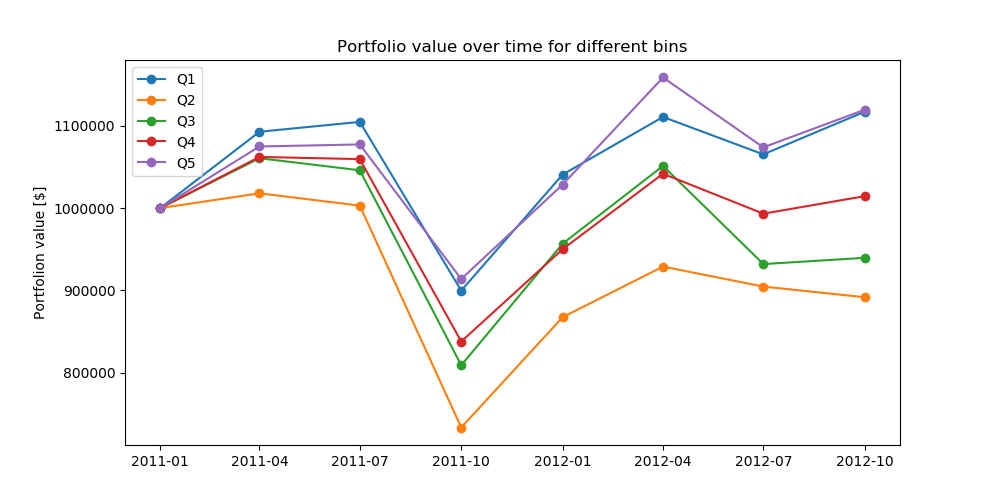

Text(0, 0.5, 'Portfolion value [$]')

In [84]:
plt.figure(figsize=(10, 5))
for l in s['bin_labels']:
    x = []
    y = []
    for qtr in s['list_qtr'][s['lag']:]:
        start = "{}{}{}".format(str(qtr[0]), str(((qtr[1])-1)*3+1).zfill(2), '01')
        x.append(datetime.strptime(start, '%Y%m%d').date())
        valuation = pf_values['diff_cosine_tf'][l][qtr][0]
        y.append(valuation)
        
    plt.plot_date(x, y, label=l, linestyle='-')

plt.legend()
plt.title('Portfolio value over time for different bins')
plt.ylabel('Portfolion value [$]')

<IPython.core.display.Javascript object>


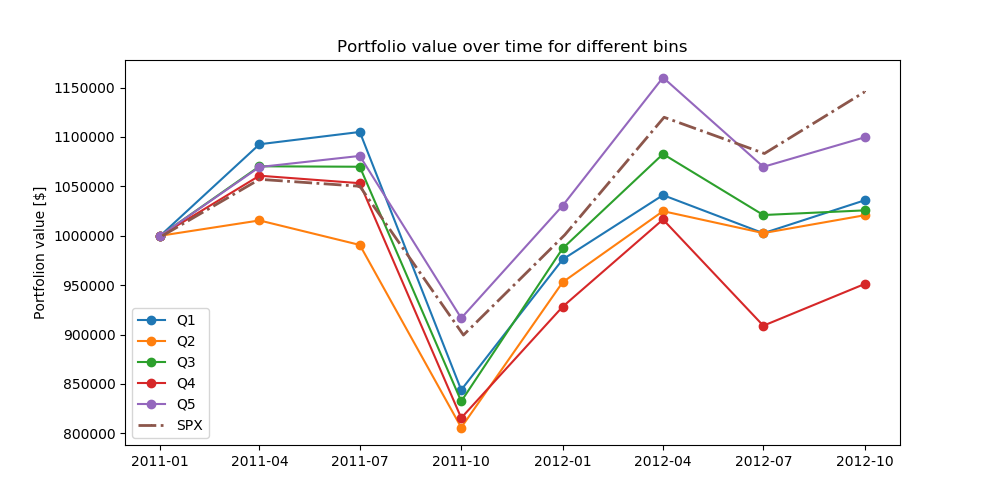

Text(0, 0.5, 'Portfolion value [$]')

In [87]:
plt.figure(figsize=(10, 5))
for l in s['bin_labels']:
    x = []
    y = []
    for qtr in s['list_qtr'][s['lag']:]:
        start = "{}{}{}".format(str(qtr[0]), str(((qtr[1])-1)*3+1).zfill(2), '01')
        x.append(datetime.strptime(start, '%Y%m%d').date())
        y.append(pf_values['diff_cosine_tf_idf'][l][qtr][0])
    plt.plot_date(x, y, label=l, linestyle='-')

# Overlay an index
#start_date = qtrs.qtr_to_day(s['list_qtr'][s['lag']], 'first', date_format='datetime')
#end_date = qtrs.qtr_to_day(s['list_qtr'][-1], 'last', date_format='datetime')
index_name = 'SPX'
benchmark_x = []
benchmark_y = []
for qtr in s['list_qtr'][s['lag']:]:
    qtr_start_date = "{}{}{}".format(str(qtr[0]), str((qtr[1]-1)*3+1).zfill(2), '01')
    qtr_start_date = datetime.strptime(qtr_start_date, '%Y%m%d').date()
    days, _ = zip(*index_data[index_name])
    for _ in range(7):
        try:
            idx = days.index(qtr_start_date)
            break
        except:  # Increment the day number until it goes through
            qtr_start_date = qtr_start_date.strftime('%Y%m%d')
            day = str(int(qtr_start_date[7]) + 1)
            qtr_start_date = qtr_start_date[:7] + day
            qtr_start_date = datetime.strptime(qtr_start_date, '%Y%m%d').date()
    benchmark_x.append(qtr_start_date)
    benchmark_y.append(index_data[index_name][idx][1])

benchmark_y = np.array(benchmark_y)
benchmark_y *= s['pf_init_value']/benchmark_y[0]
plt.plot_date(benchmark_x, benchmark_y, label=index_name, linestyle='-.', linewidth=2, ms=10, marker=',')
plt.legend()
plt.title('Portfolio value over time for different bins')
plt.ylabel('Portfolion value [$]')

In [ ]:
for qtr in s['list_qtr'][1:]:
    print(qtr, pf_values['diff_jaccard']['Q5'][qtr][0])

In [ ]:
test_qtr_data = master_dict['diff_jaccard'][(2010, 2)]

In [ ]:
# [DEBUG] Show the Apple data for that time period
extracted_cik_scores = cik_scores[data_to_process[0][0]]
extracted_cik_scores

In [ ]:
#ticker = lookup[320193]
ticker = lookup[data_to_process[0][0]]
start_date = qtrs.qtr_to_day(s['time_range'][0], 'first', date_format='datetime')
stop_date = qtrs.qtr_to_day(s['time_range'][1], 'last', date_format='datetime')

#print(s['time_range'], start_date)
#print(s['time_range'], stop_date)
extracted_stock_data = {k: v for k, v in stock_data[ticker].items() if start_date <= k <= stop_date}
#print(extracted_data)


# Display the data

## For a given ticker

### Metrics vs stock price

In [ ]:
display.diff_vs_stock(extracted_cik_scores, extracted_stock_data, ticker, s, method='diff')

### Sentiment vs stock price

In [ ]:
display.diff_vs_stock(extracted_cik_scores, extracted_stock_data, ticker, s, method='sentiment')